In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
from tqdm import tqdm, trange
import random

In [3]:
# Constants
TIMESTEPS = 30000
REPLAY_BUFFER_SIZE = 100000
LEARNING_START = 10000
BATCH_SIZE = 256
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.0001

In [4]:
from displayframesasgif import display_frames_as_gif
from replaybuffer import ReplayBuffer, PrioritizedReplayBuffer
from ddpg import DDPG
#from amc import AMC
from neuralnetwork import NeuralNetwork
from layers import *
from movingaverage import MovingAverage

In [5]:
env = gym.make('Pendulum-v0')

[2017-03-01 00:04:24,935] Making new env: Pendulum-v0


In [6]:
observation = env.reset()
frames = []
reward_avg = MovingAverage(100)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [7]:
session = tf.InteractiveSession()

In [8]:
actor_network = NeuralNetwork("Actor", session, [state_dim])
a_h0 = FullyConnectedLayer("h0", 256, actor_network.get_input_layer(0), tf.nn.relu)
a_h1 = FullyConnectedLayer("h1", 128, a_h0, tf.nn.relu)
a_out = FullyConnectedLayer("out", action_dim, a_h1, tf.identity)
actor_network.compile(a_out)

q_network = NeuralNetwork("Q", session, [state_dim, action_dim])
concat = ConcatLayer("qconcat", [q_network.get_input_layer(0), q_network.get_input_layer(1)])
q_h0 = FullyConnectedLayer("qh0", 256, concat, tf.nn.relu)
q_h1 = FullyConnectedLayer("qh1", 128, q_h0, tf.nn.relu)
q_out = FullyConnectedLayer("qout", 1, q_h1, tf.identity)
q_network.compile(q_out)

agent = DDPG(actor_network, q_network, discount_factor=DISCOUNT_FACTOR, batch_size=BATCH_SIZE,
             replay_buffer_size=REPLAY_BUFFER_SIZE, learning_rate=LEARNING_RATE)

session.run(tf.global_variables_initializer())

In [9]:
#actor_network = NeuralNetwork("Actor", session, [state_dim], ACTOR_NETWORK_LAYERS, action_dim, tf.nn.relu)
#model_network = NeuralNetwork("Model", session, [state_dim, action_dim], Q_NETWORK_LAYERS, state_dim, tf.nn.relu)
#reward_network = NeuralNetwork("Model", session, [state_dim, action_dim], Q_NETWORK_LAYERS, 1, tf.nn.relu)
#value_network = NeuralNetwork("Value", session, [state_dim], Q_NETWORK_LAYERS, 1, tf.nn.relu)

#agent = AMC(actor_network, model_network, reward_network, value_network, 1, discount_factor=DISCOUNT_FACTOR, batch_size=BATCH_SIZE,
#             replay_buffer_size=REPLAY_BUFFER_SIZE, learning_rate=LEARNING_RATE)

#session.run(tf.global_variables_initializer())

In [10]:
progress_bar = tqdm(total=TIMESTEPS)
state = np.array(env.reset())

for t in range(TIMESTEPS):   
    action = None
    
    exploration_probability = ((TIMESTEPS - t) / float(TIMESTEPS)) ** 2
    if t < LEARNING_START:
        exploration_probability = 1
    
    if random.uniform(0, 1) < exploration_probability:
        action = env.action_space.sample()
    else:
        action = agent.action([state])
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(observation, (state_dim,))
    agent.store_transition(state, action, reward, next_state, done)
    state = next_state
    
    reward_avg.add_value(reward)
        
    if t >= LEARNING_START:
        agent.train()
        if t % 60 == 0:
            frames.append(env.render(mode = 'rgb_array'))
        
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, action: {}' \
        .format(t, reward, reward_avg.get_average(), str(action)))
    progress_bar.update()
    
    if done:
        break
        
progress_bar.close()

[29999] reward: -0.01, reward 100-step MA: -0.01, action: [-0.33006418]: 100%|██████████| 30000/30000 [02:03<00:00, 243.19it/s]  386/30000 [00:00<00:07, 3856.18it/s]



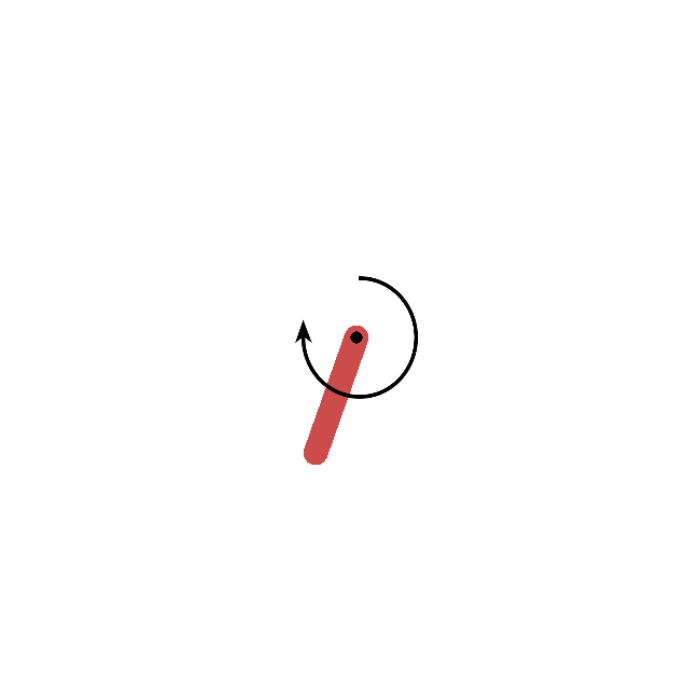
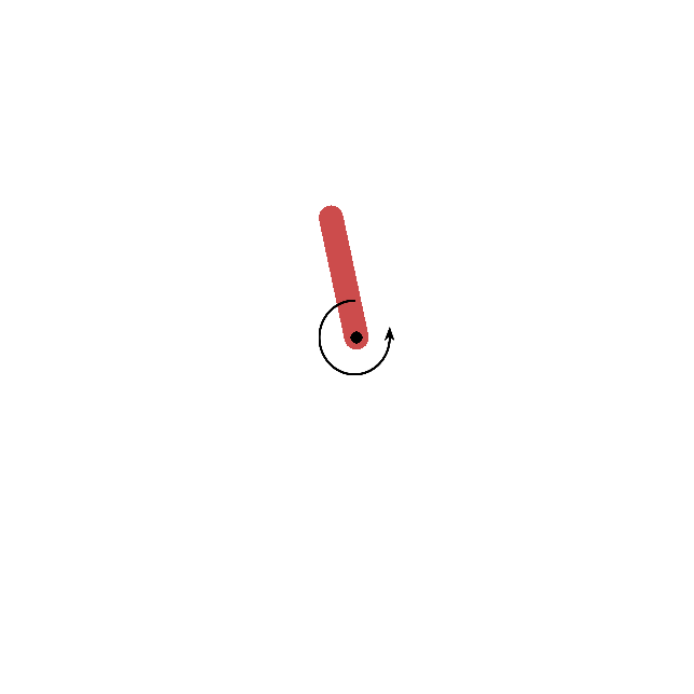
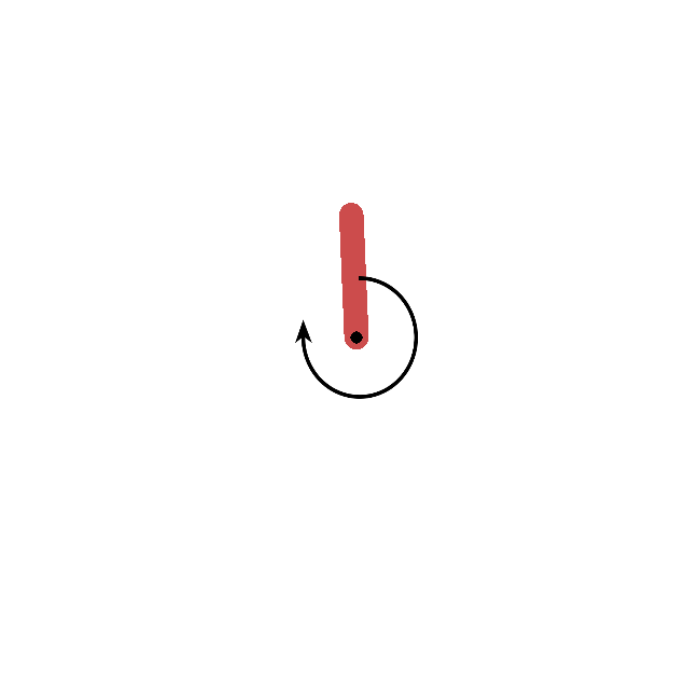
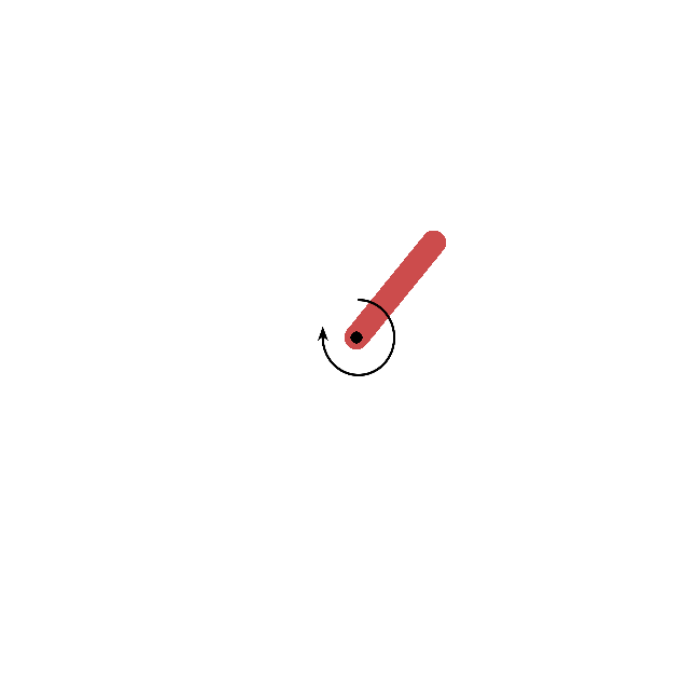
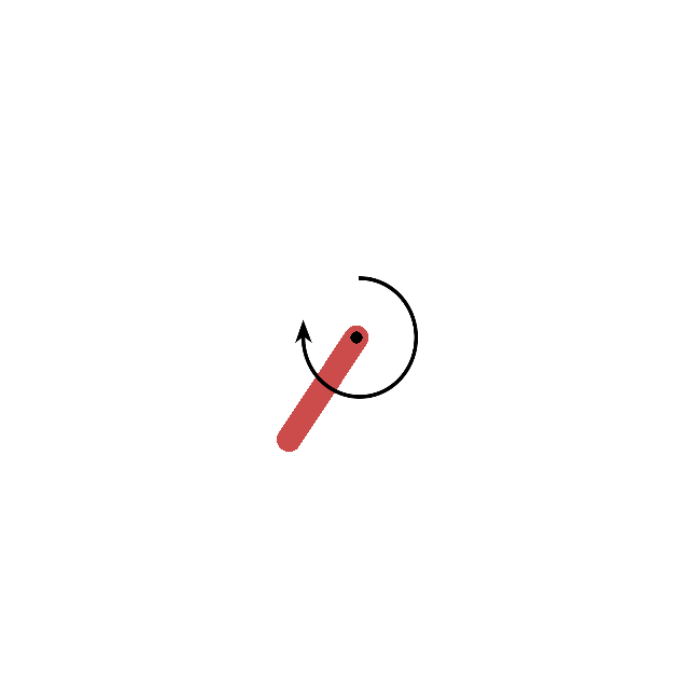
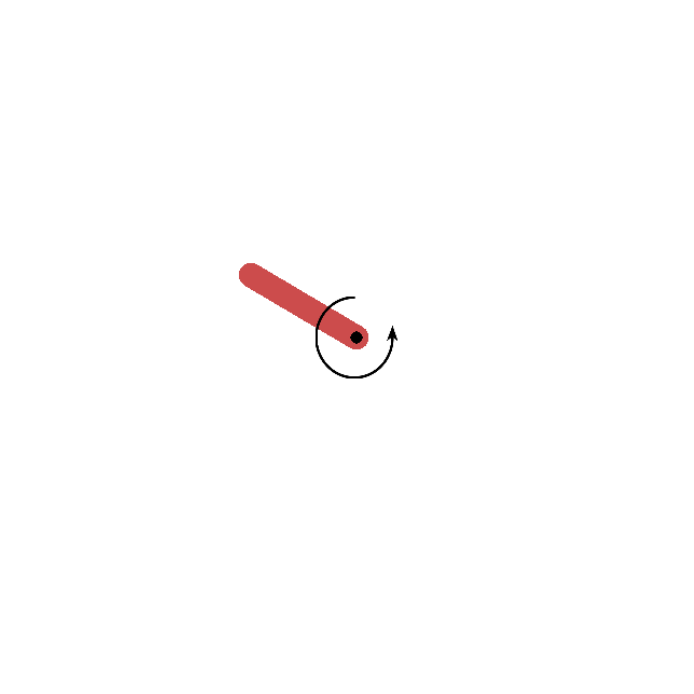
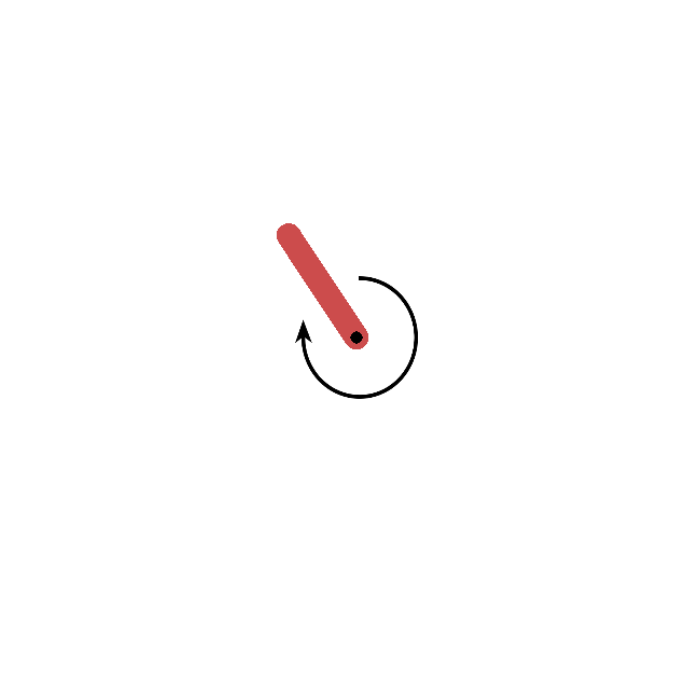
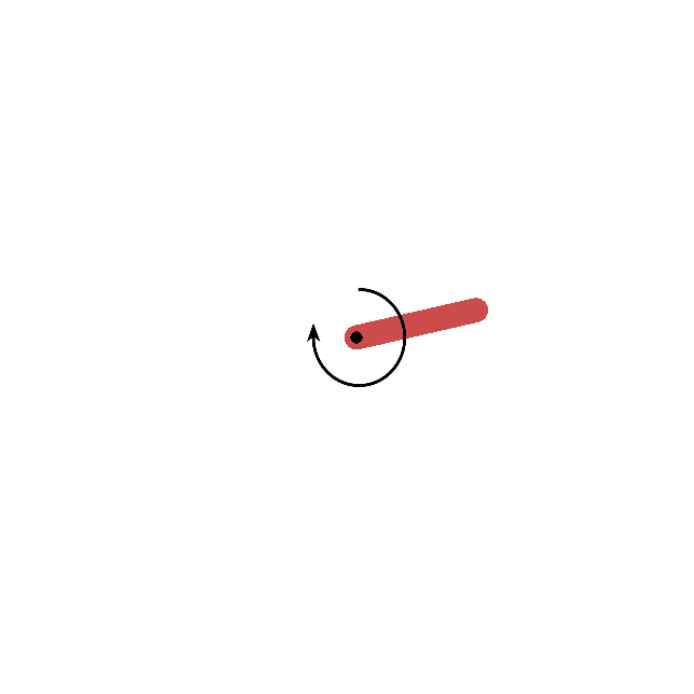
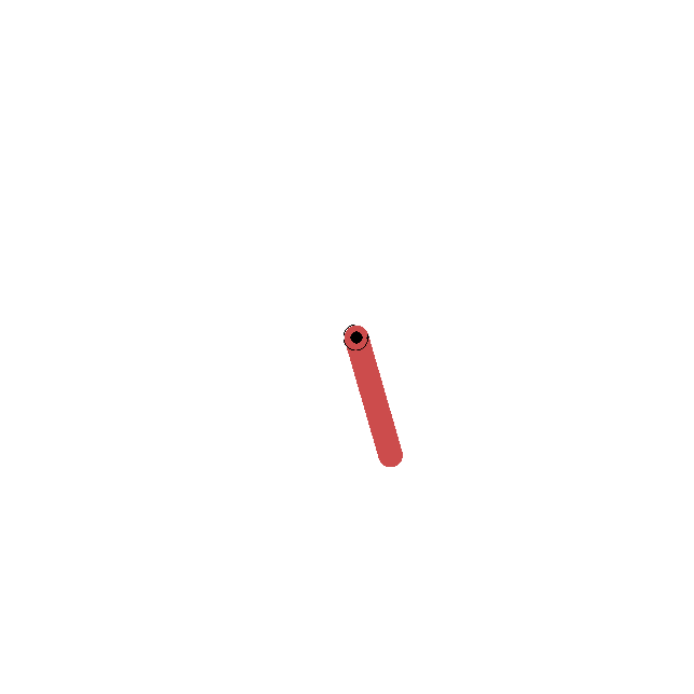
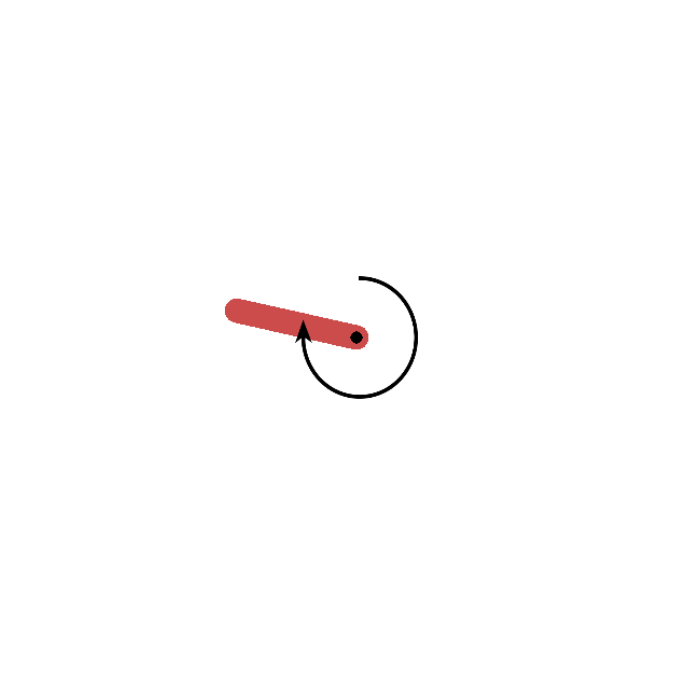
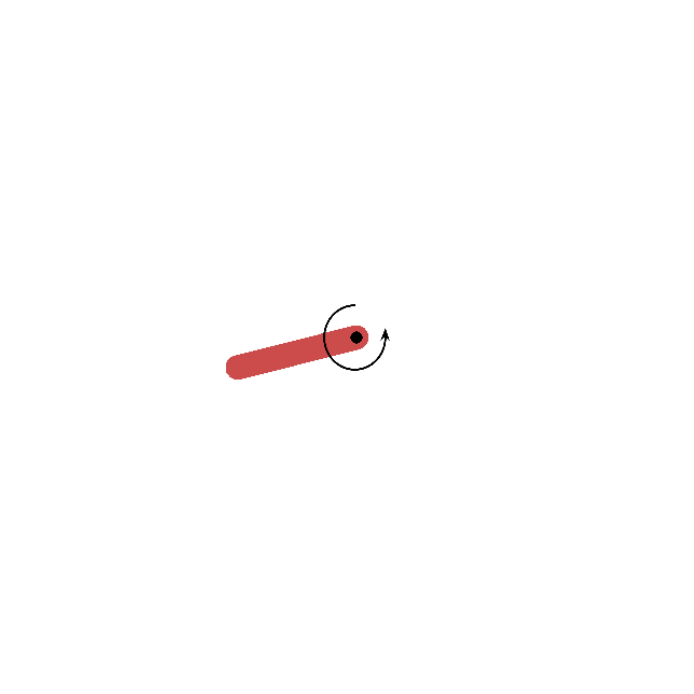
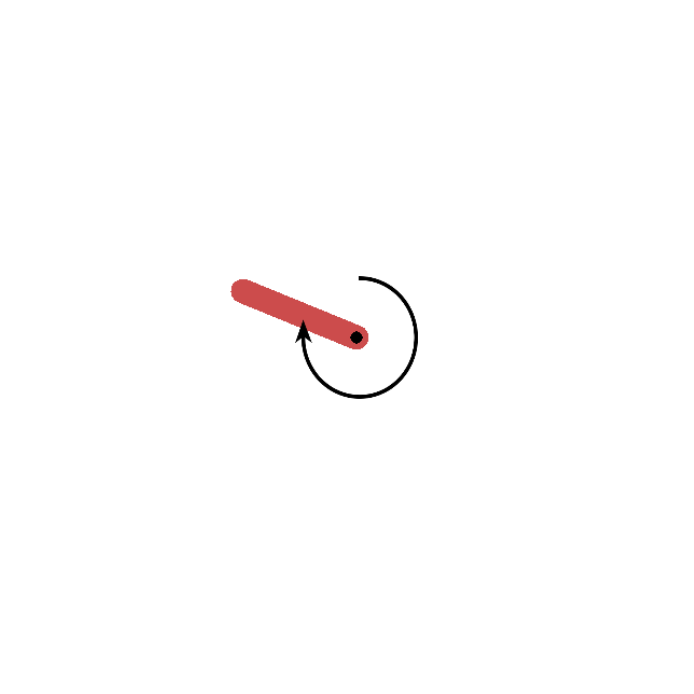
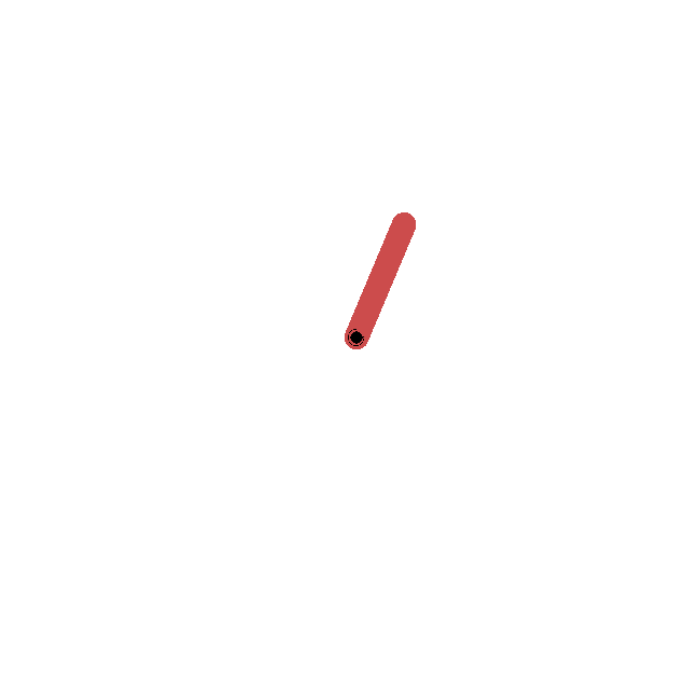
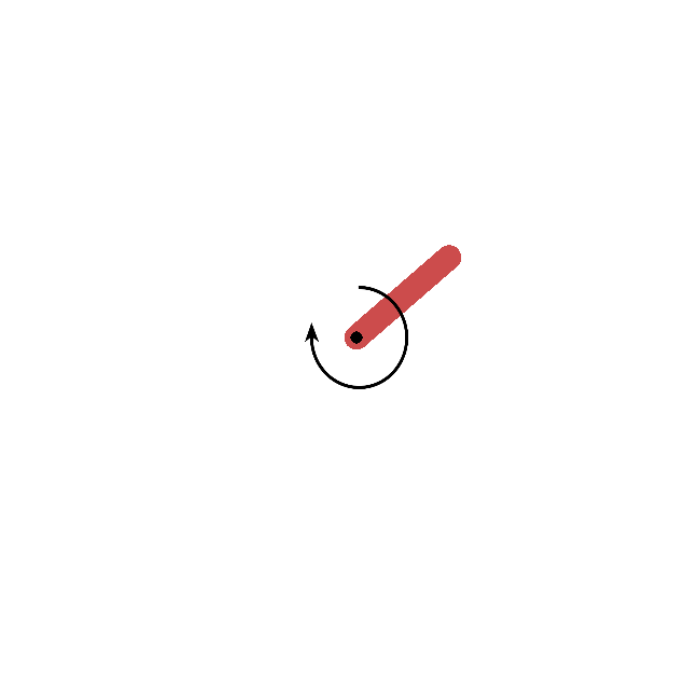
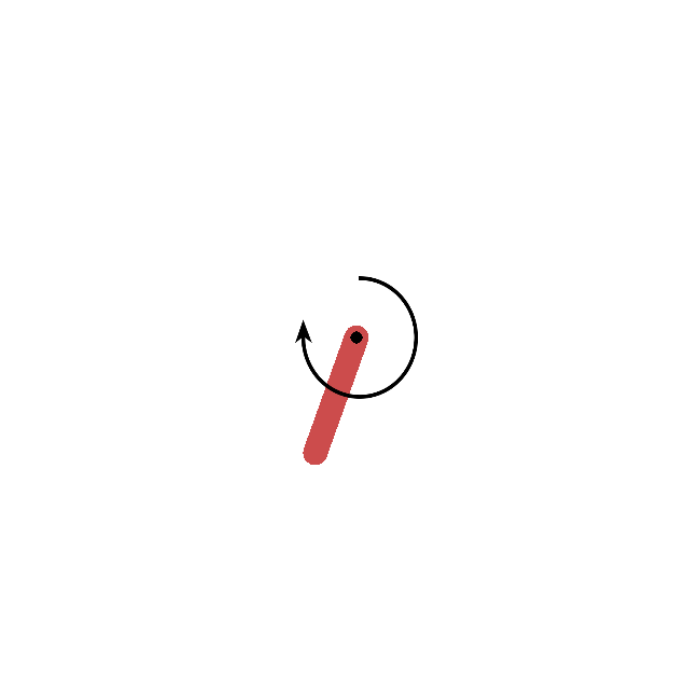
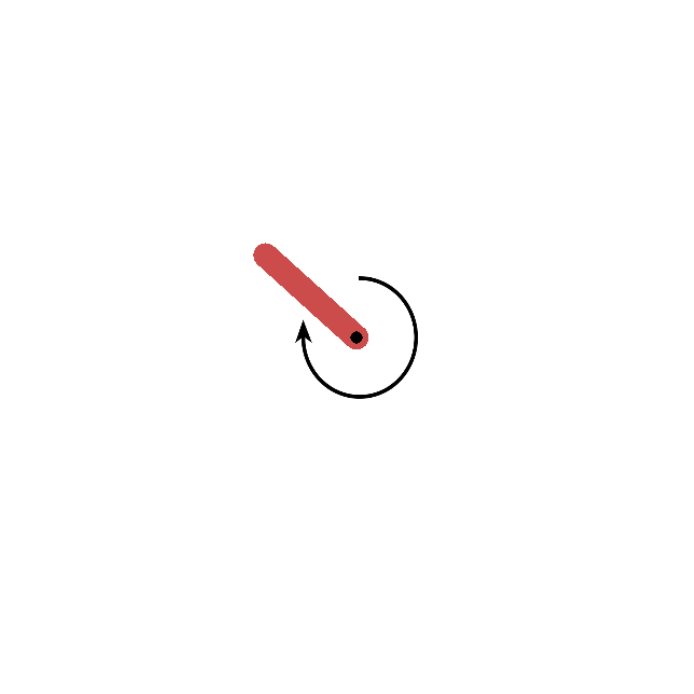
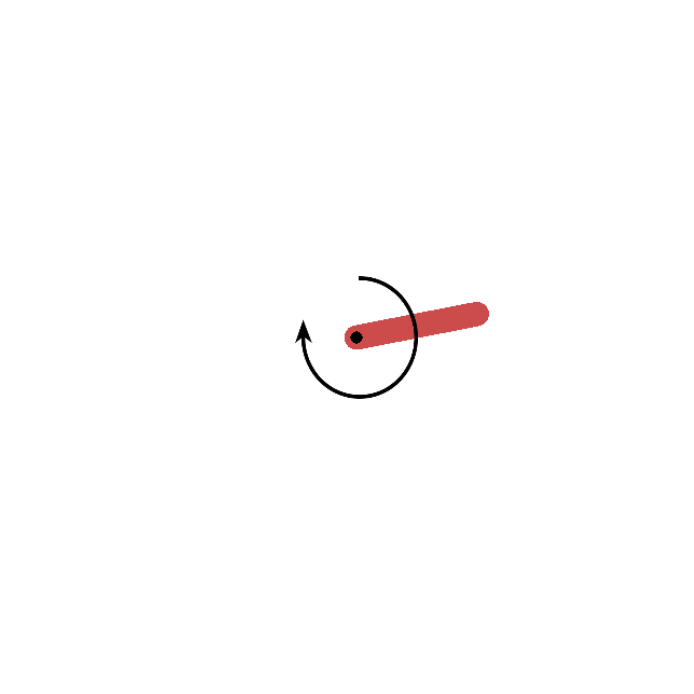
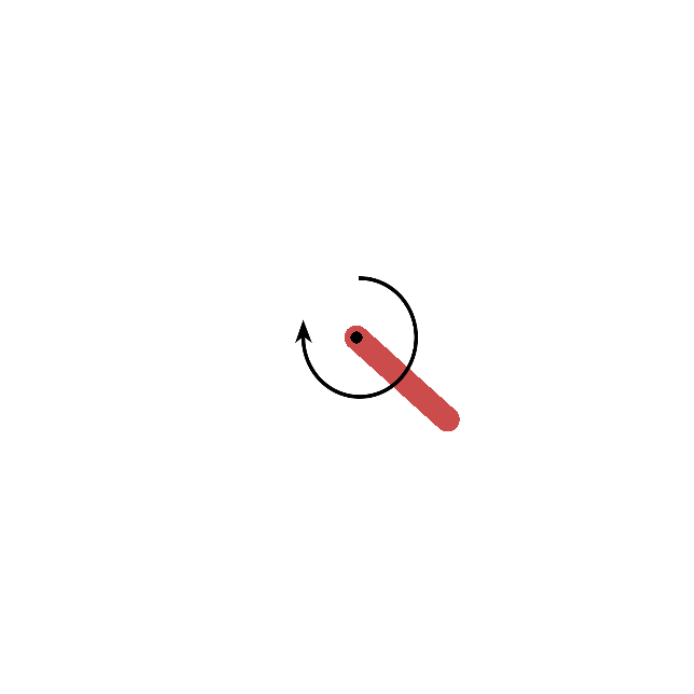
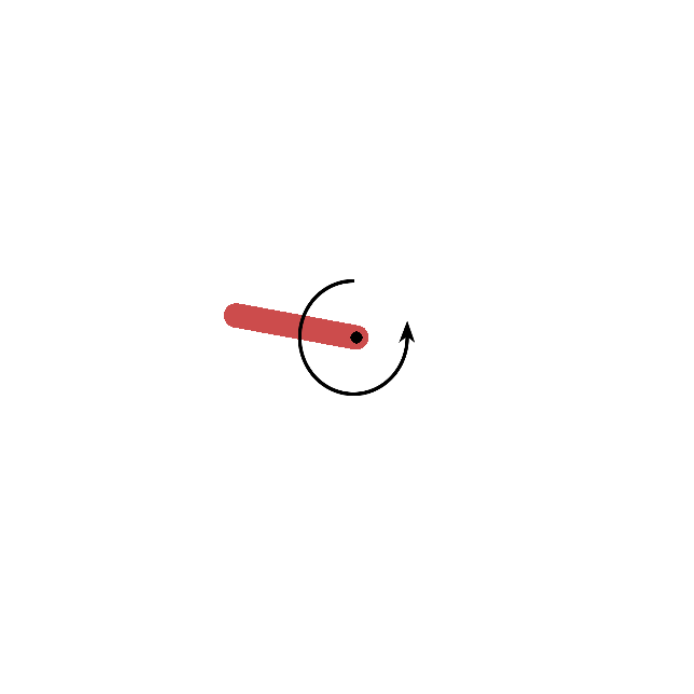
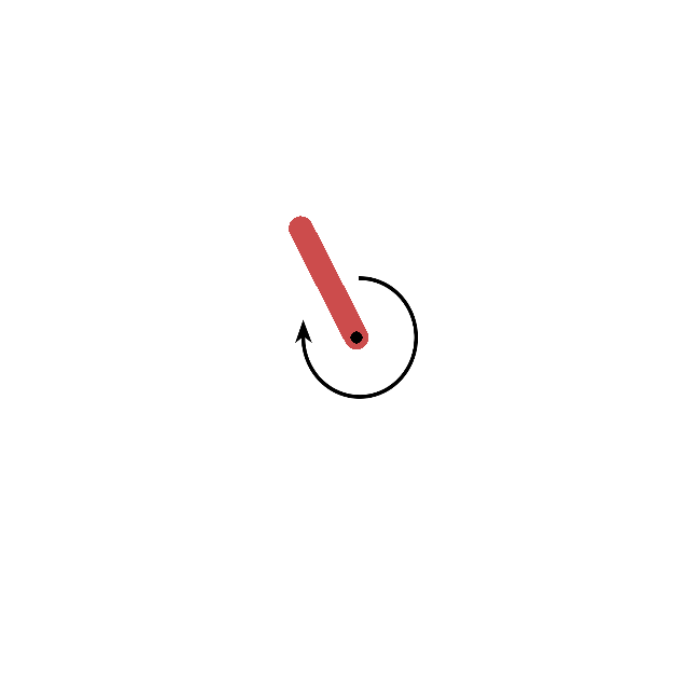
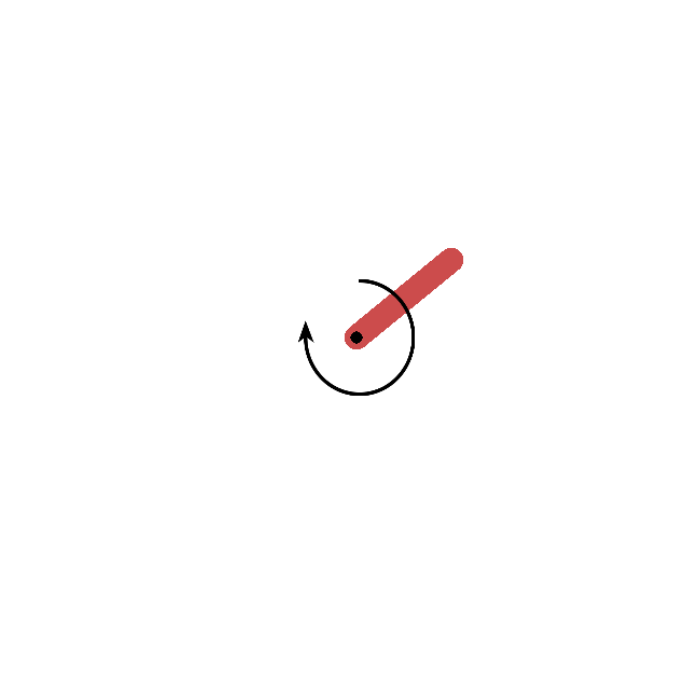
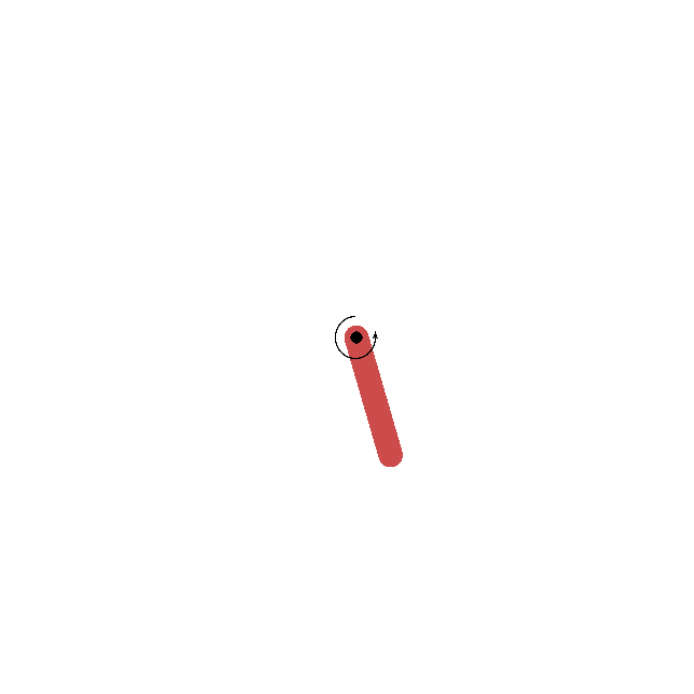
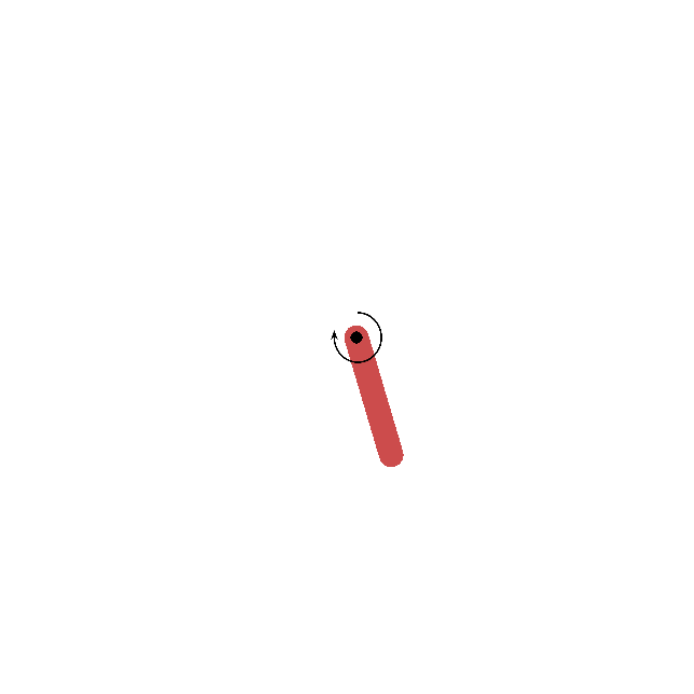
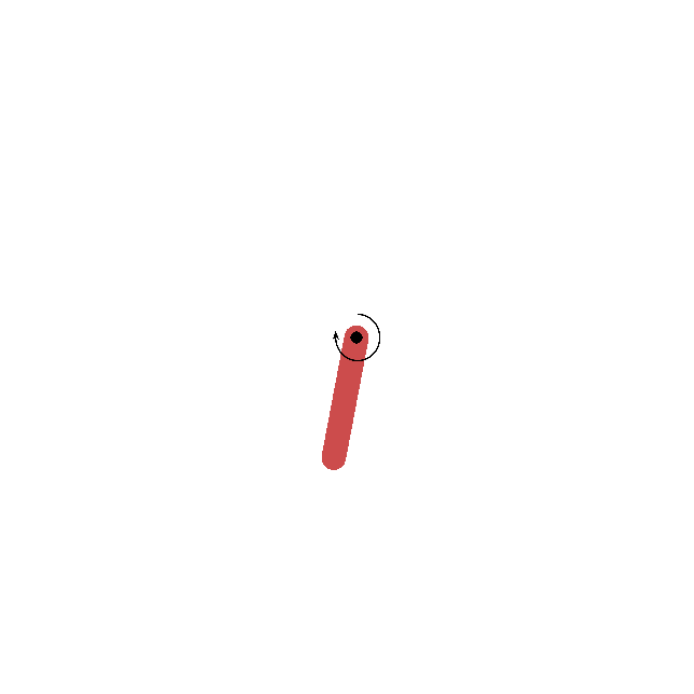
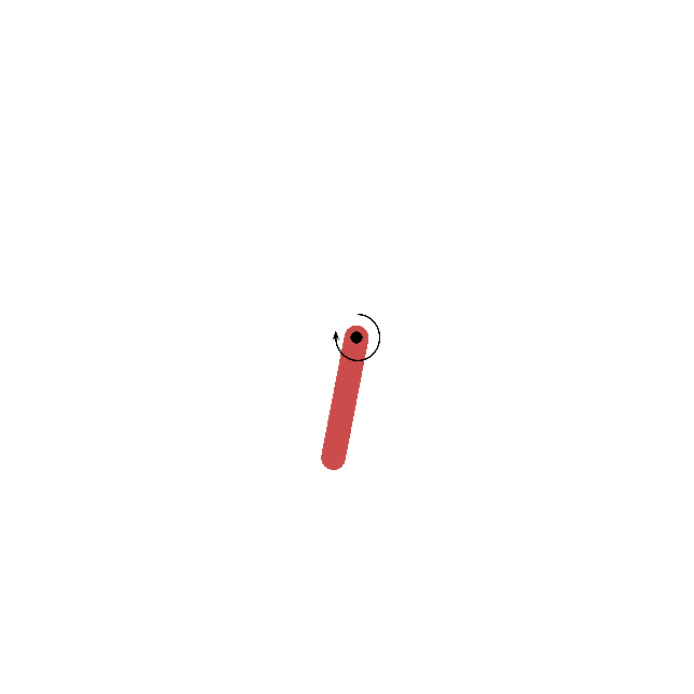
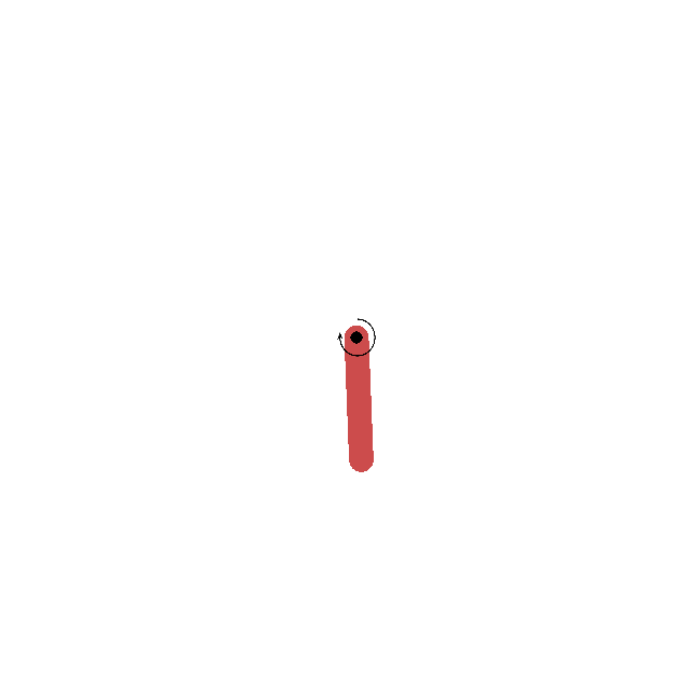
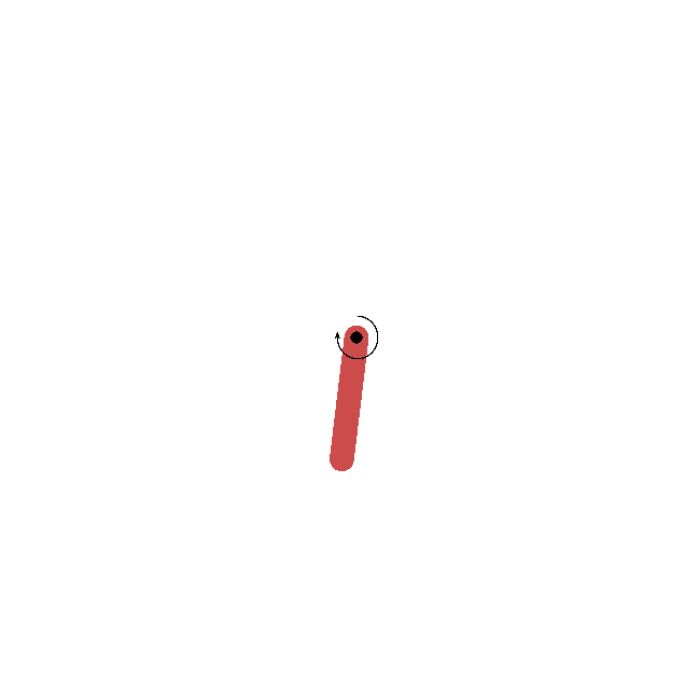
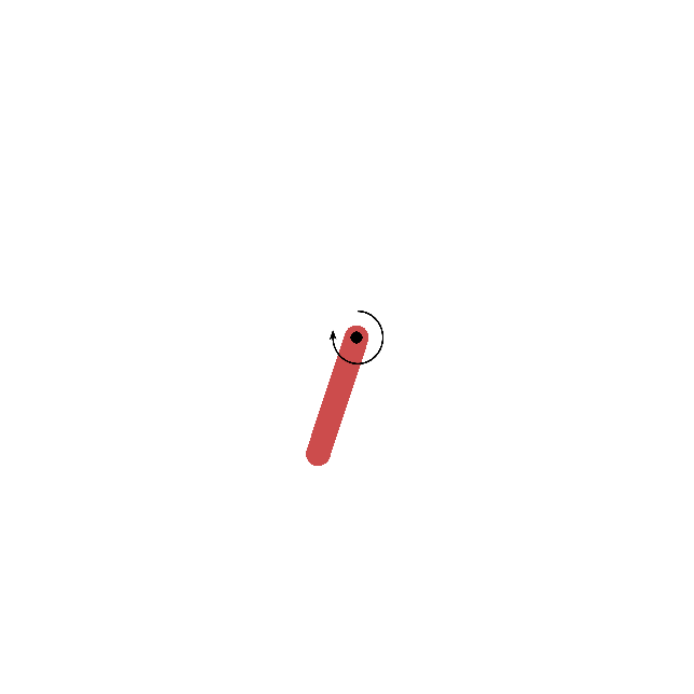
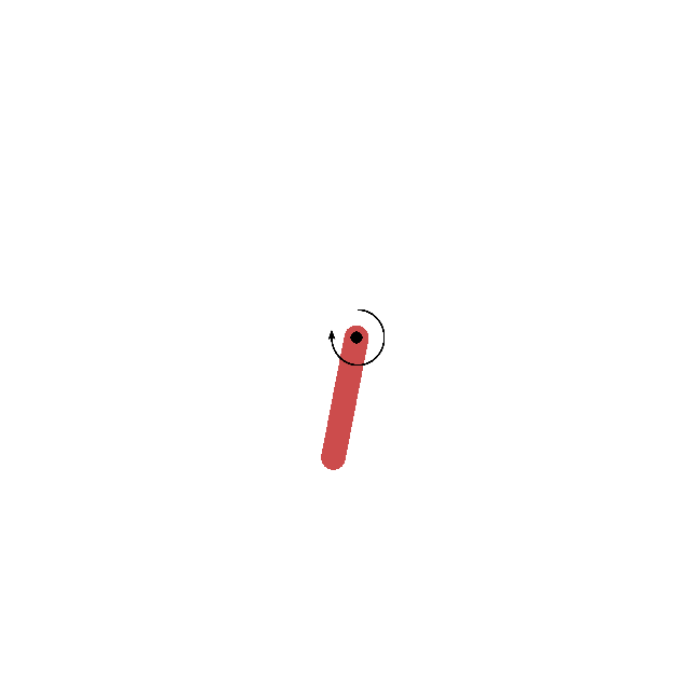
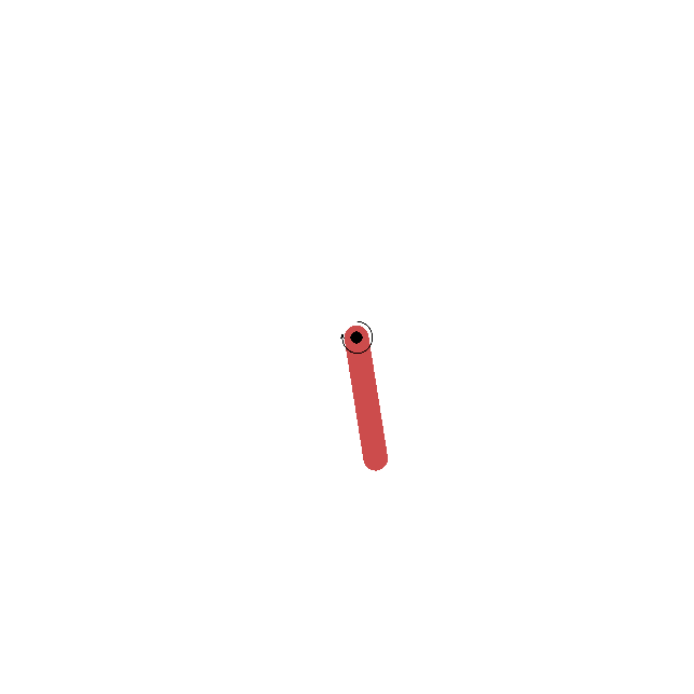
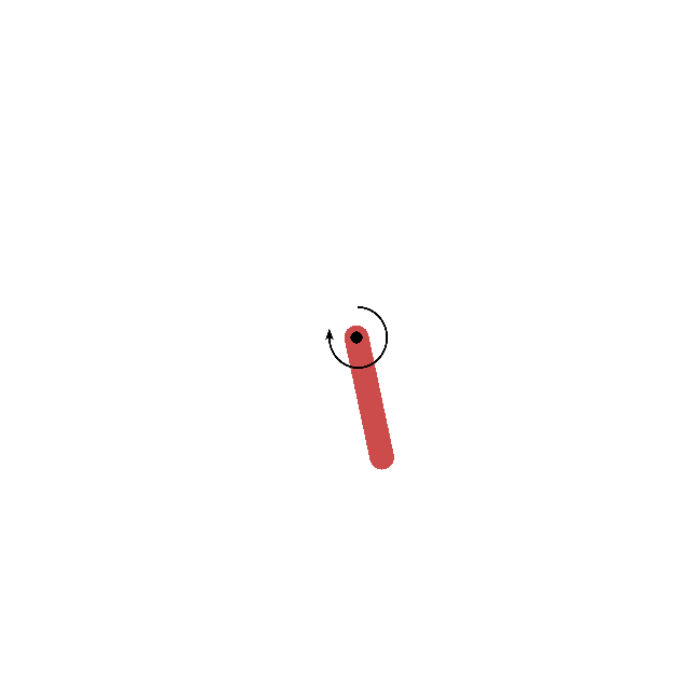
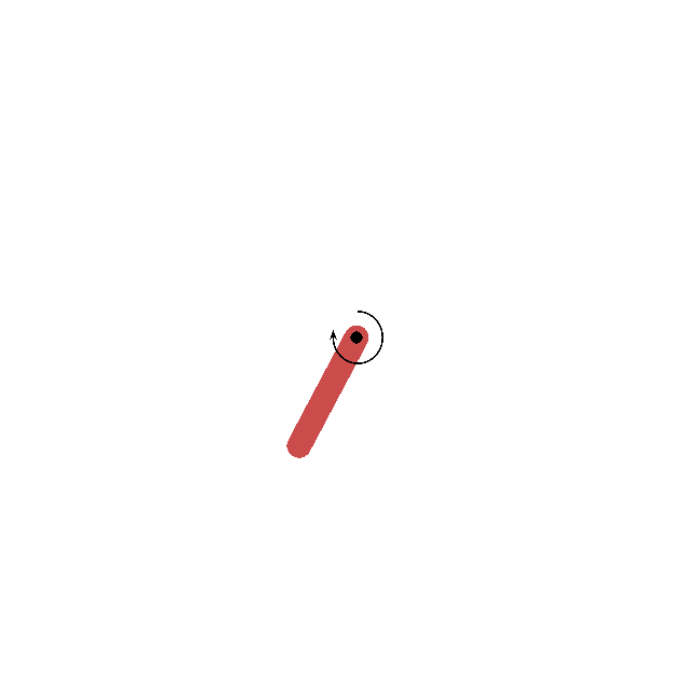
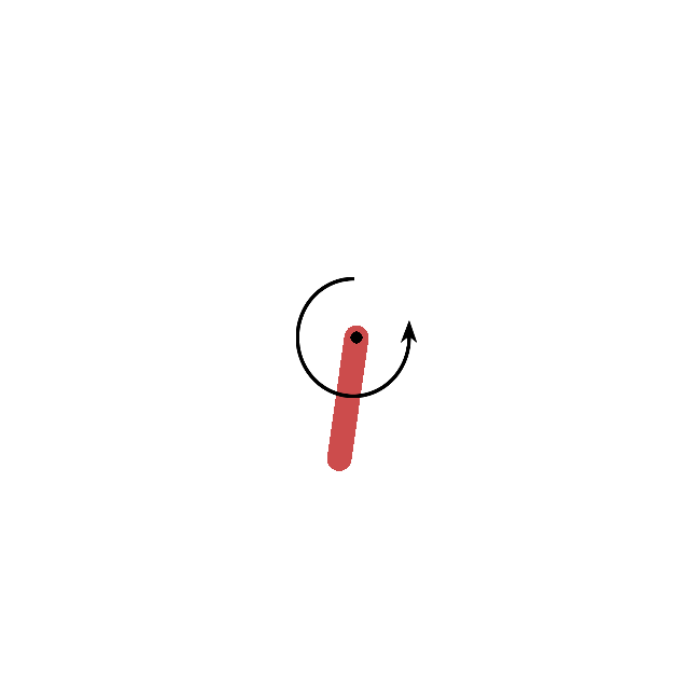
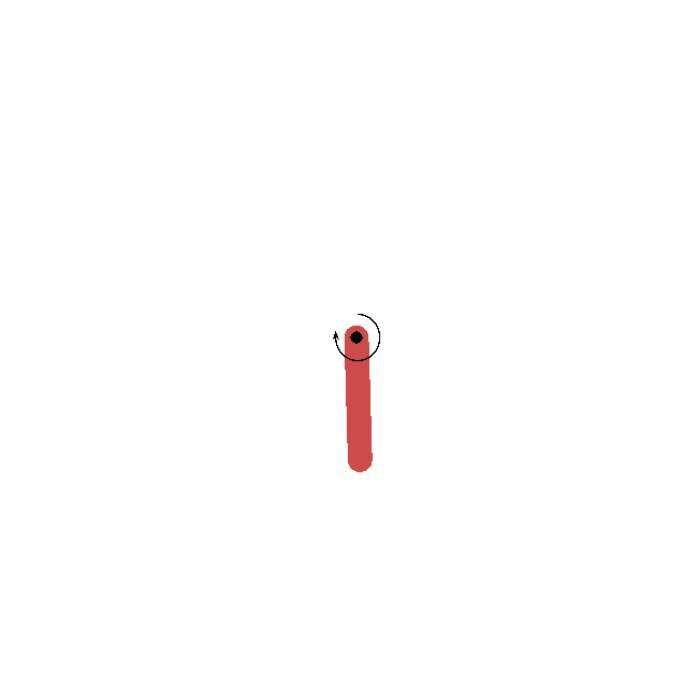
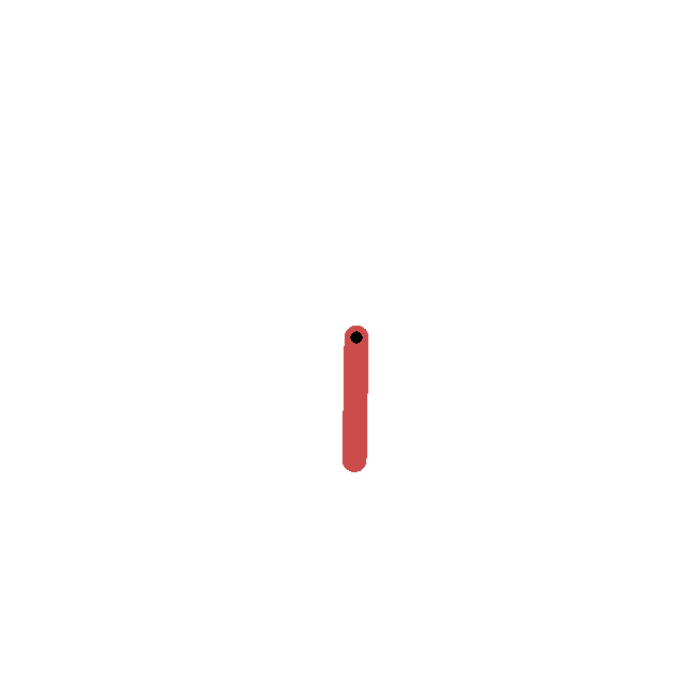
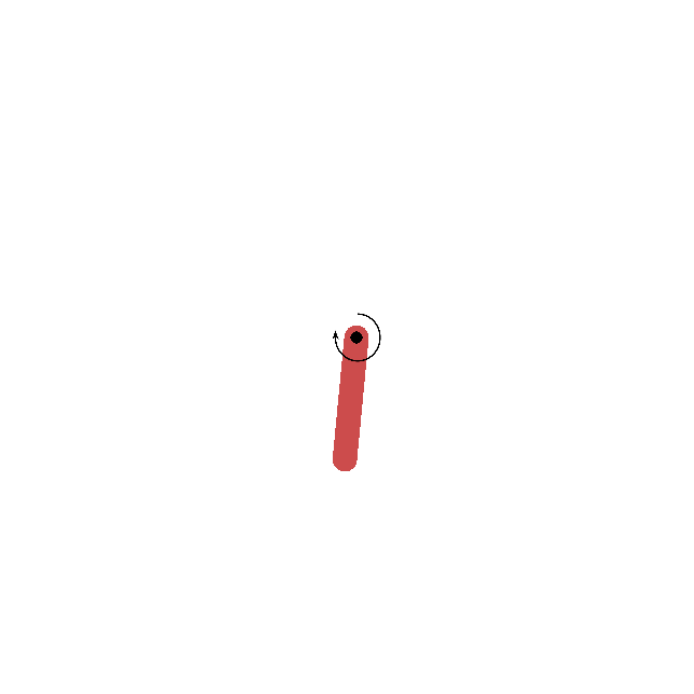
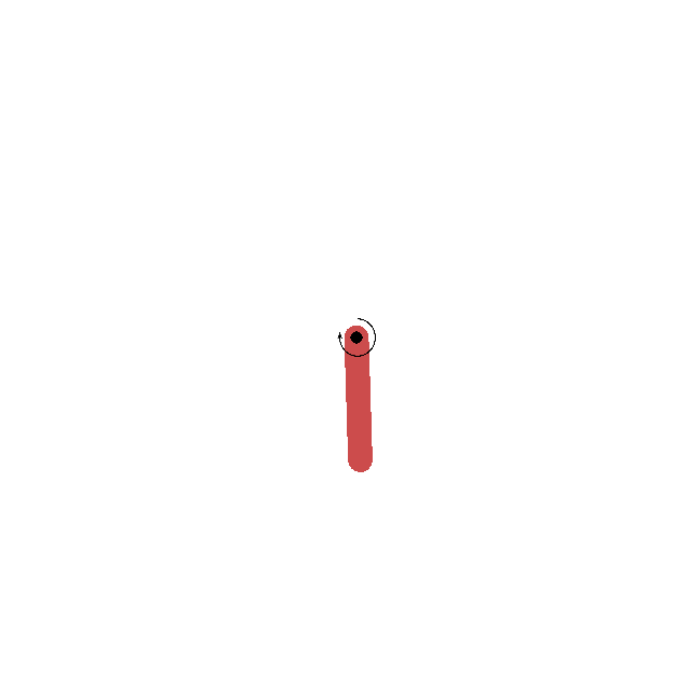
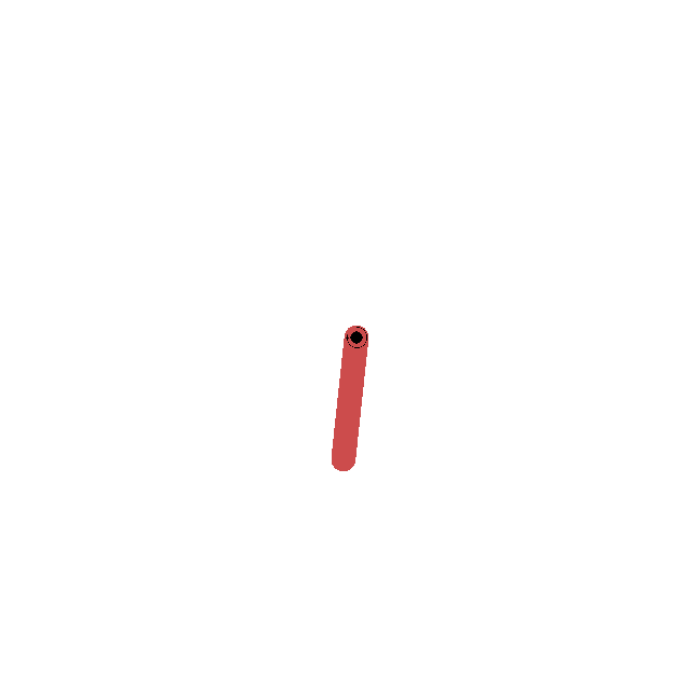
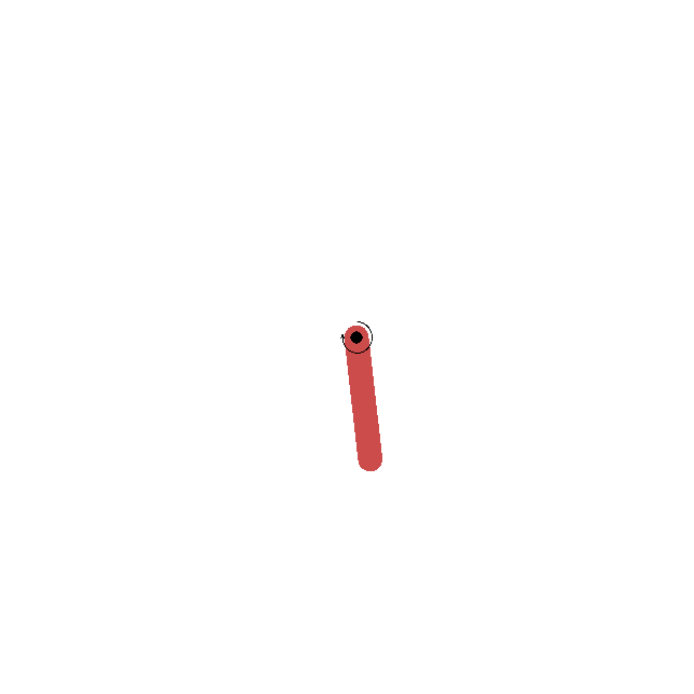
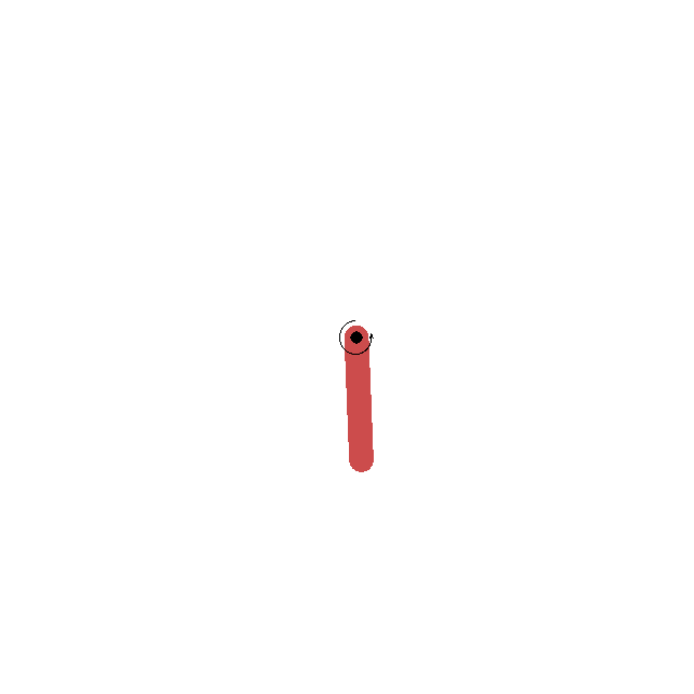
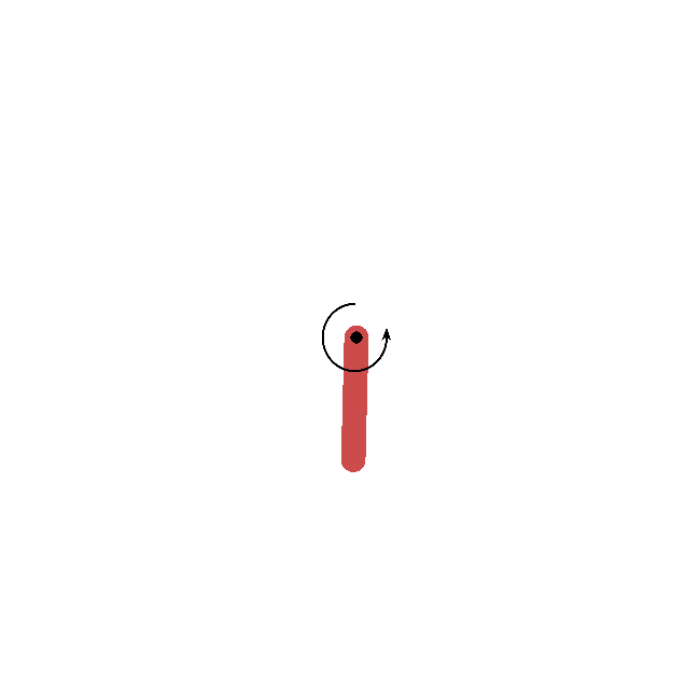
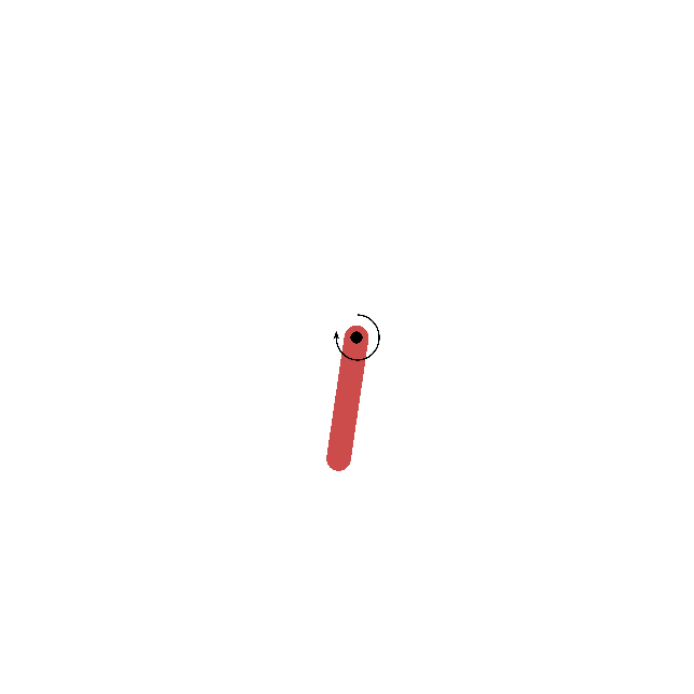
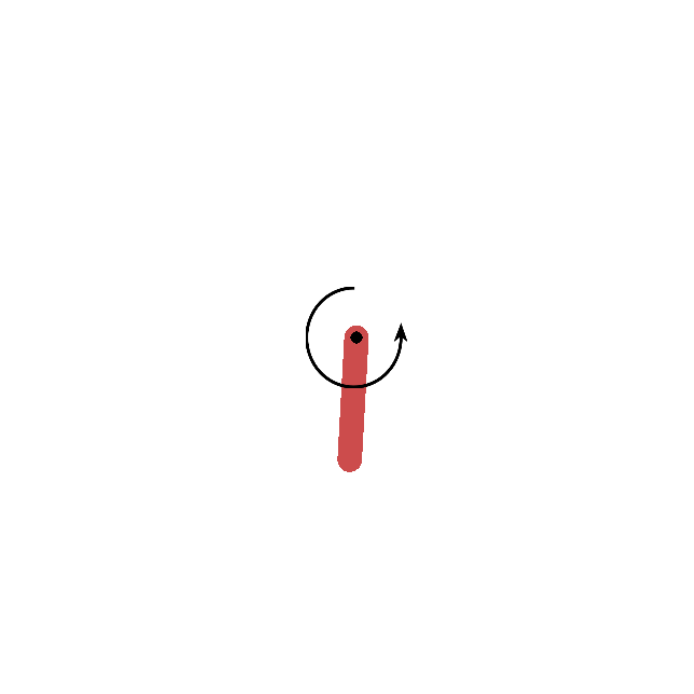
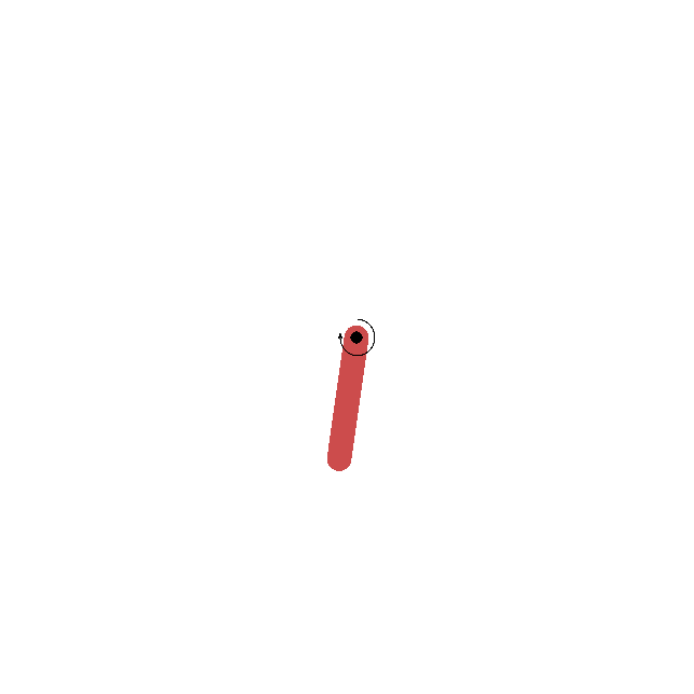
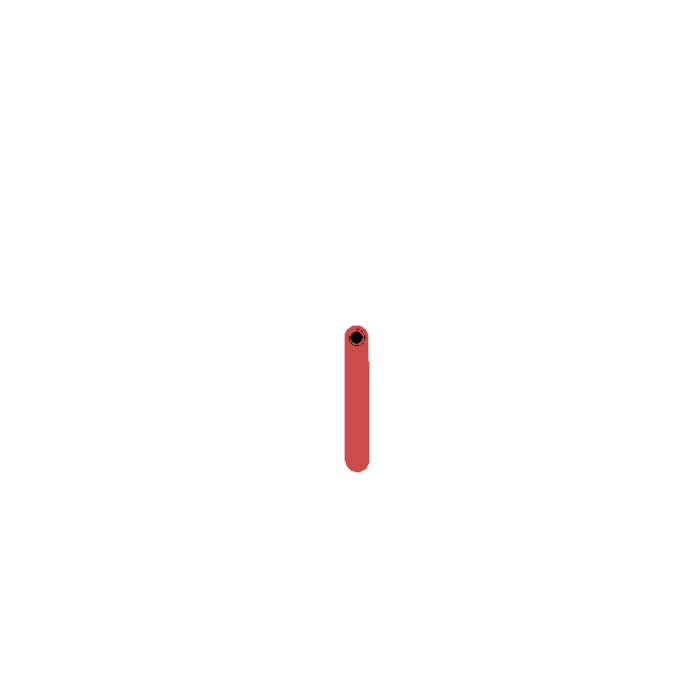
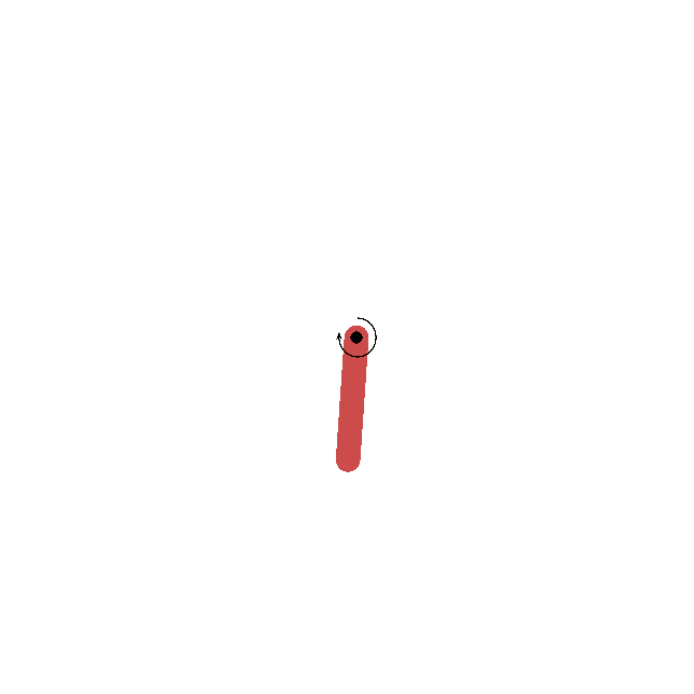
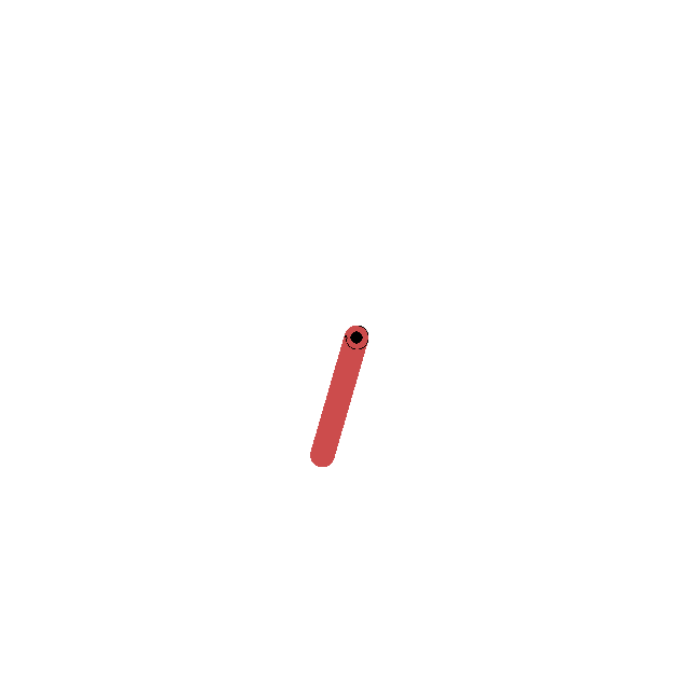
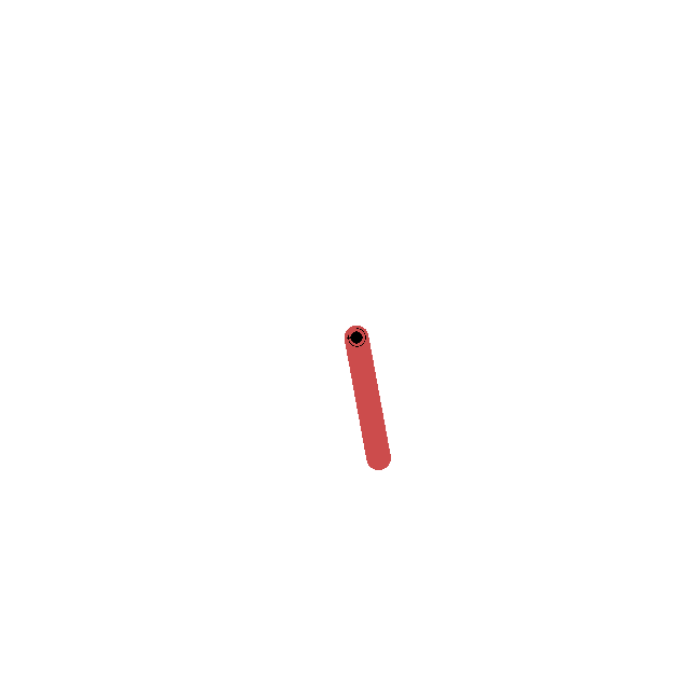
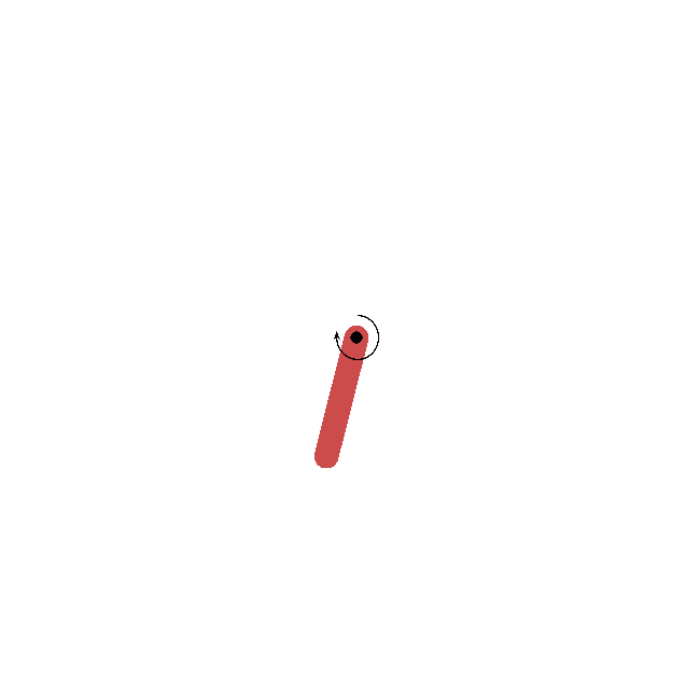
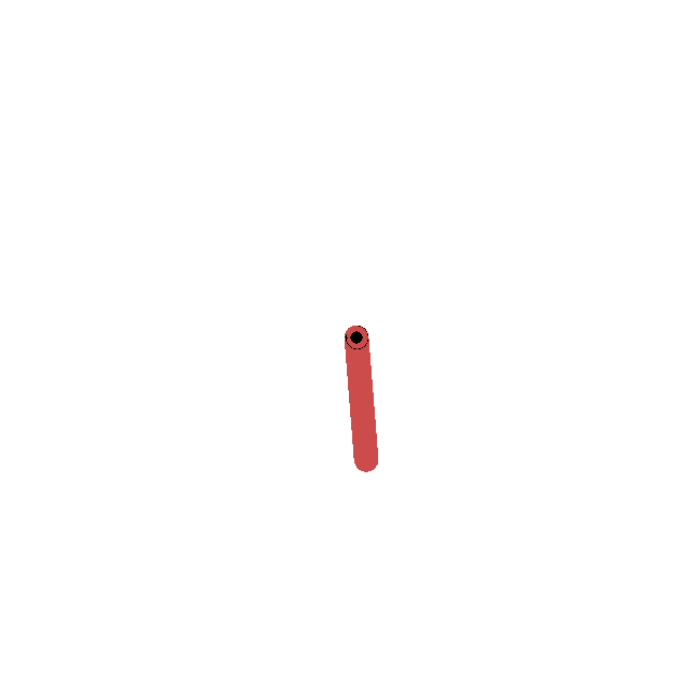
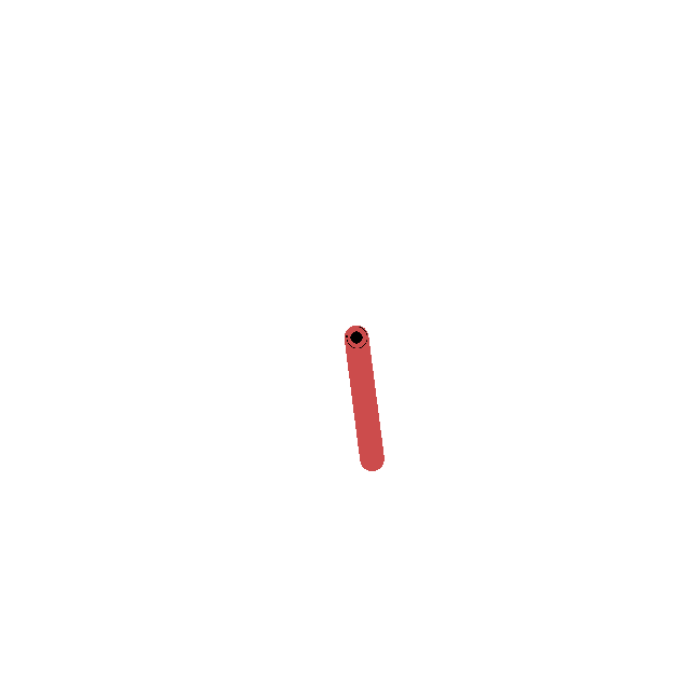
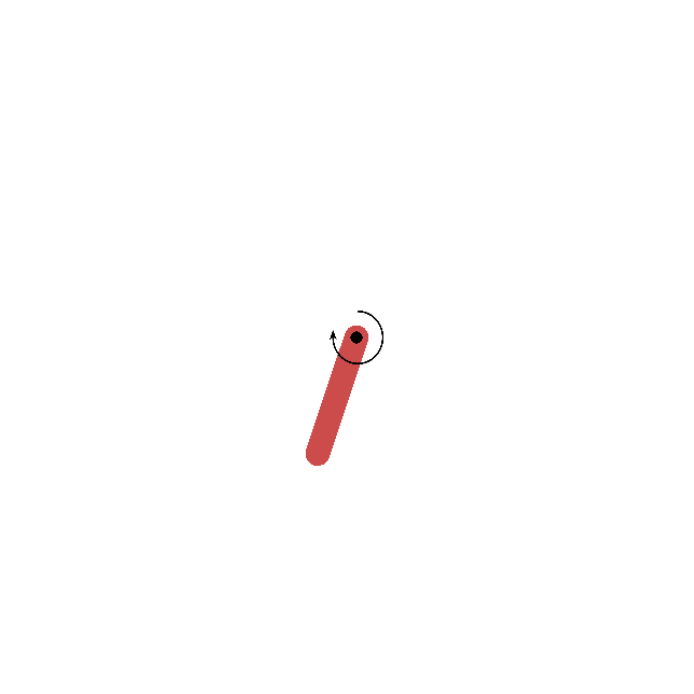
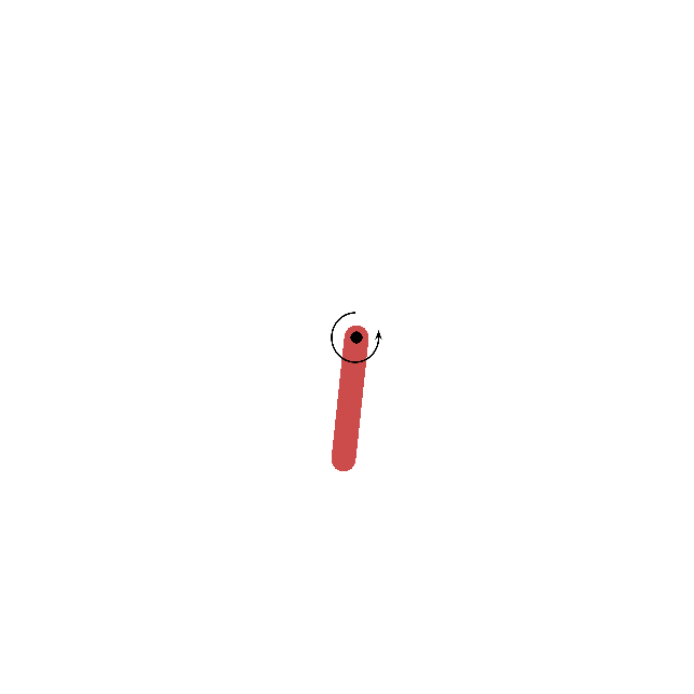
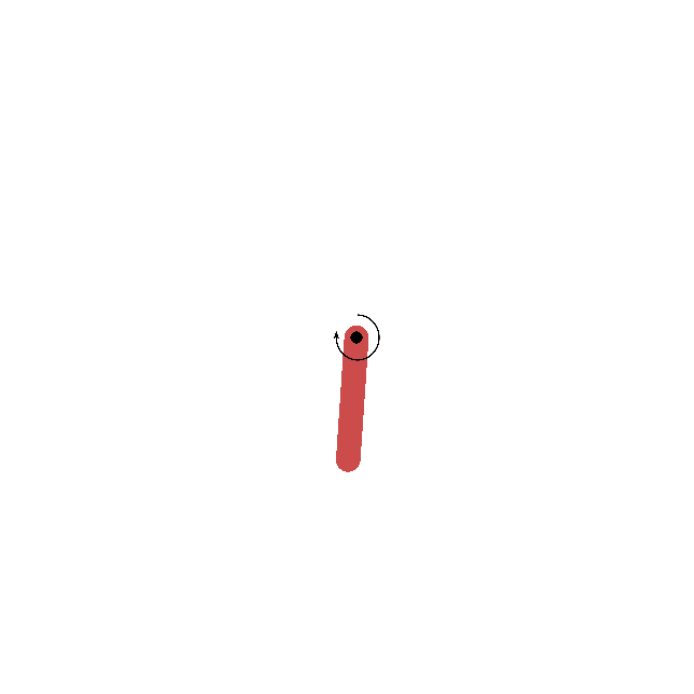
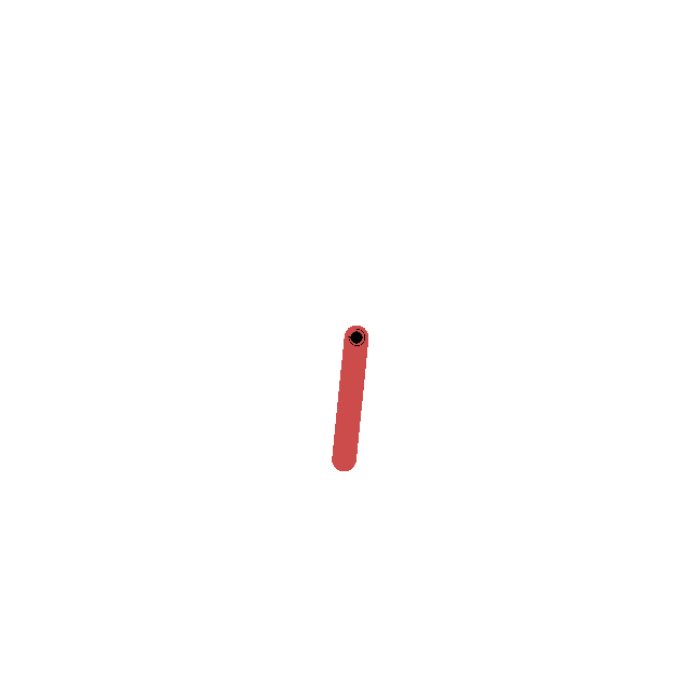
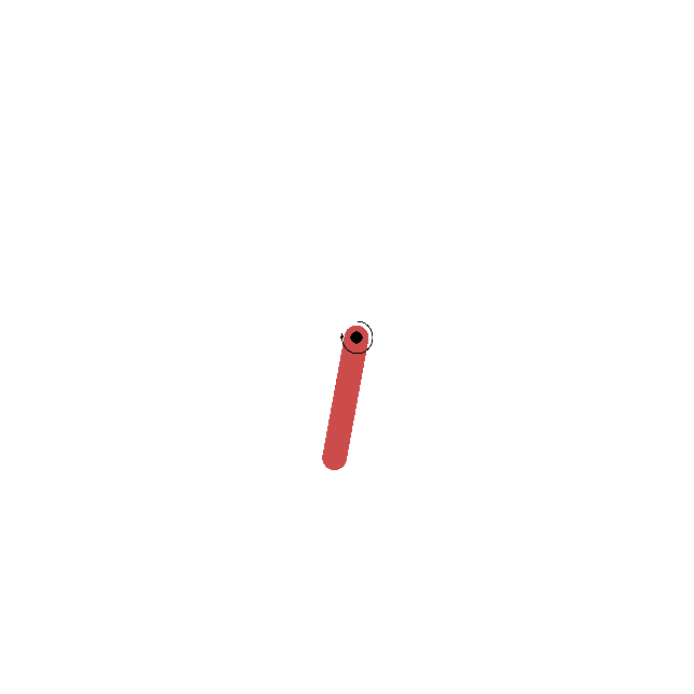
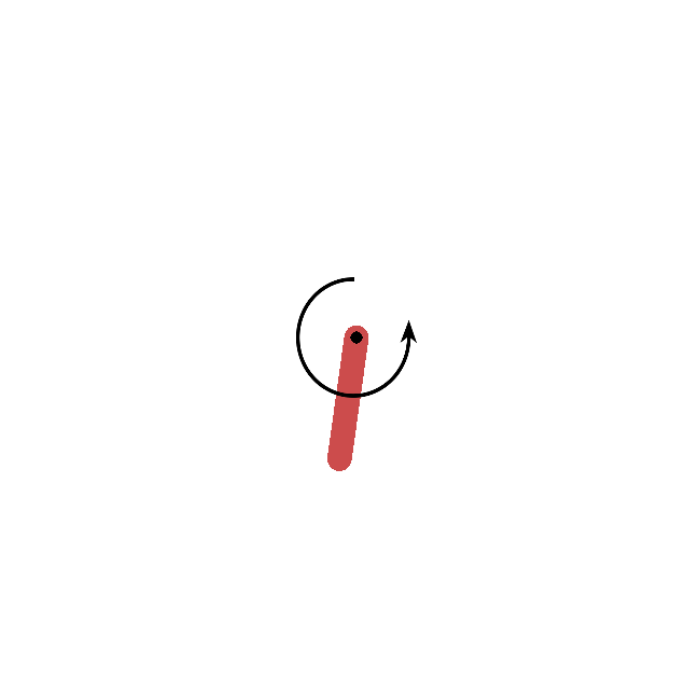
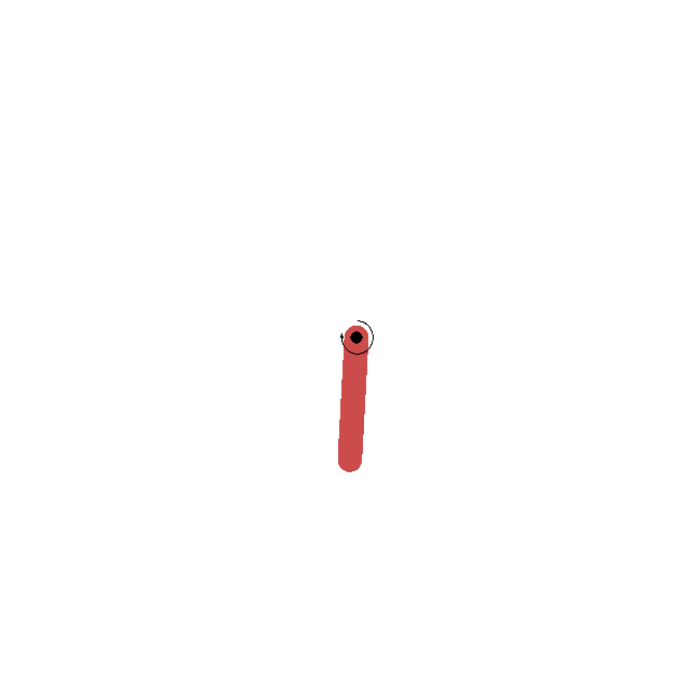
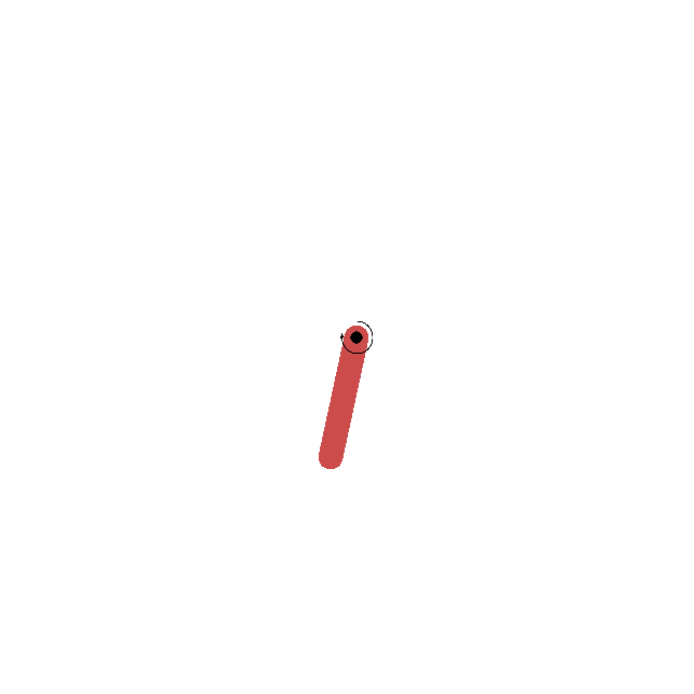
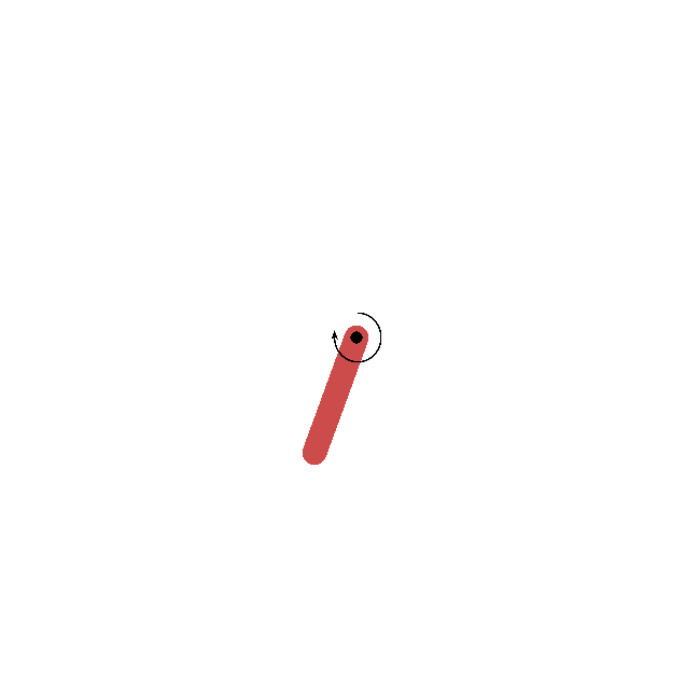
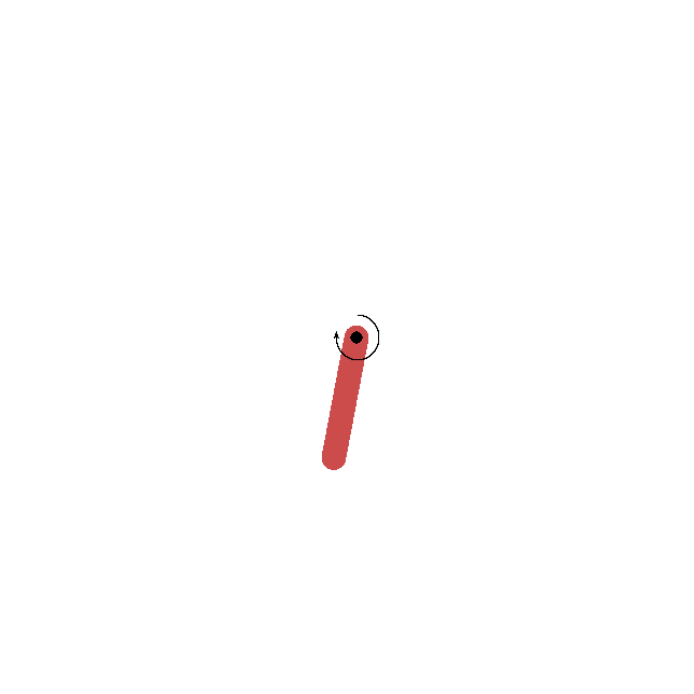
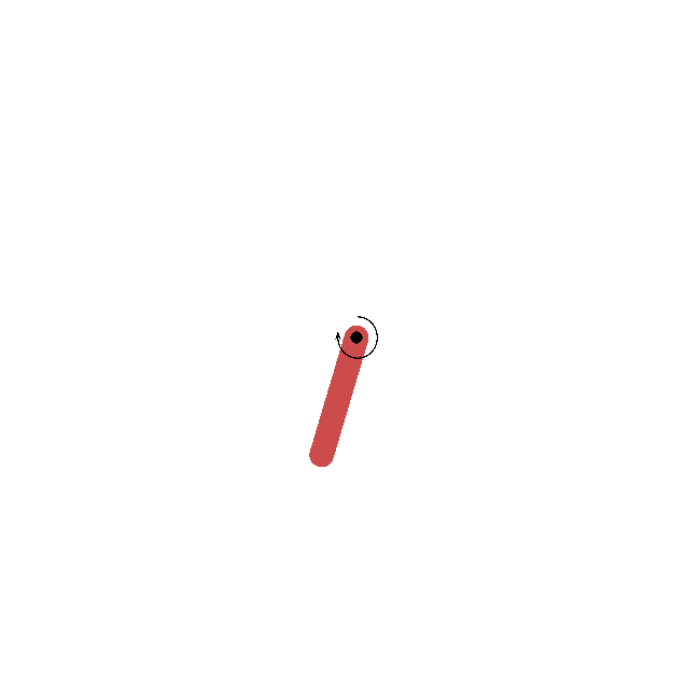
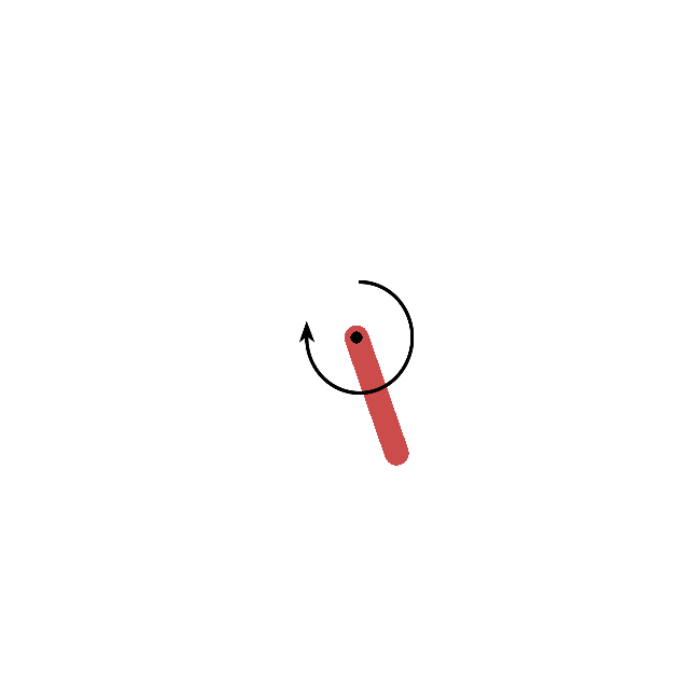
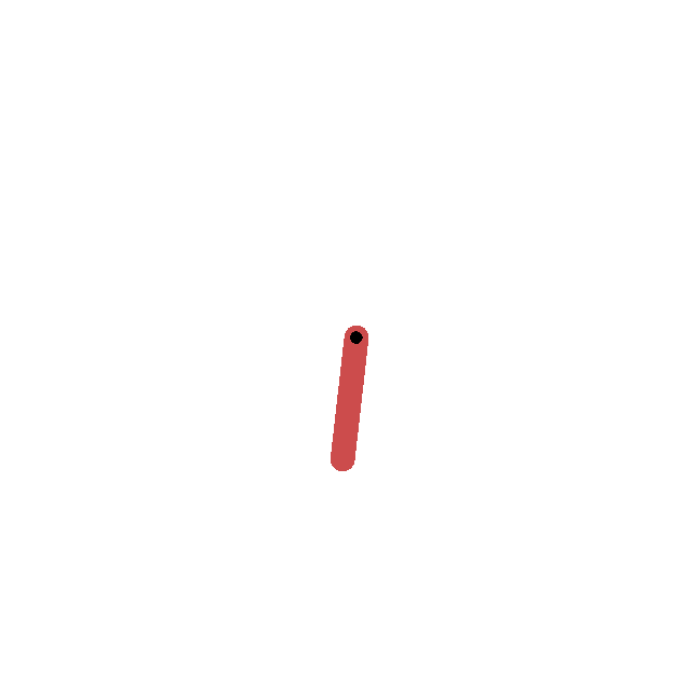
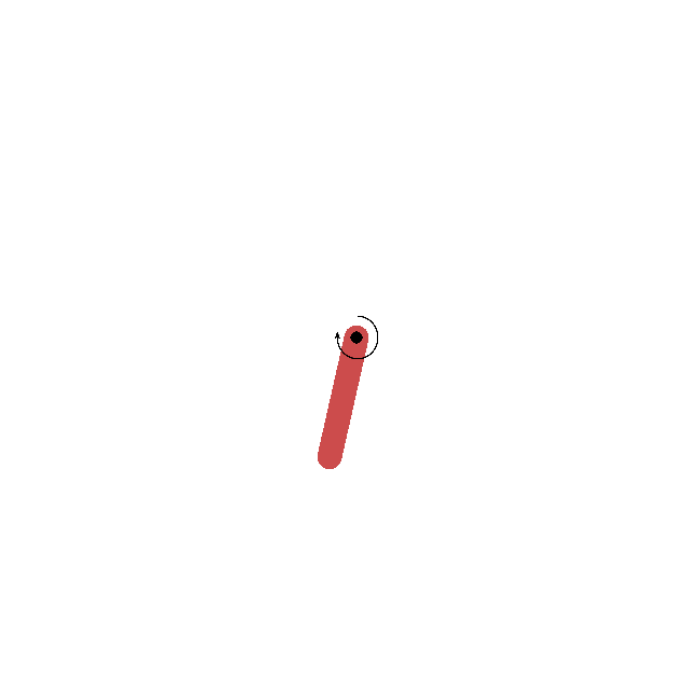
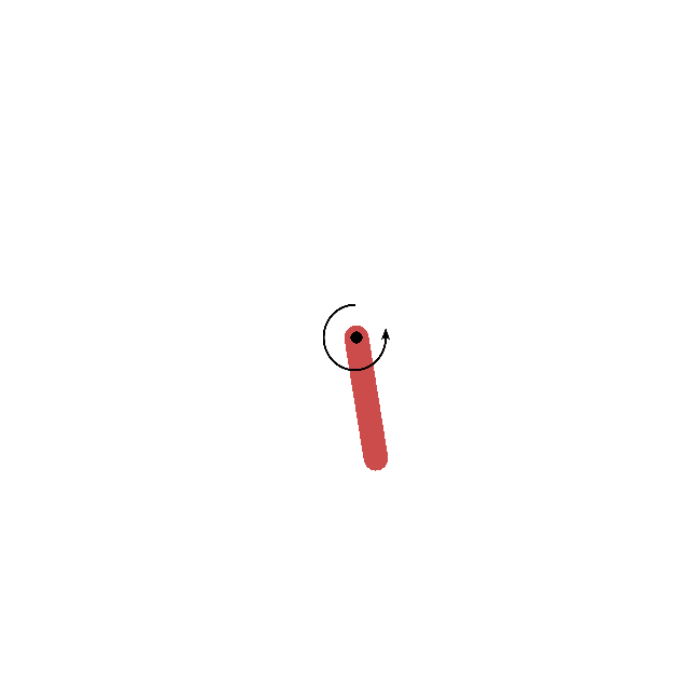
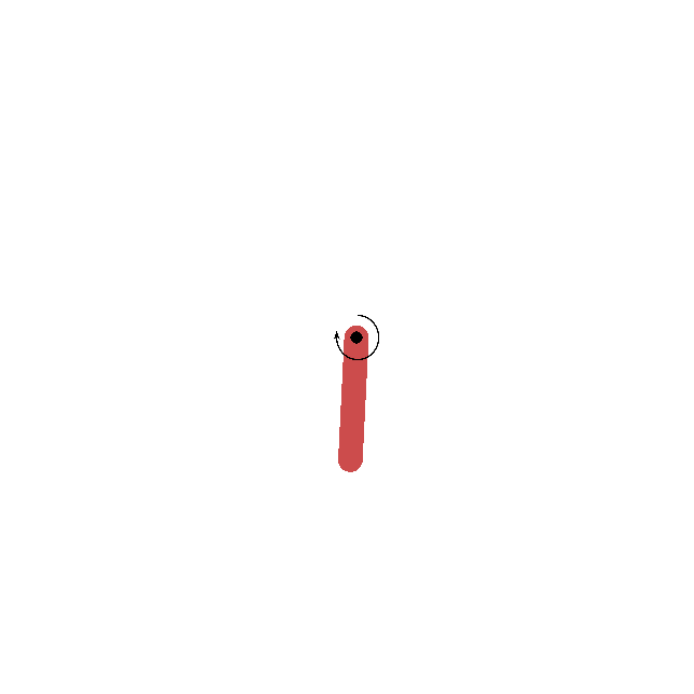
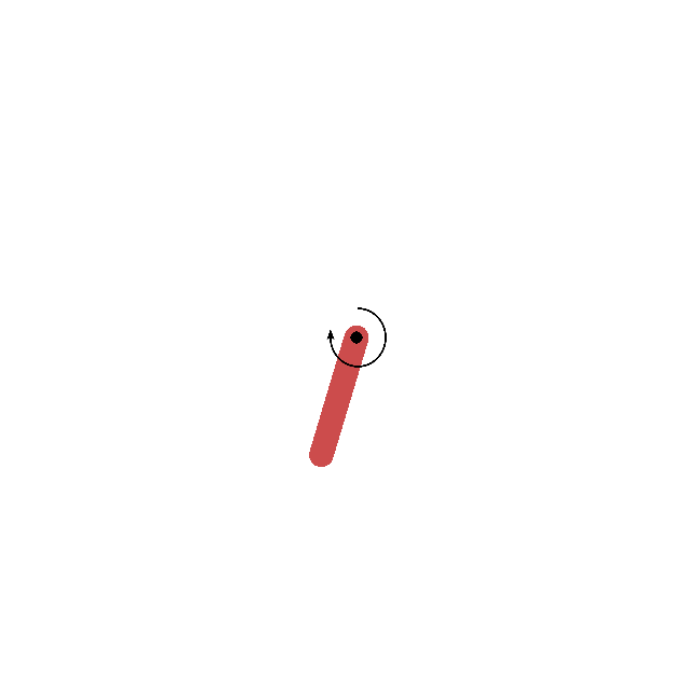
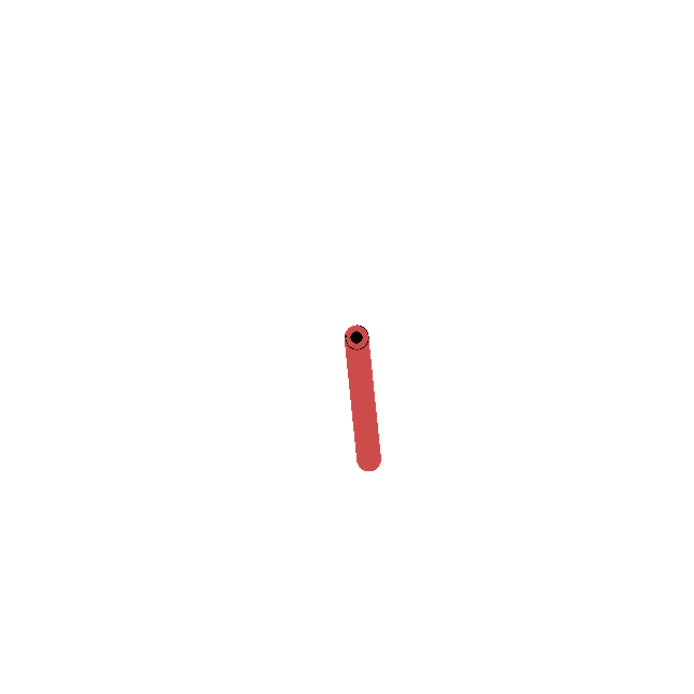
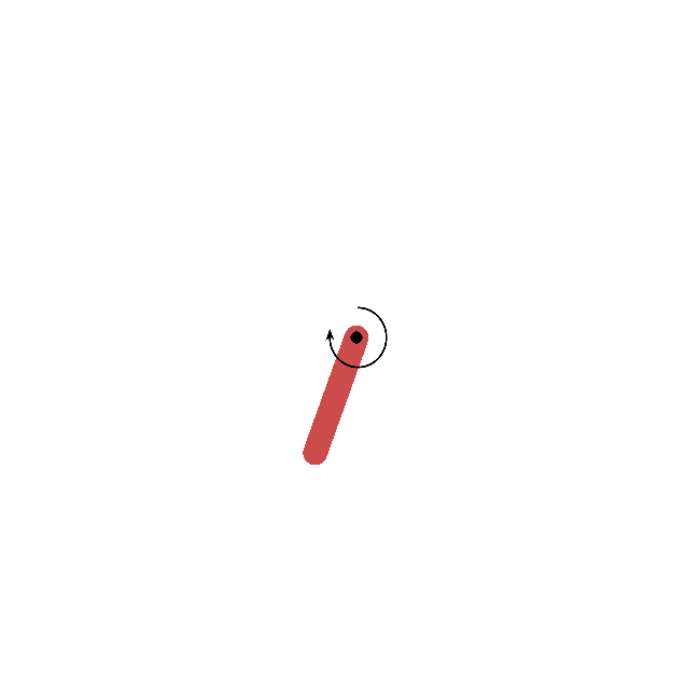
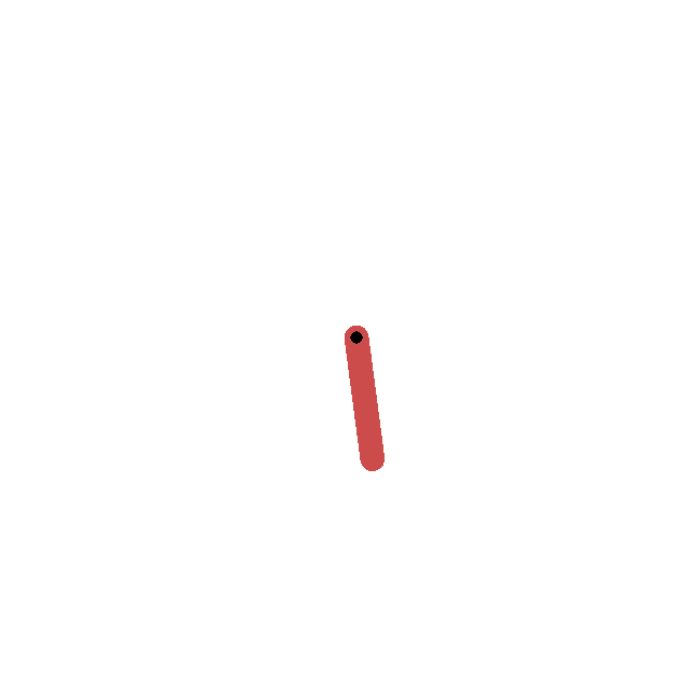
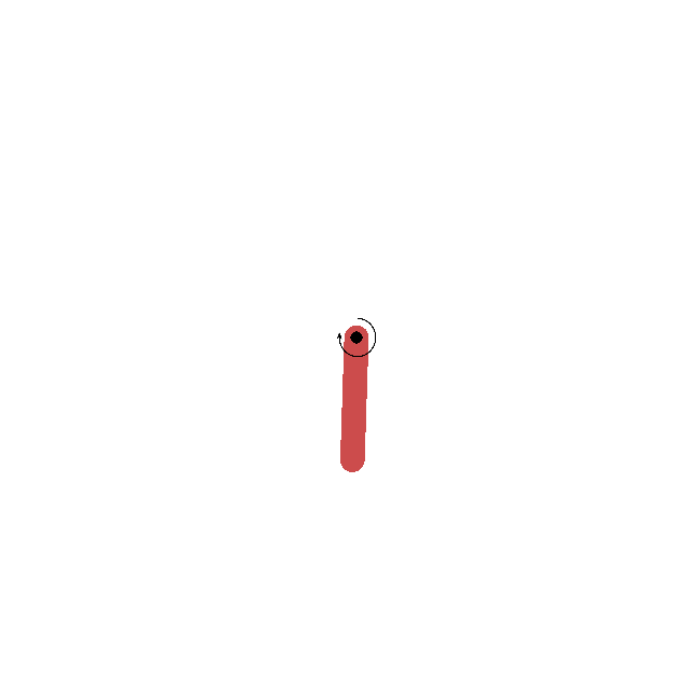
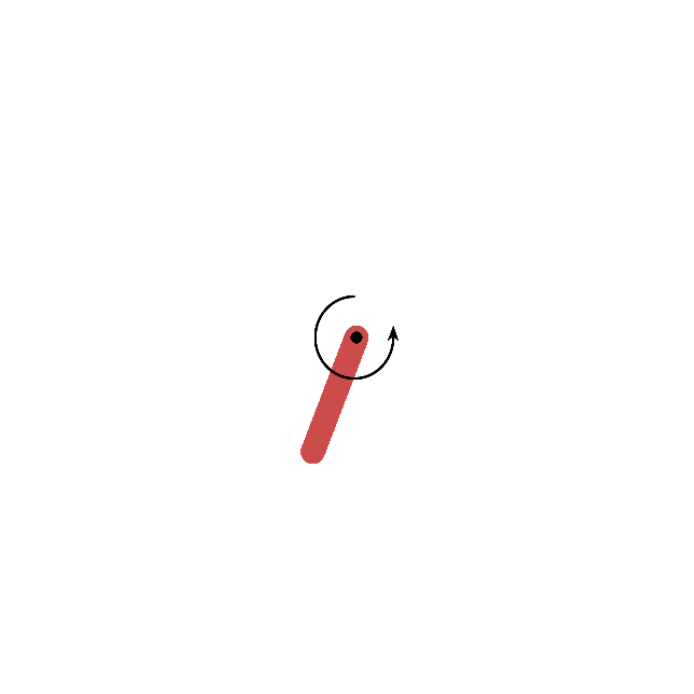
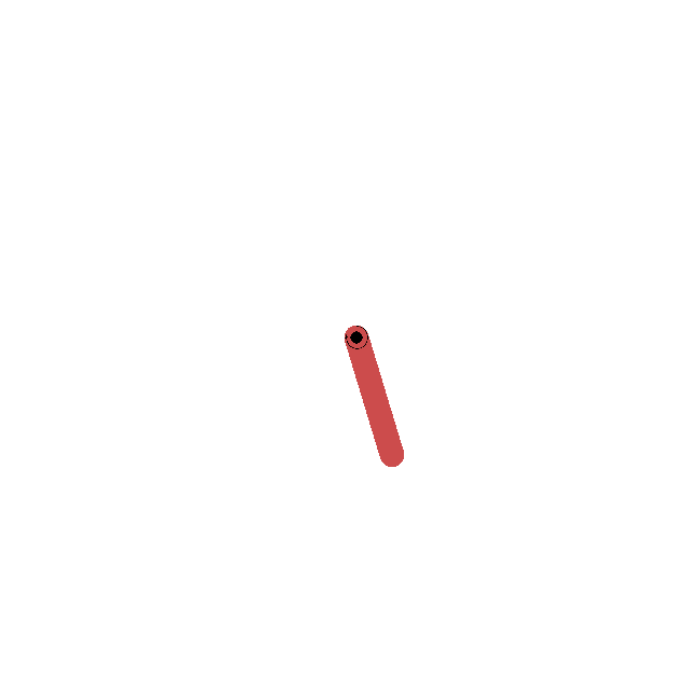
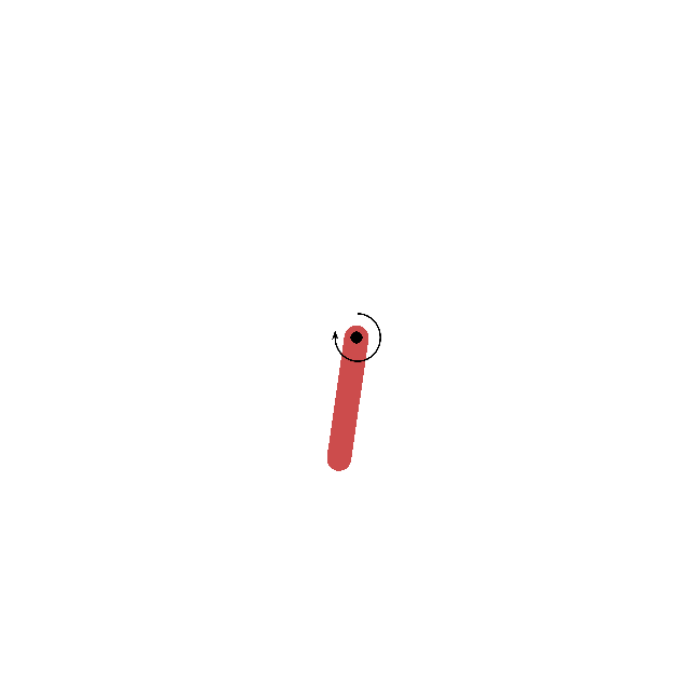
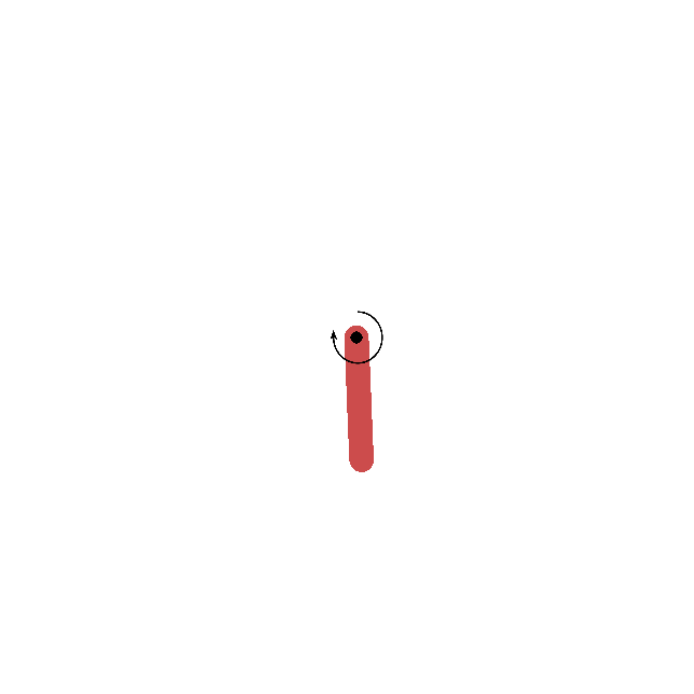
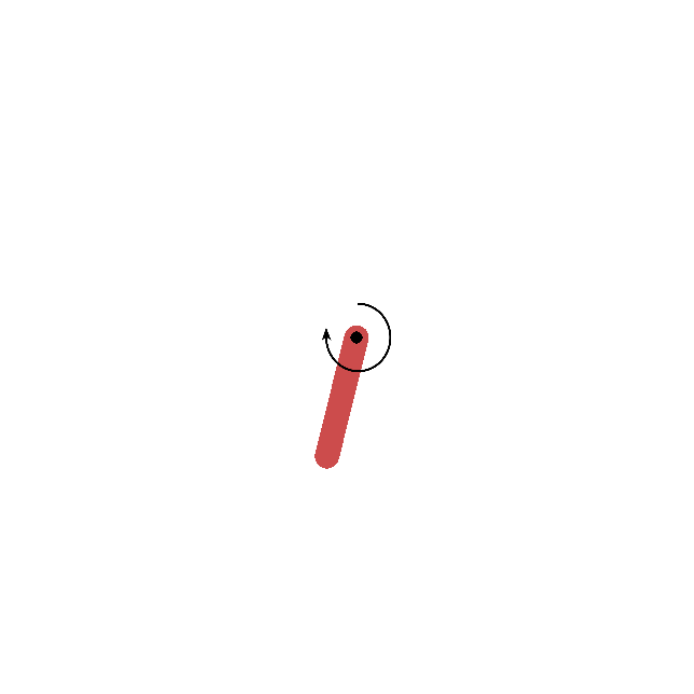
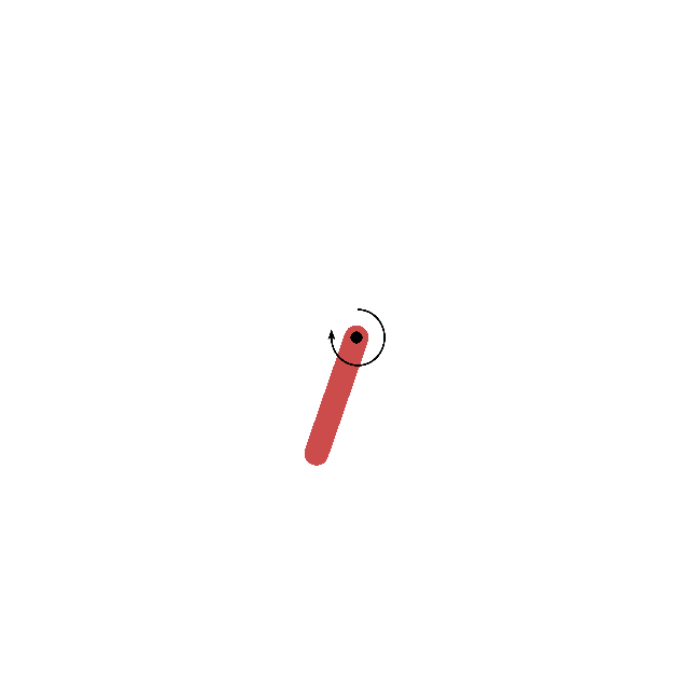
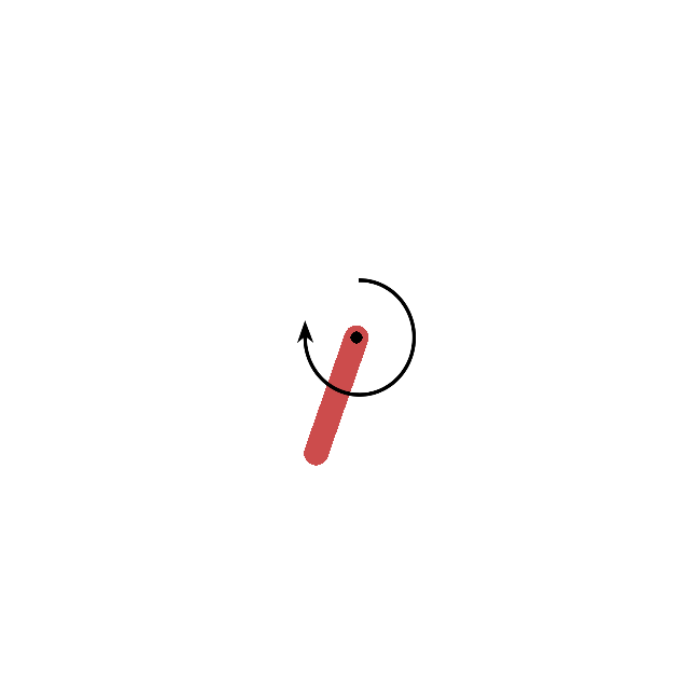
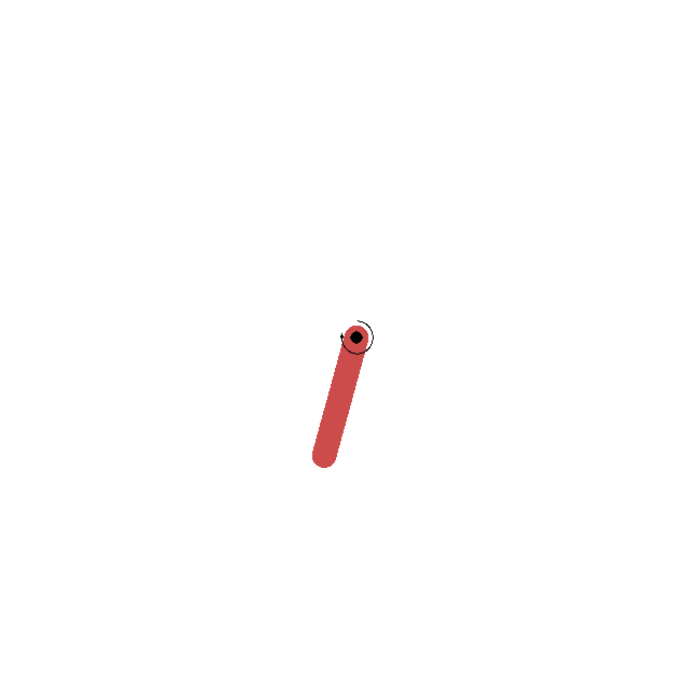
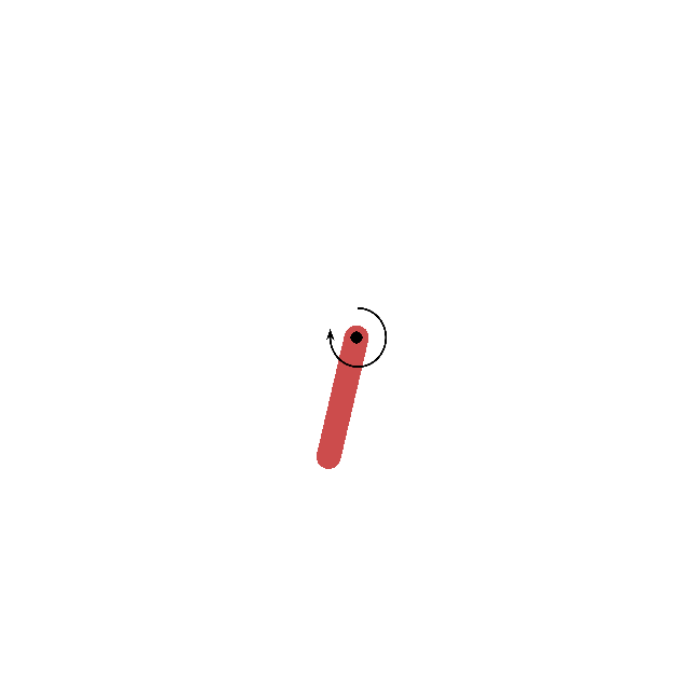
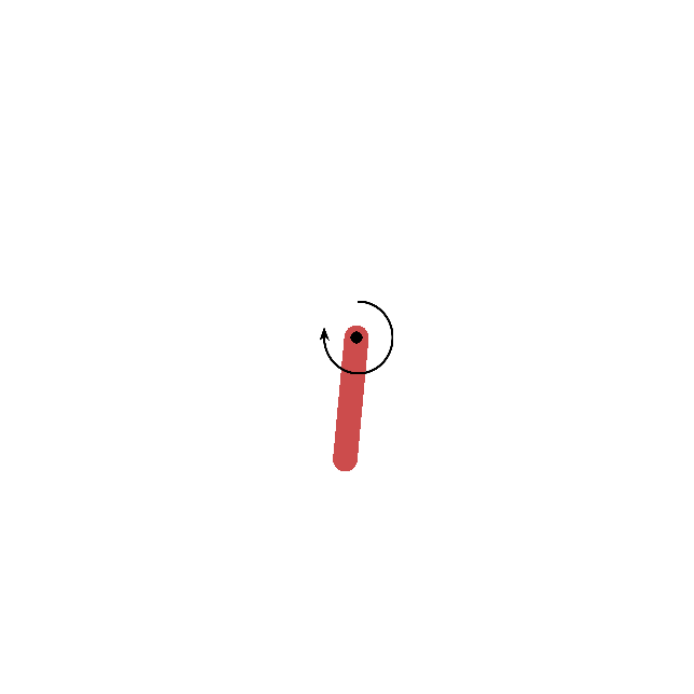
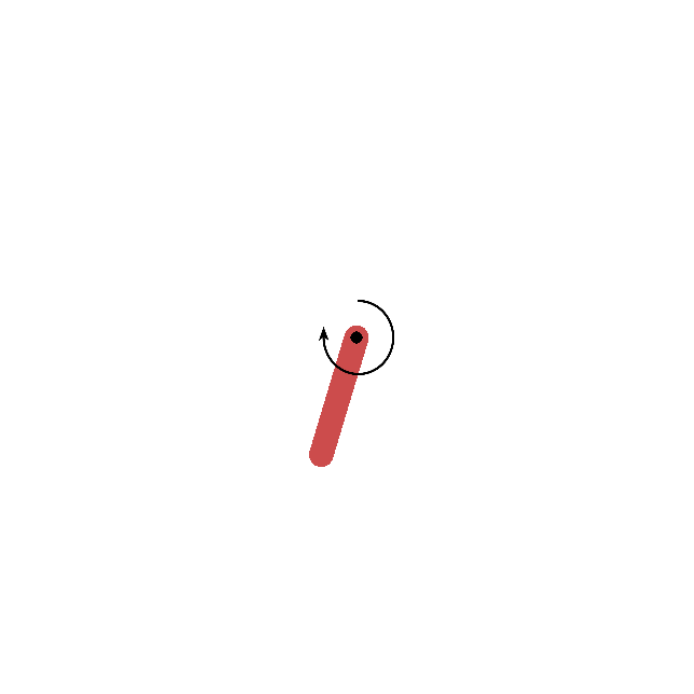
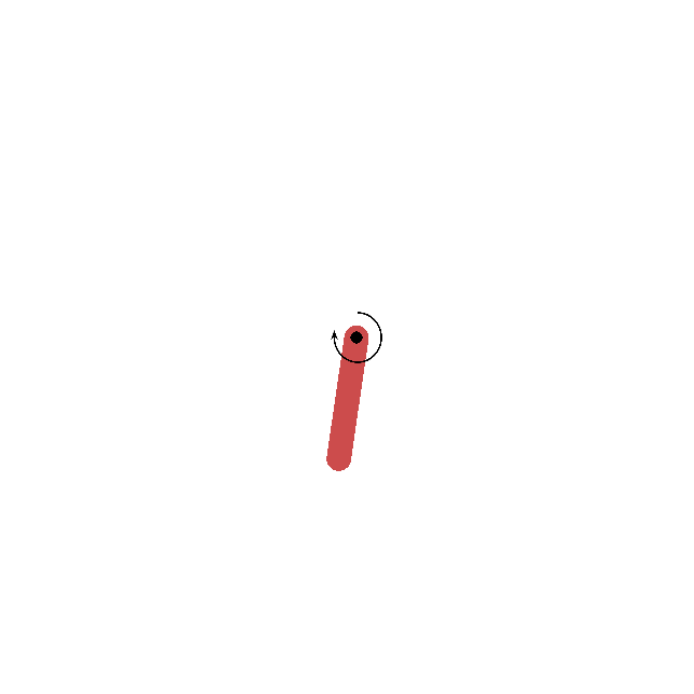
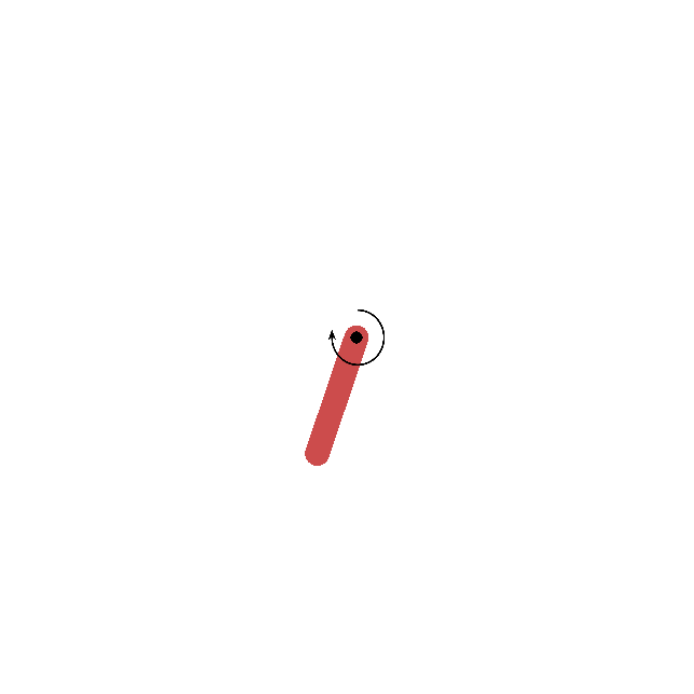
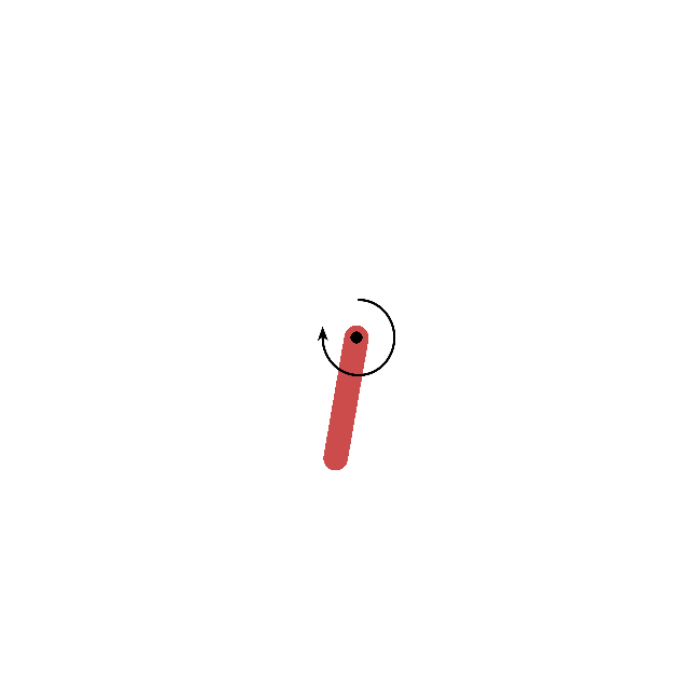
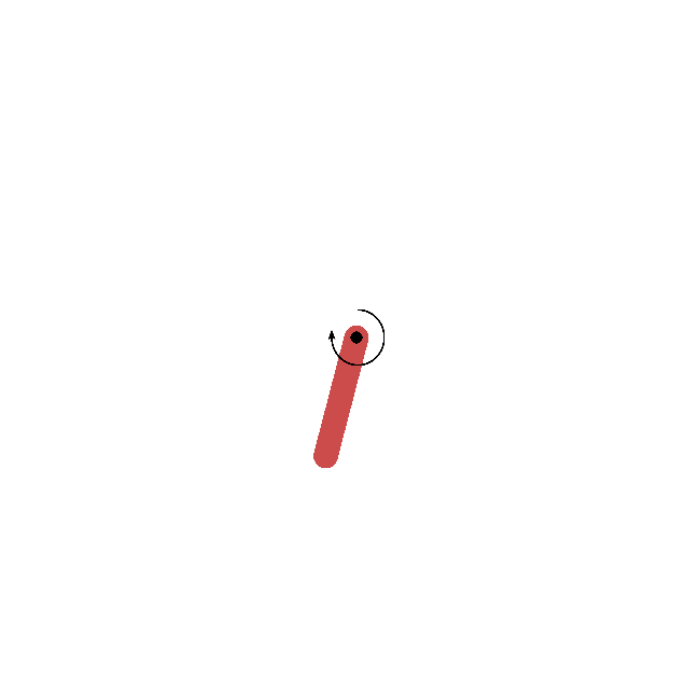
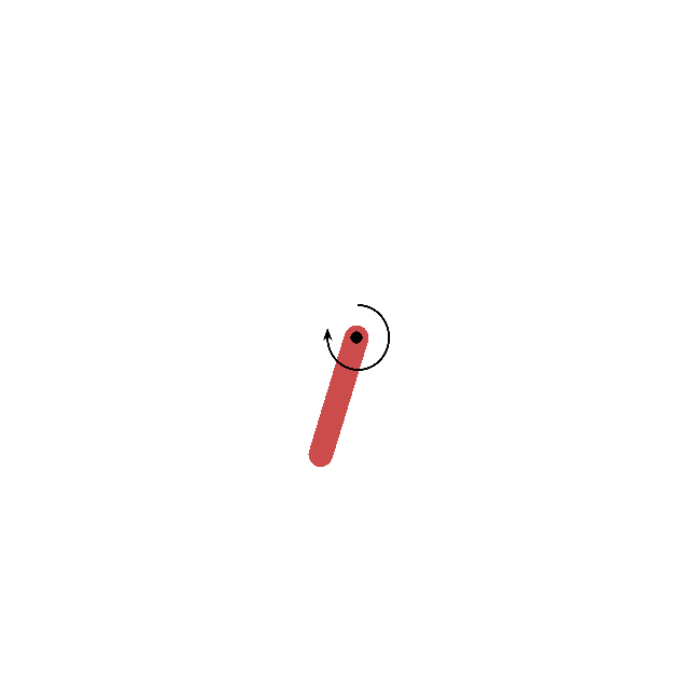
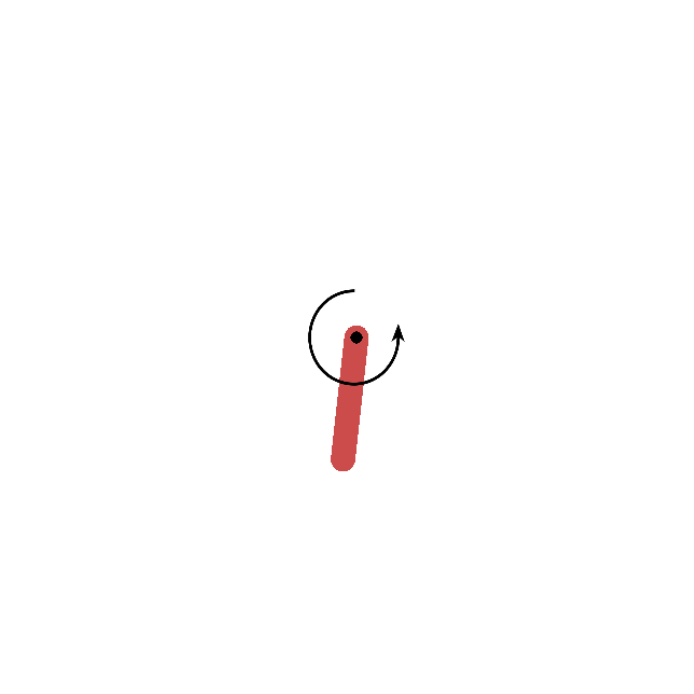
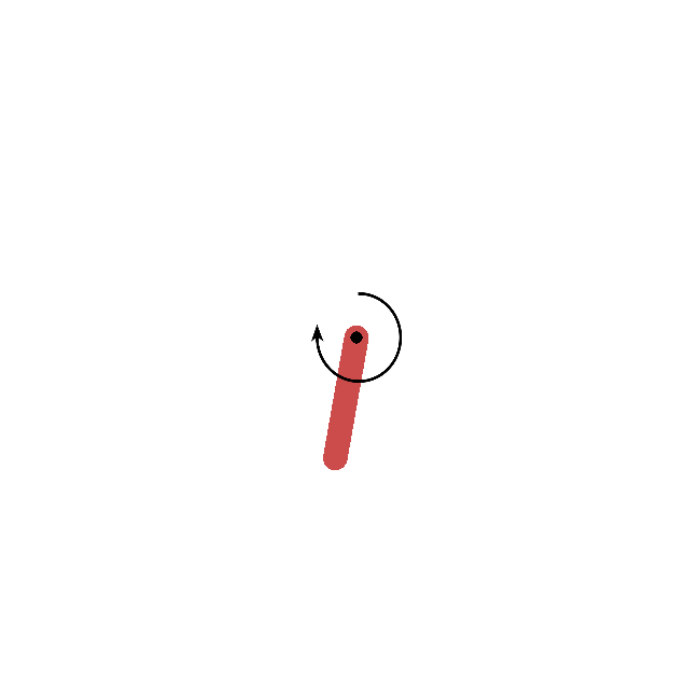
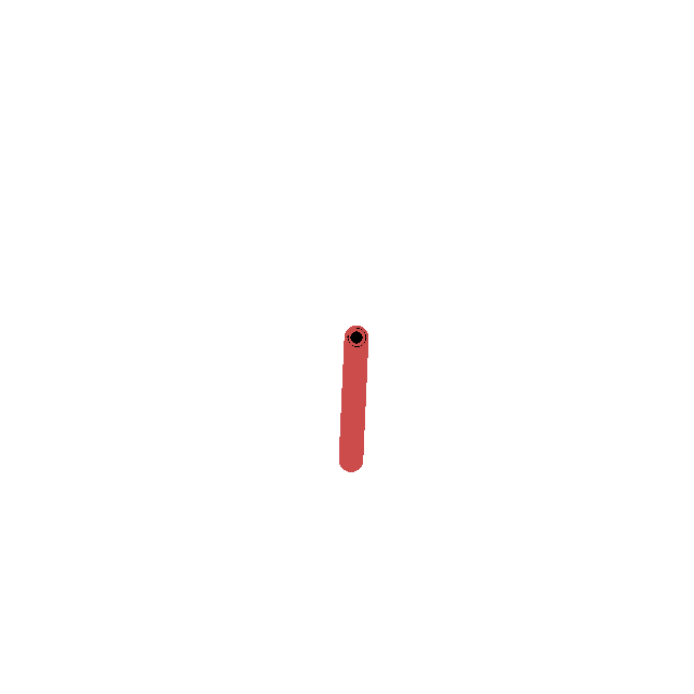
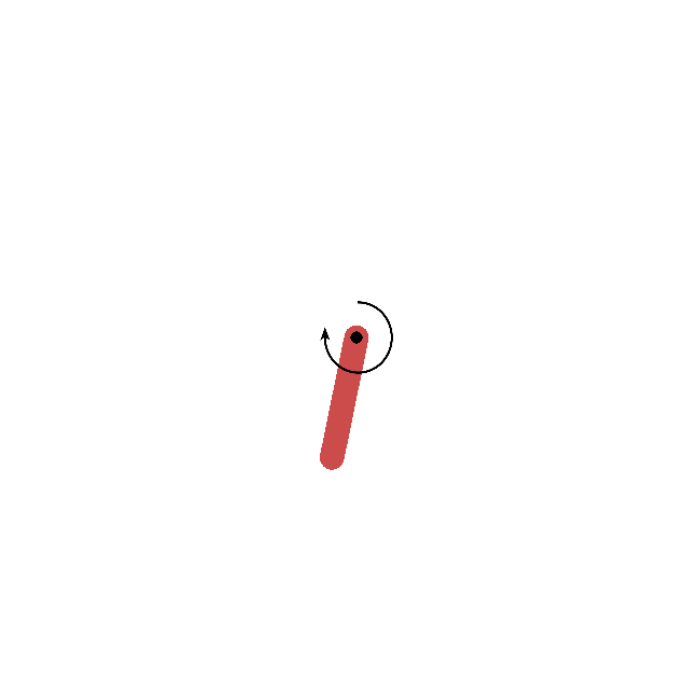
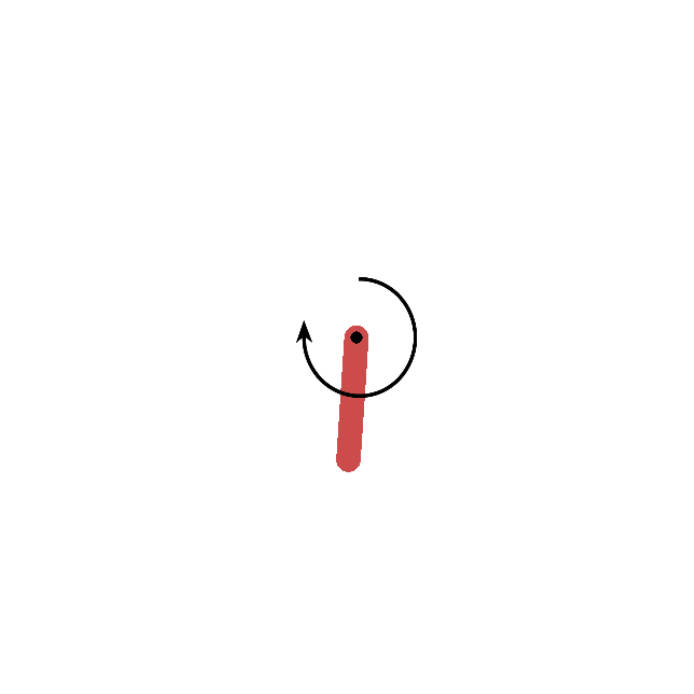
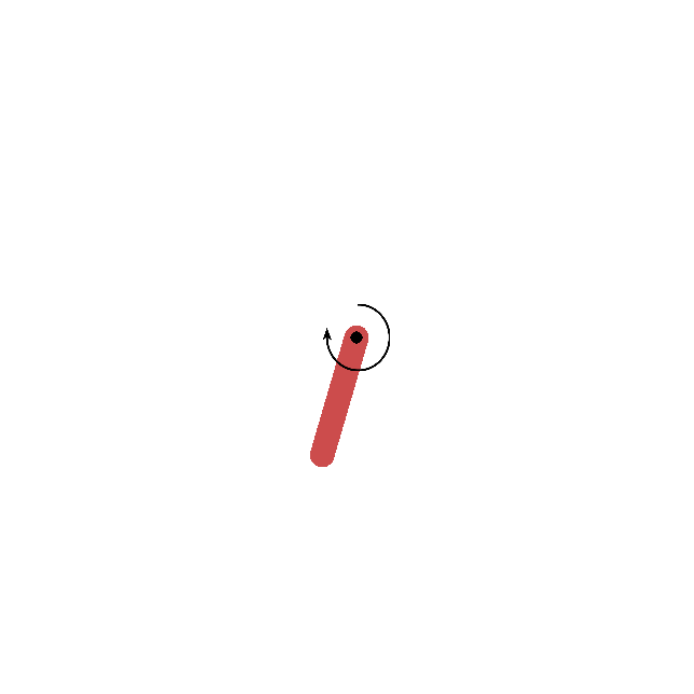
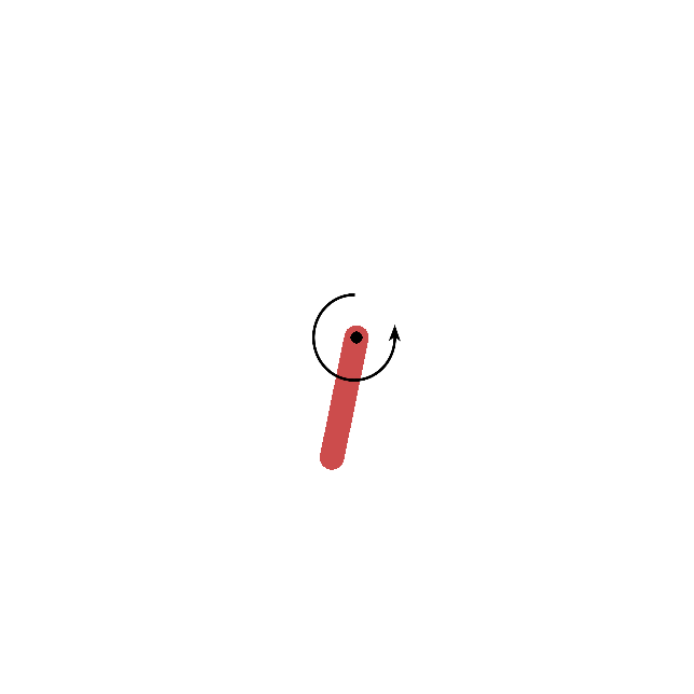
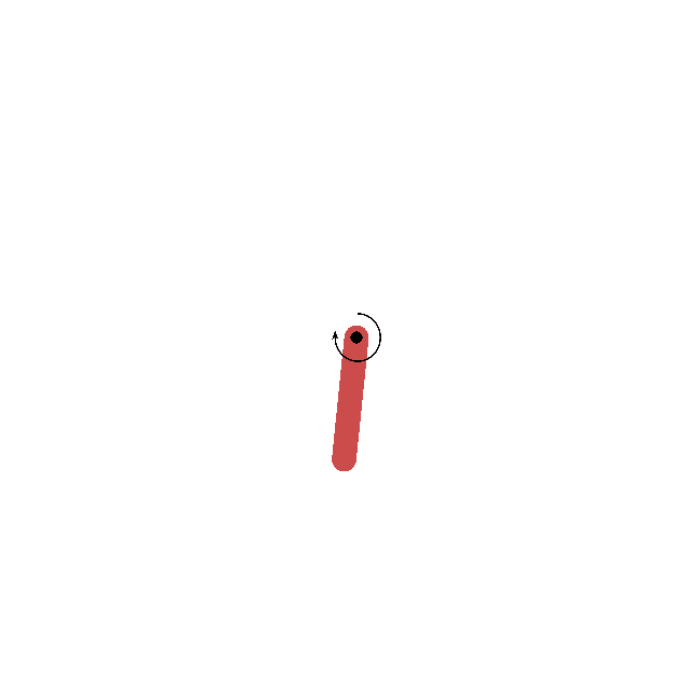
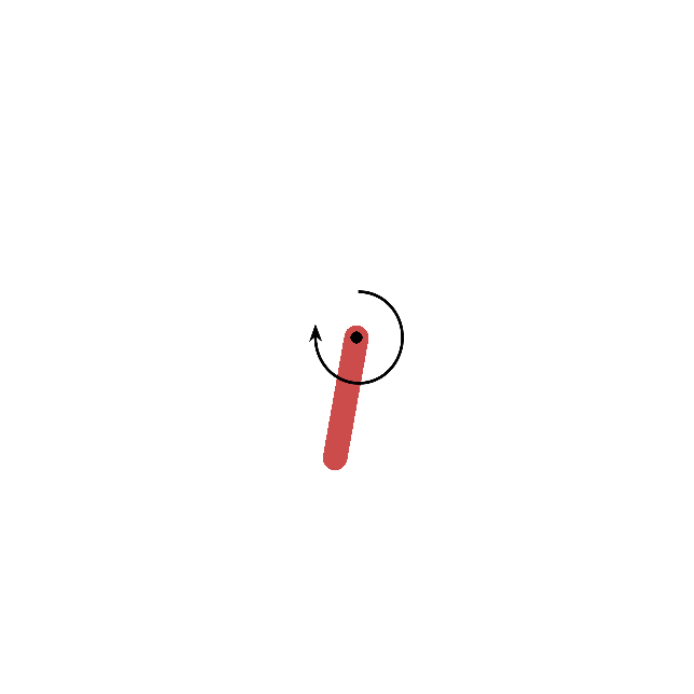
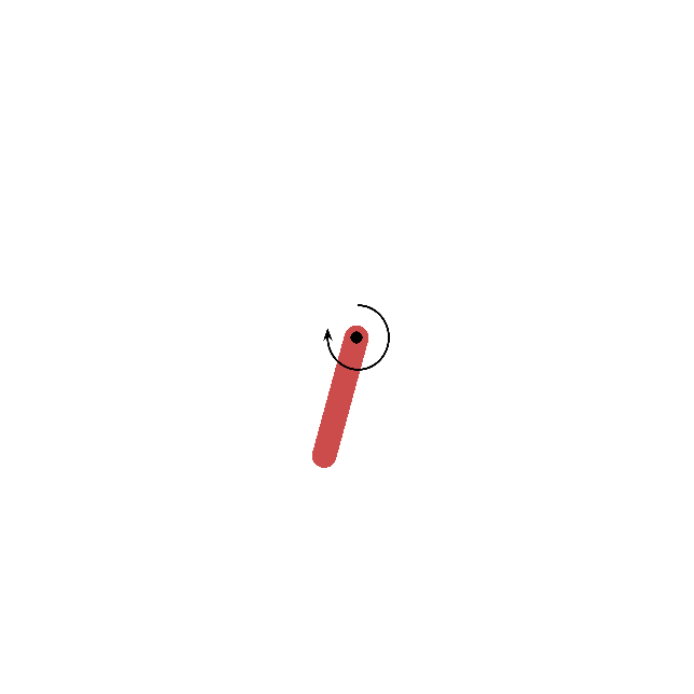
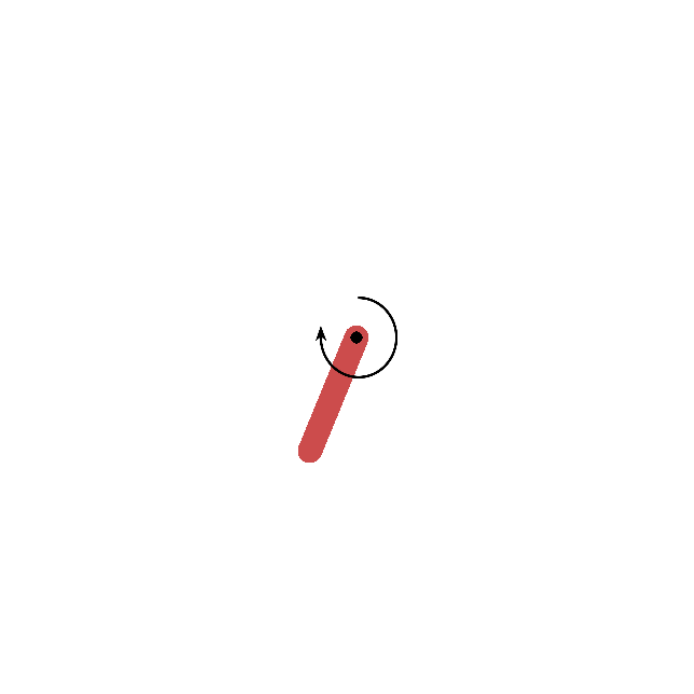
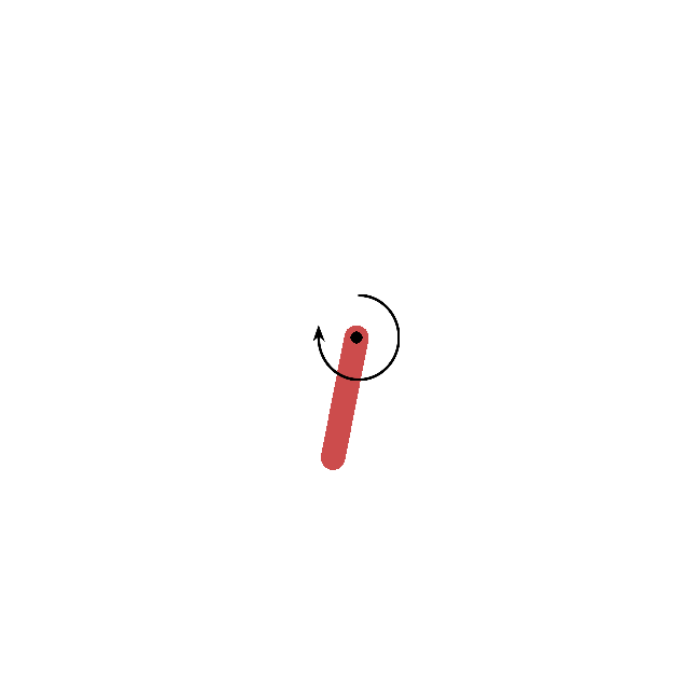
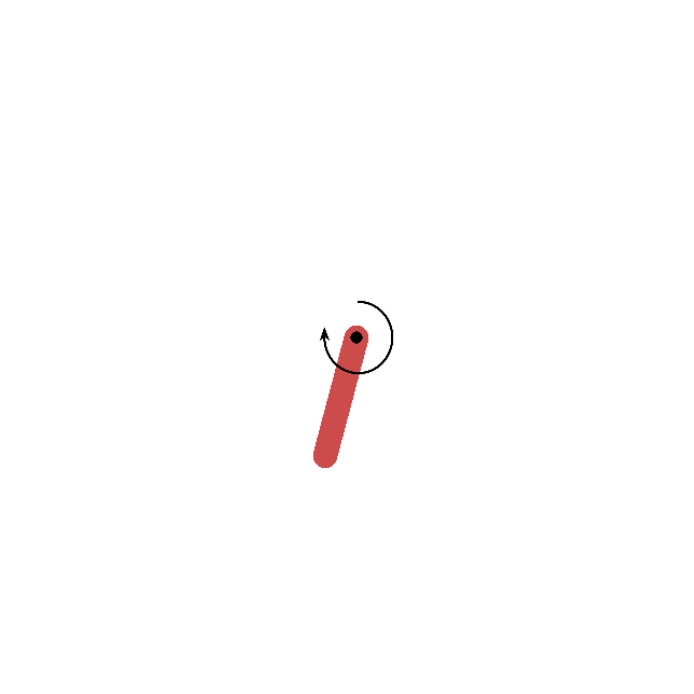
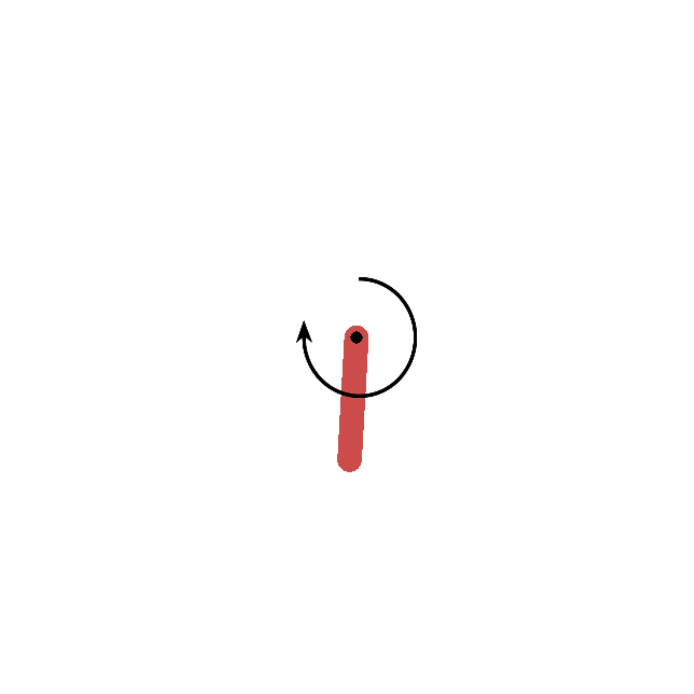
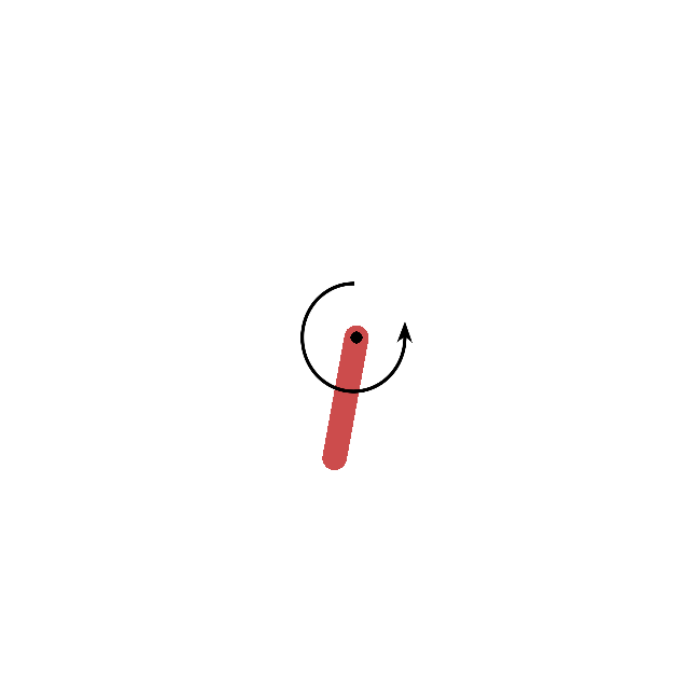
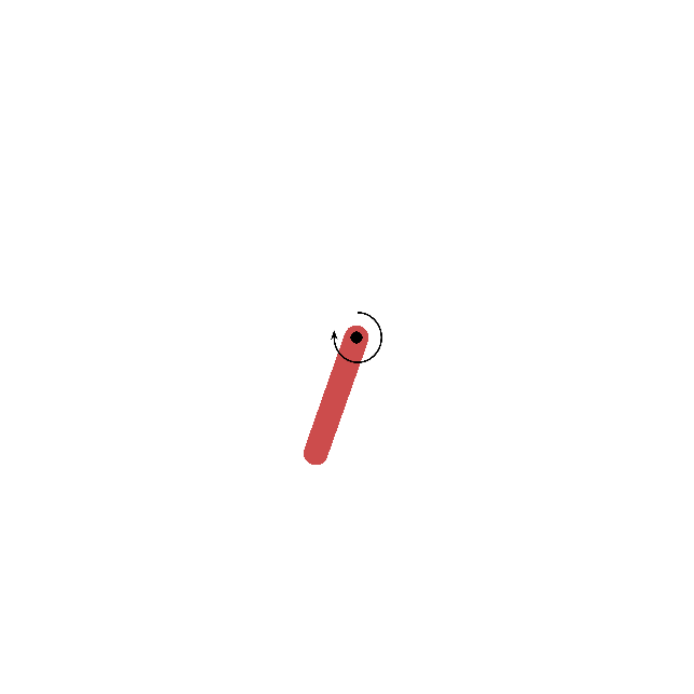
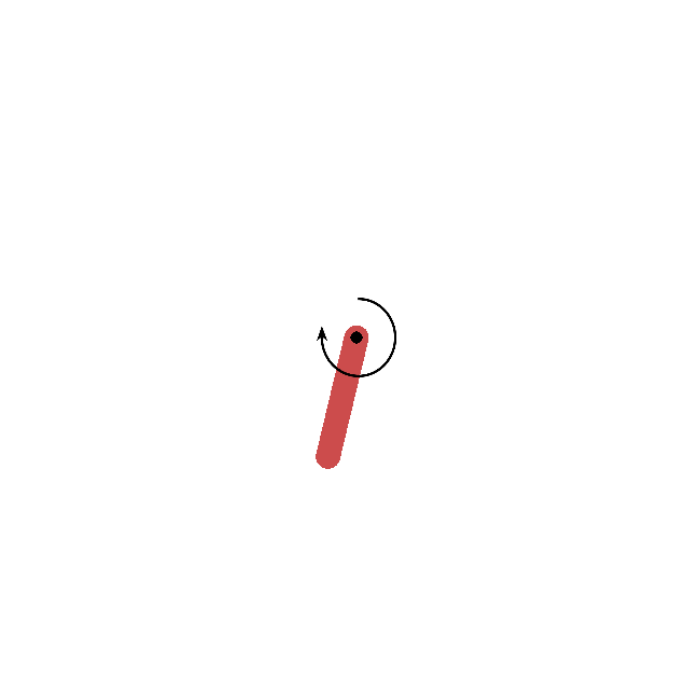
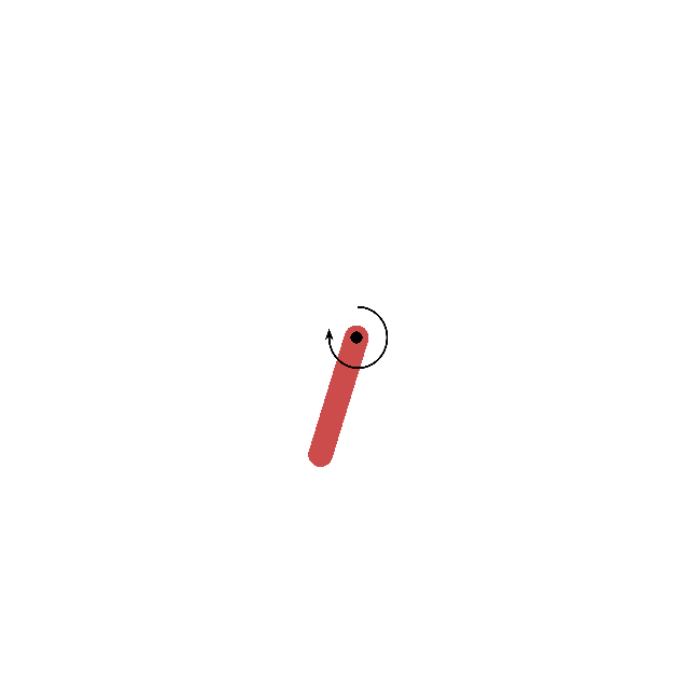
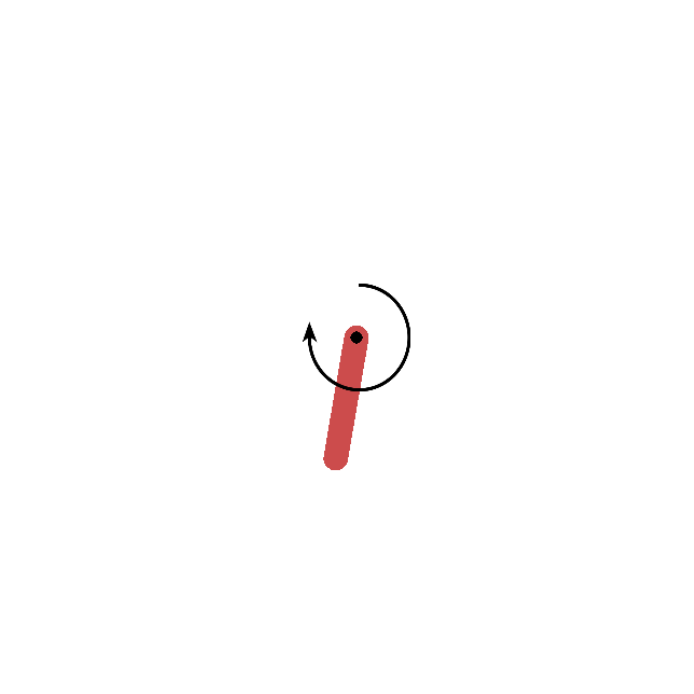
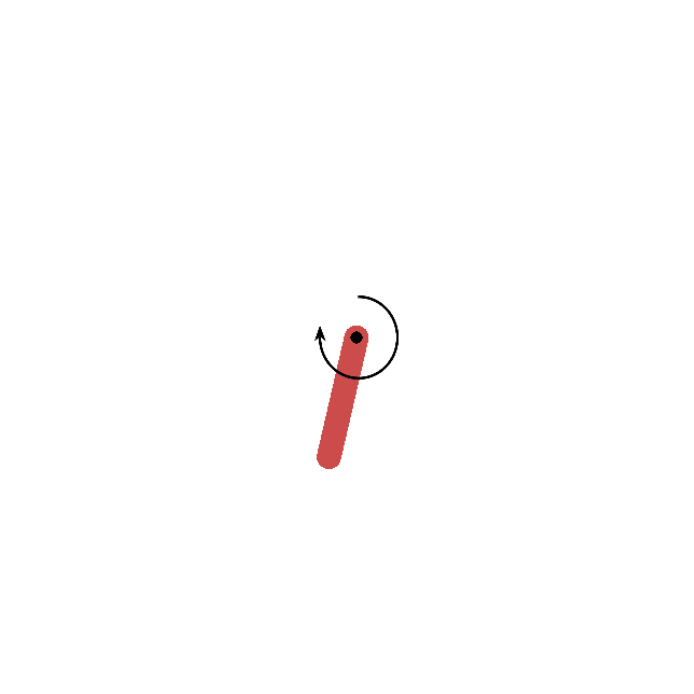
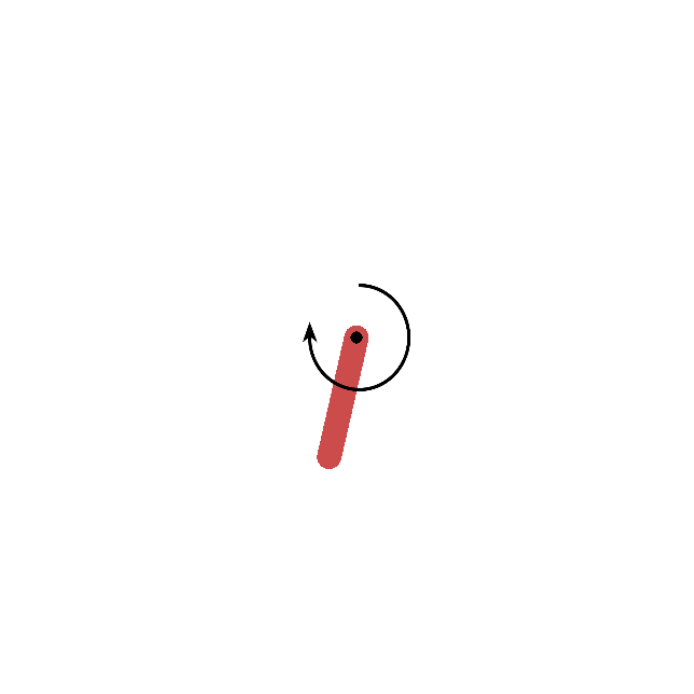
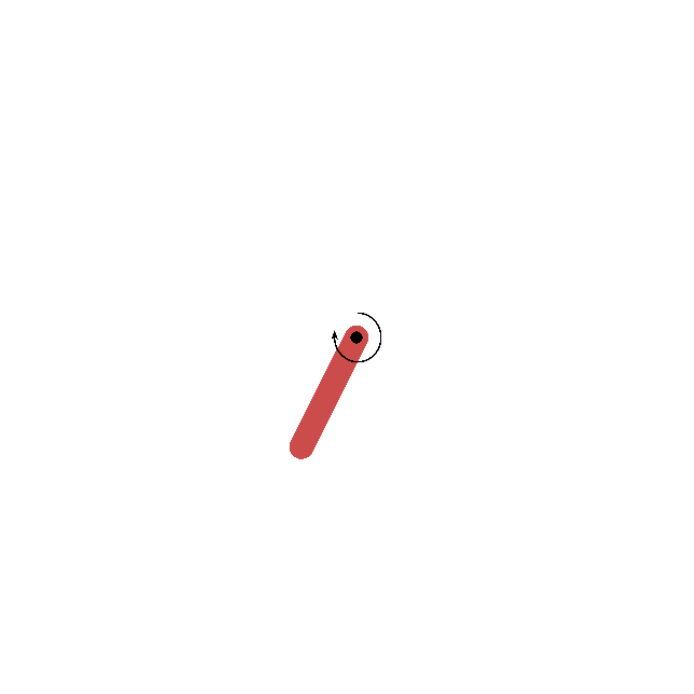
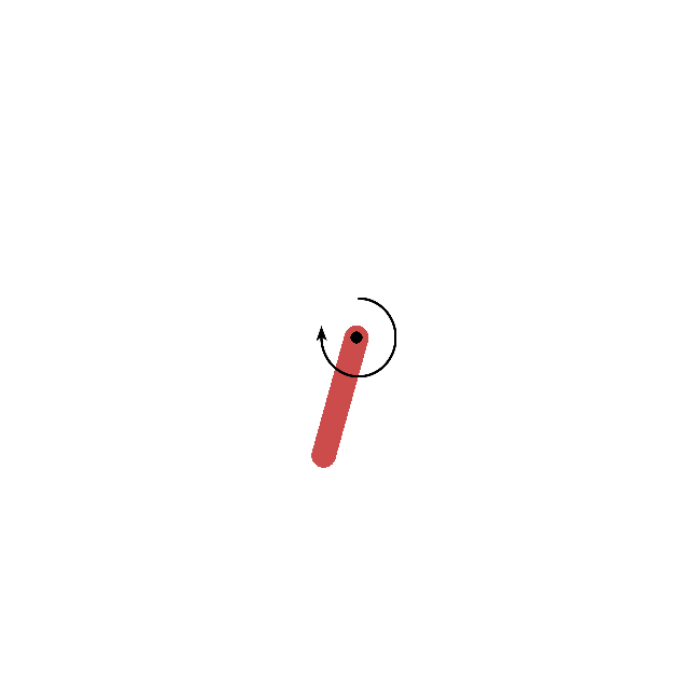
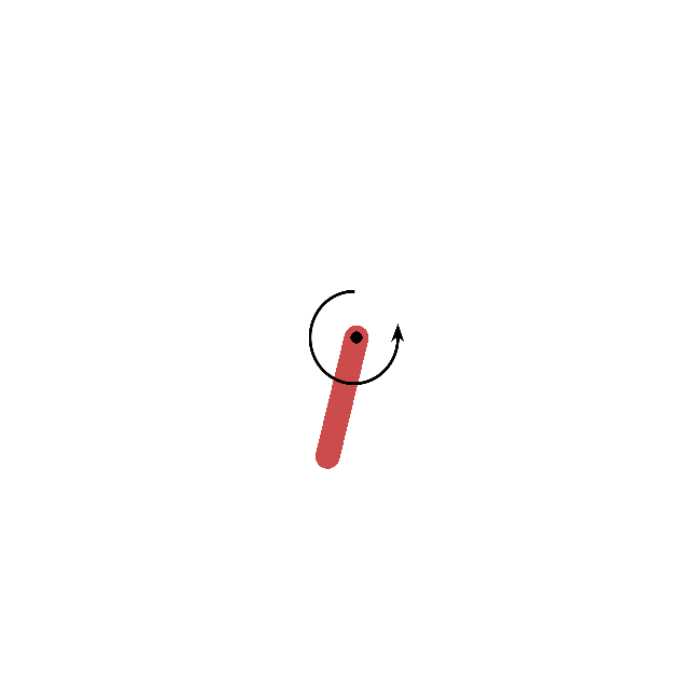
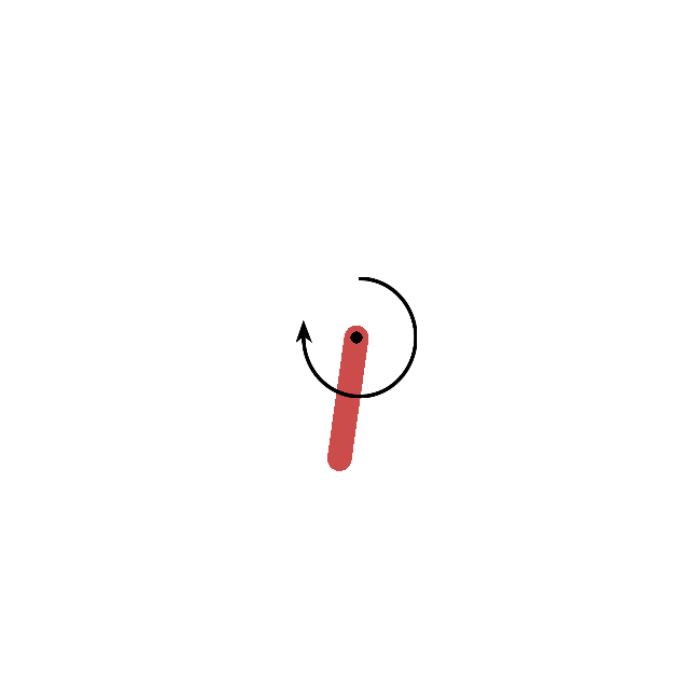
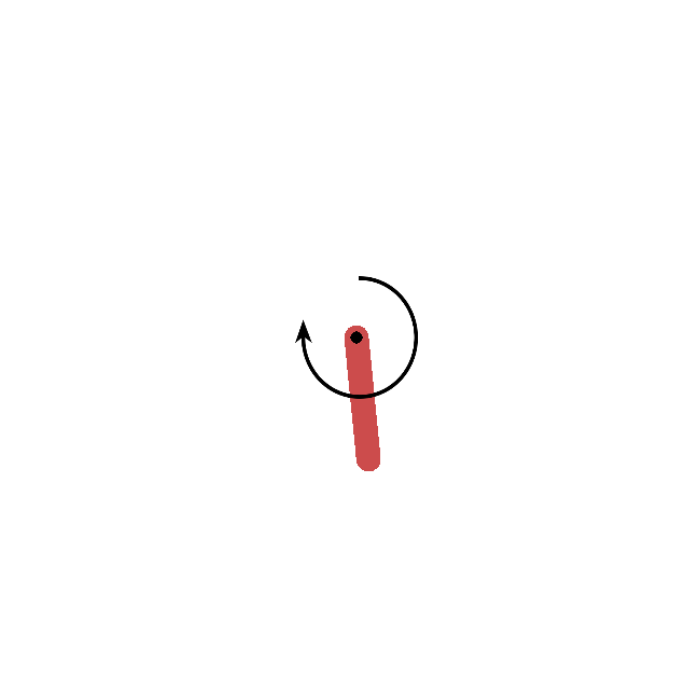
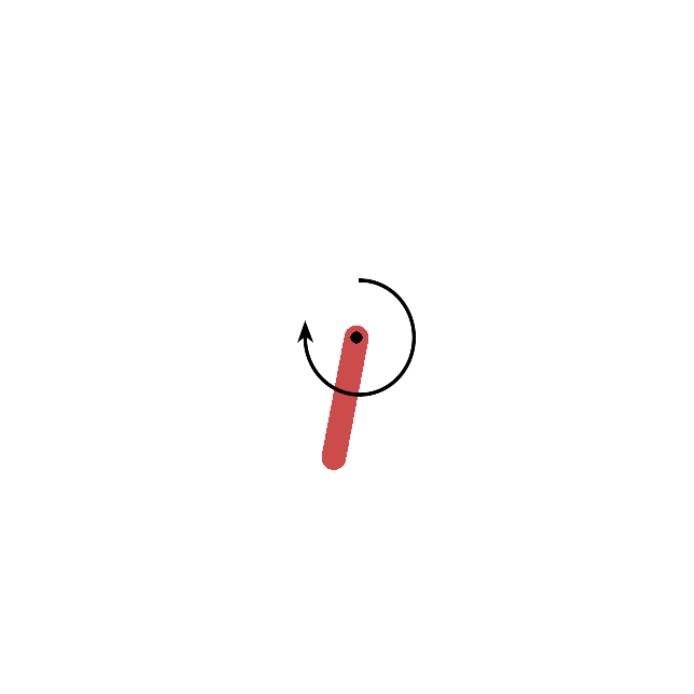
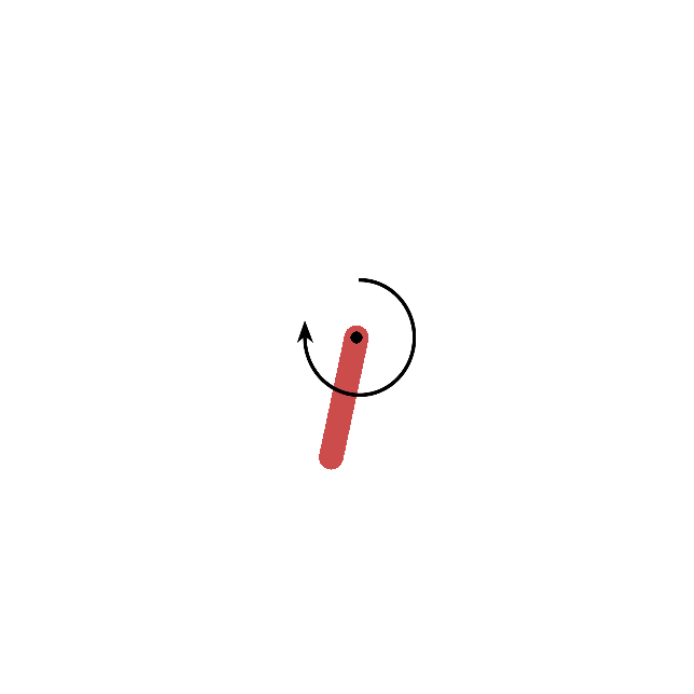
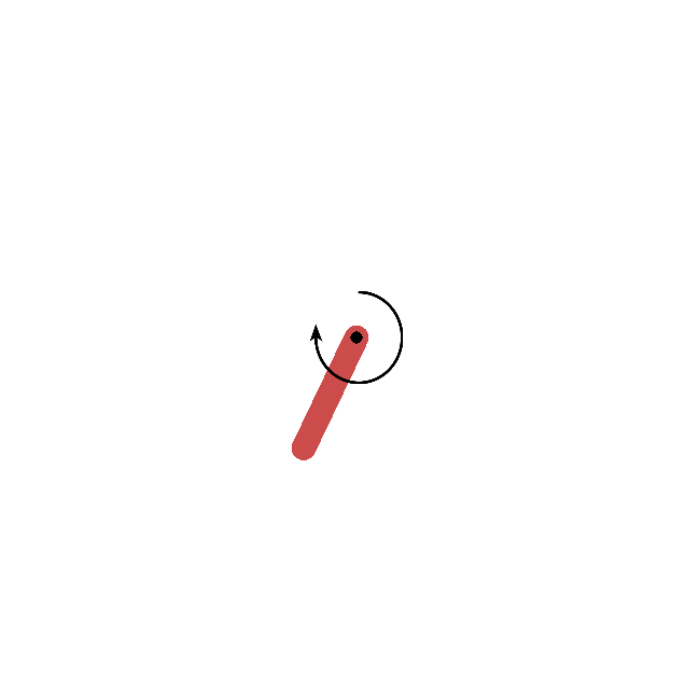
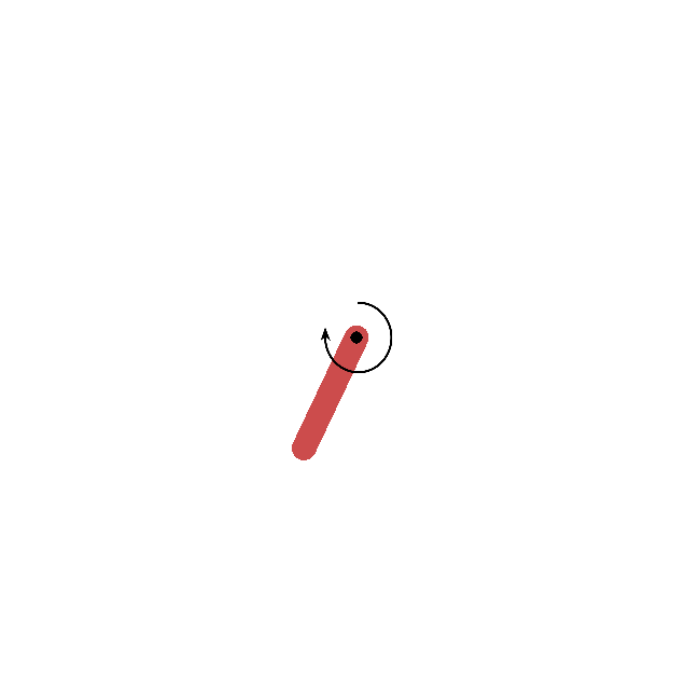
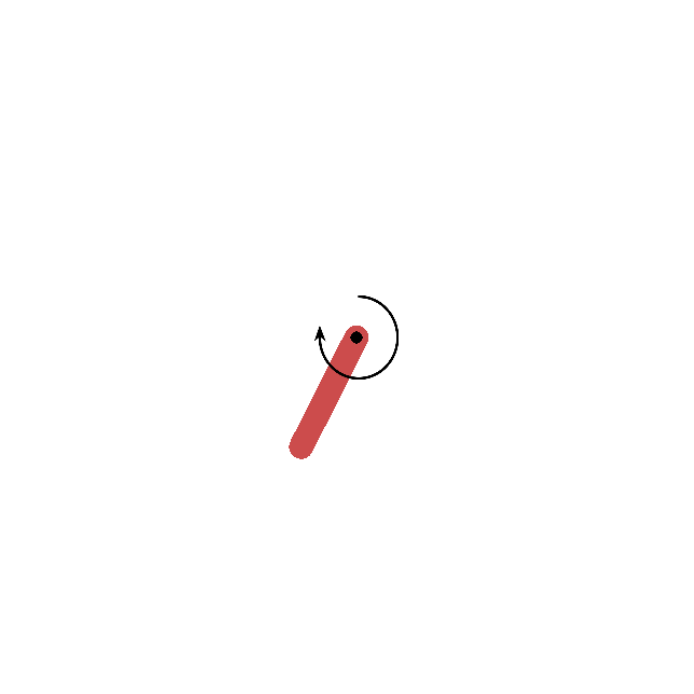
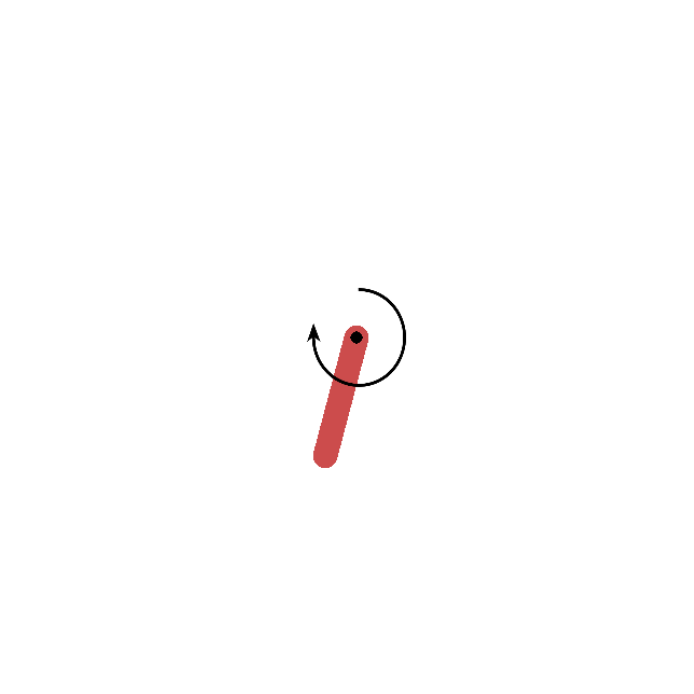
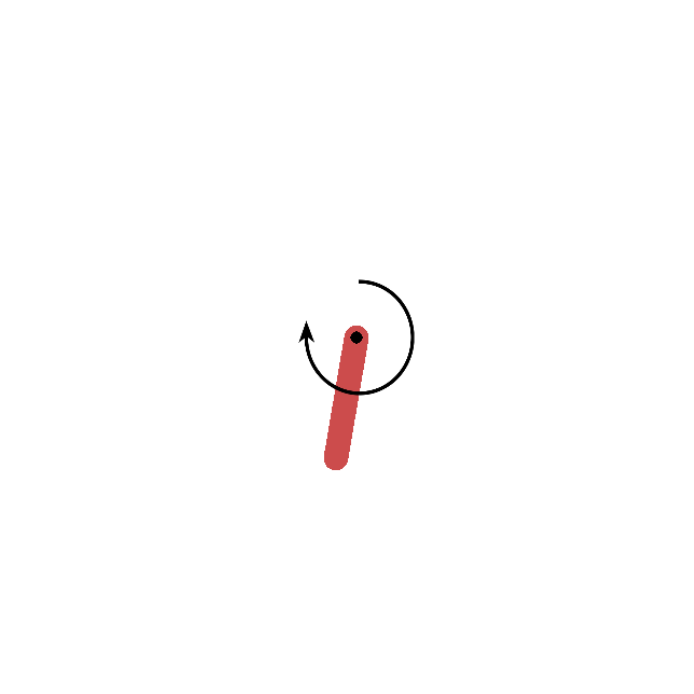
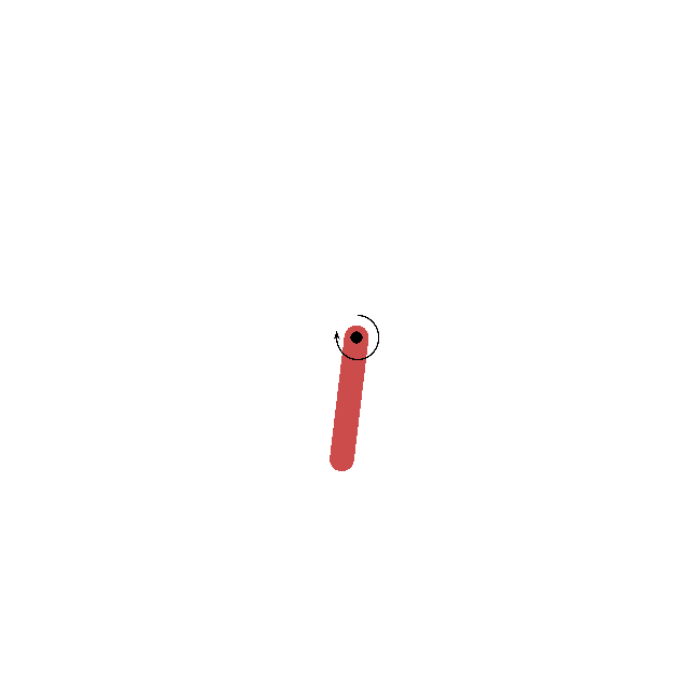
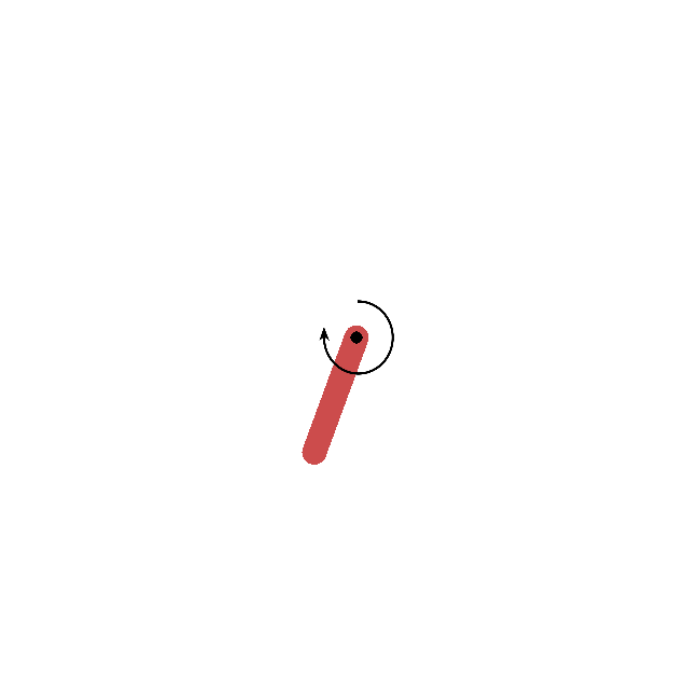
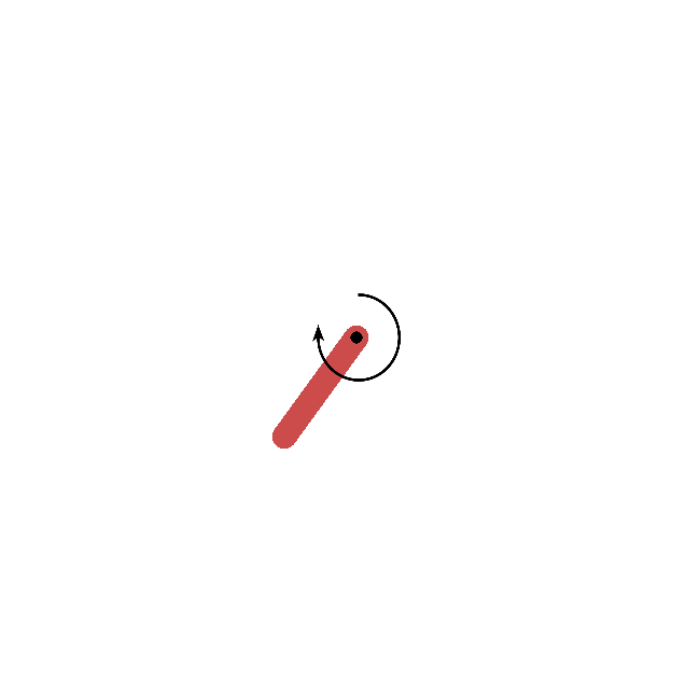
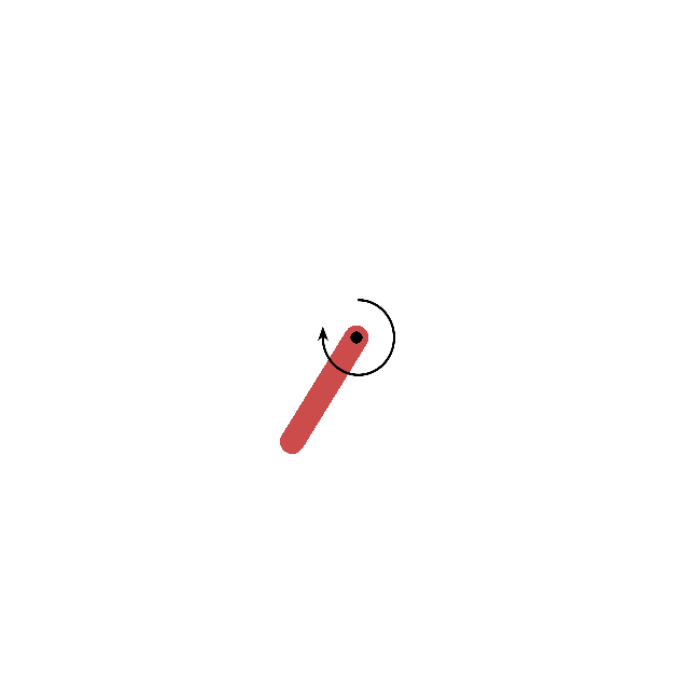
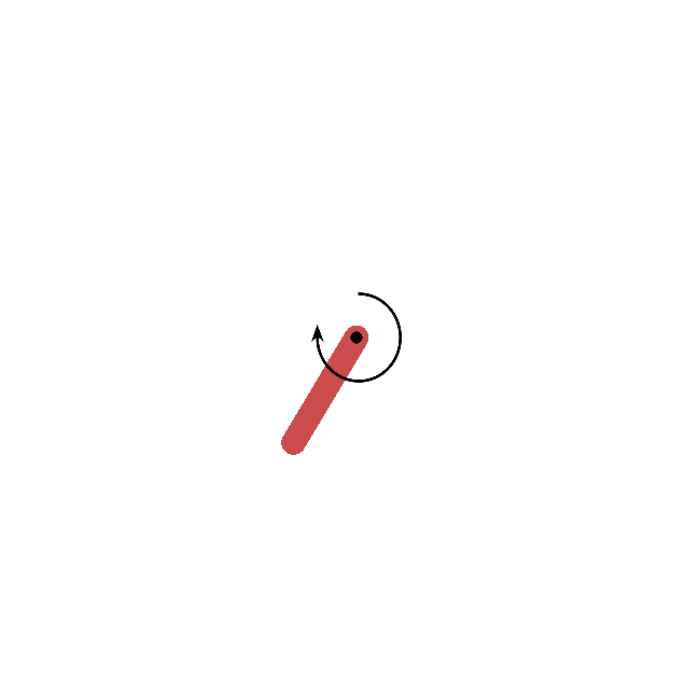
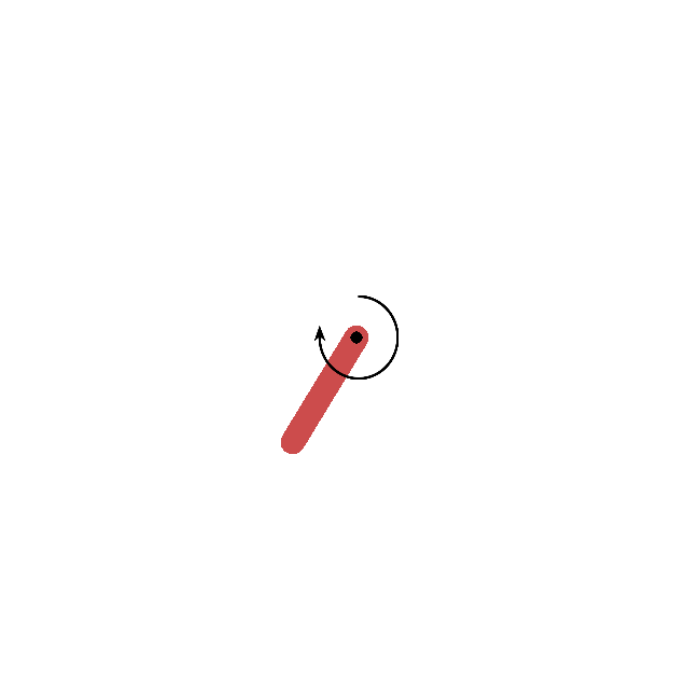
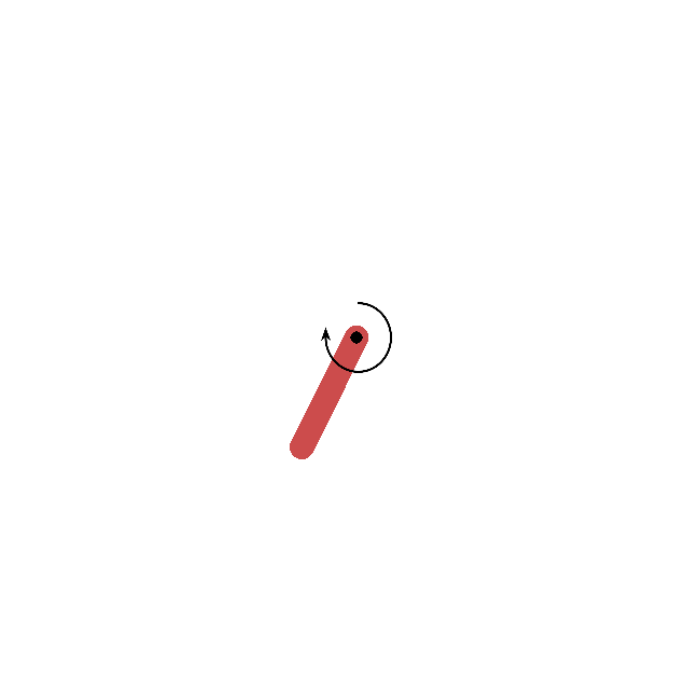
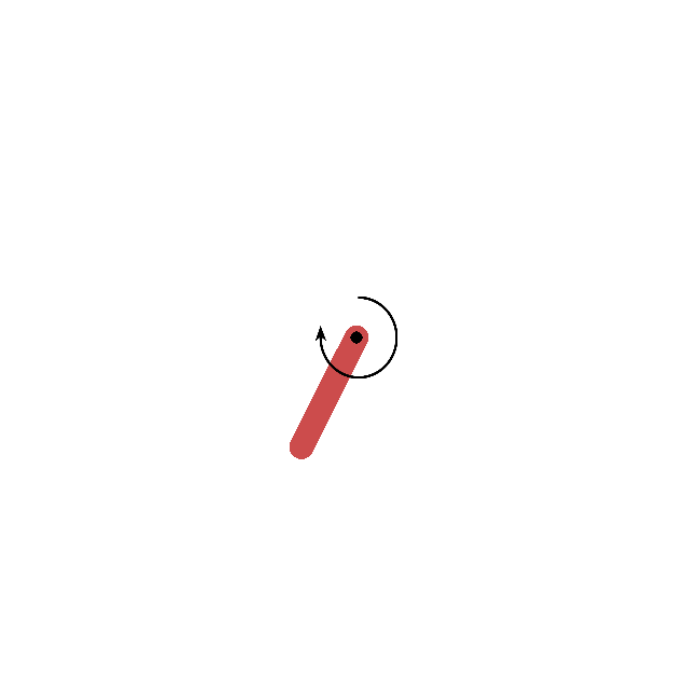
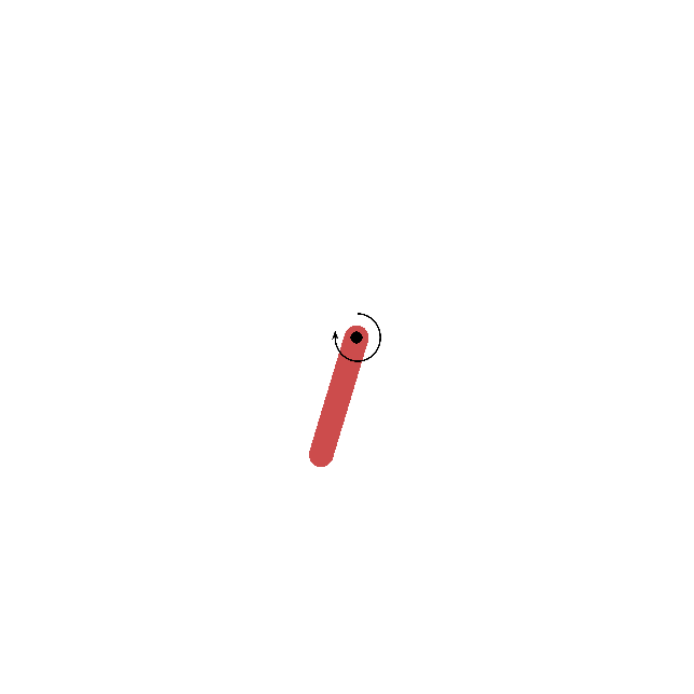
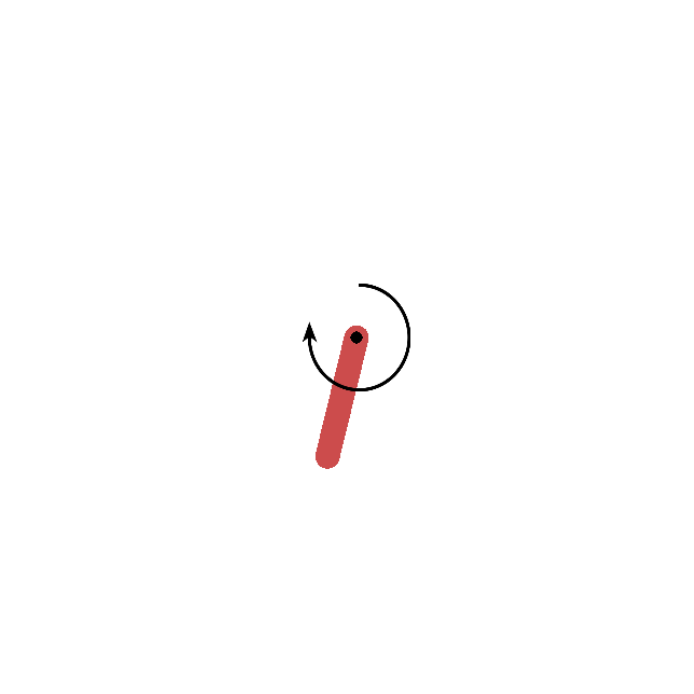
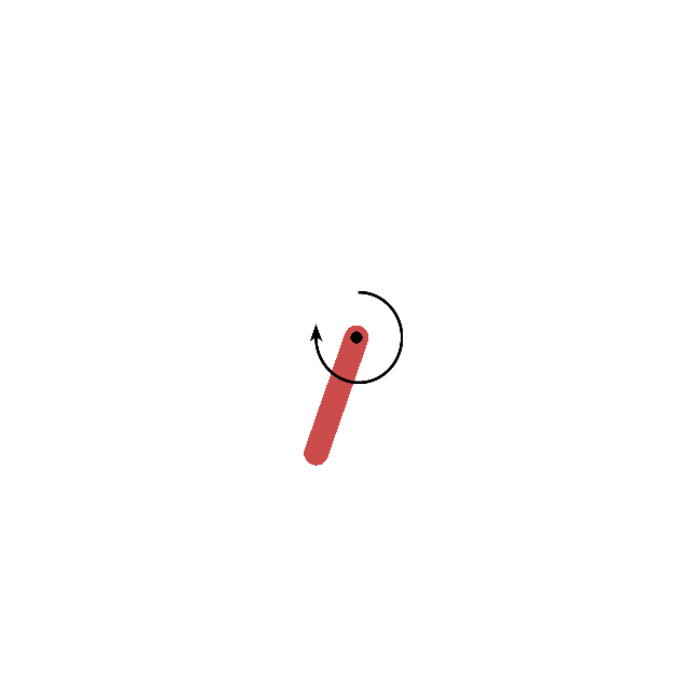
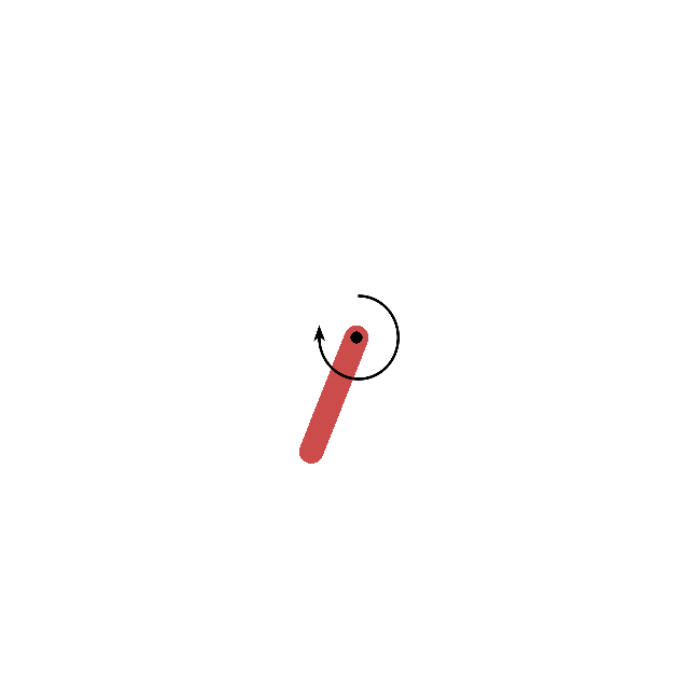
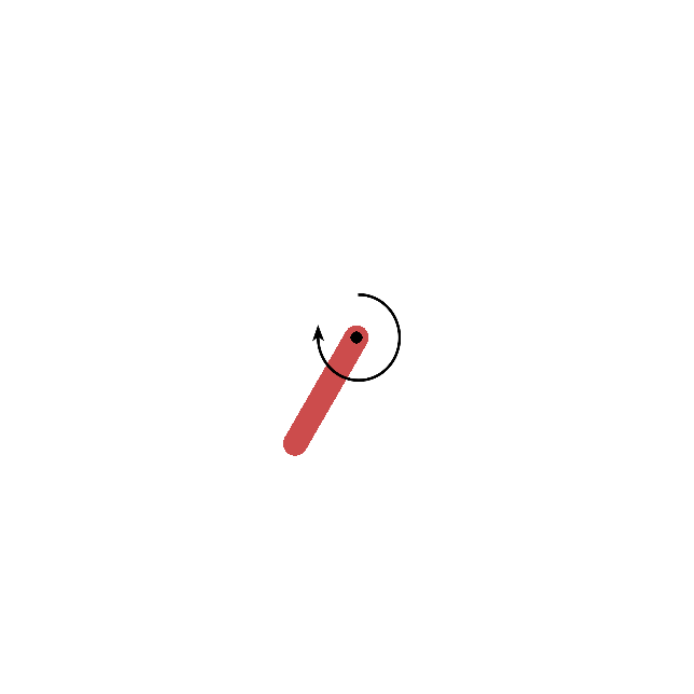
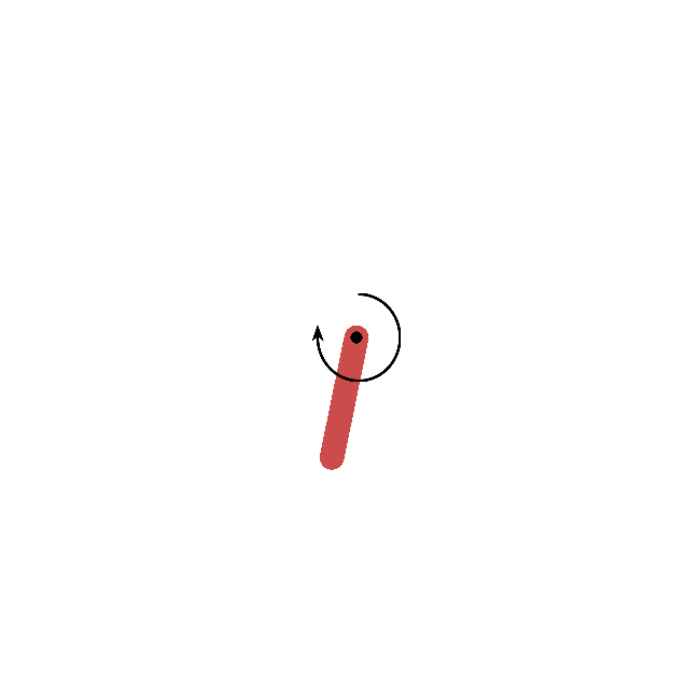
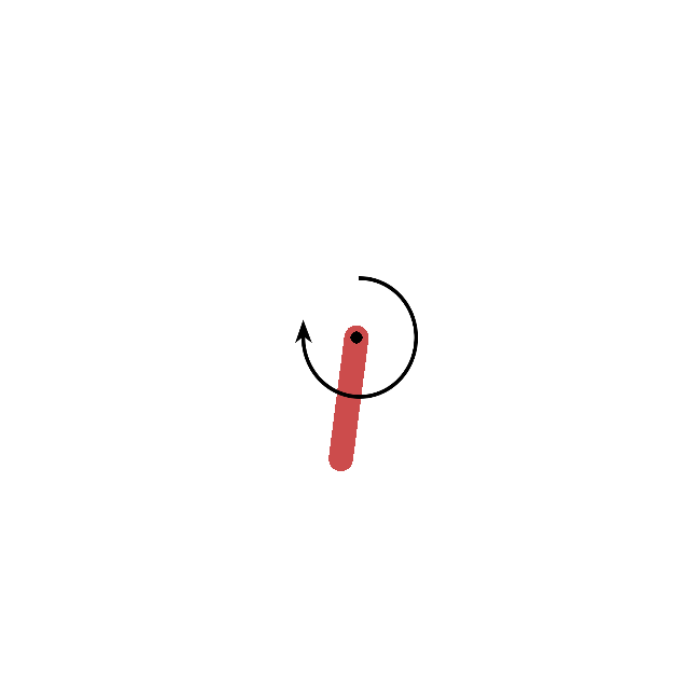
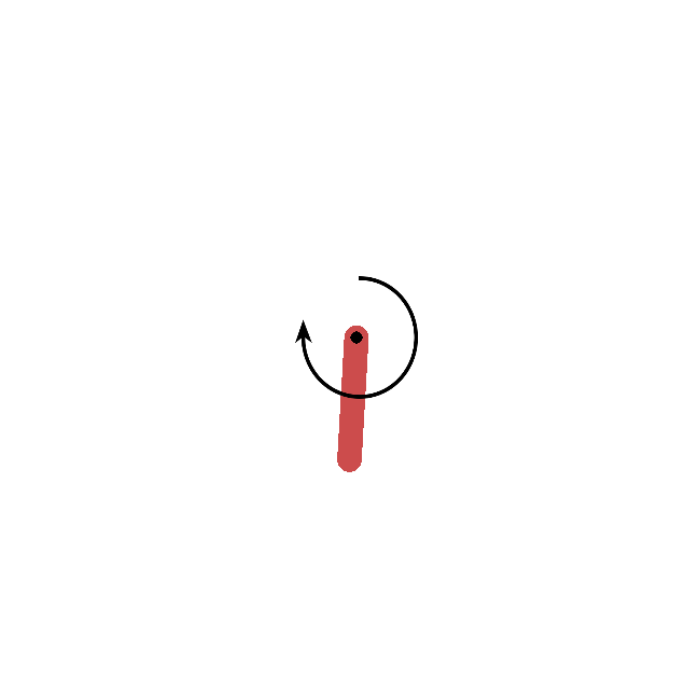
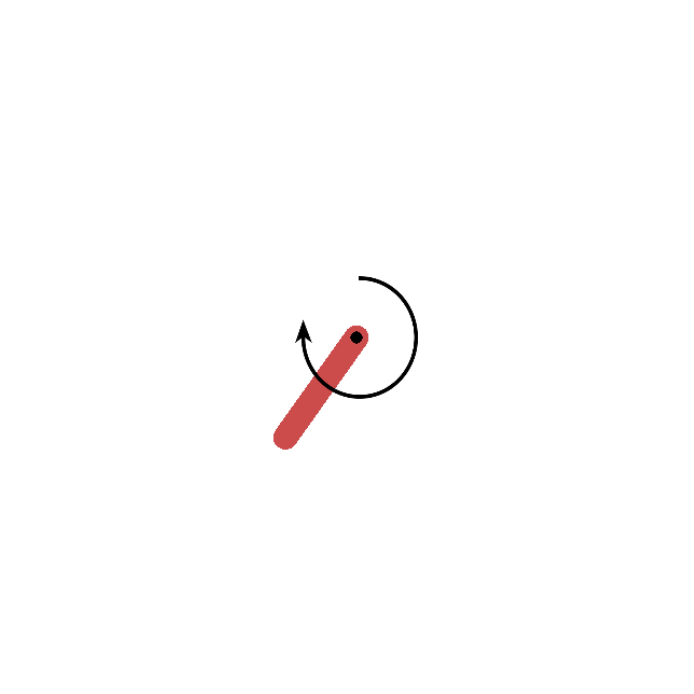
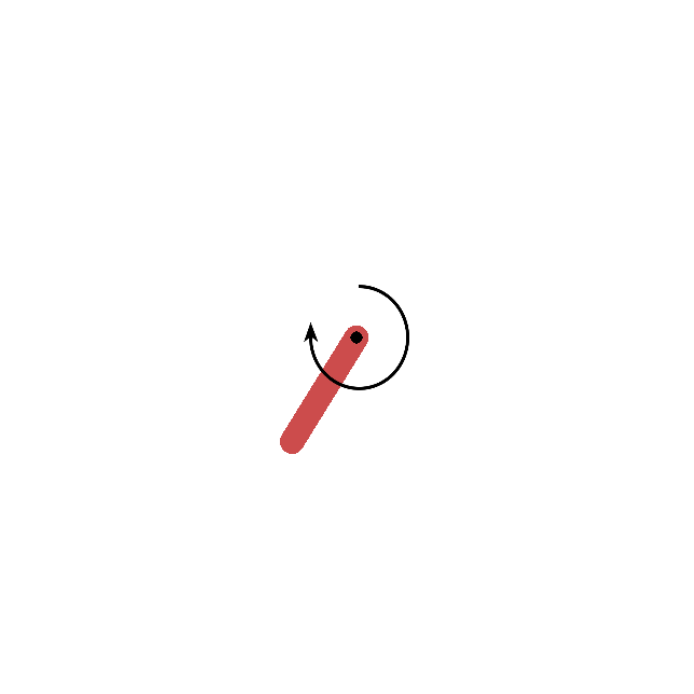
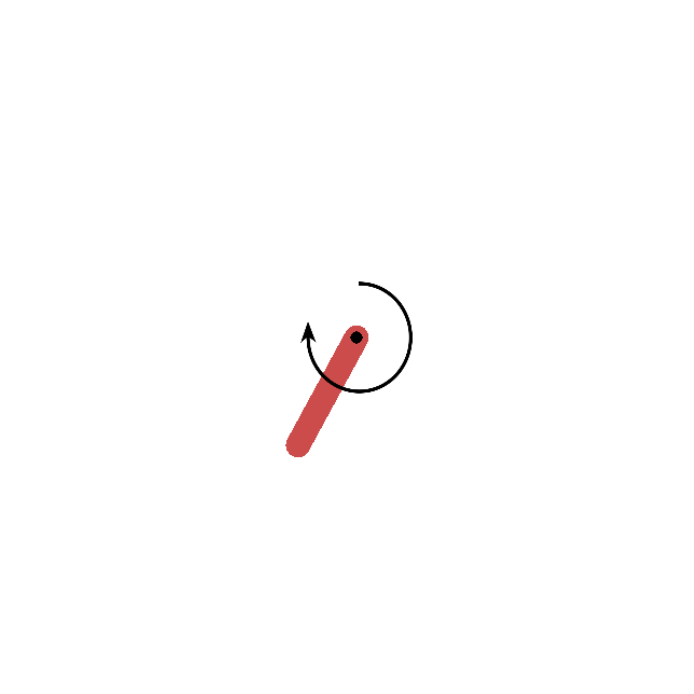
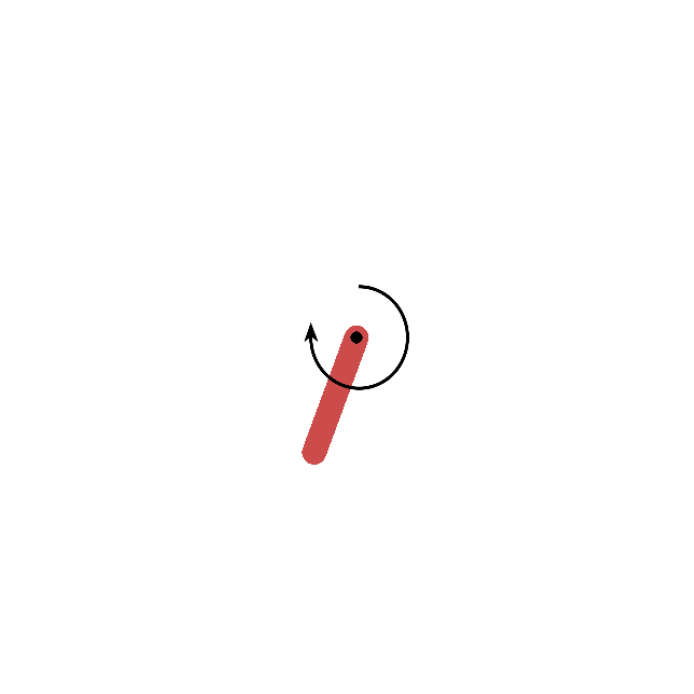
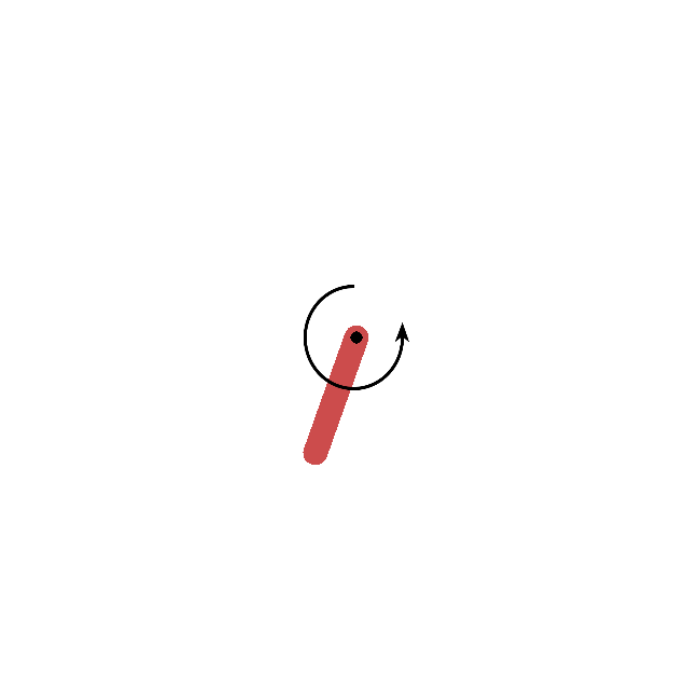
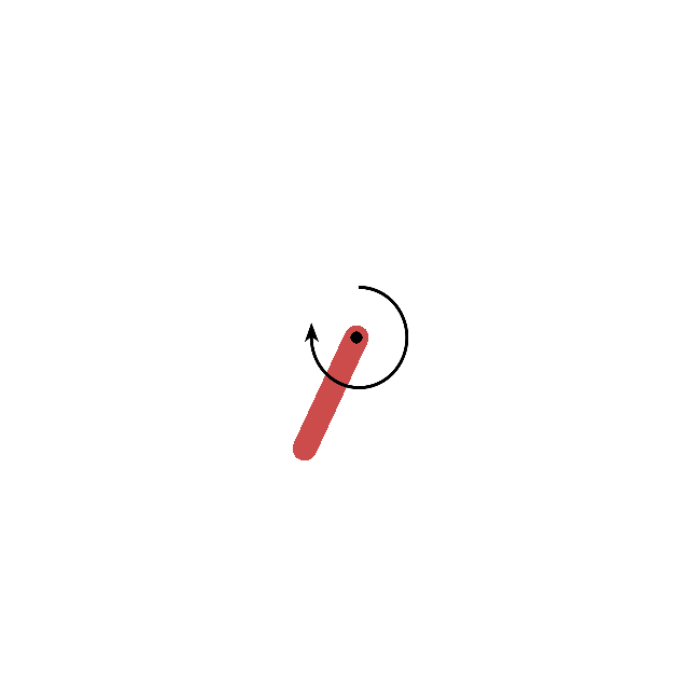
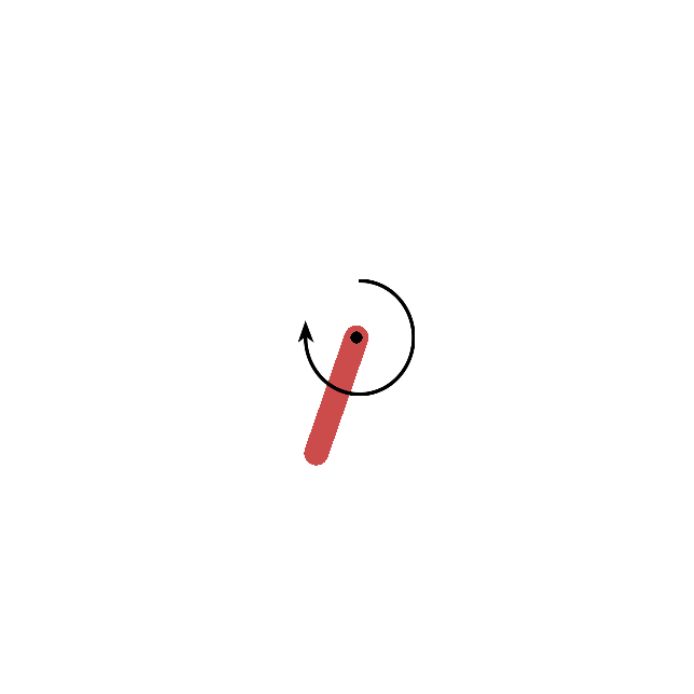
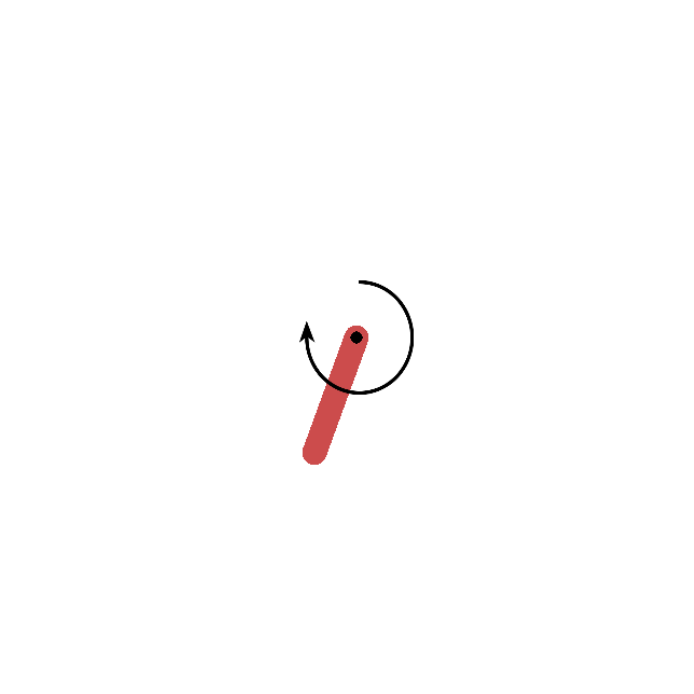
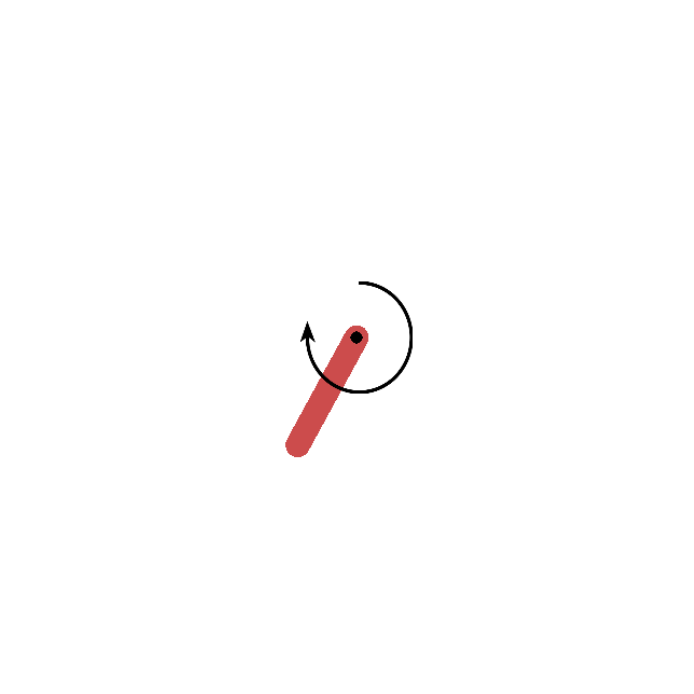
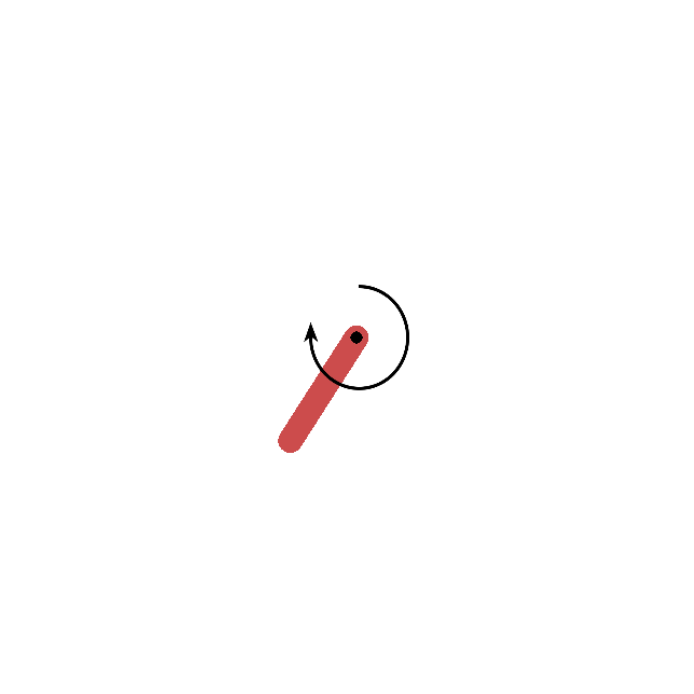
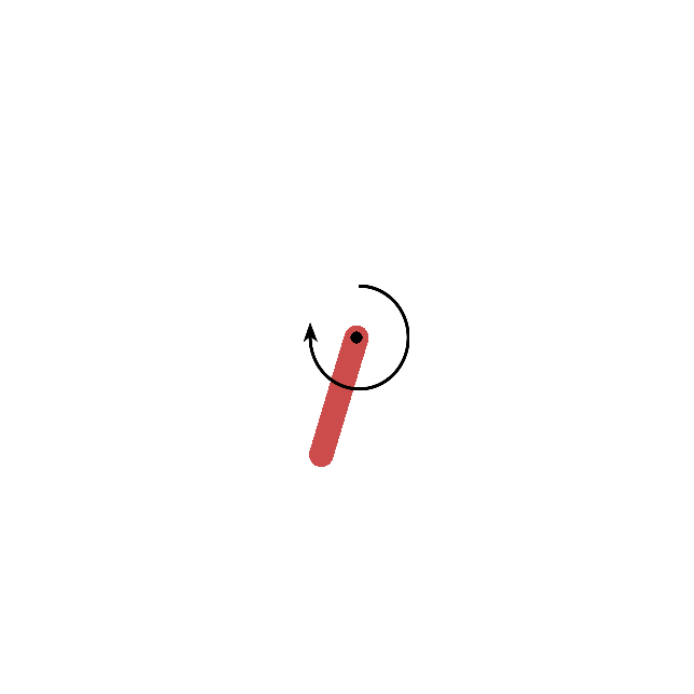
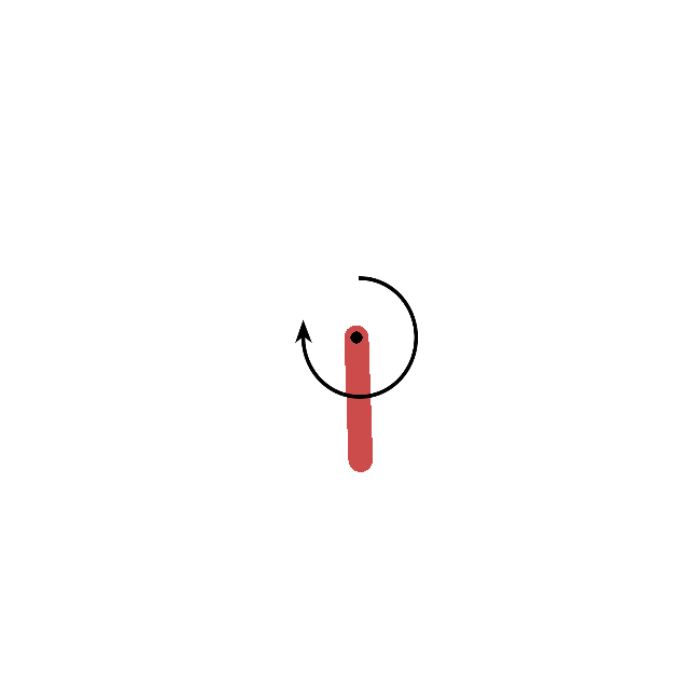
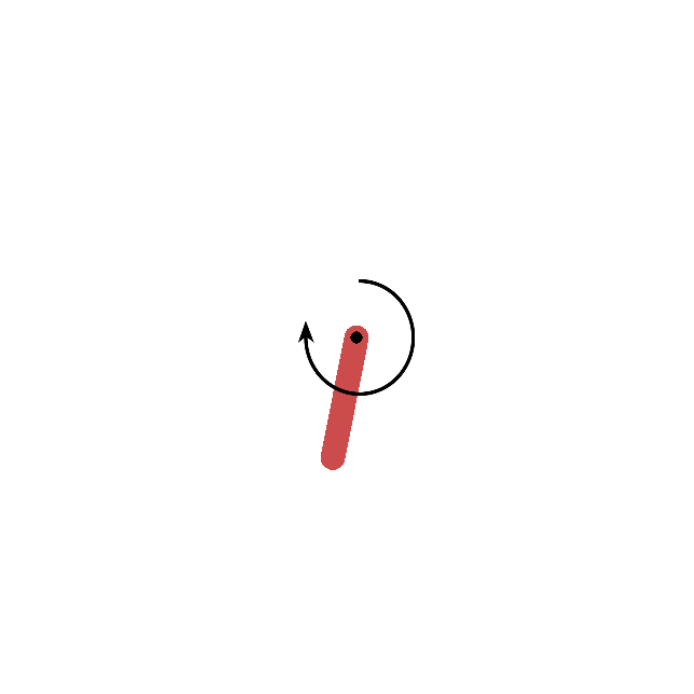
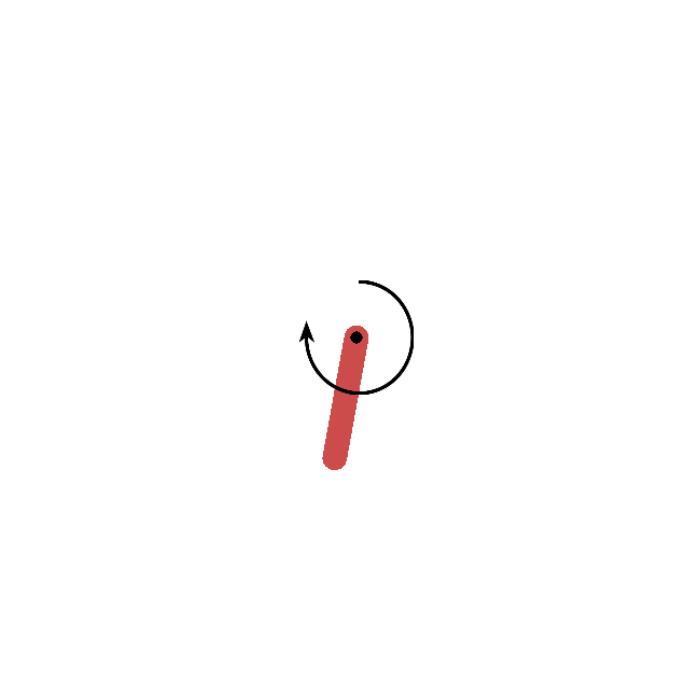
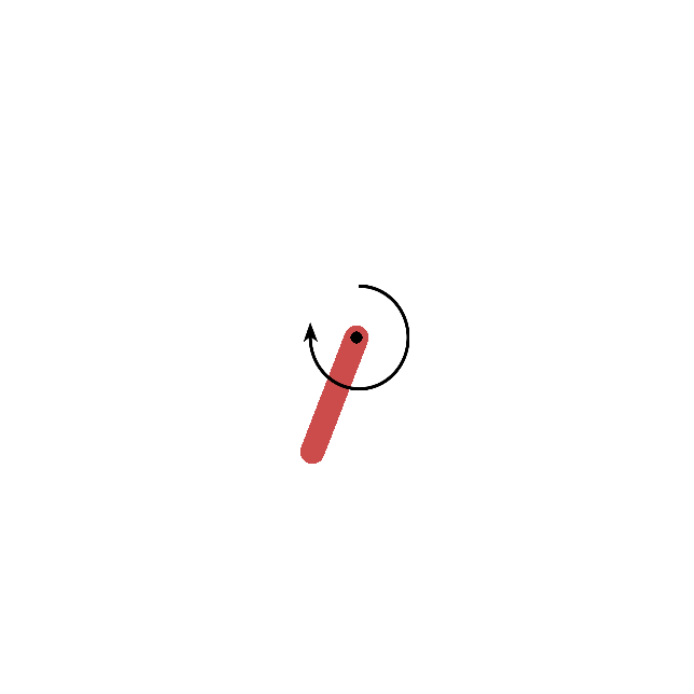
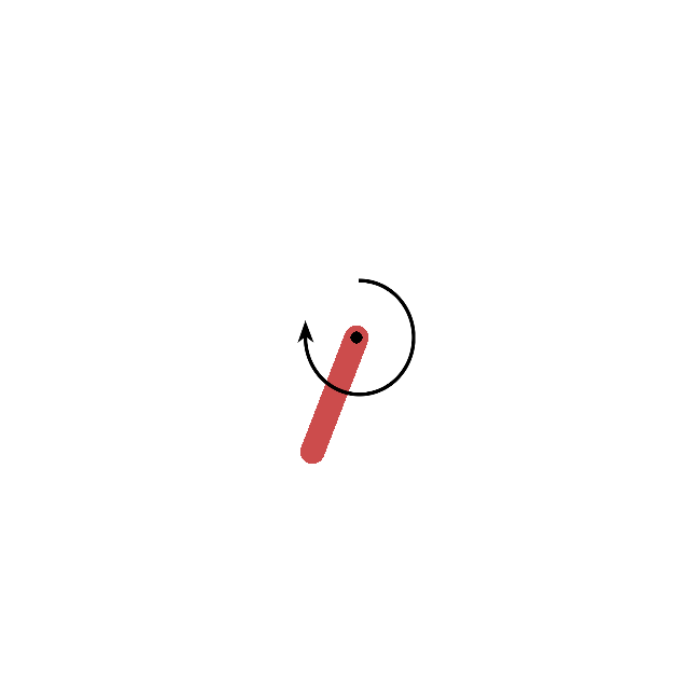
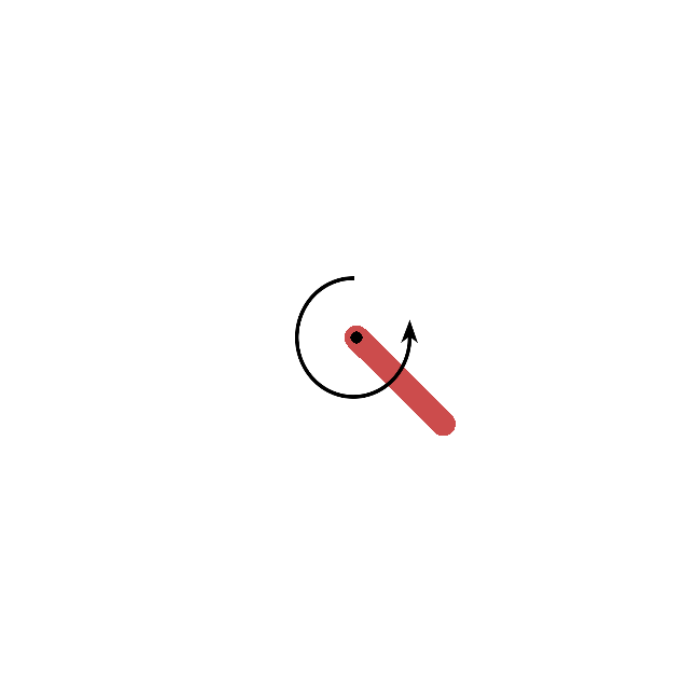
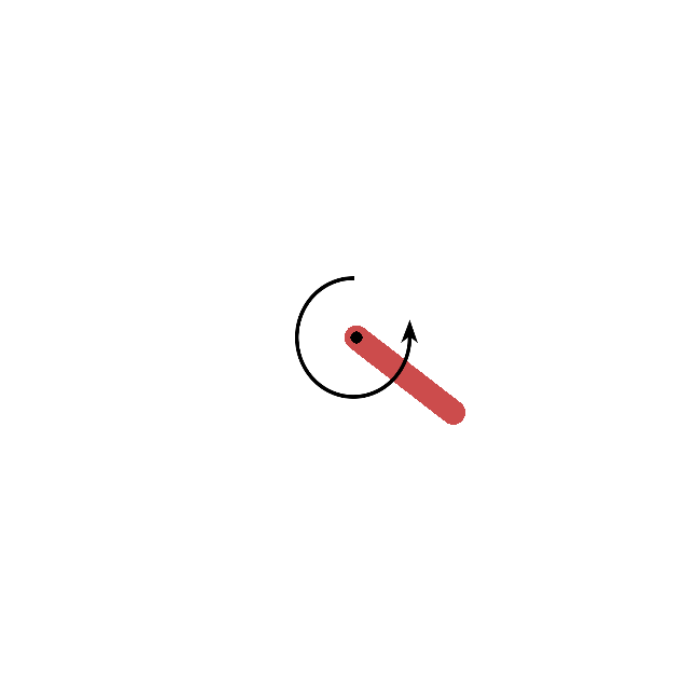
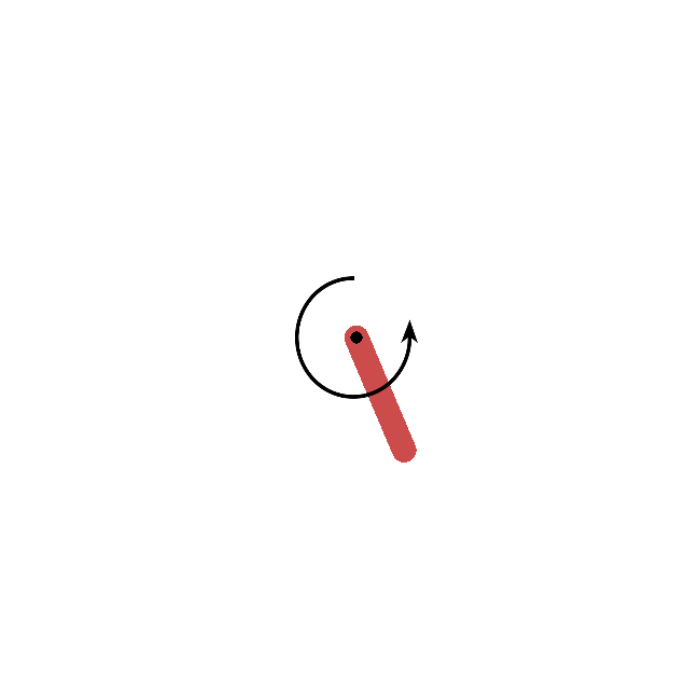
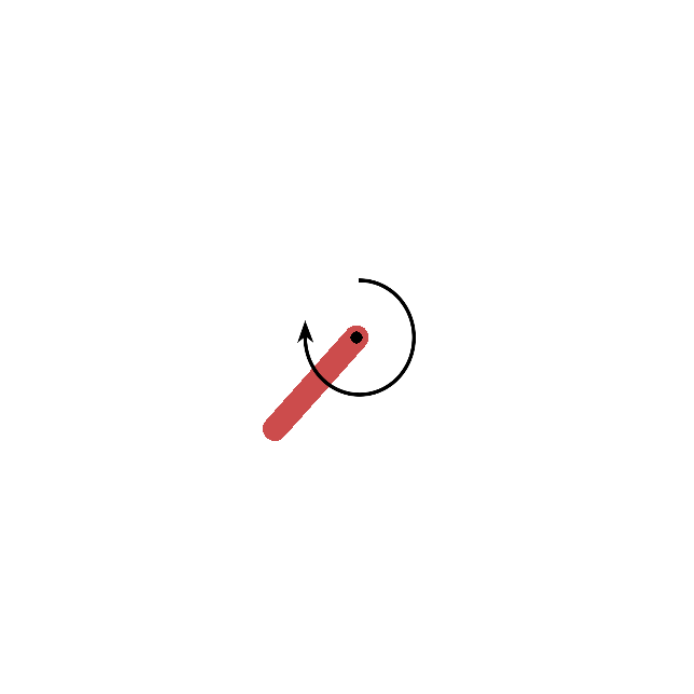
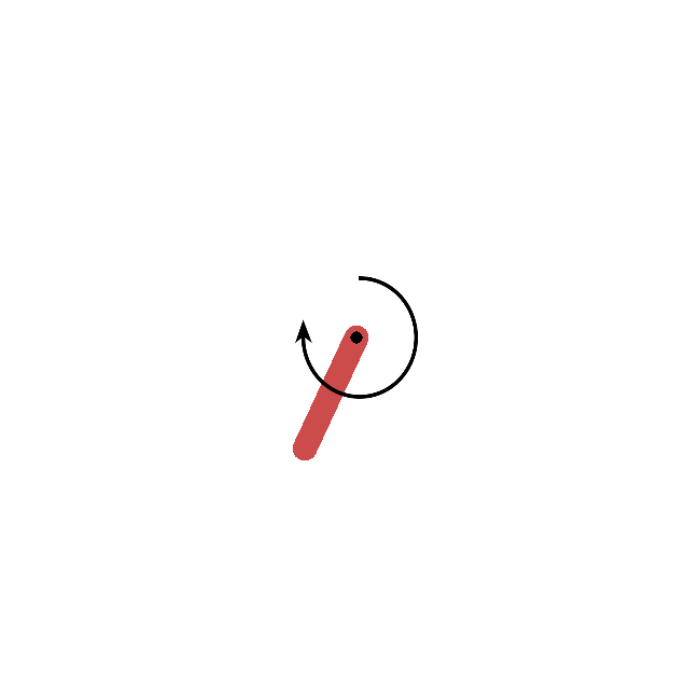
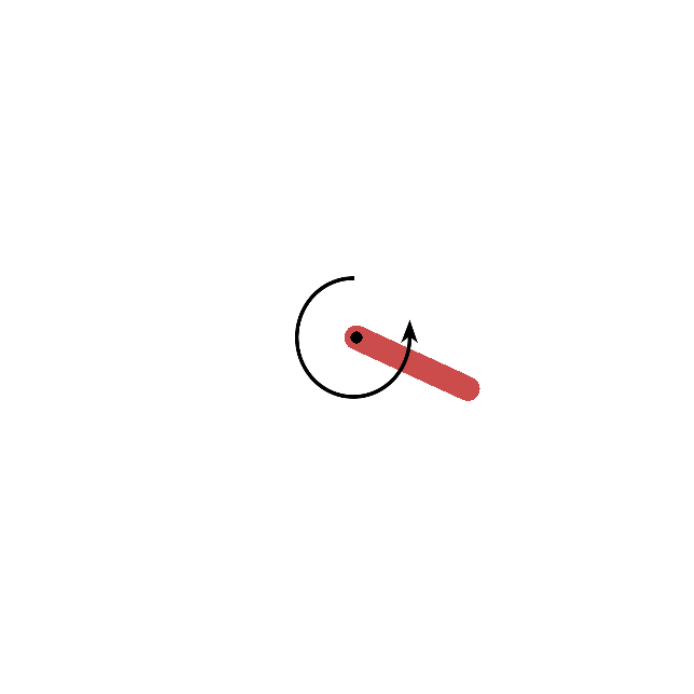
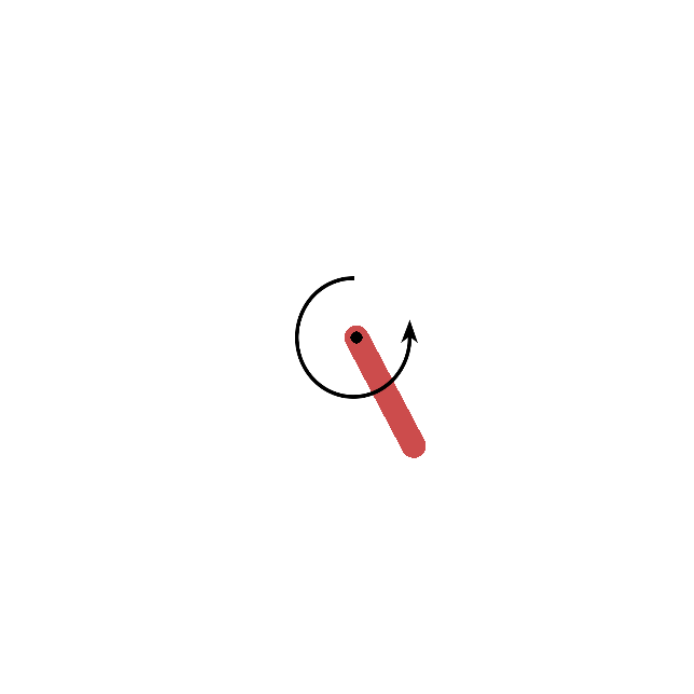
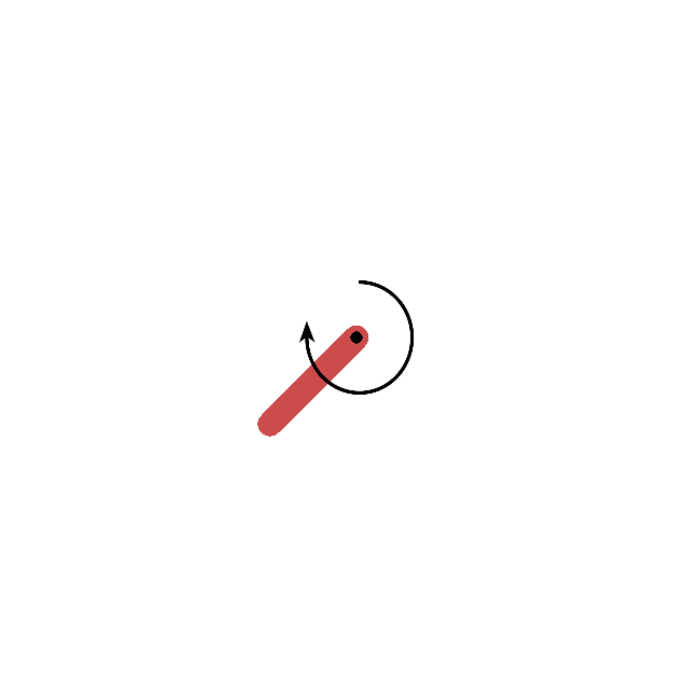
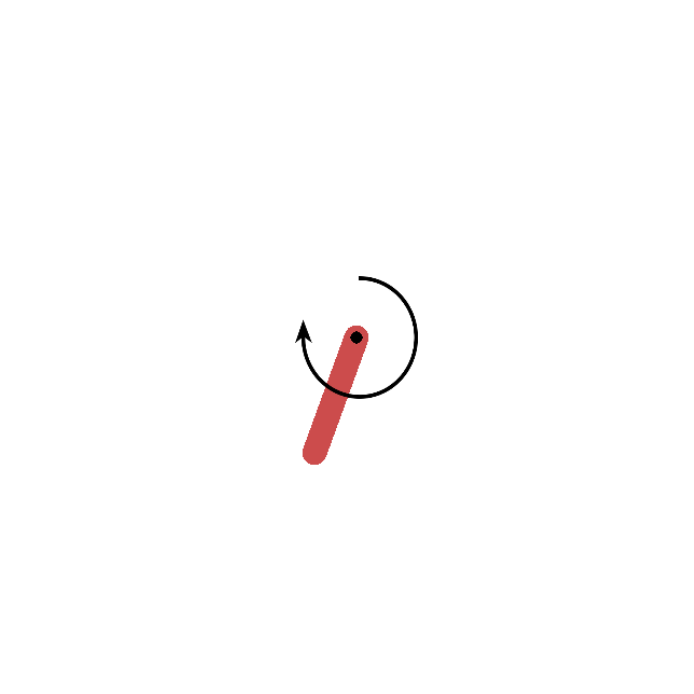
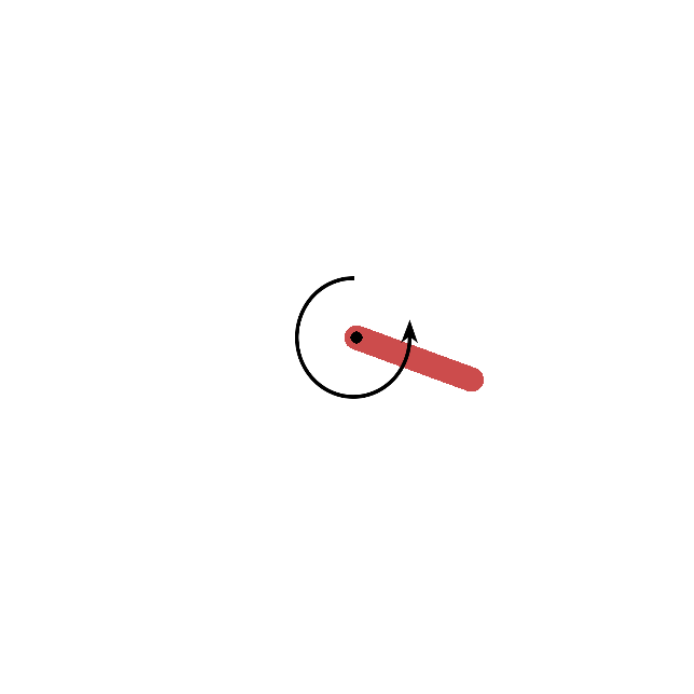
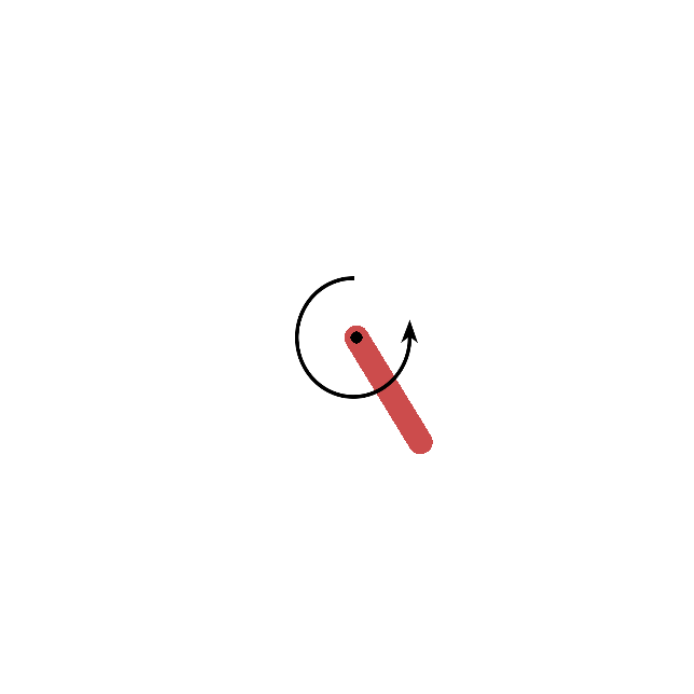
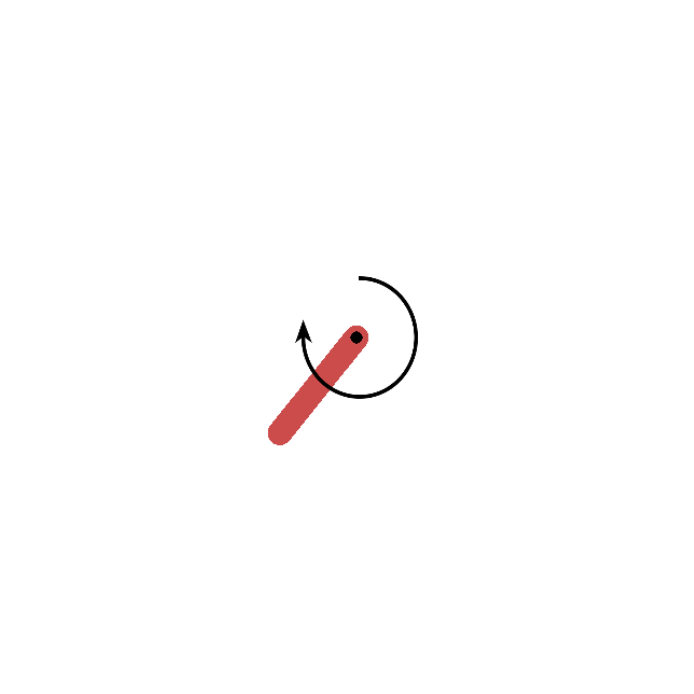
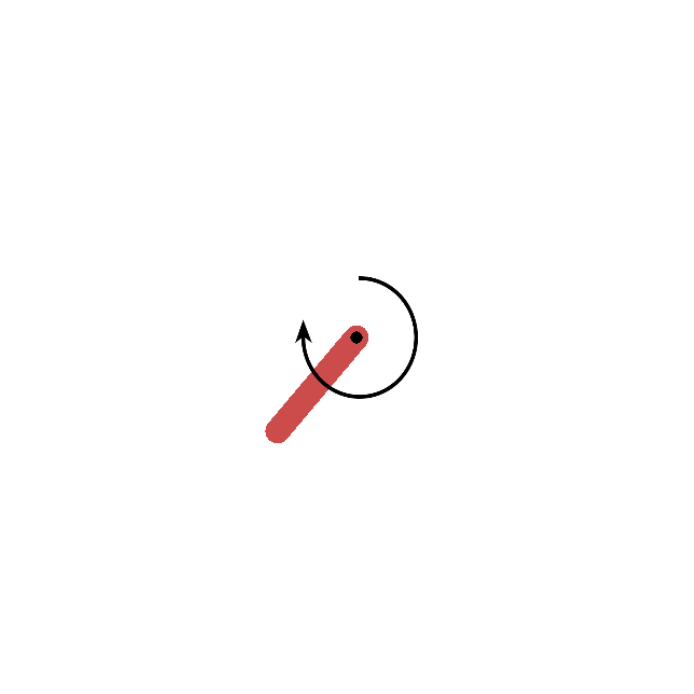
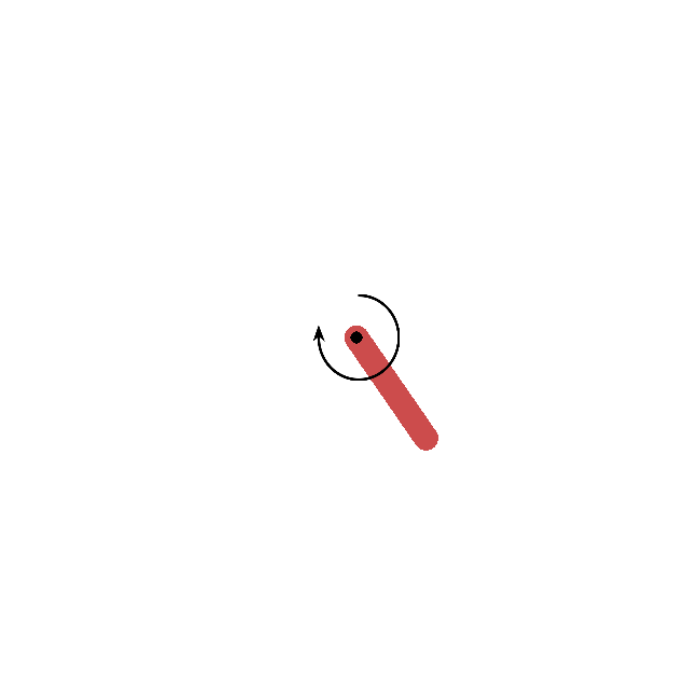
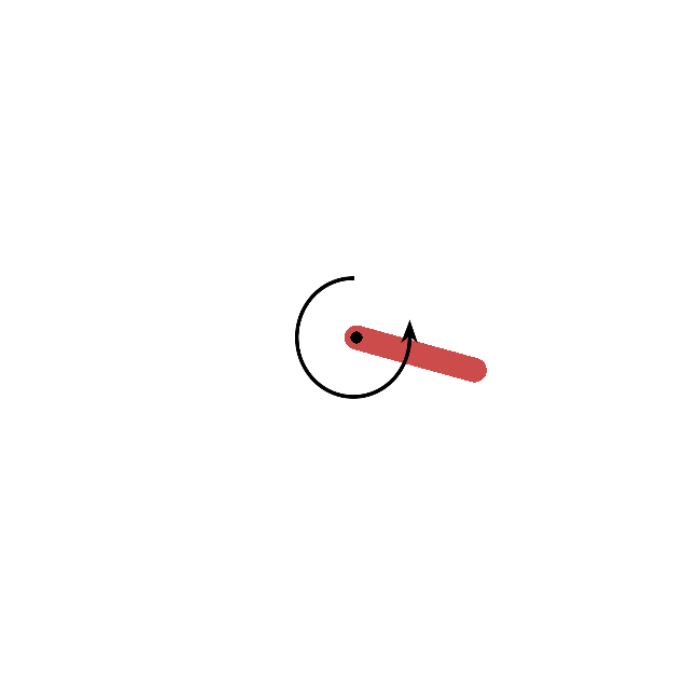
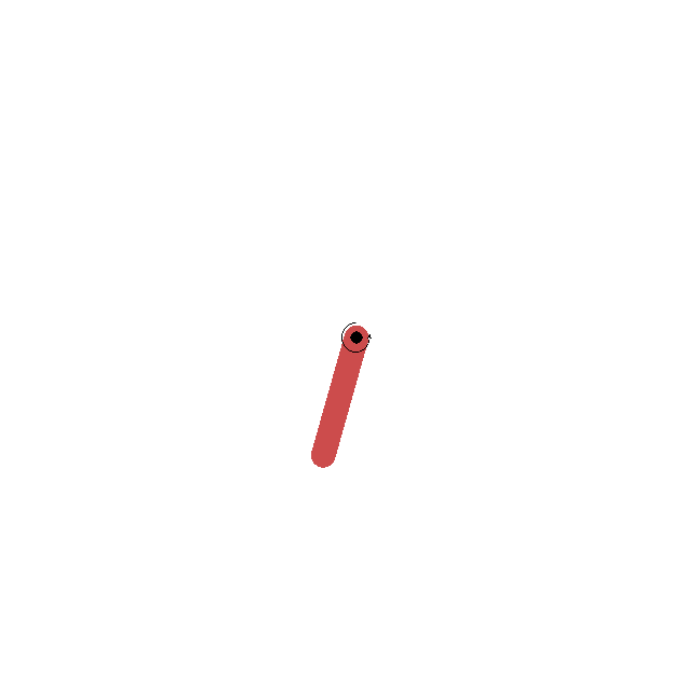
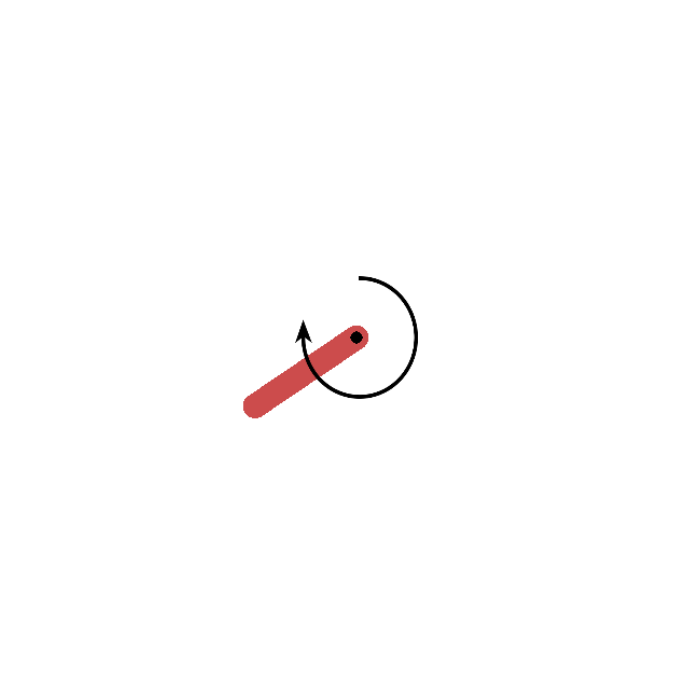
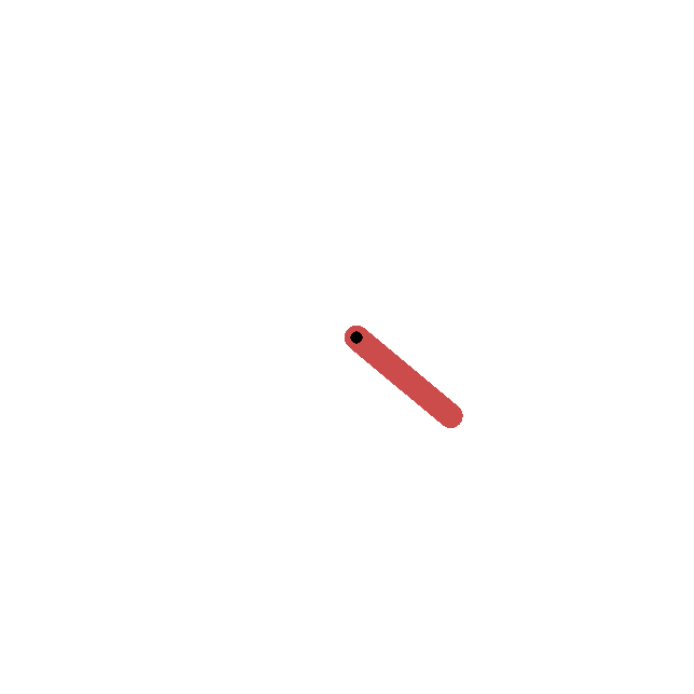
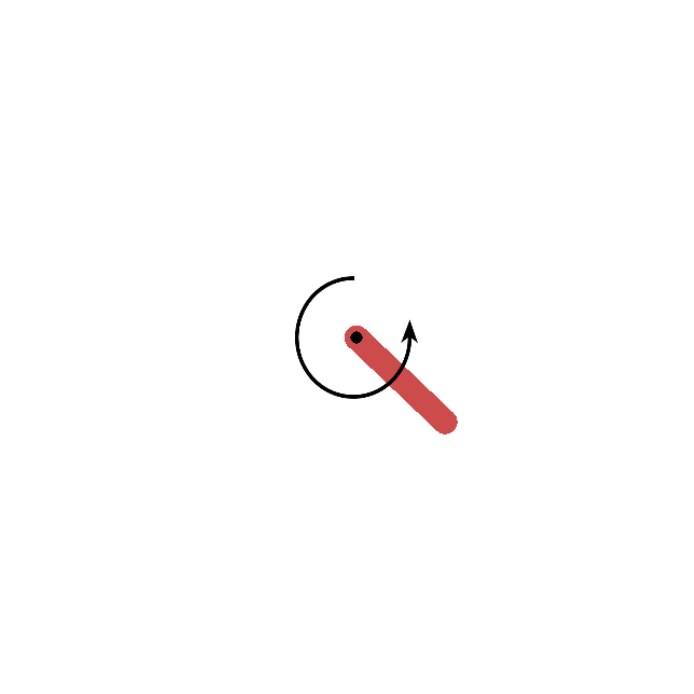
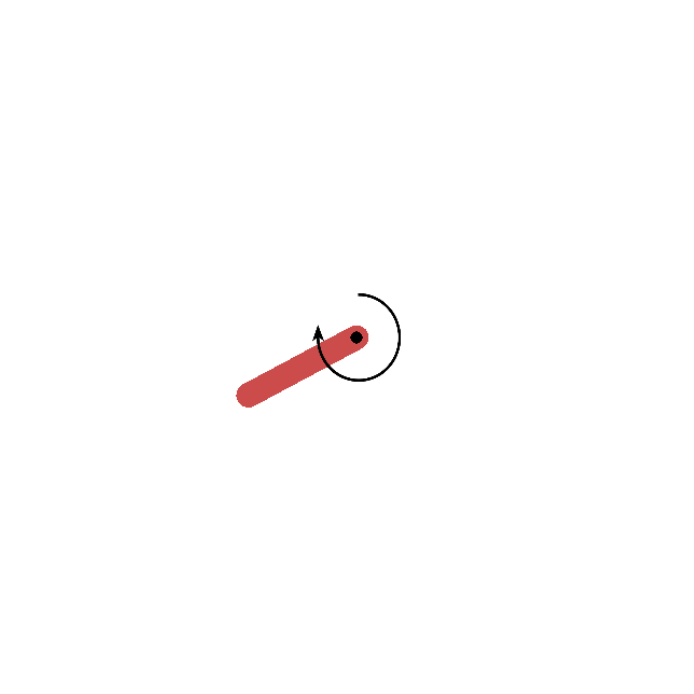
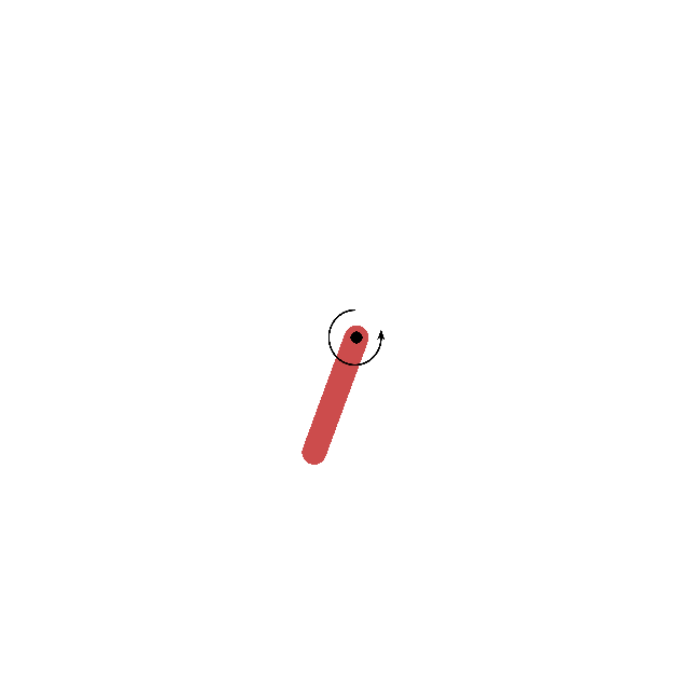
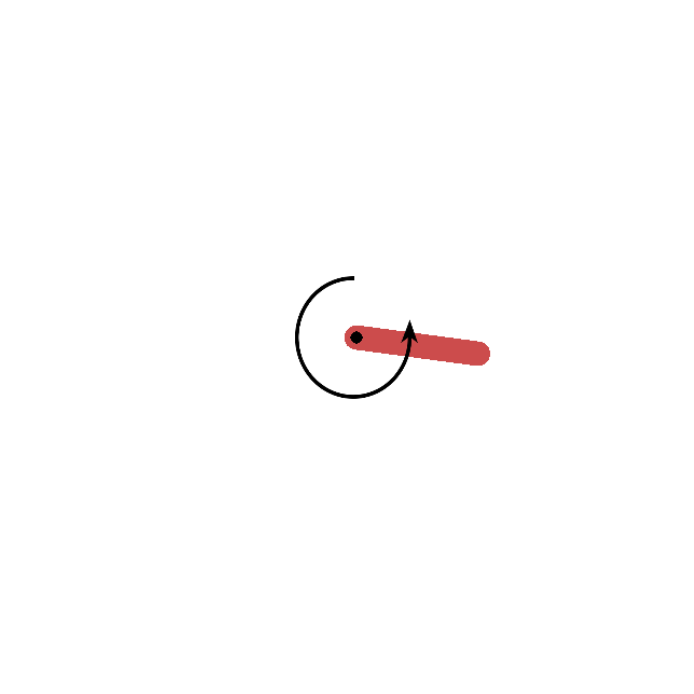
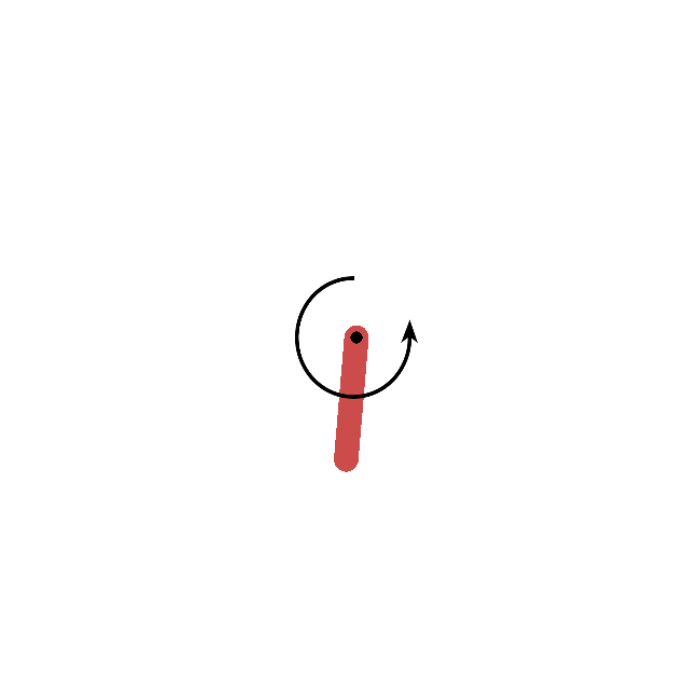
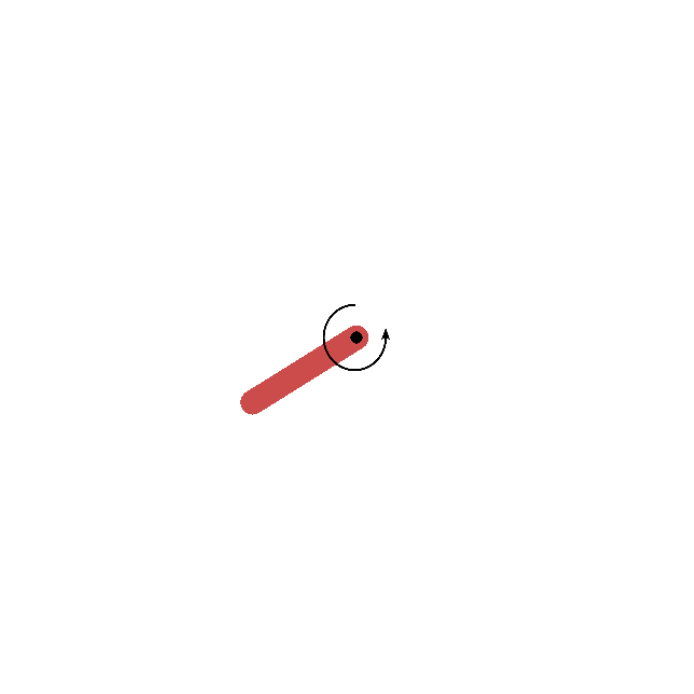
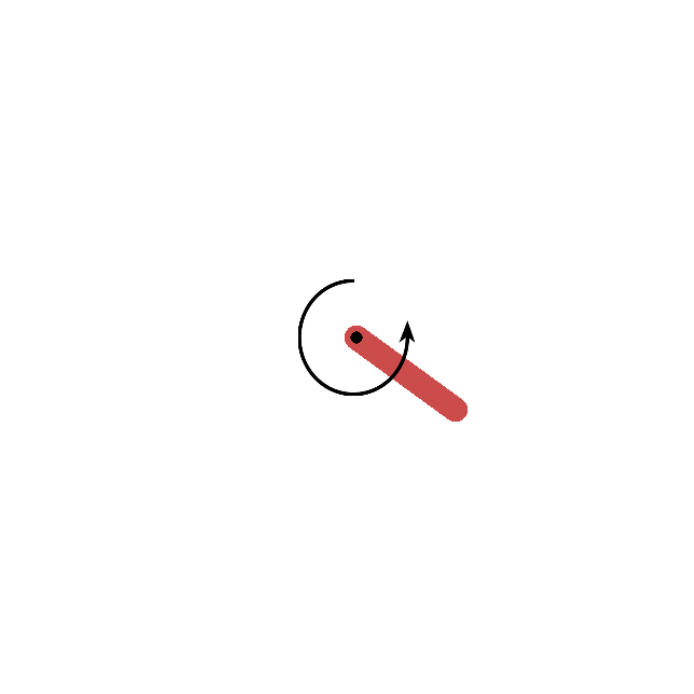
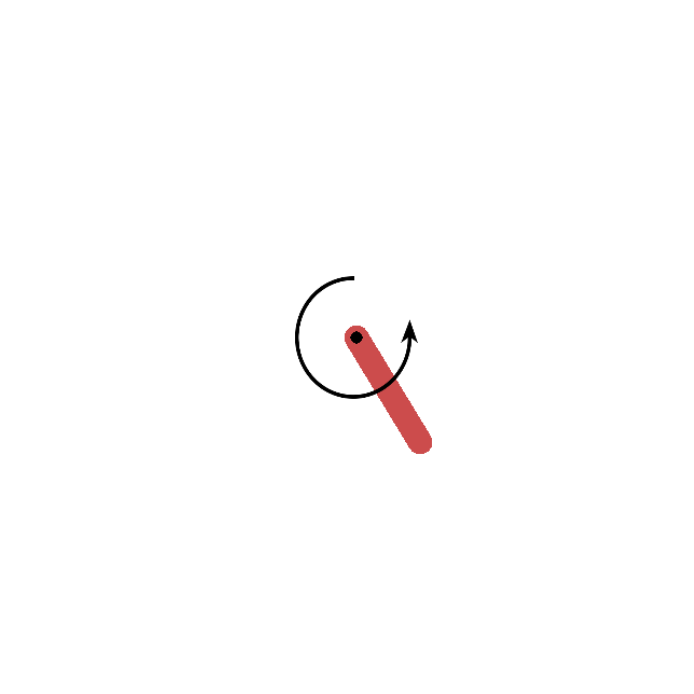
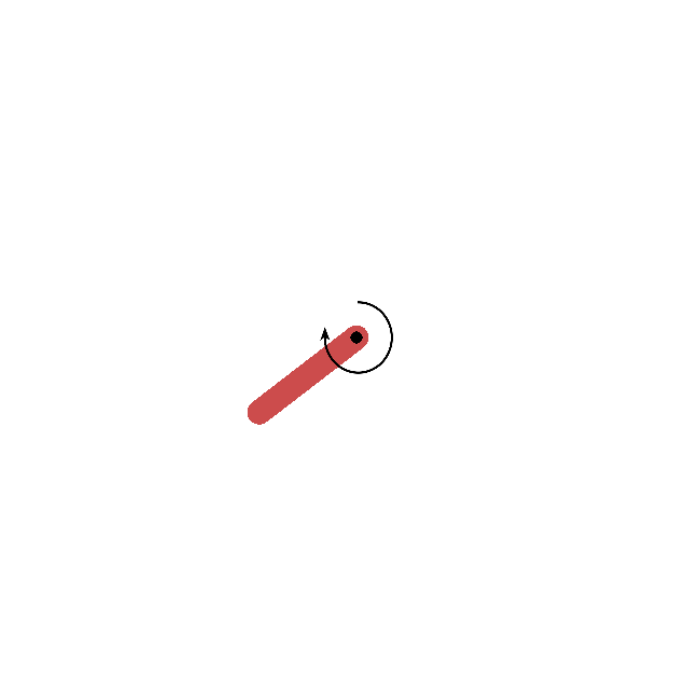
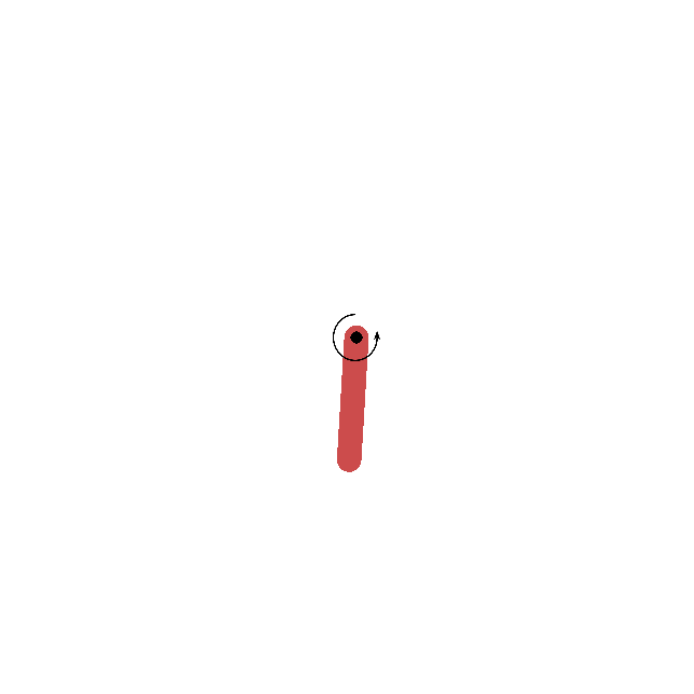
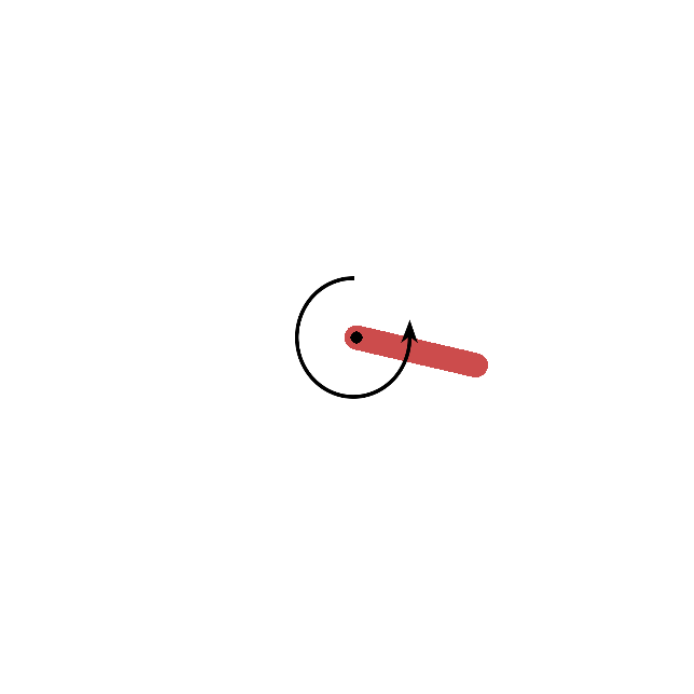
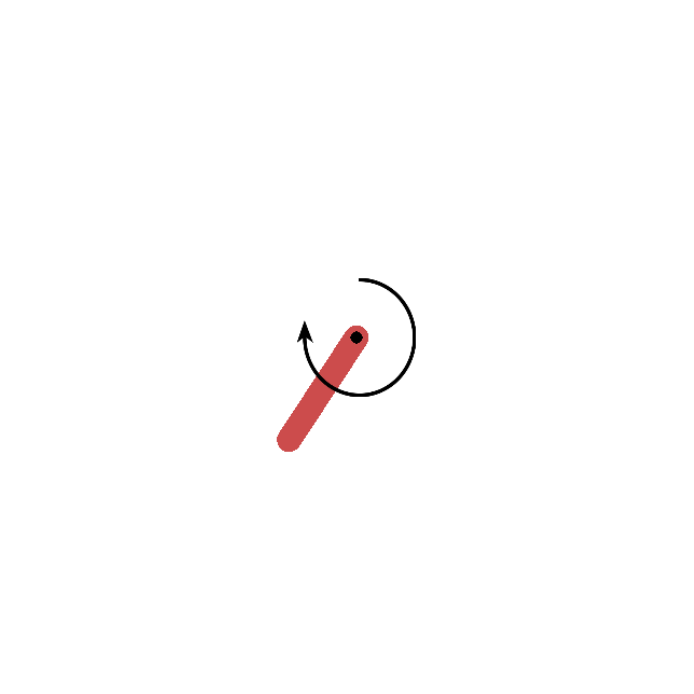
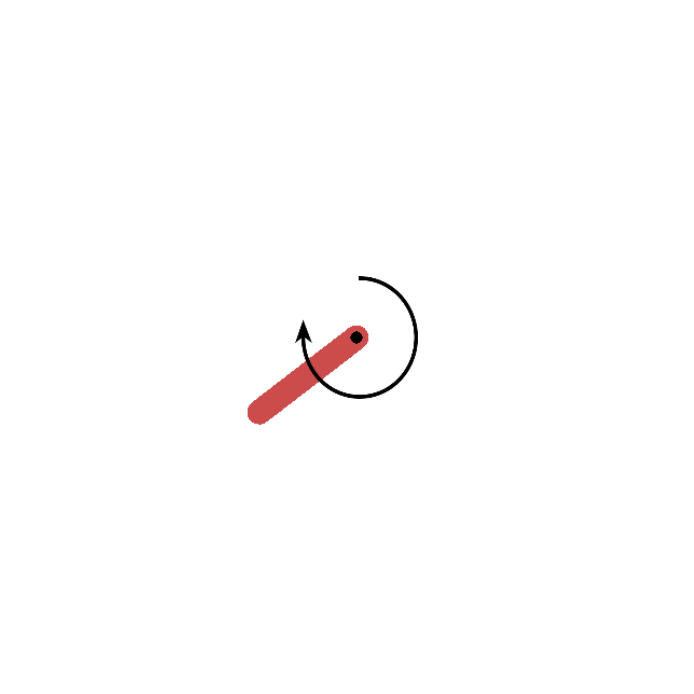
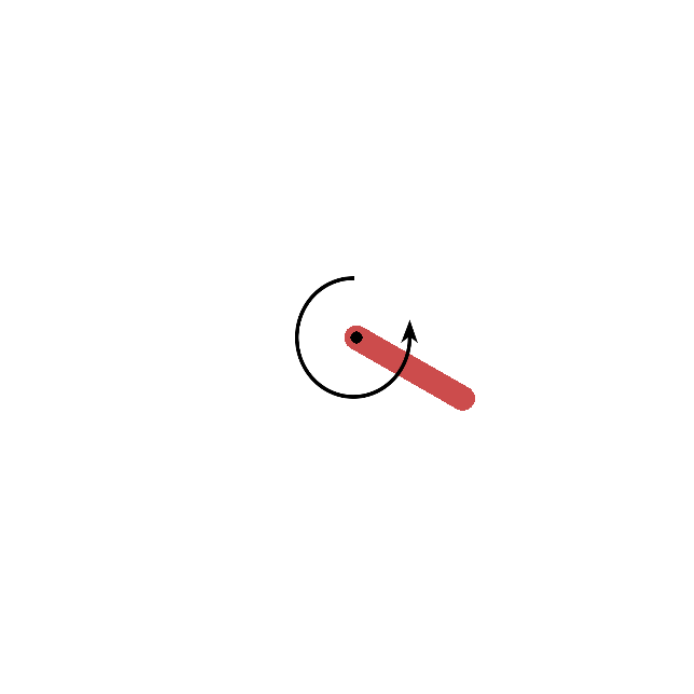
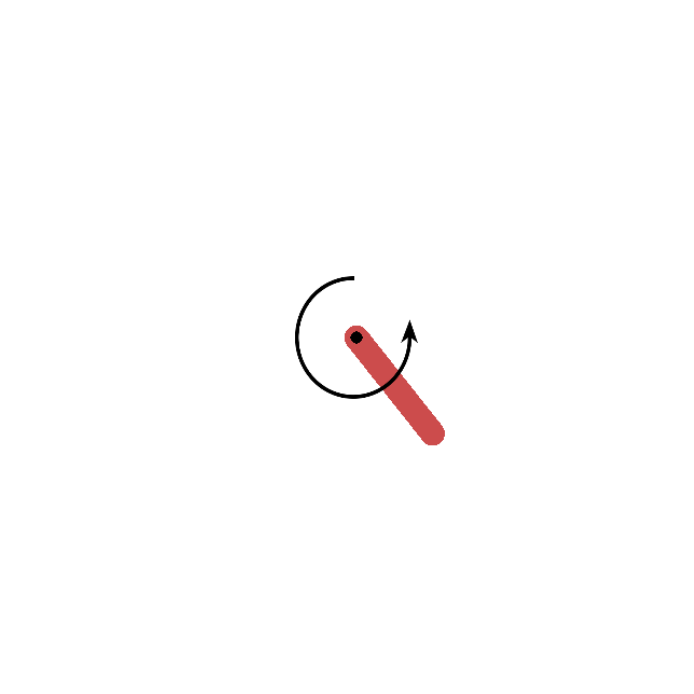
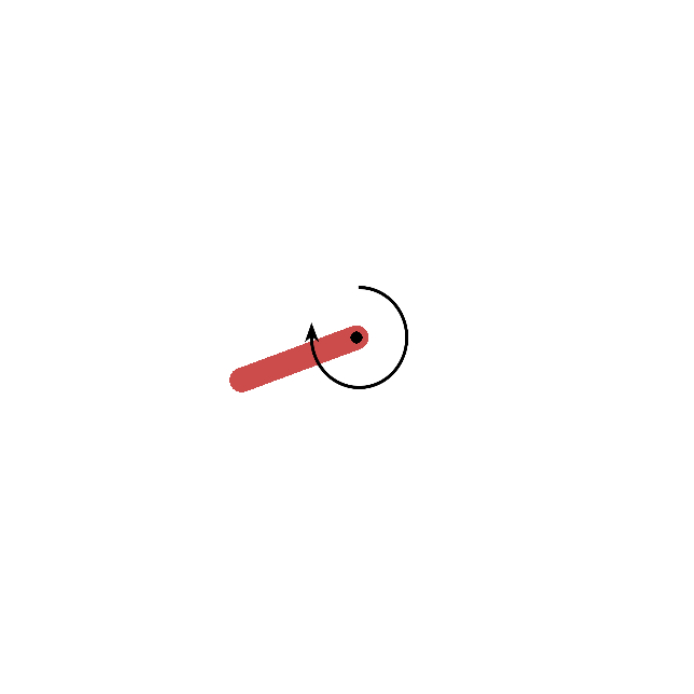
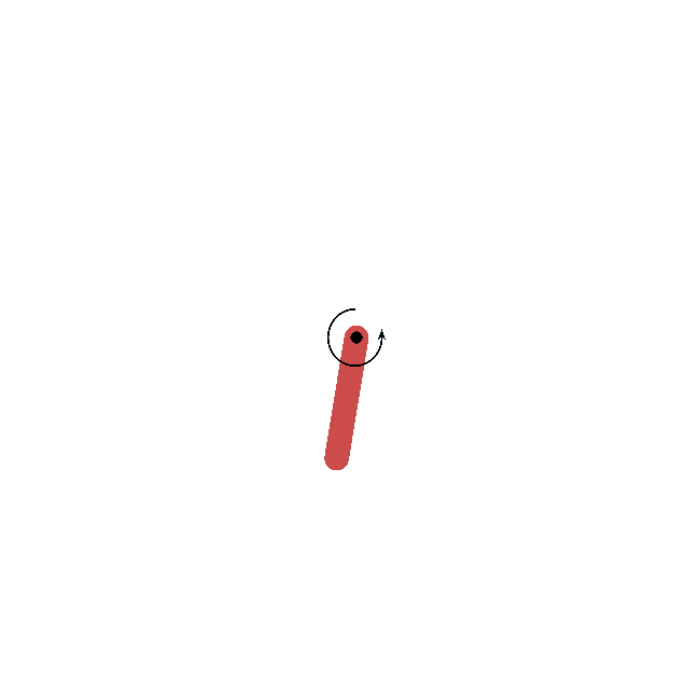
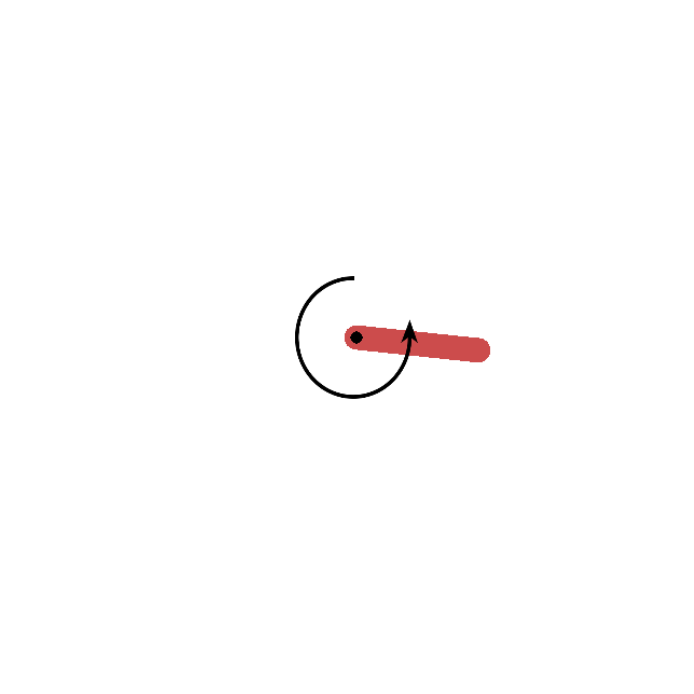
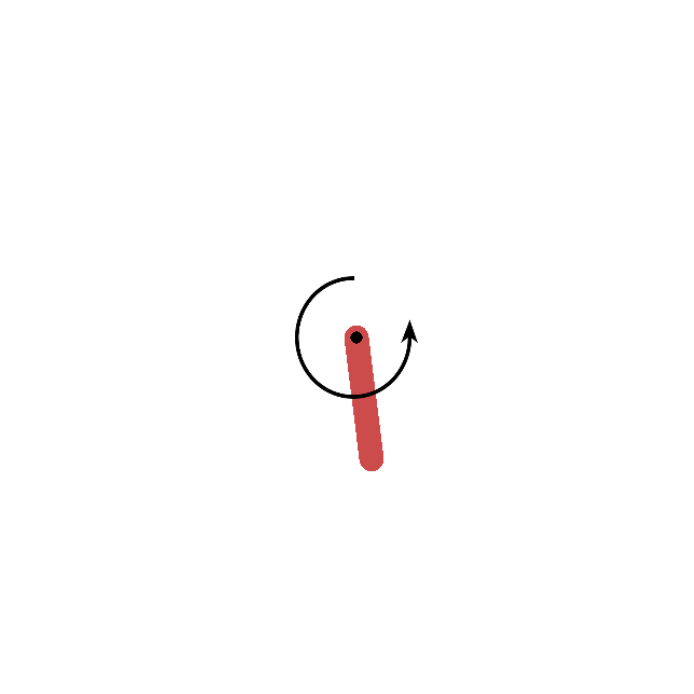
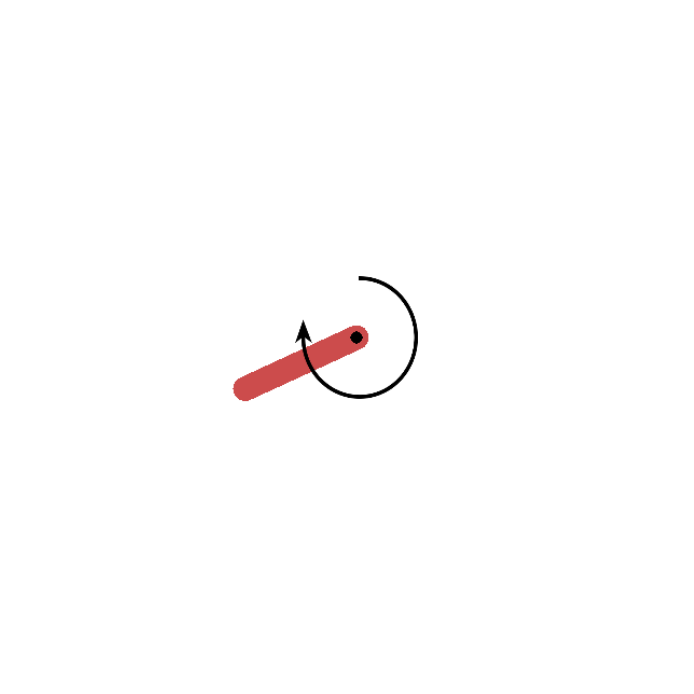
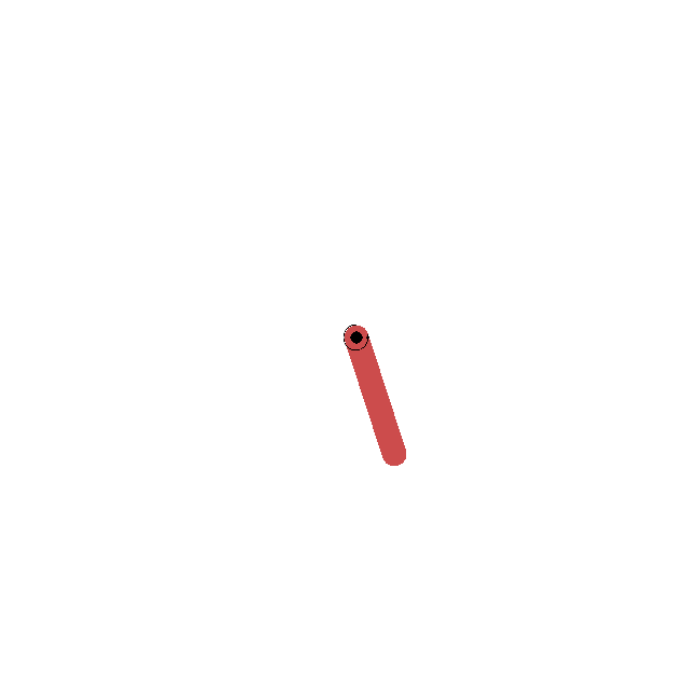
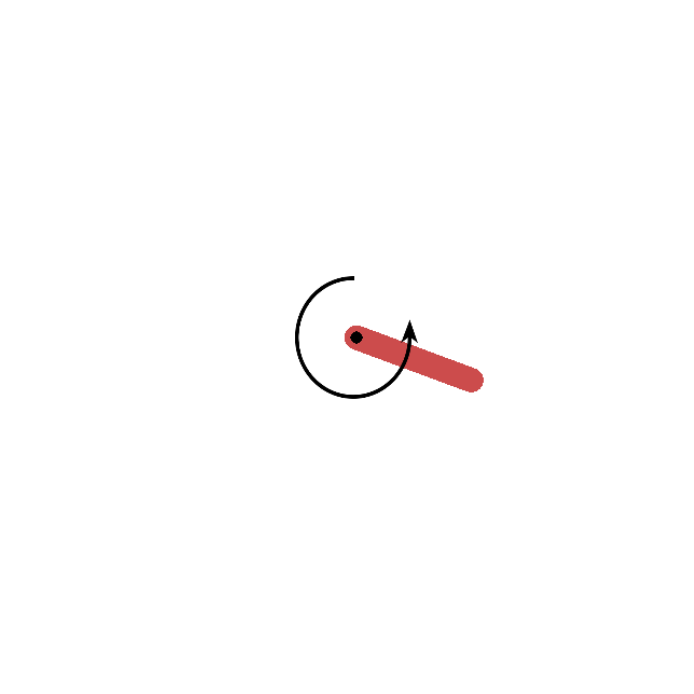
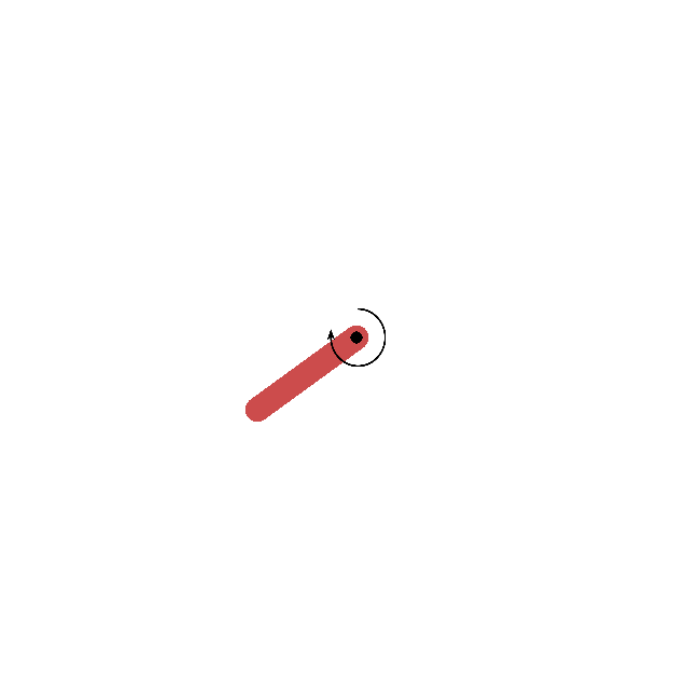
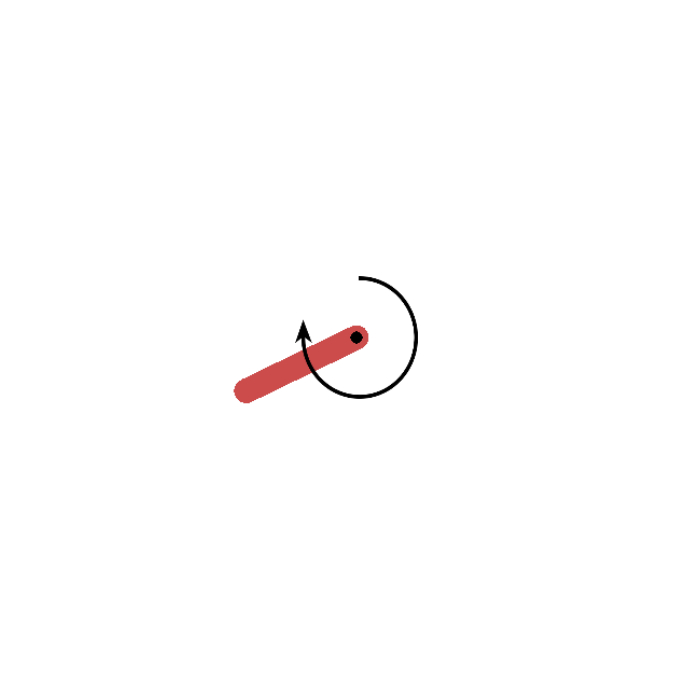
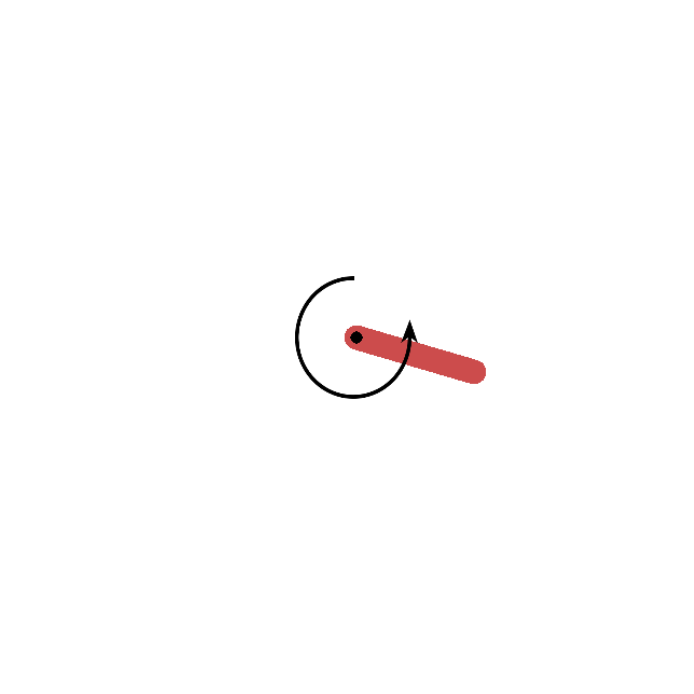
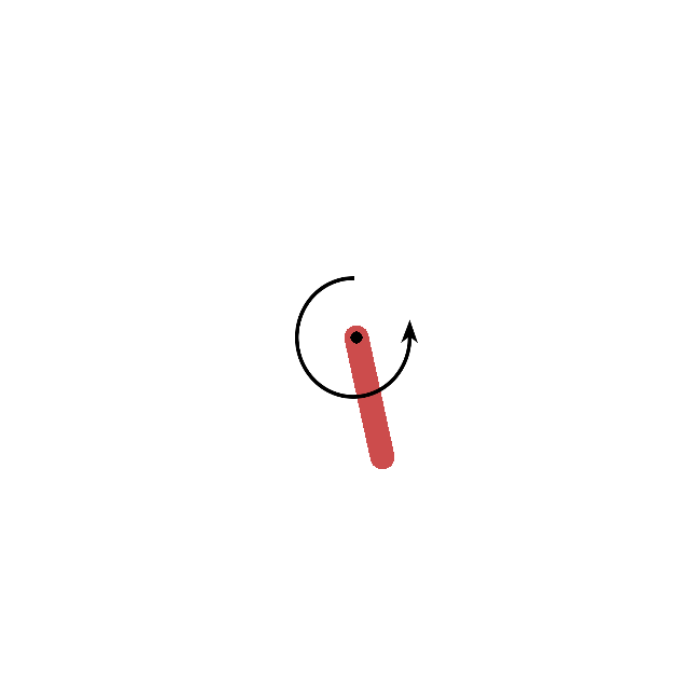
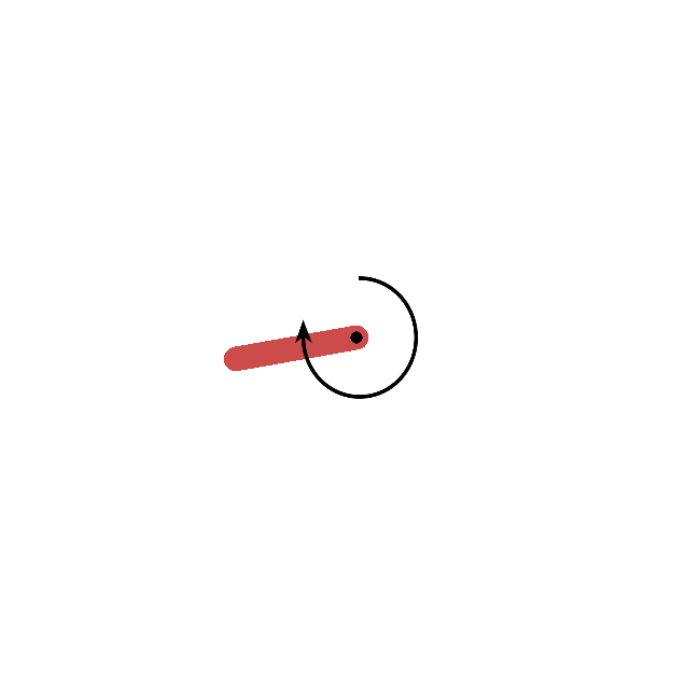
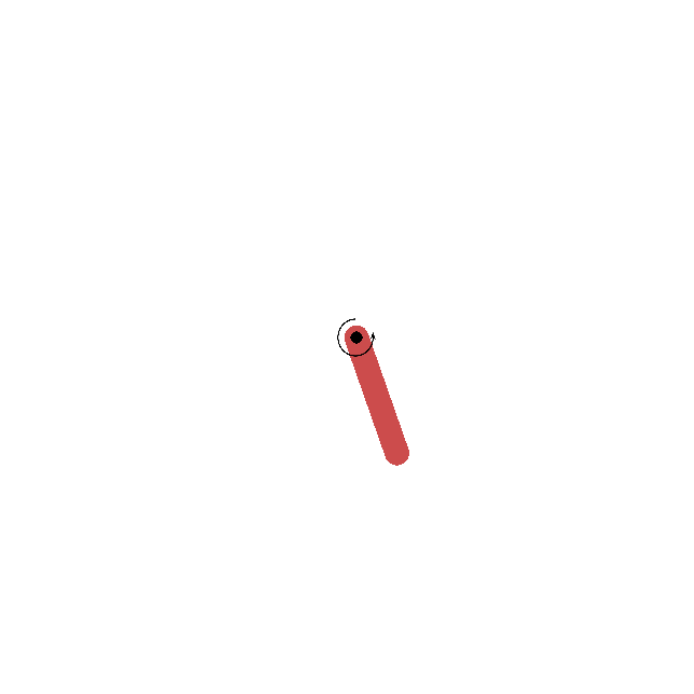
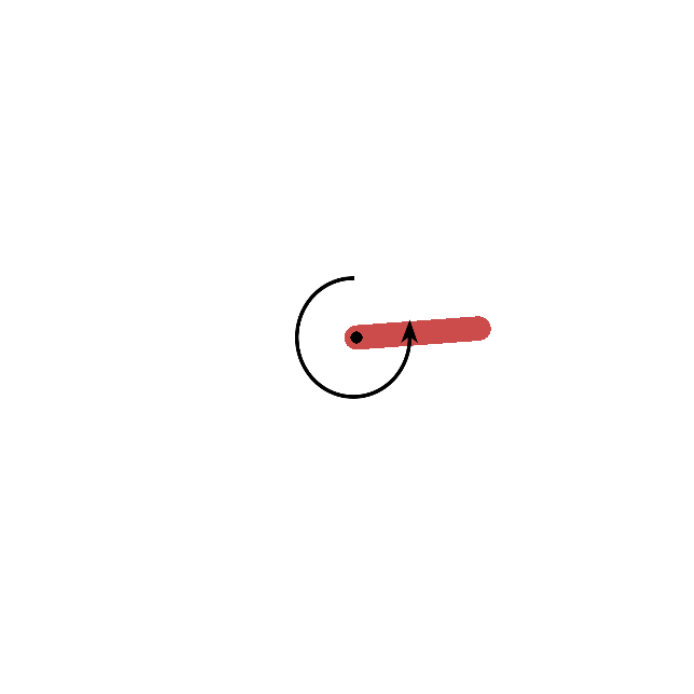
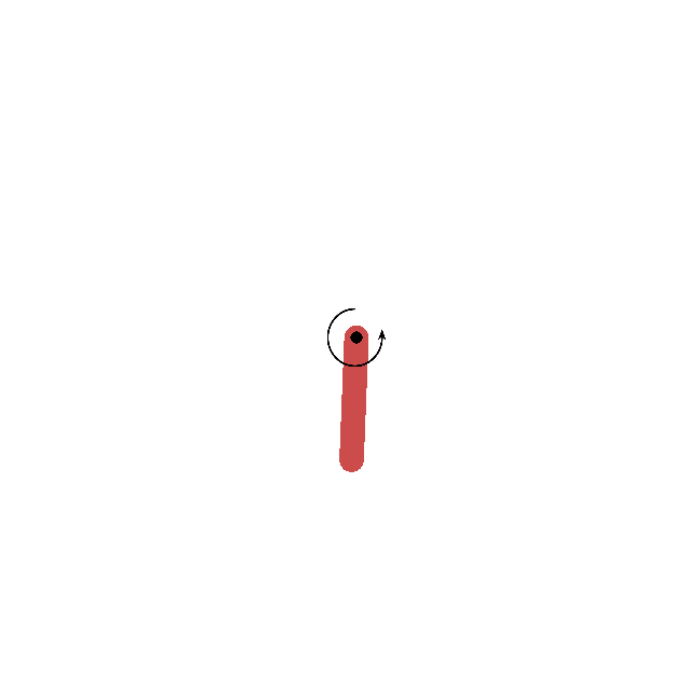
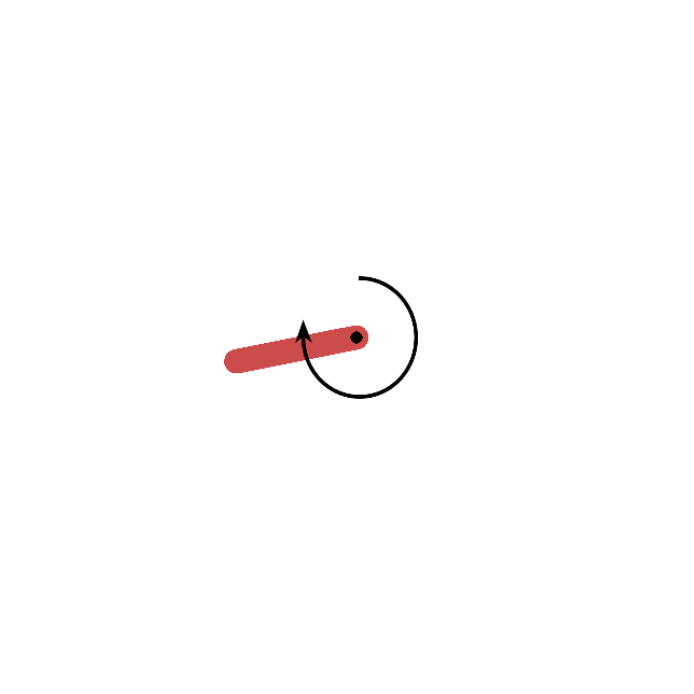
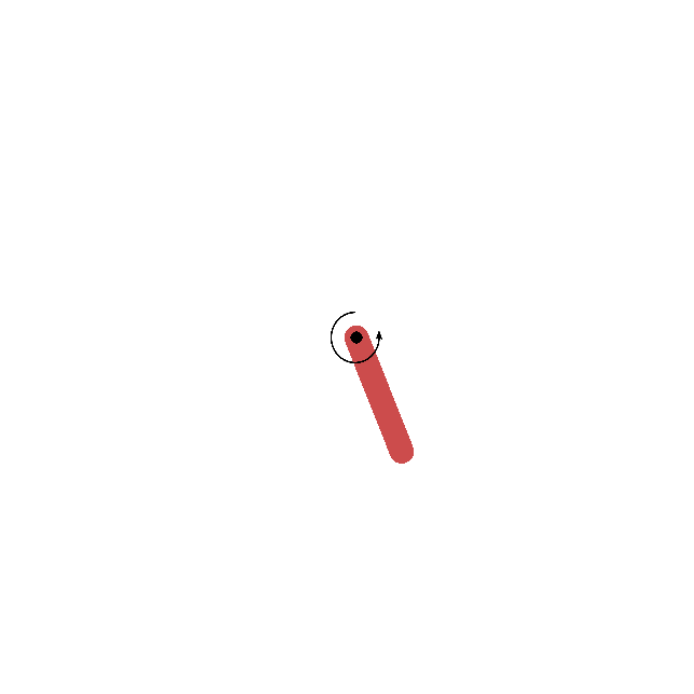
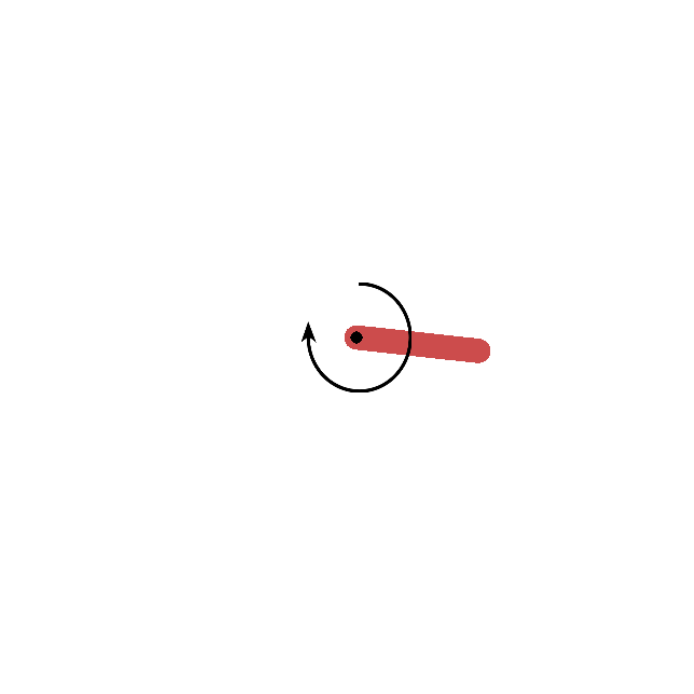
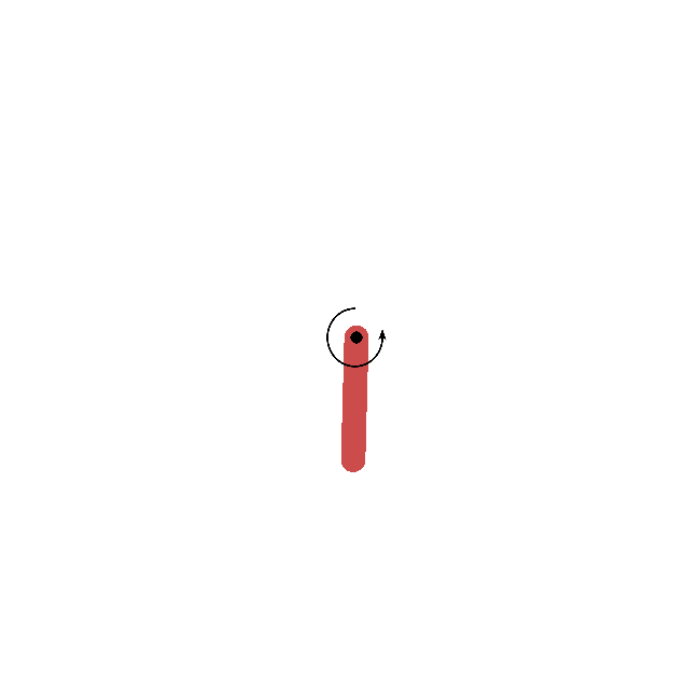
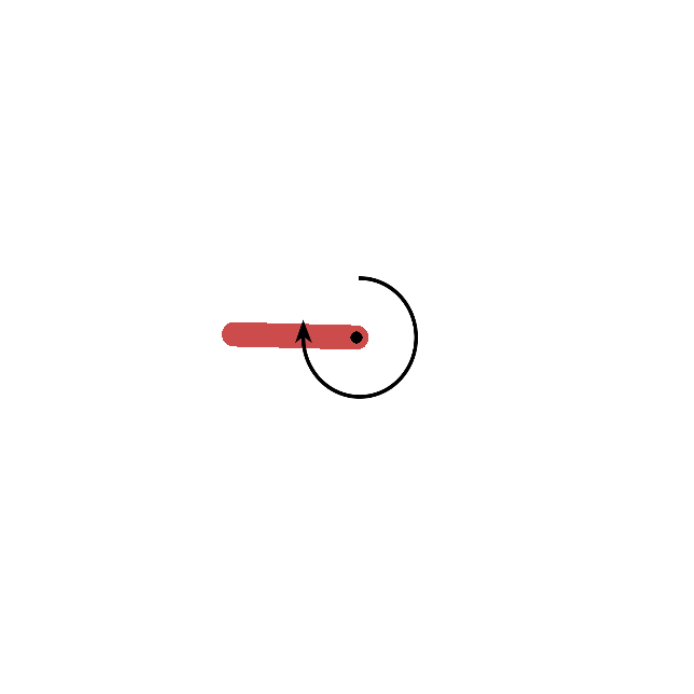
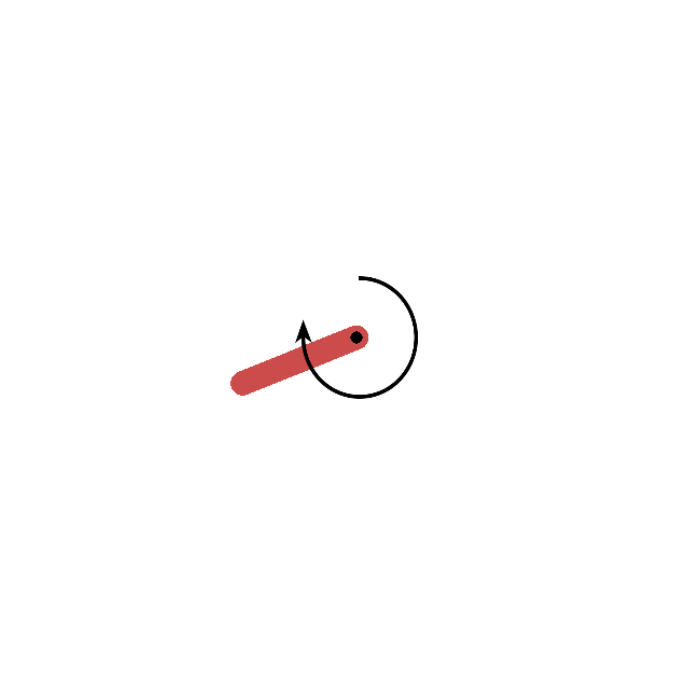
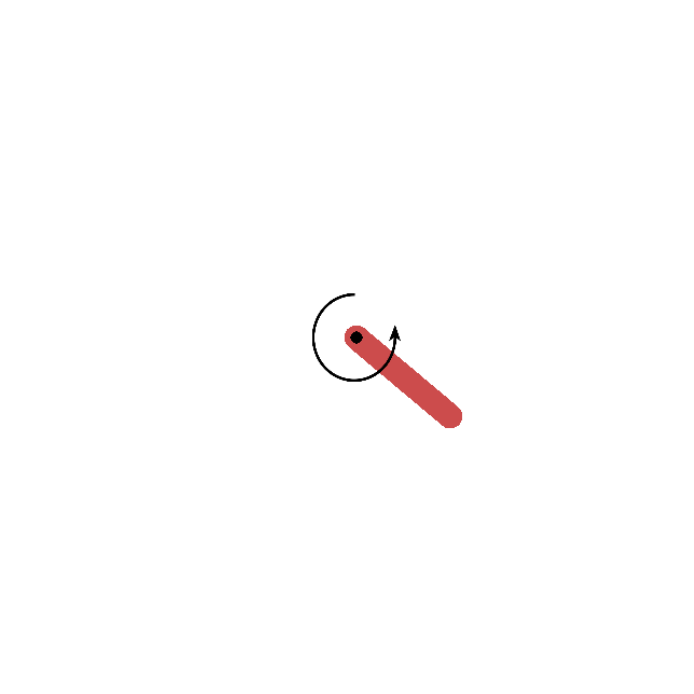
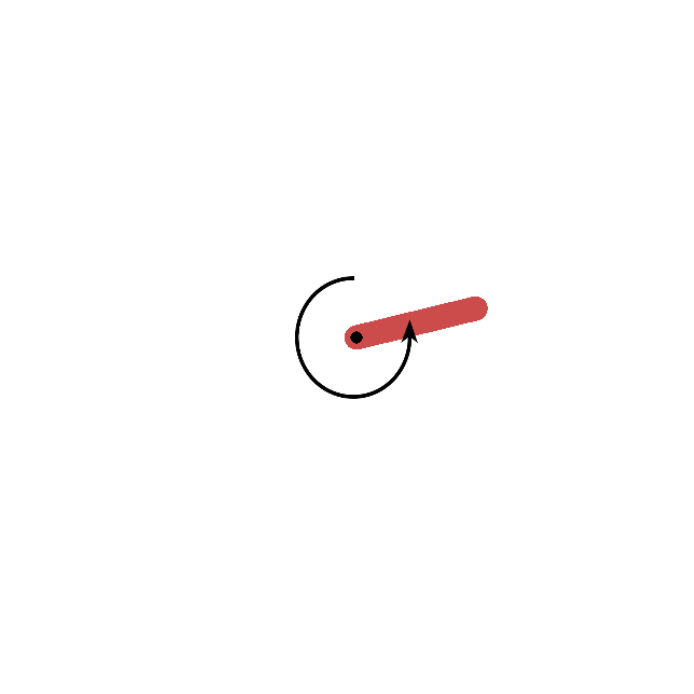
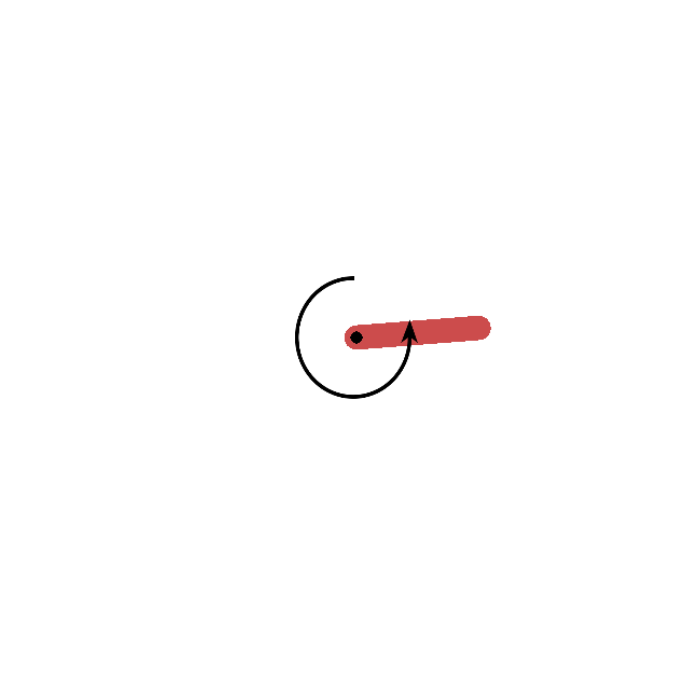
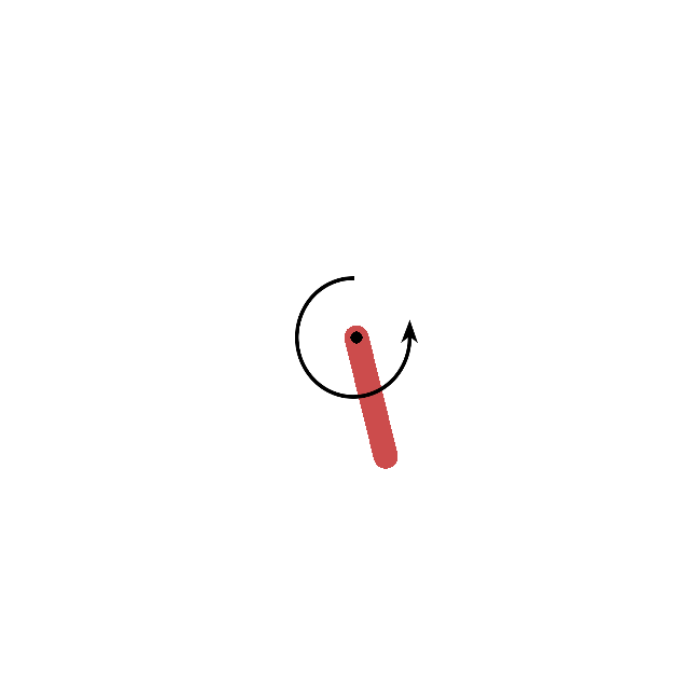
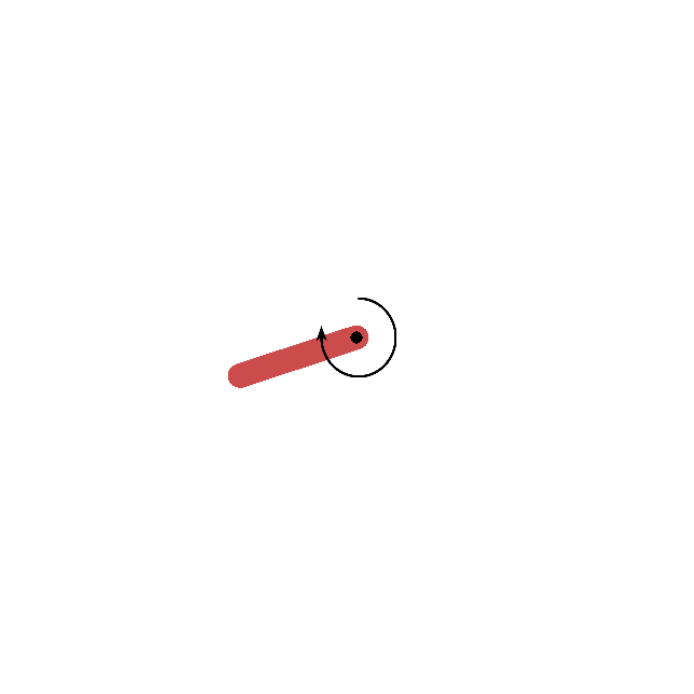
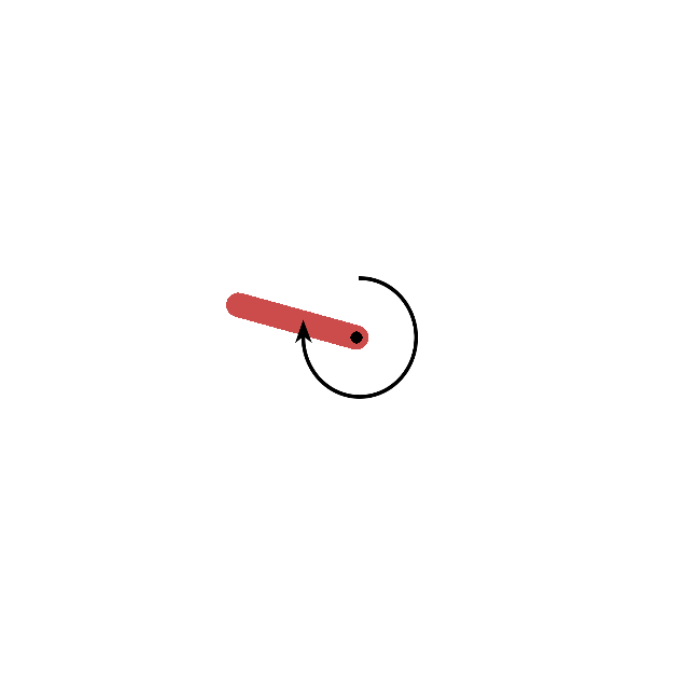
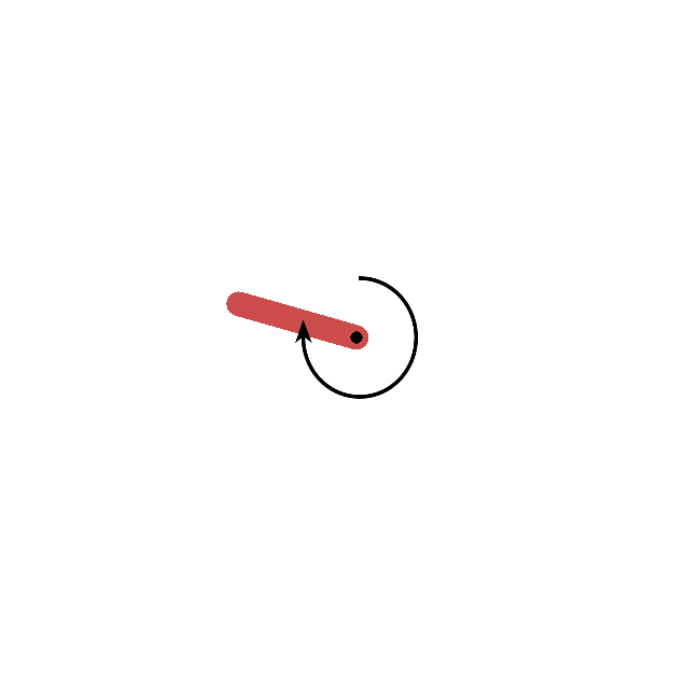
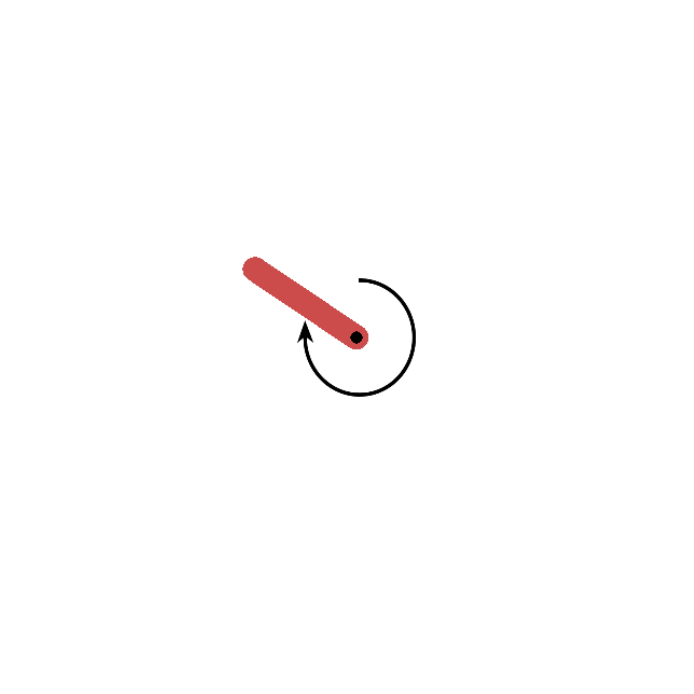
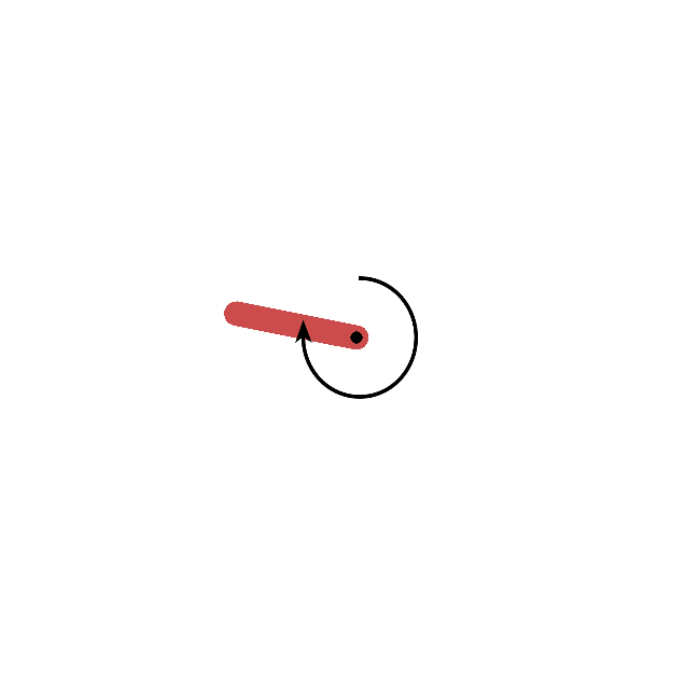
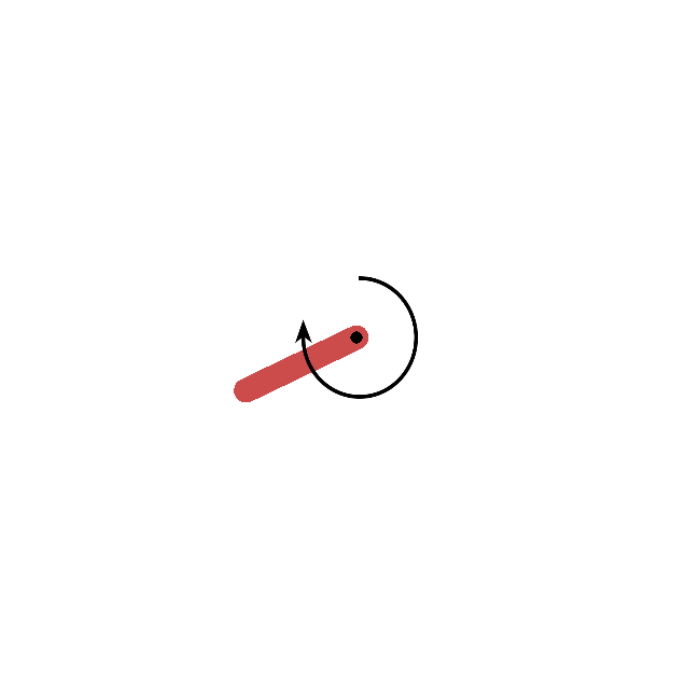
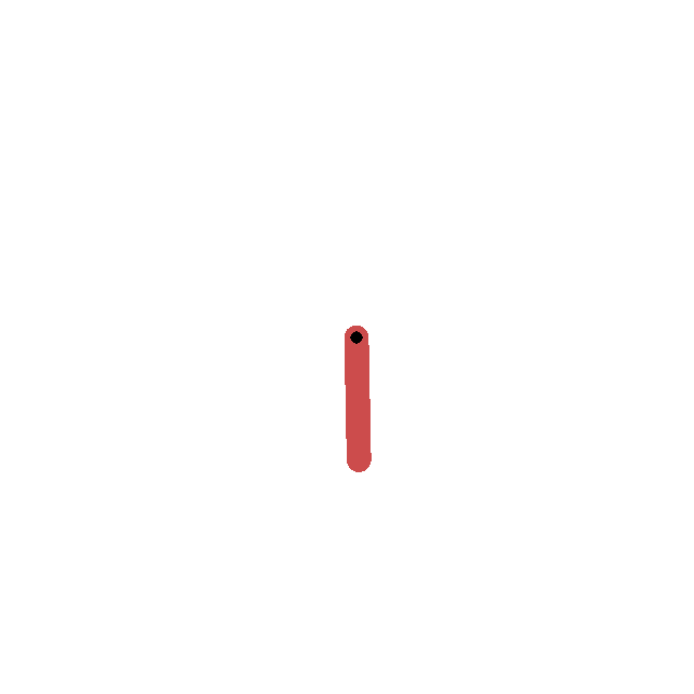
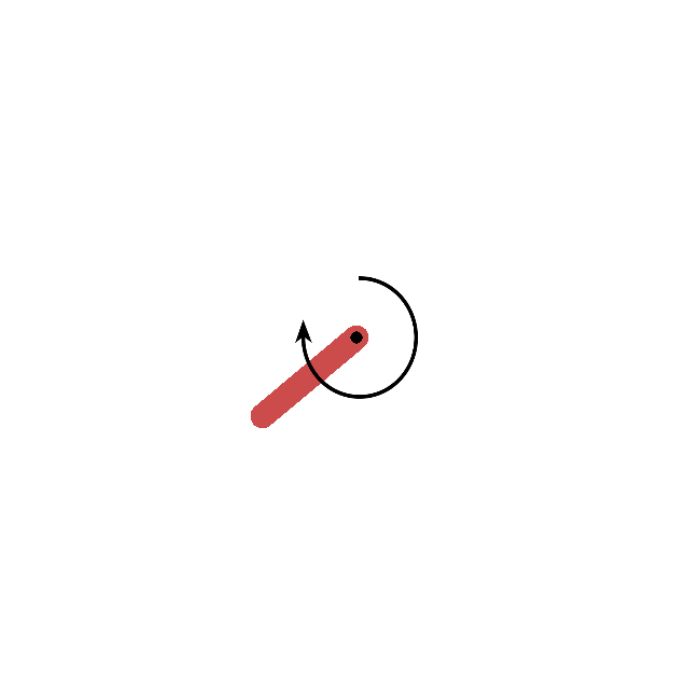
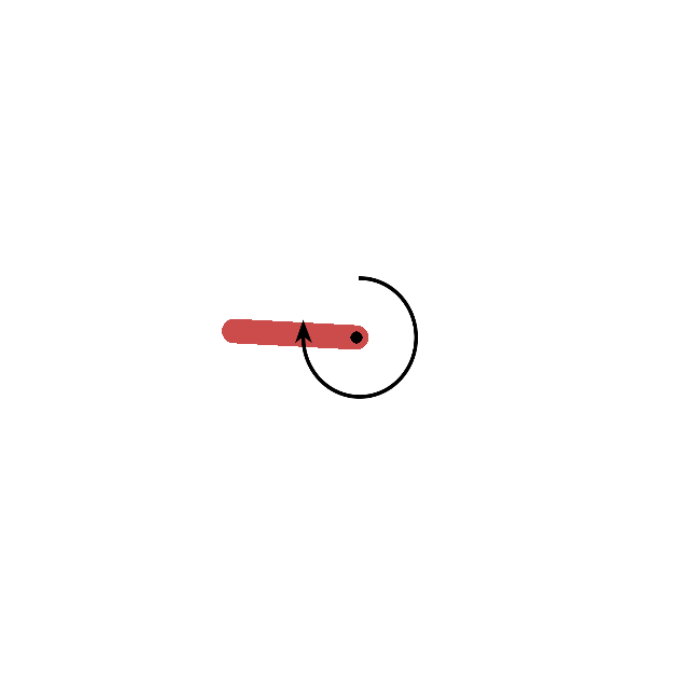
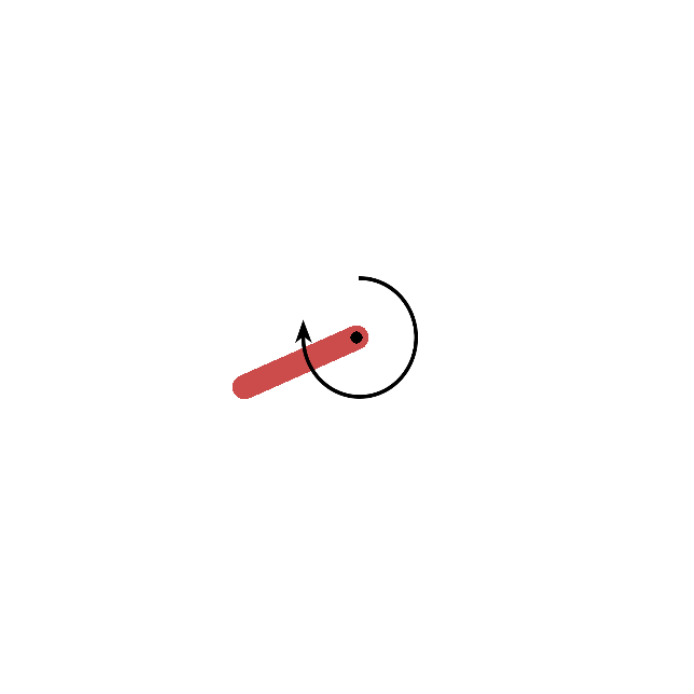
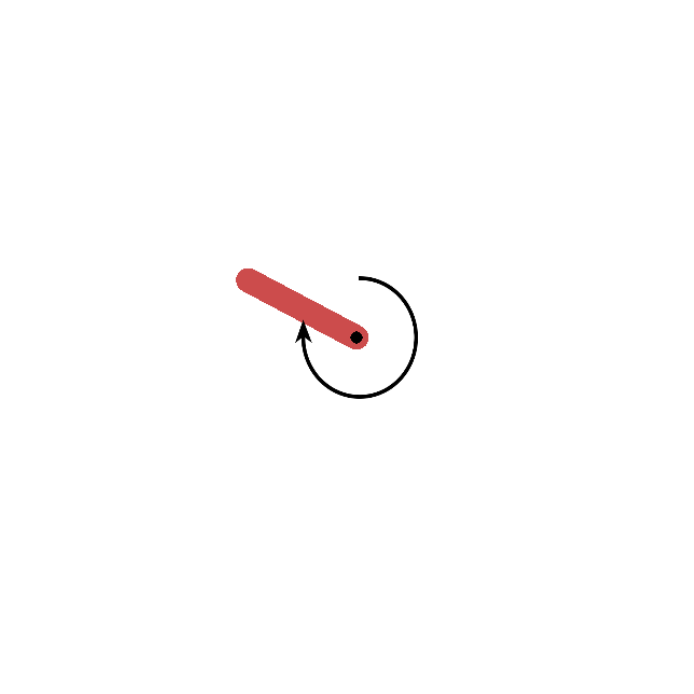
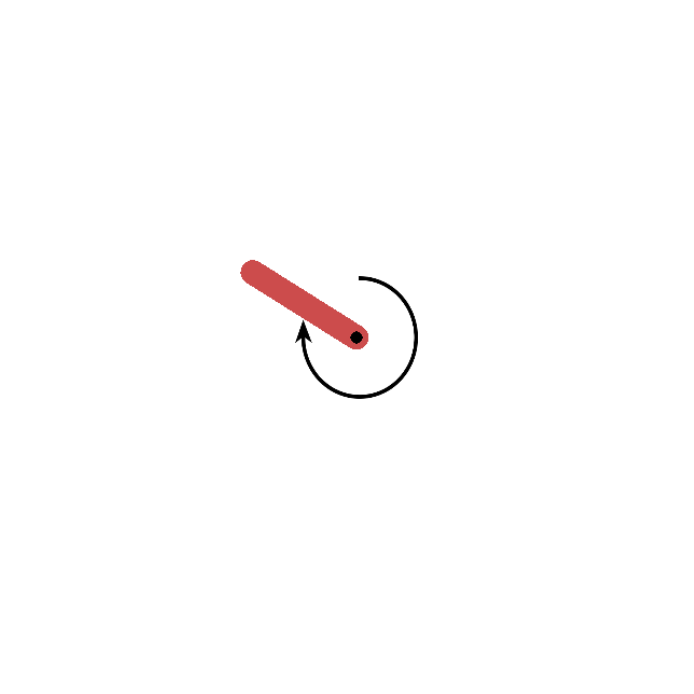
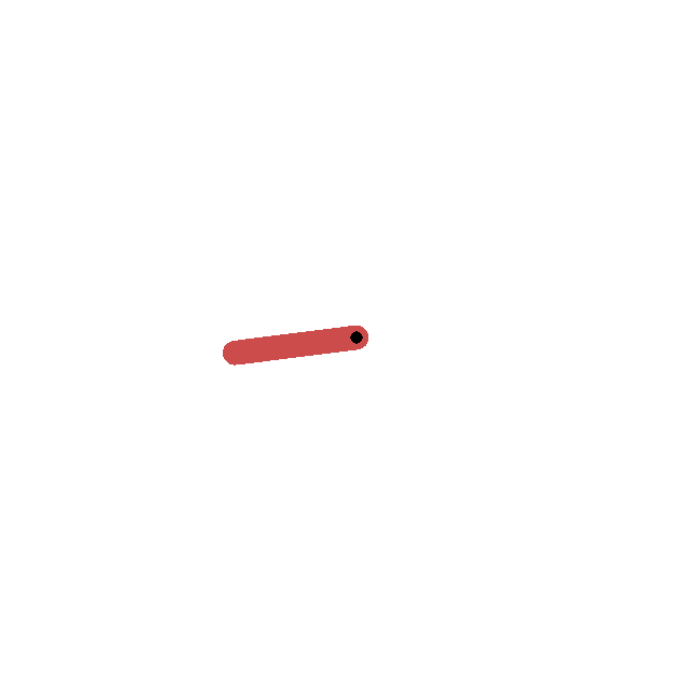
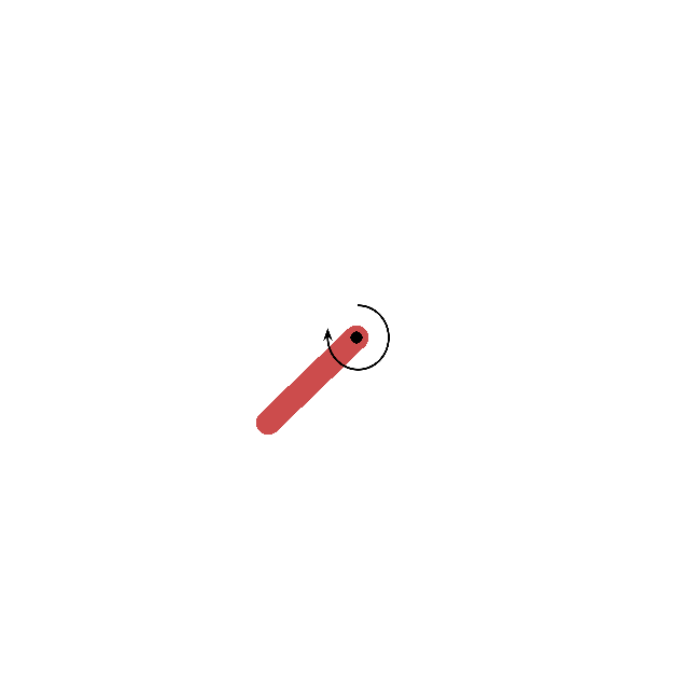
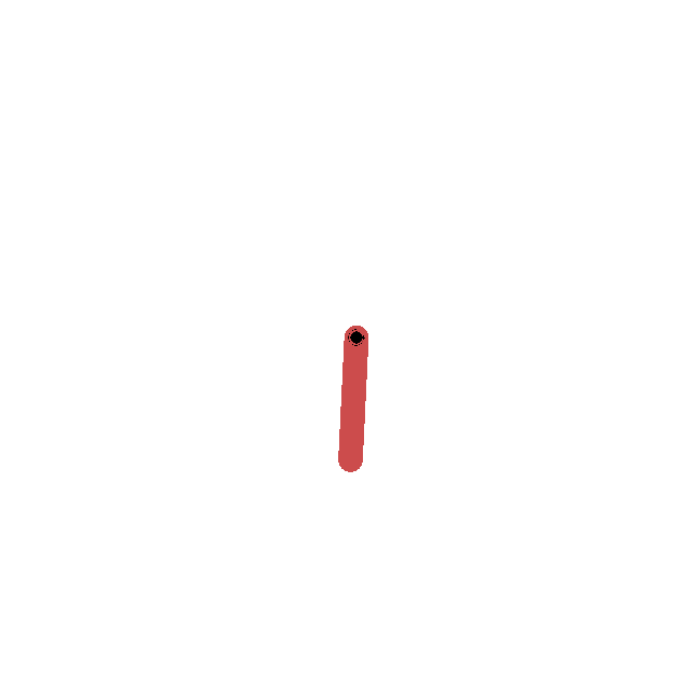
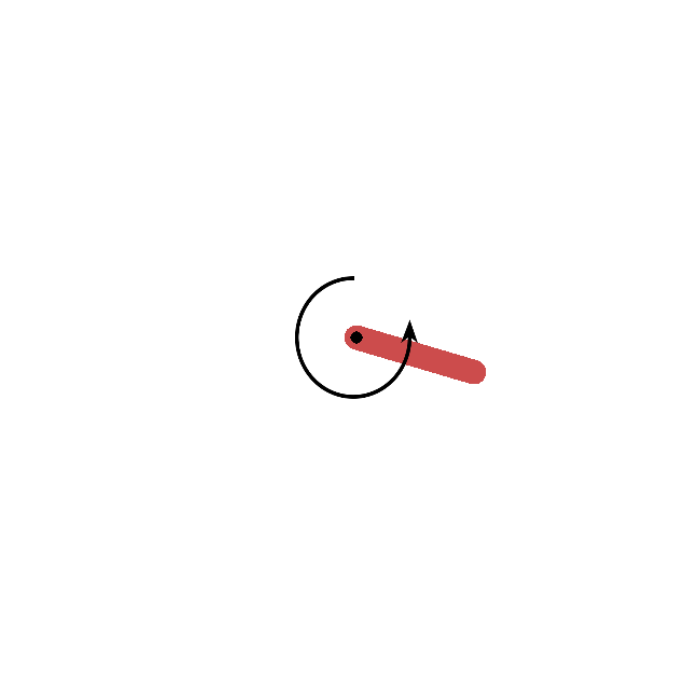
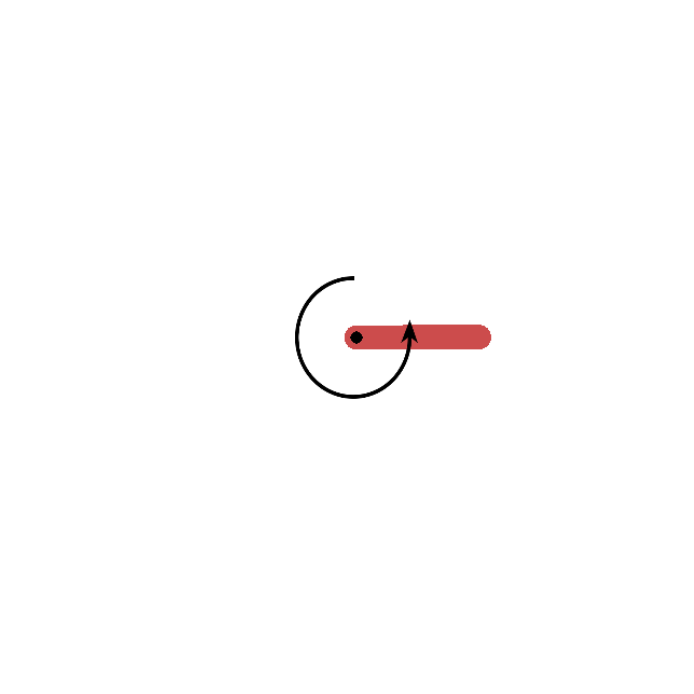
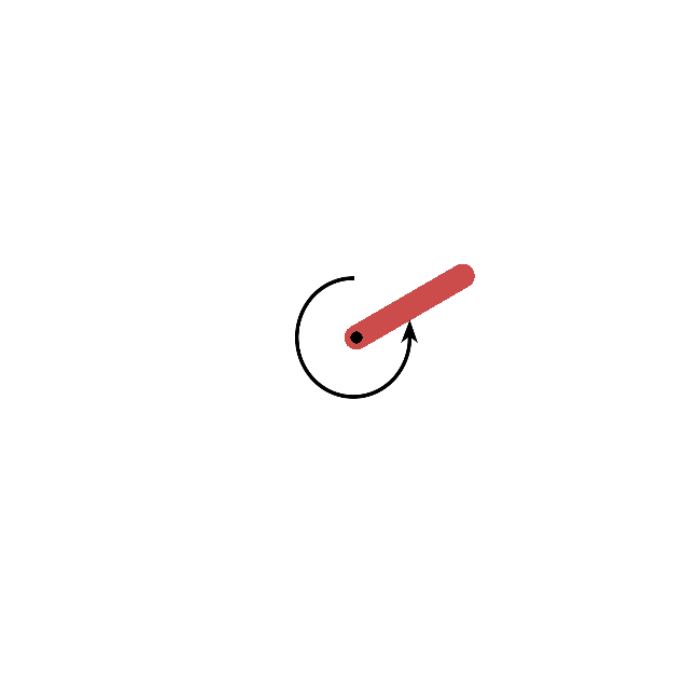
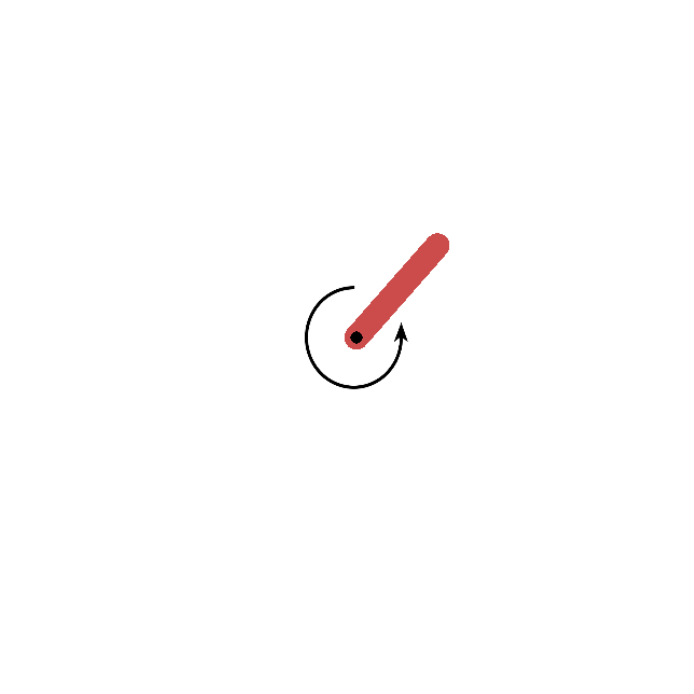
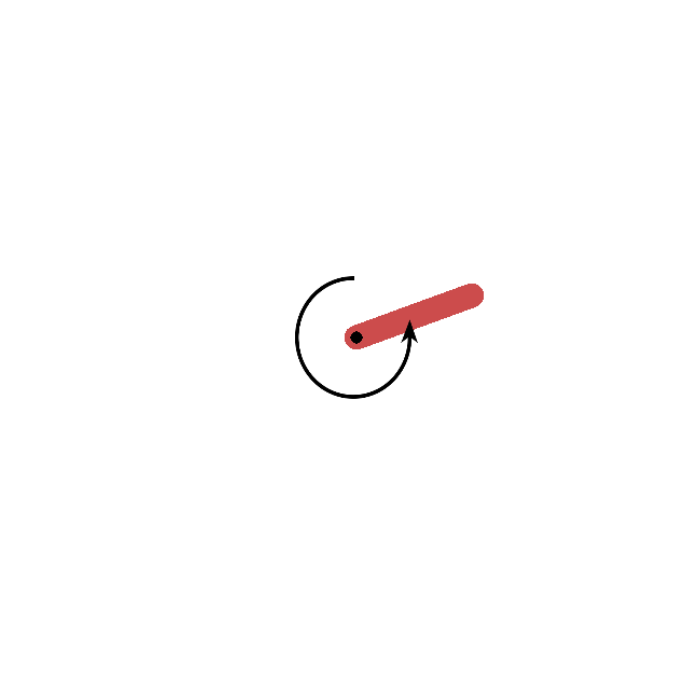
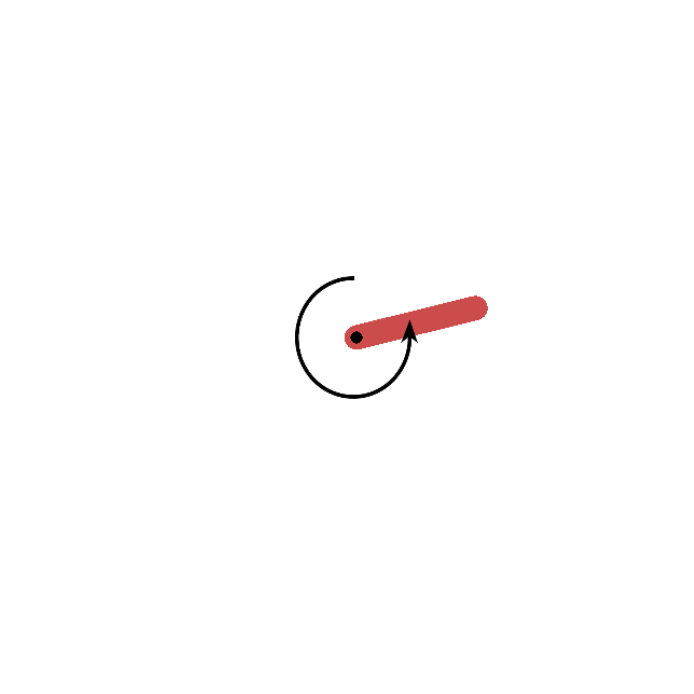
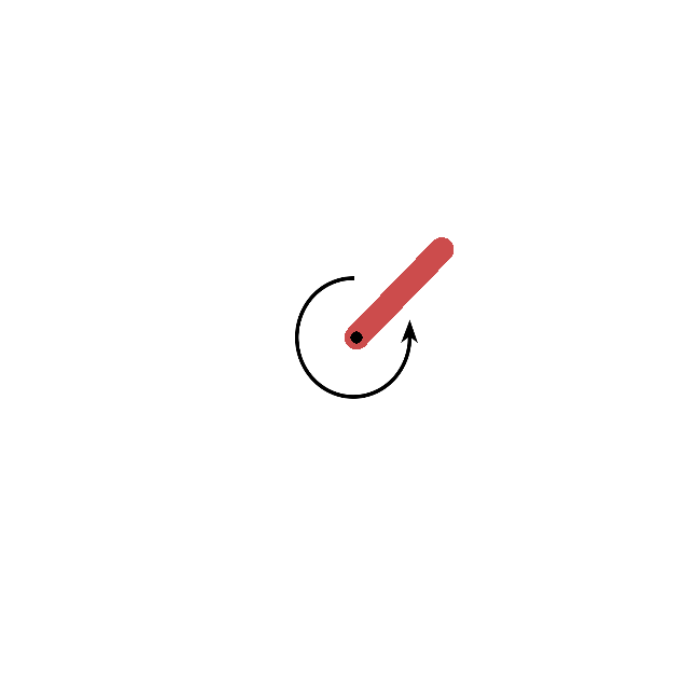
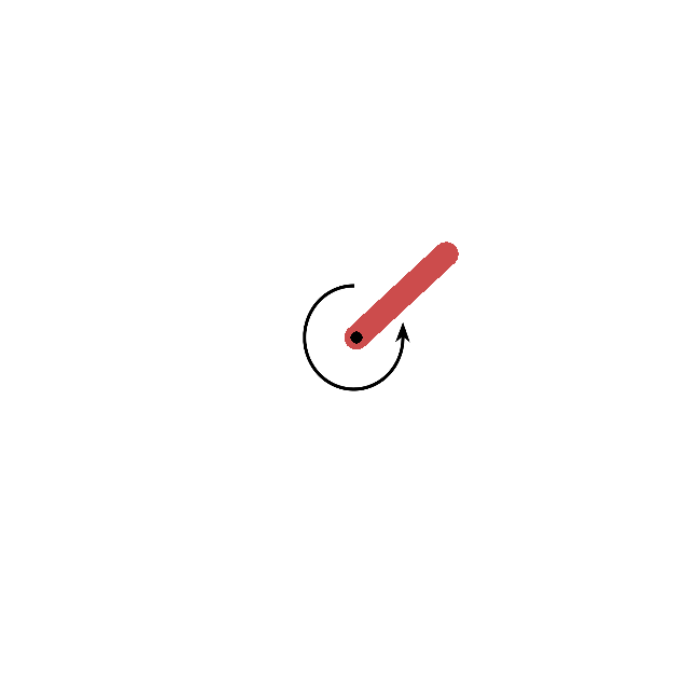
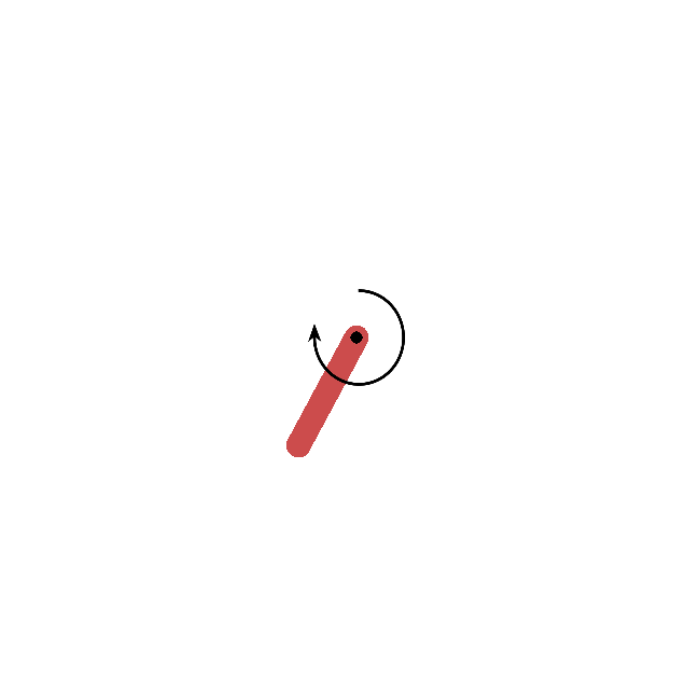
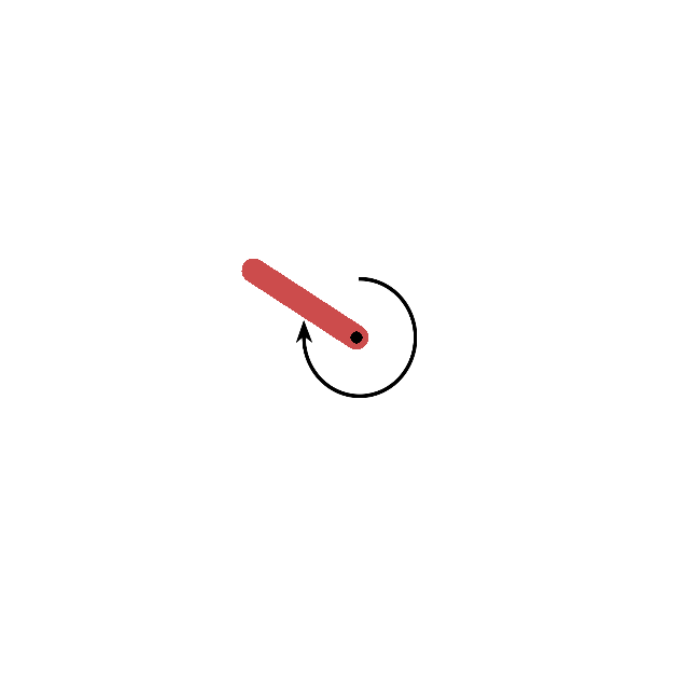
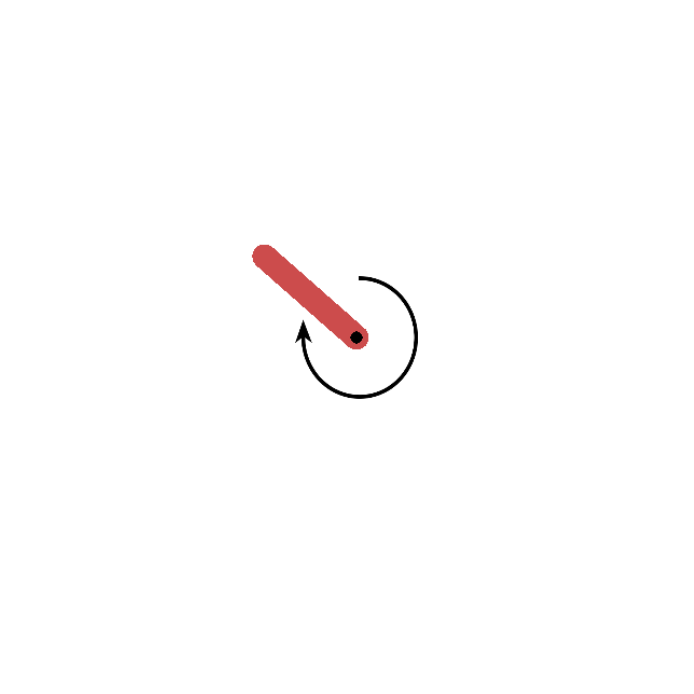
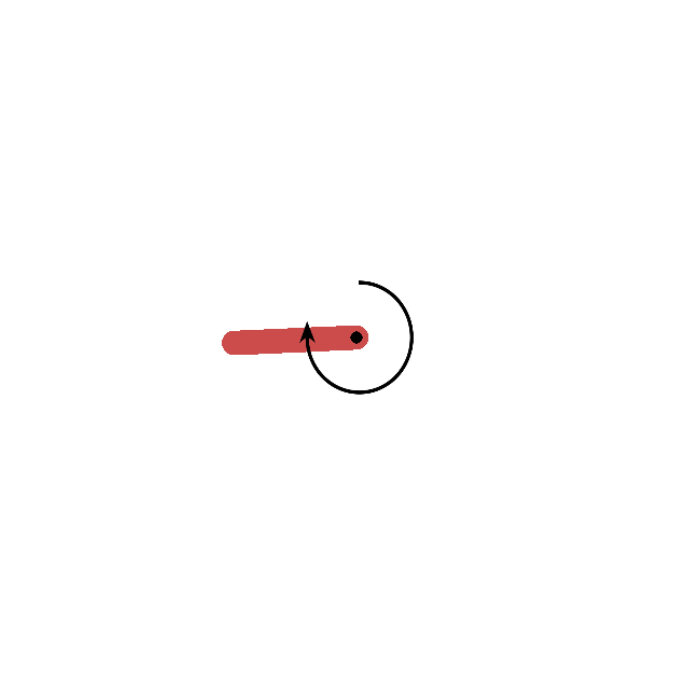
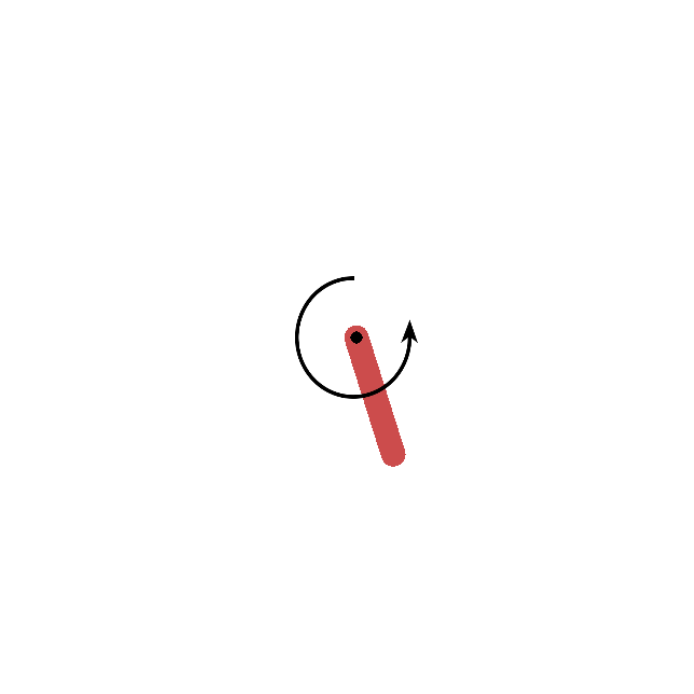
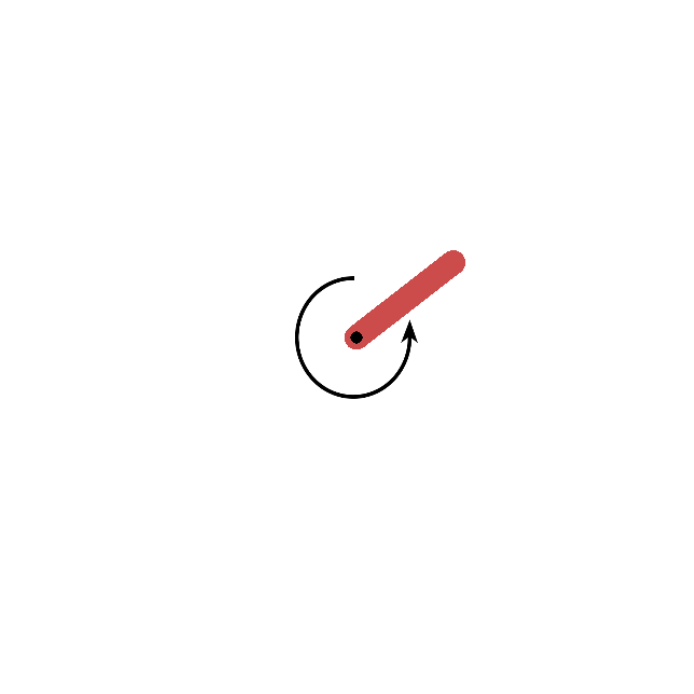
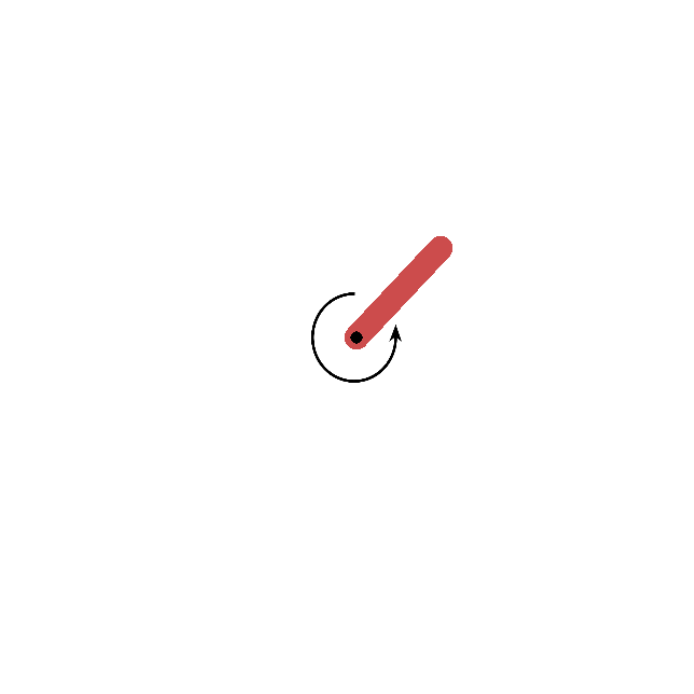
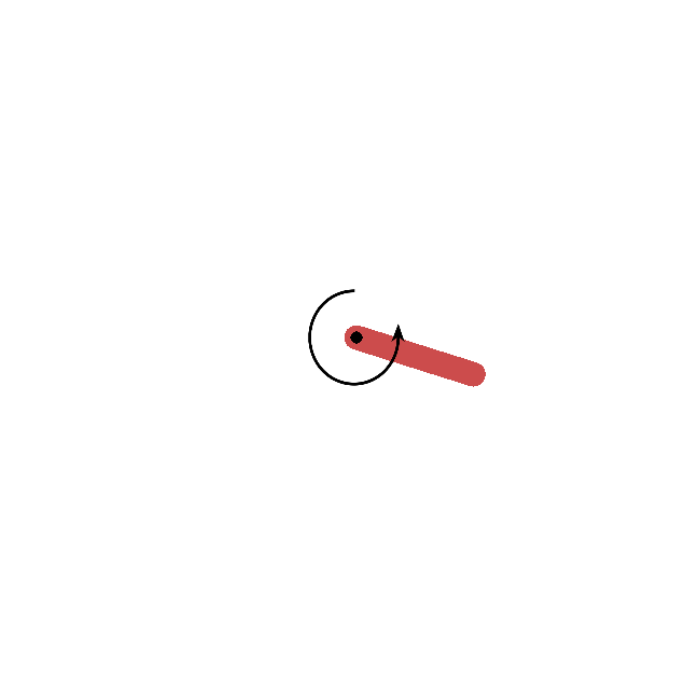
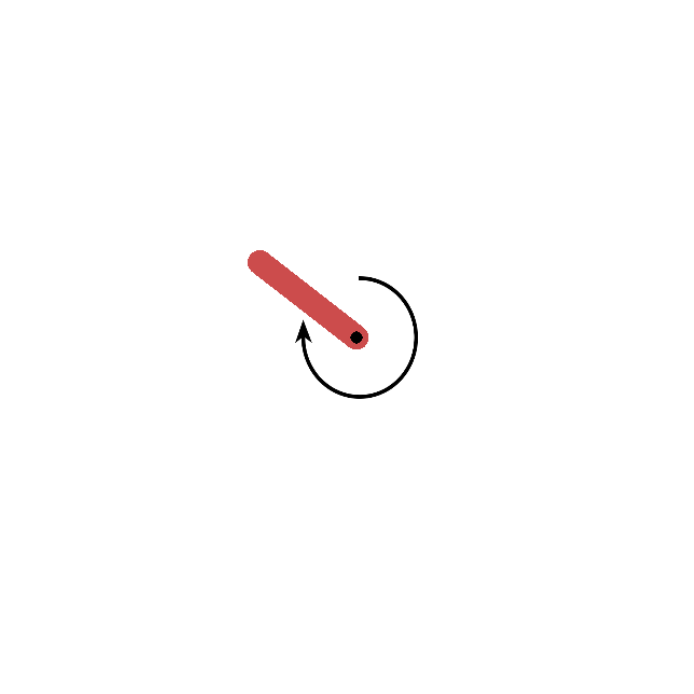
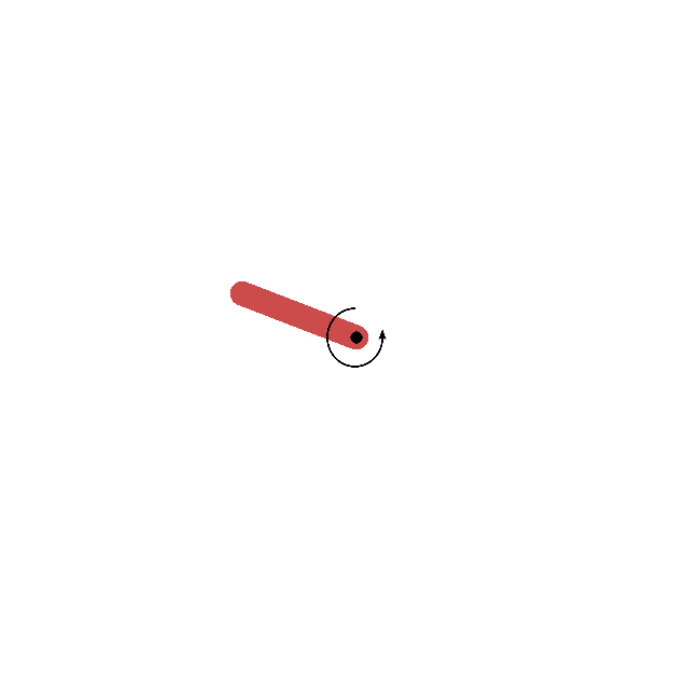
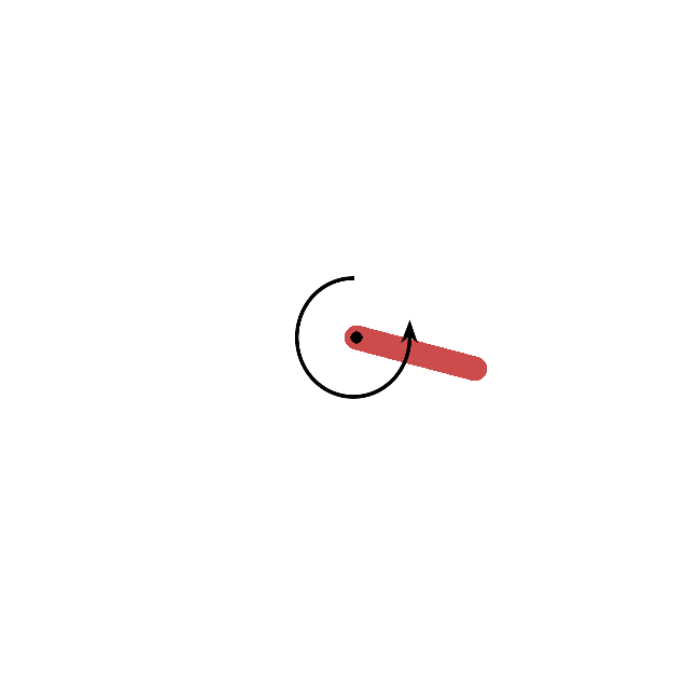
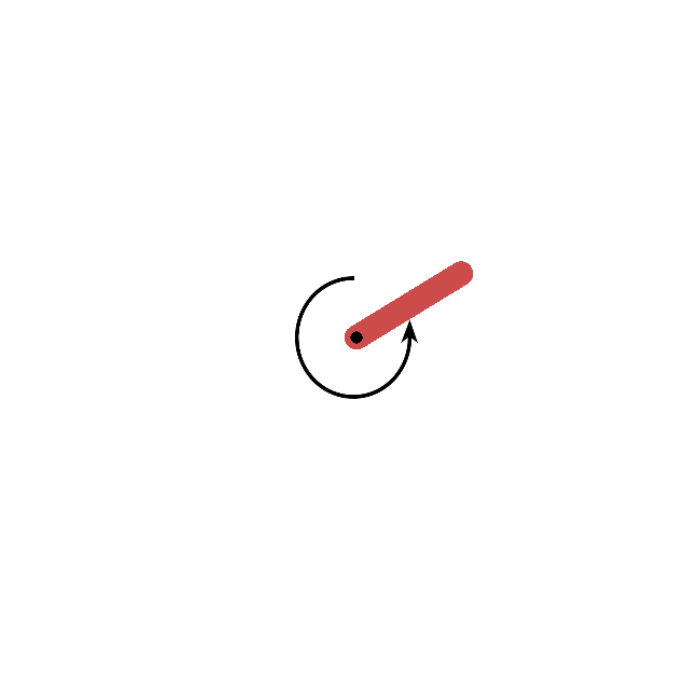
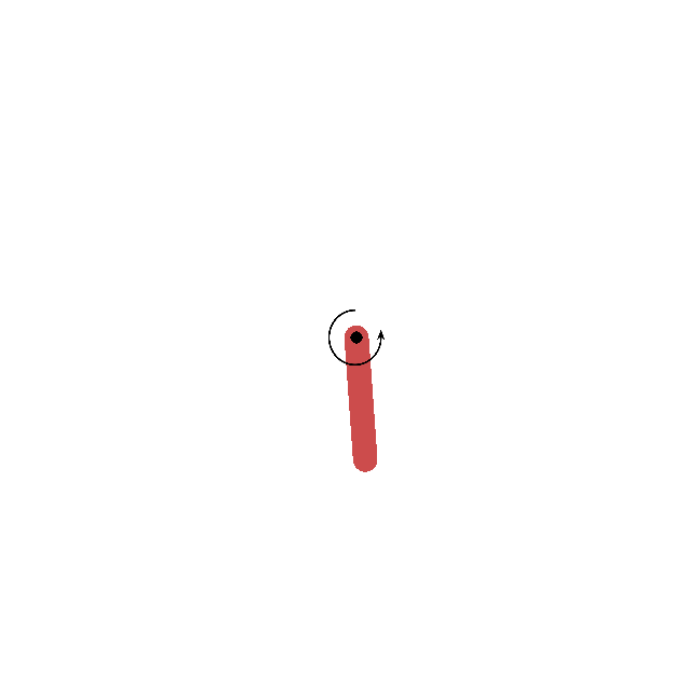
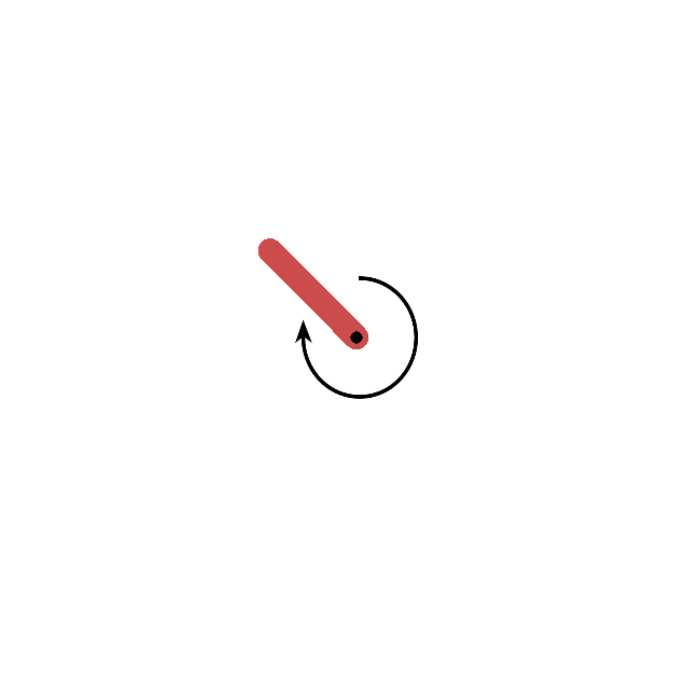
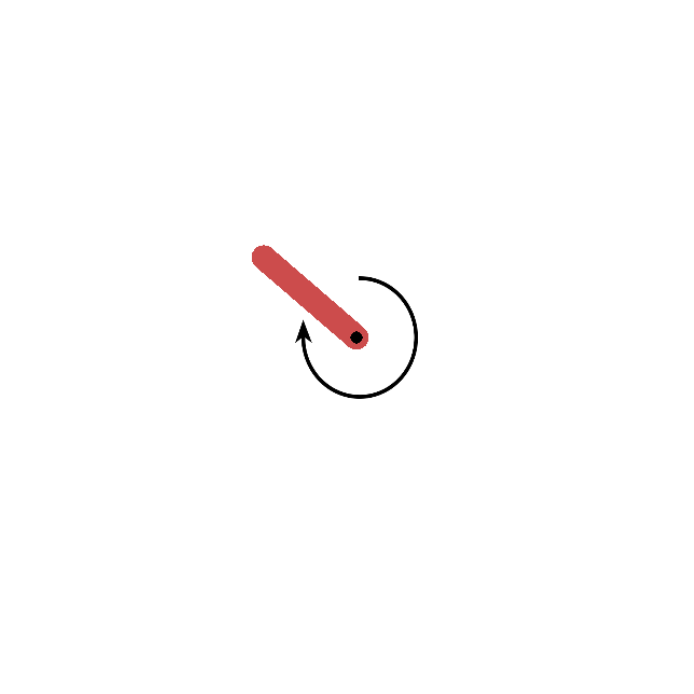
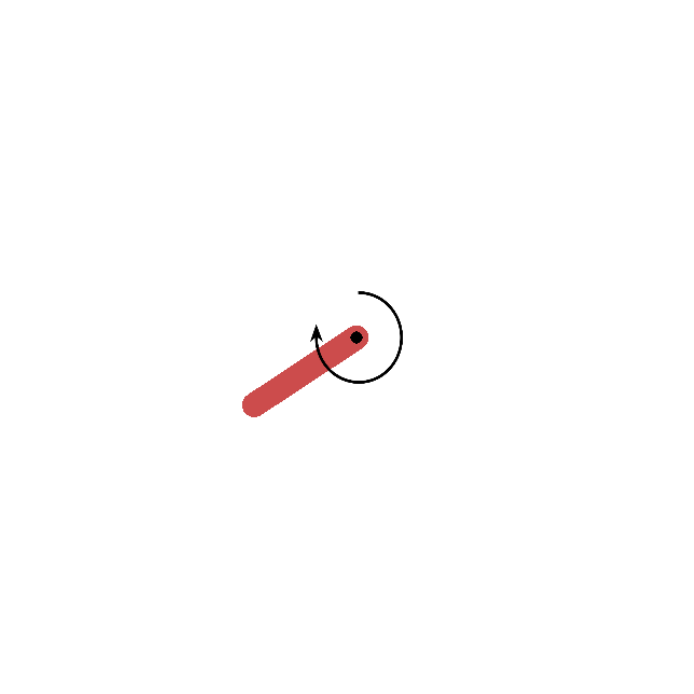
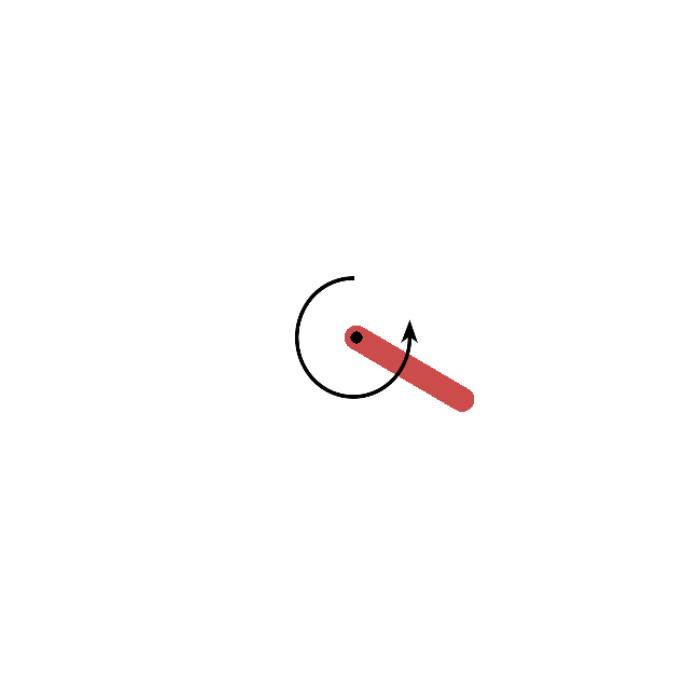
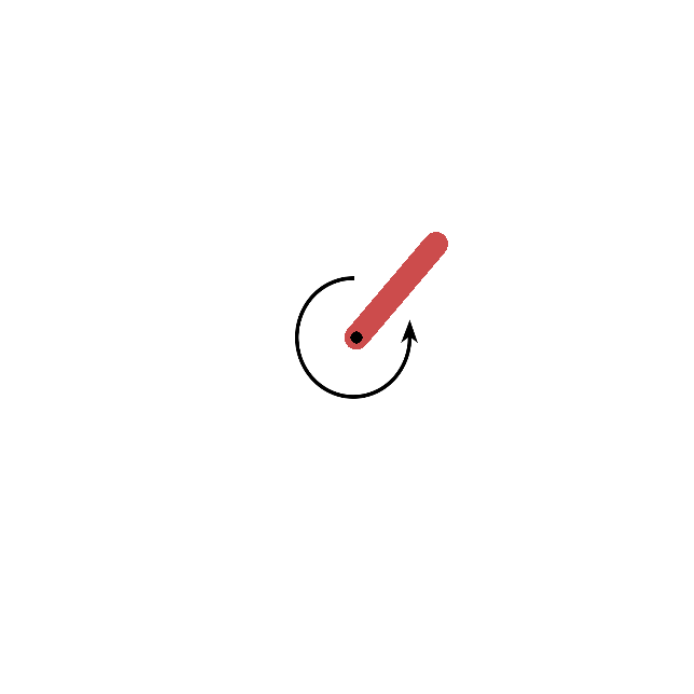
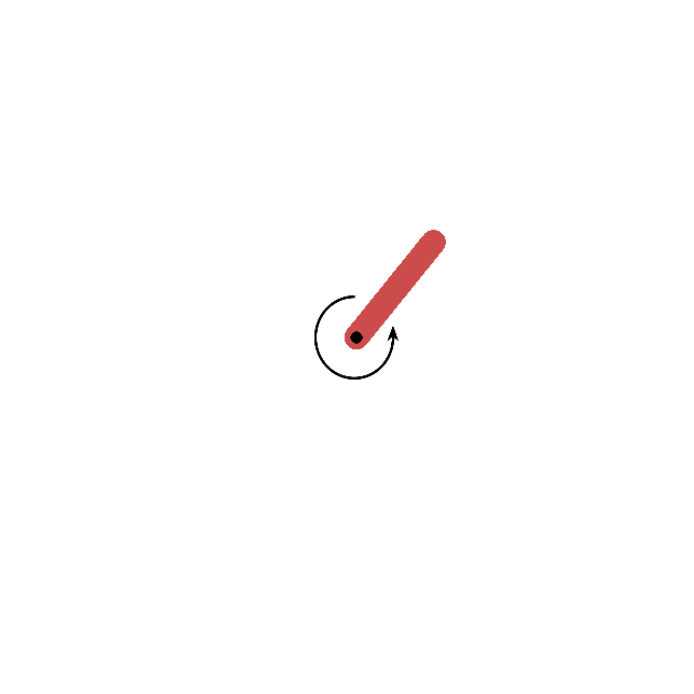
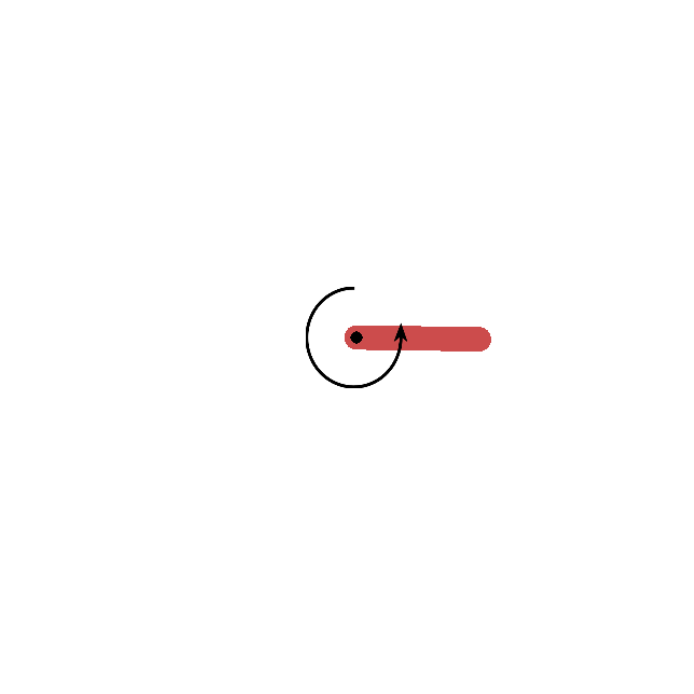
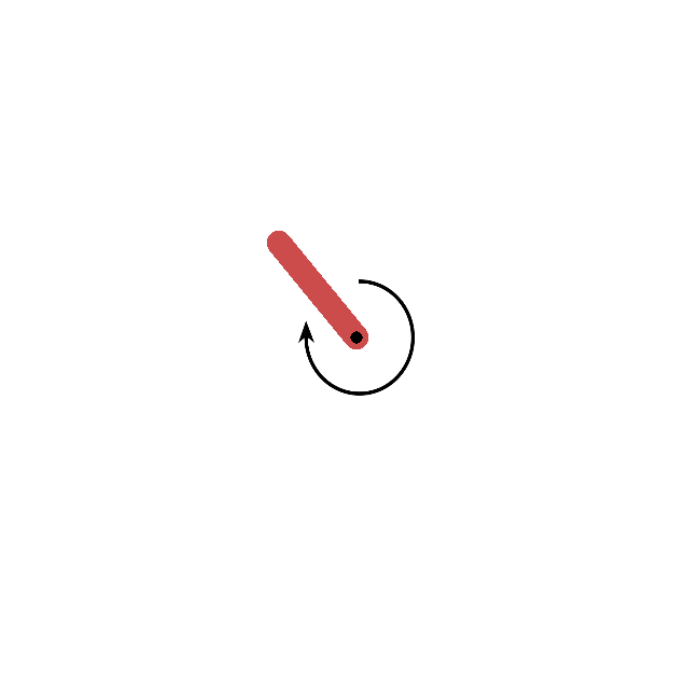
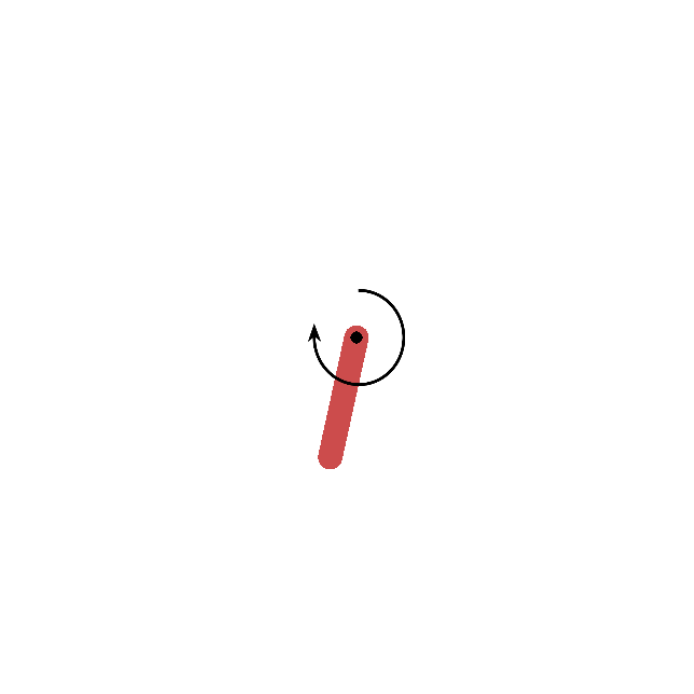
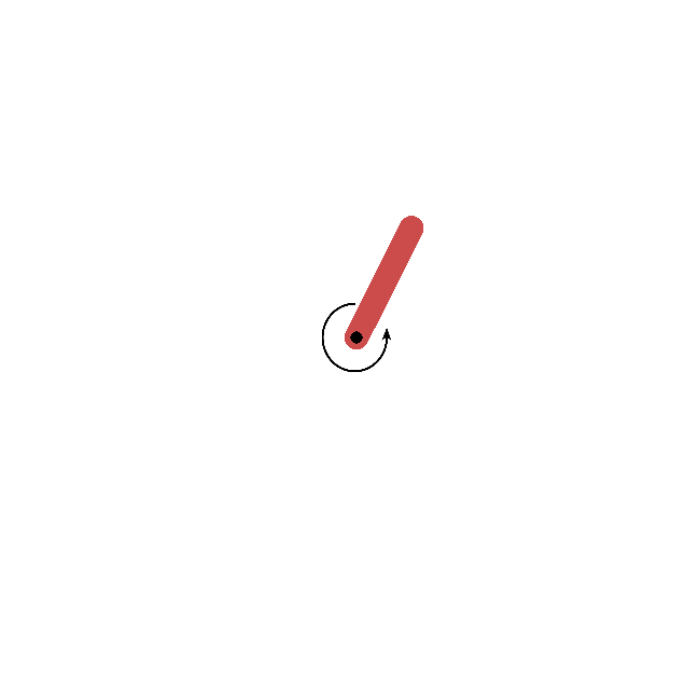
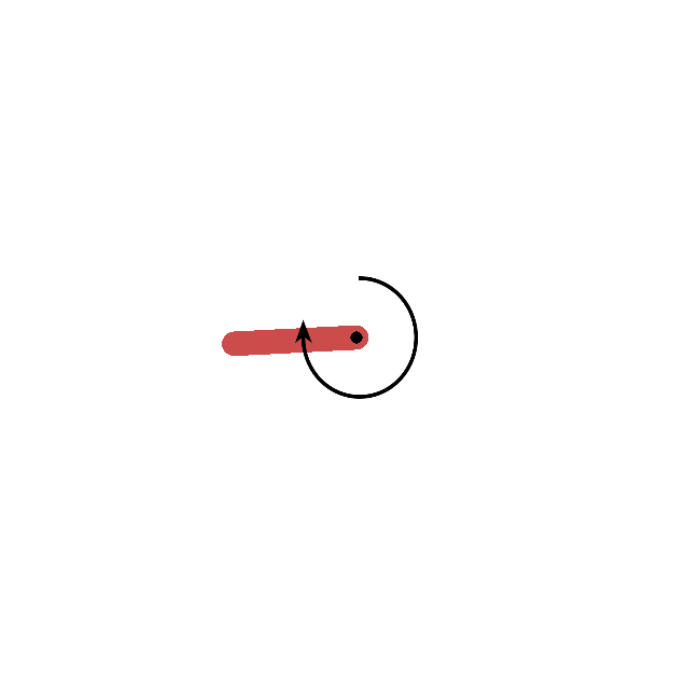
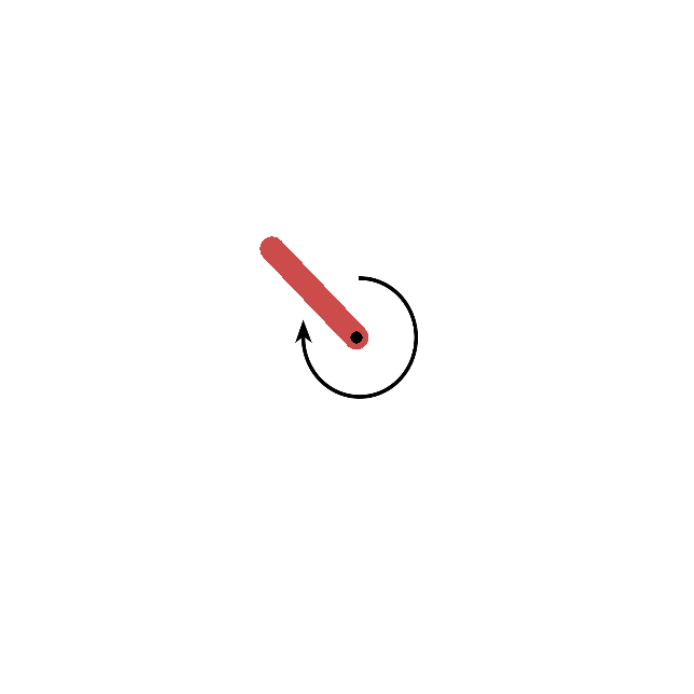
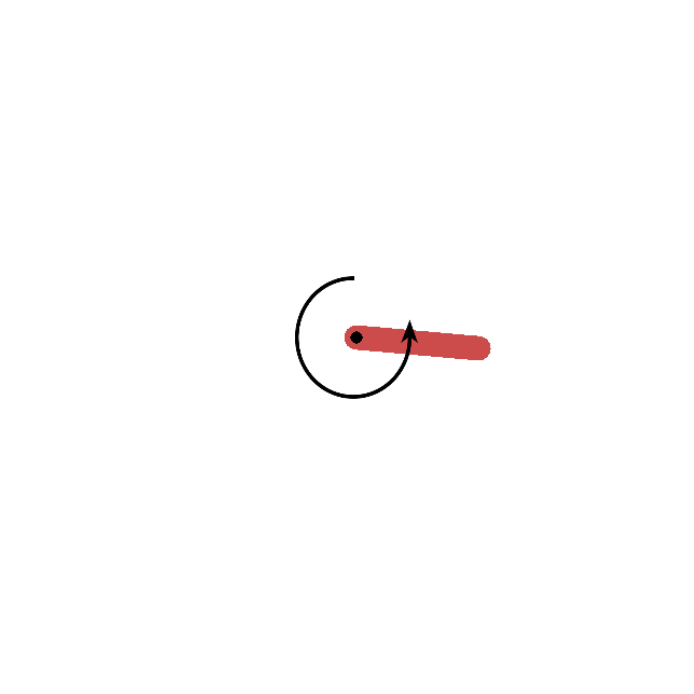
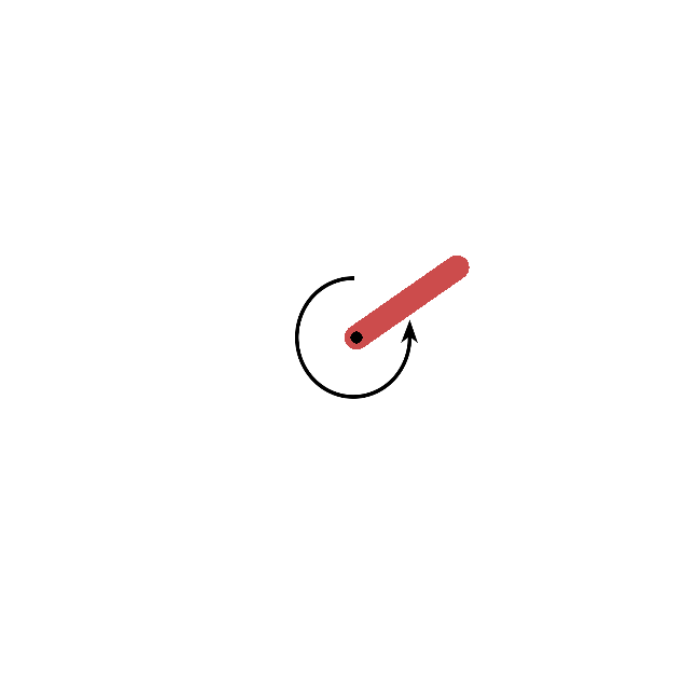
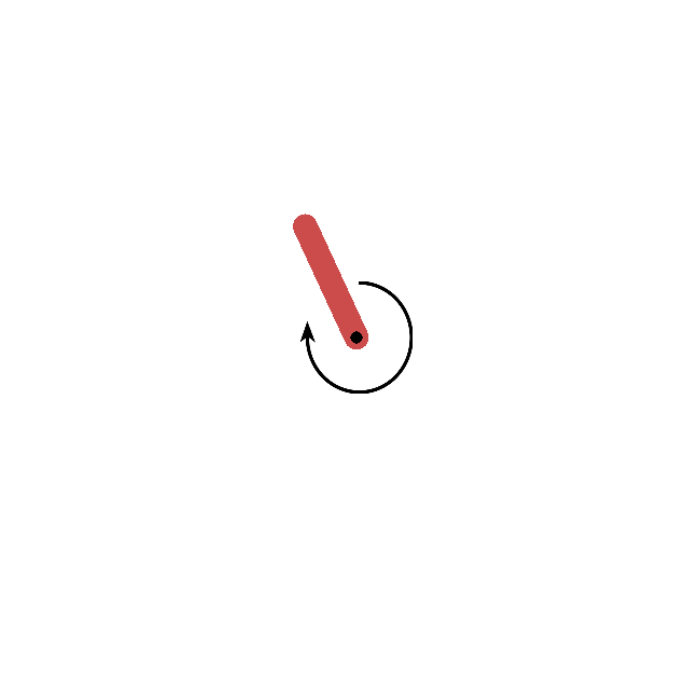
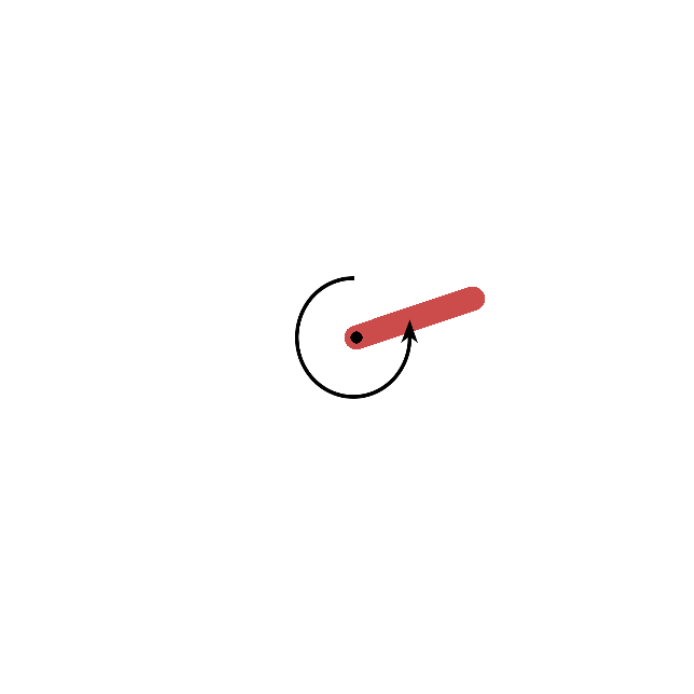
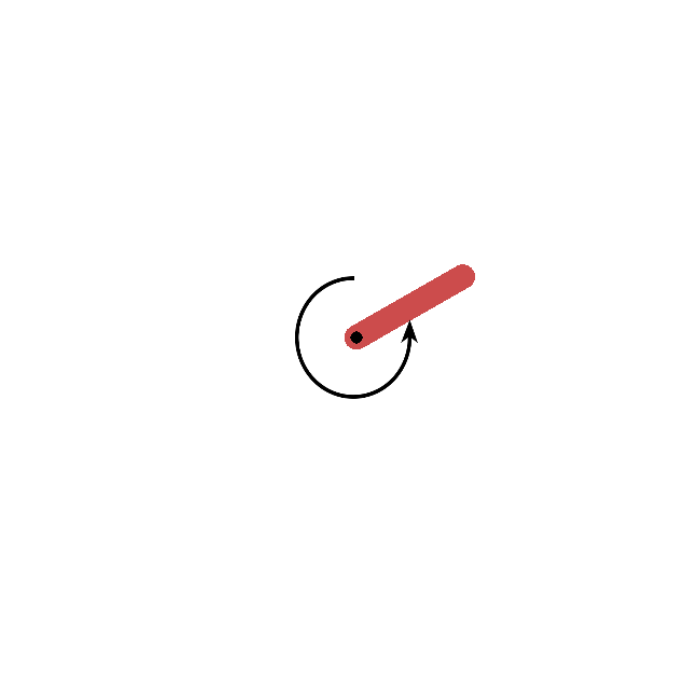
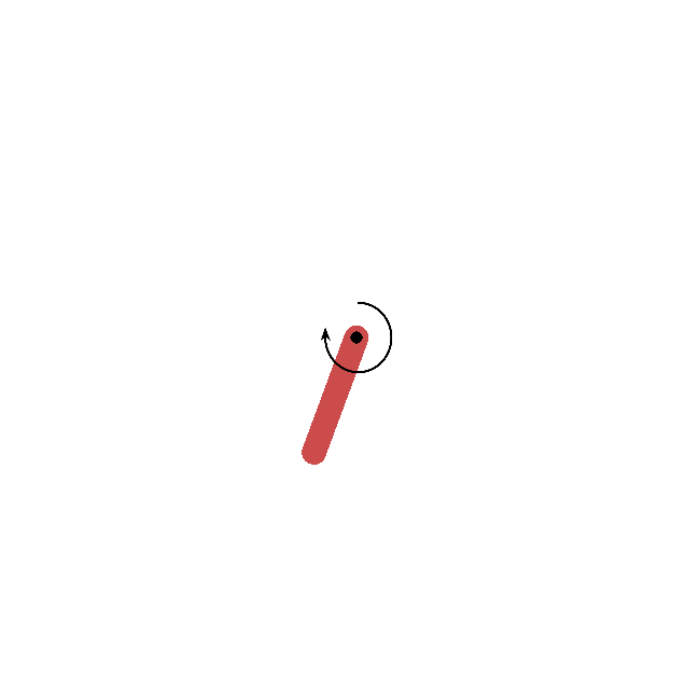
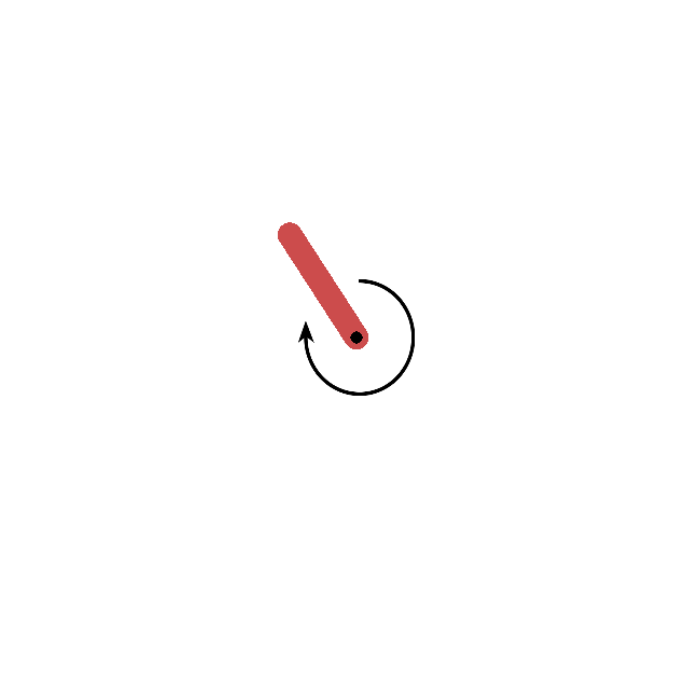
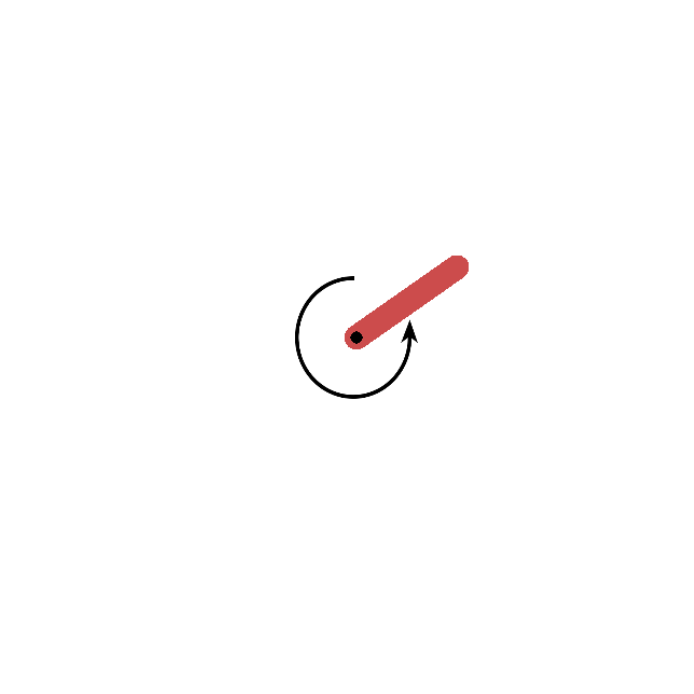
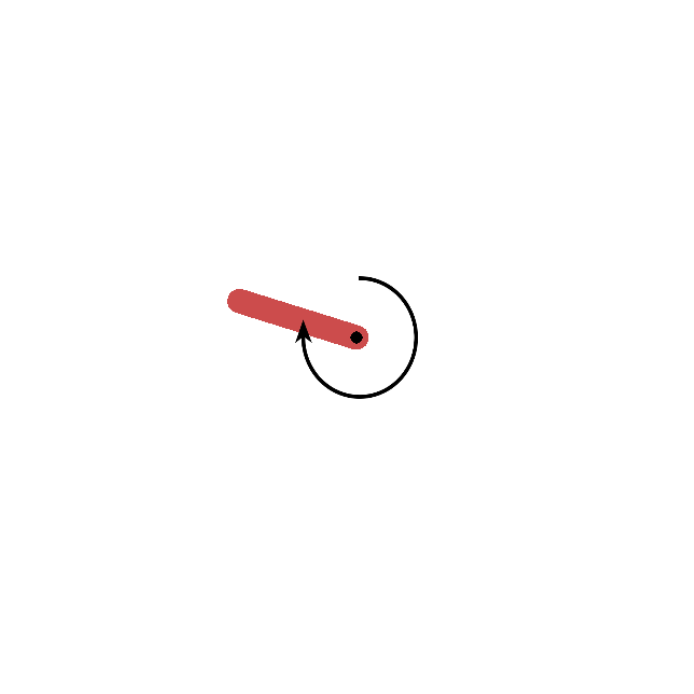
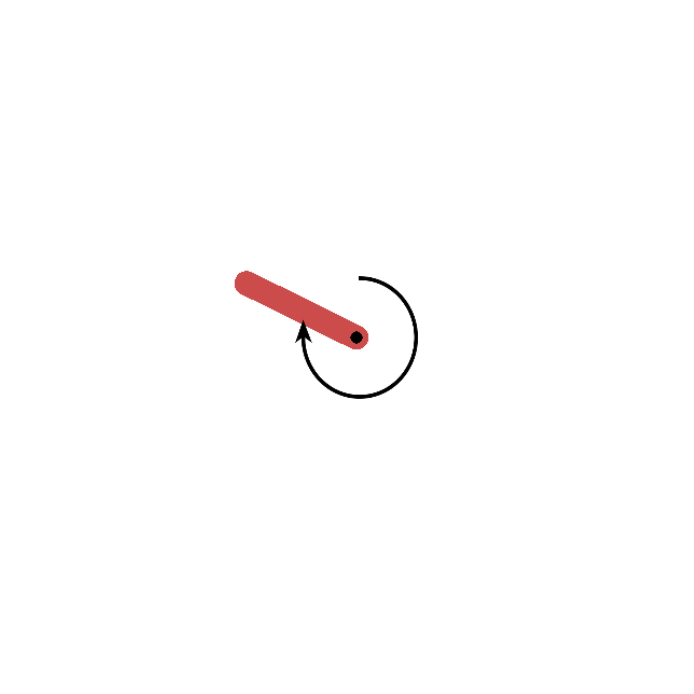
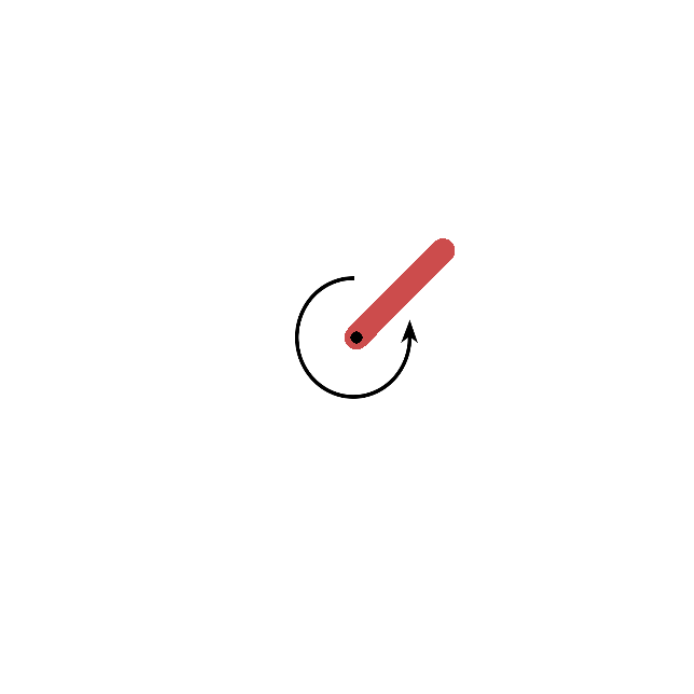
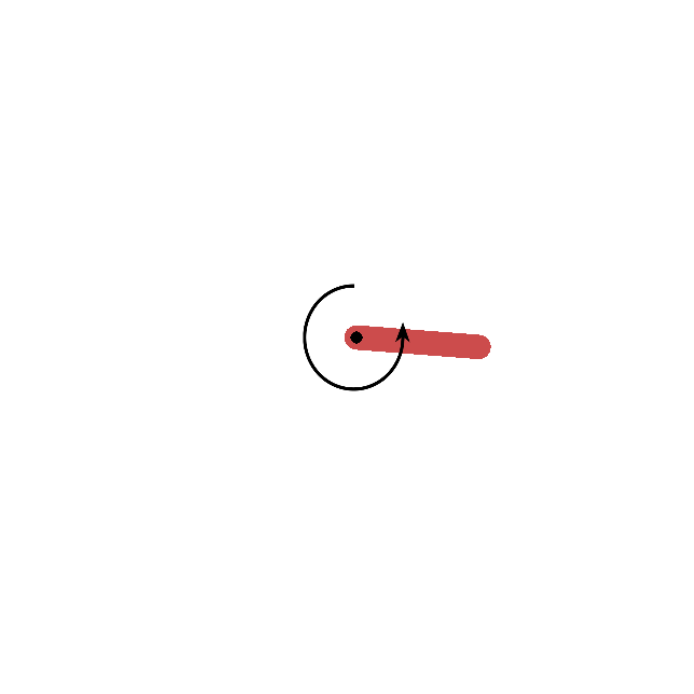
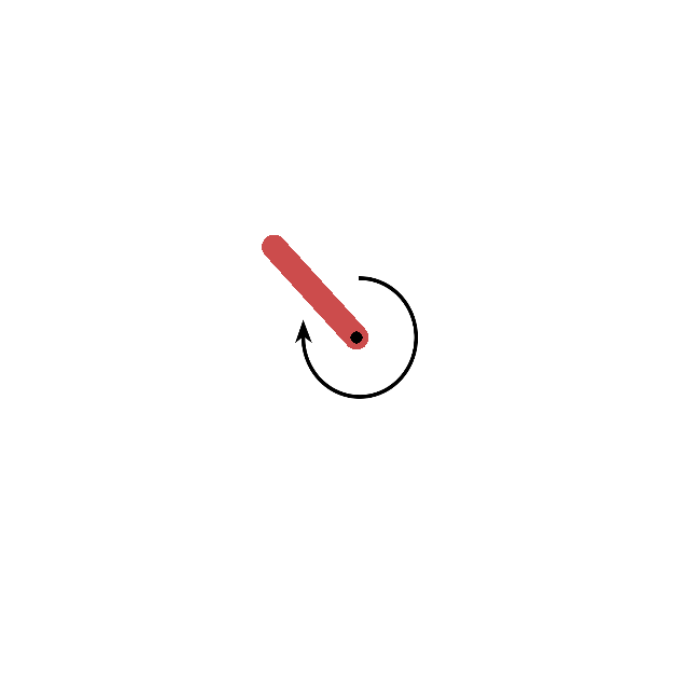
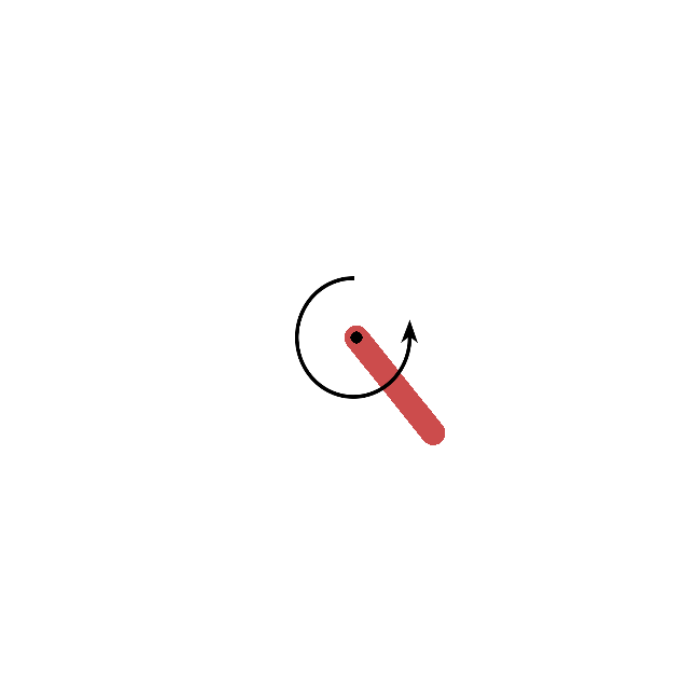
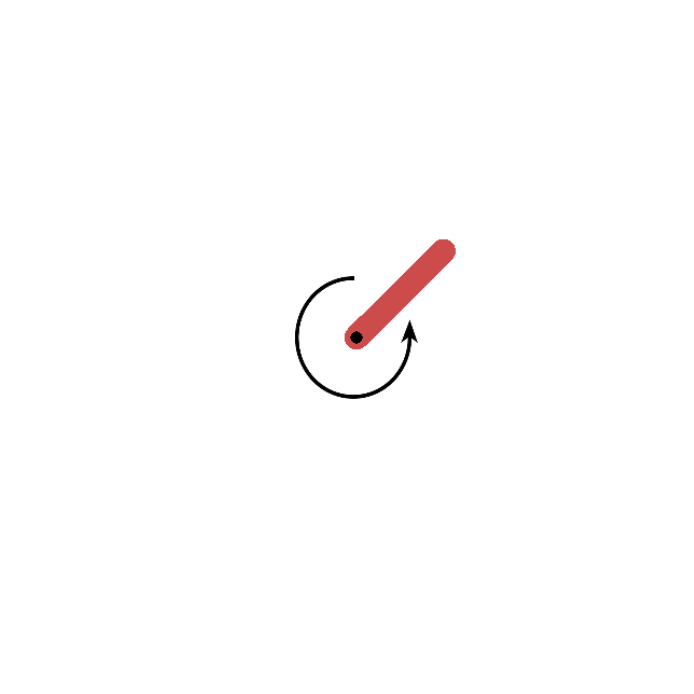
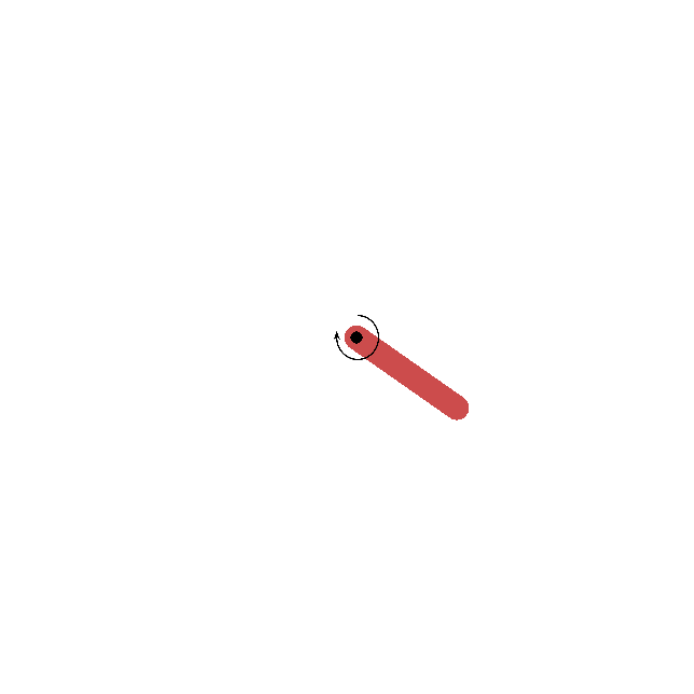
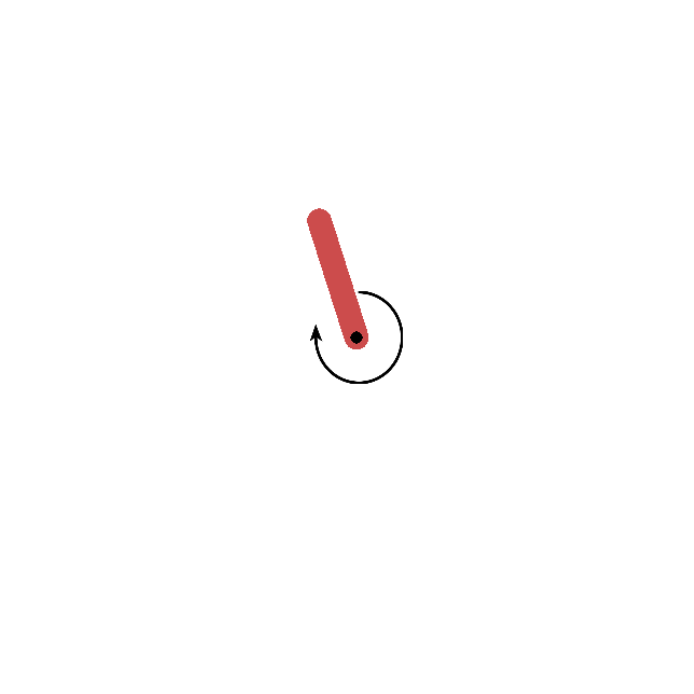
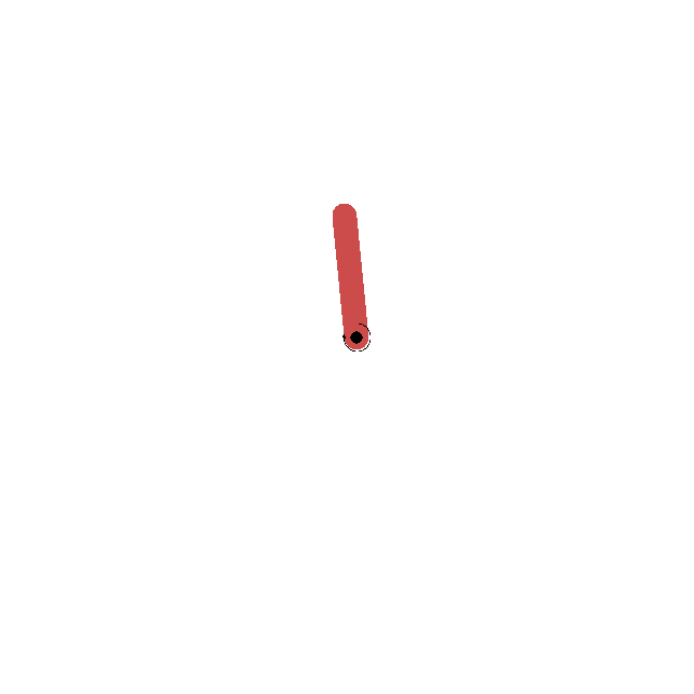
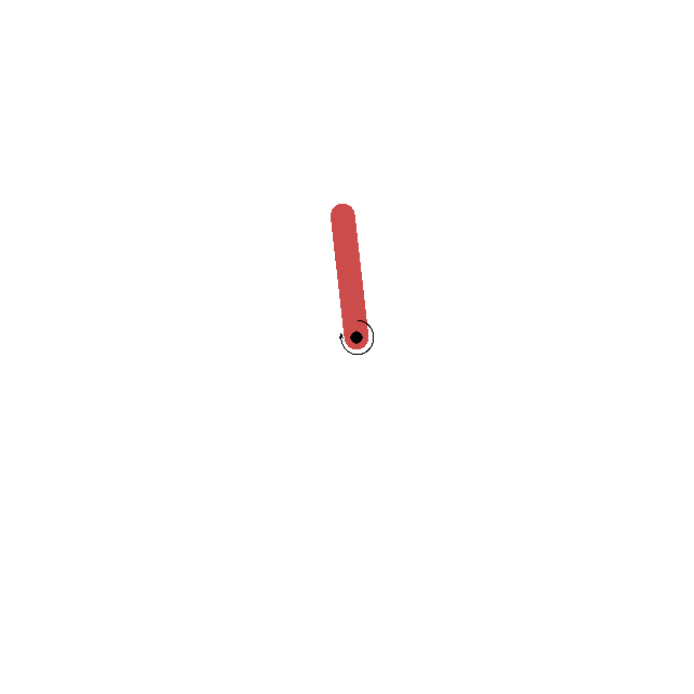
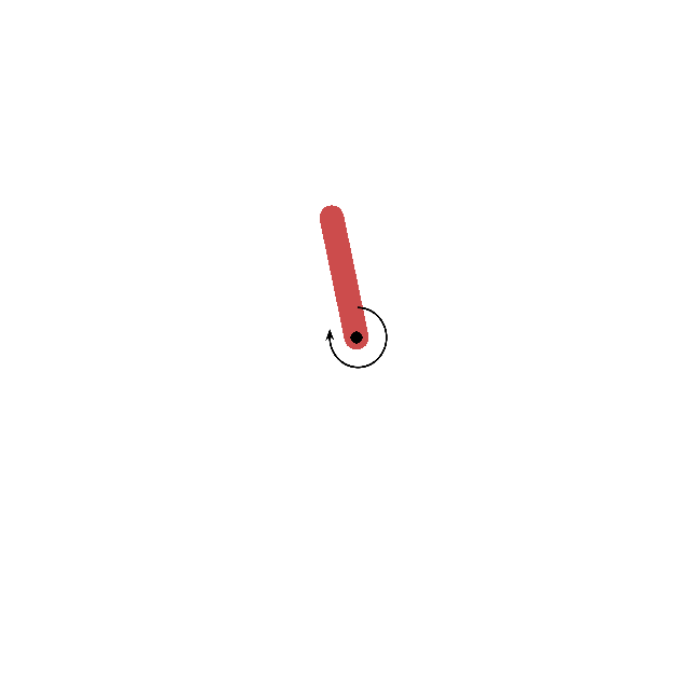
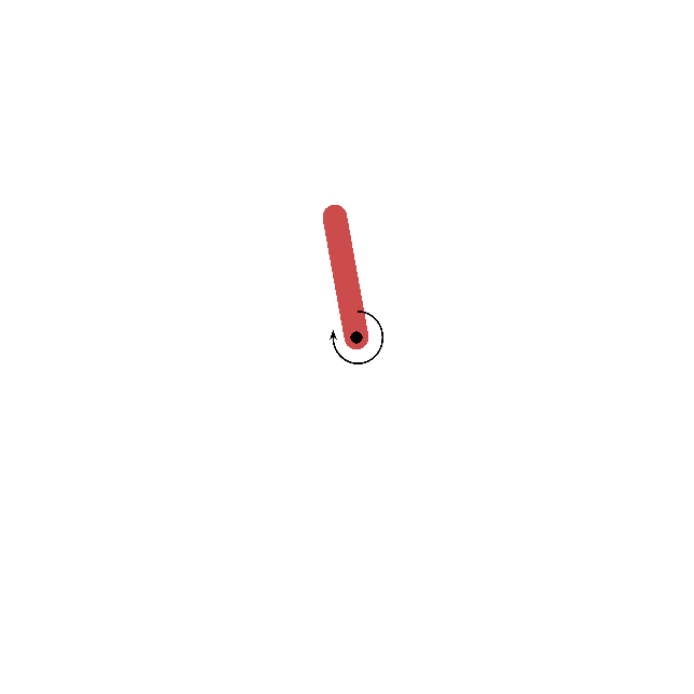
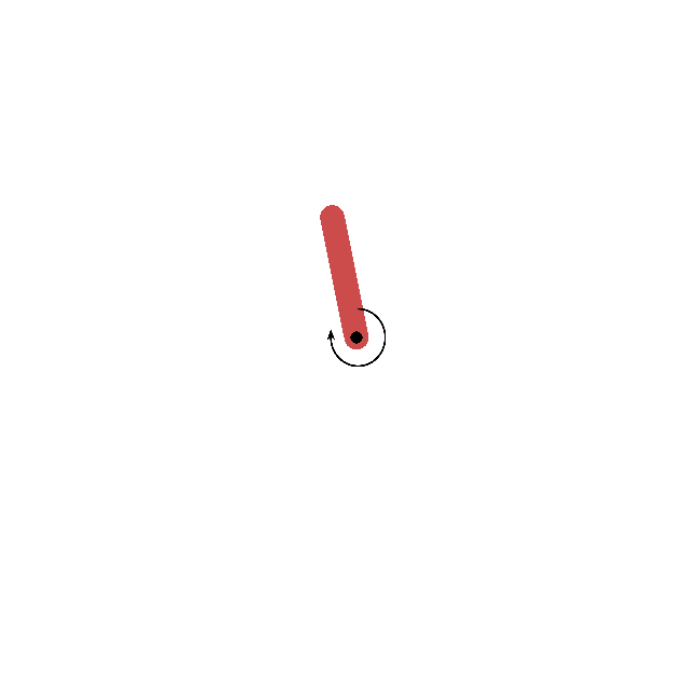
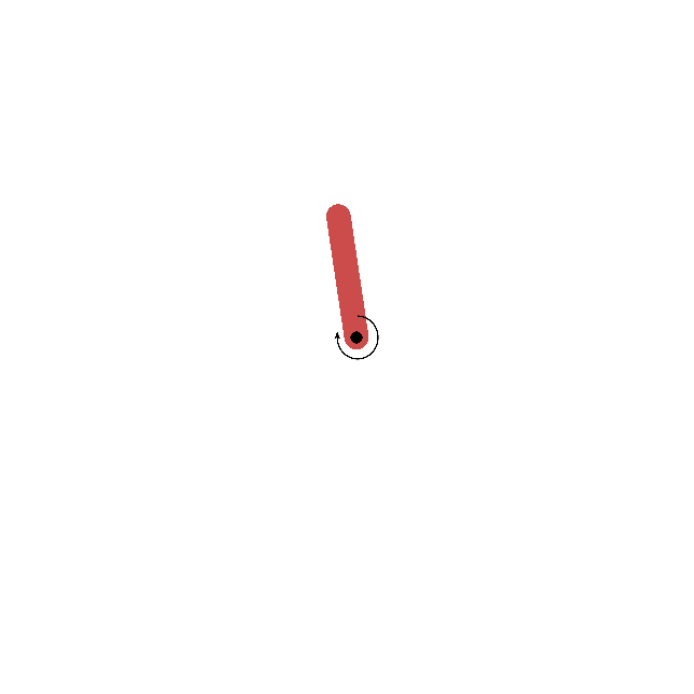
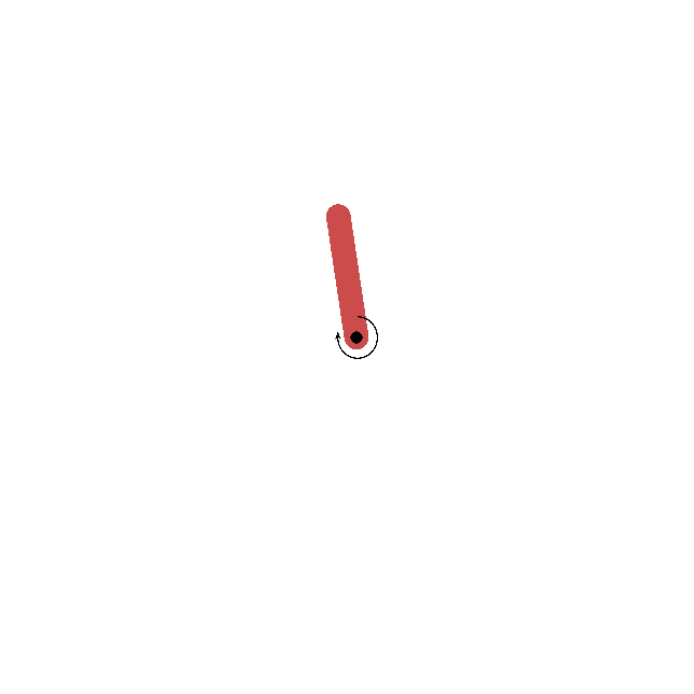
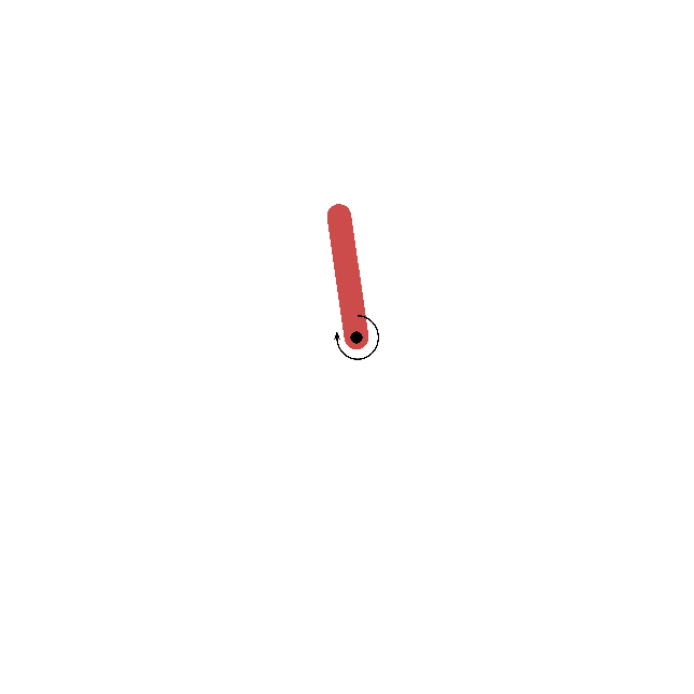
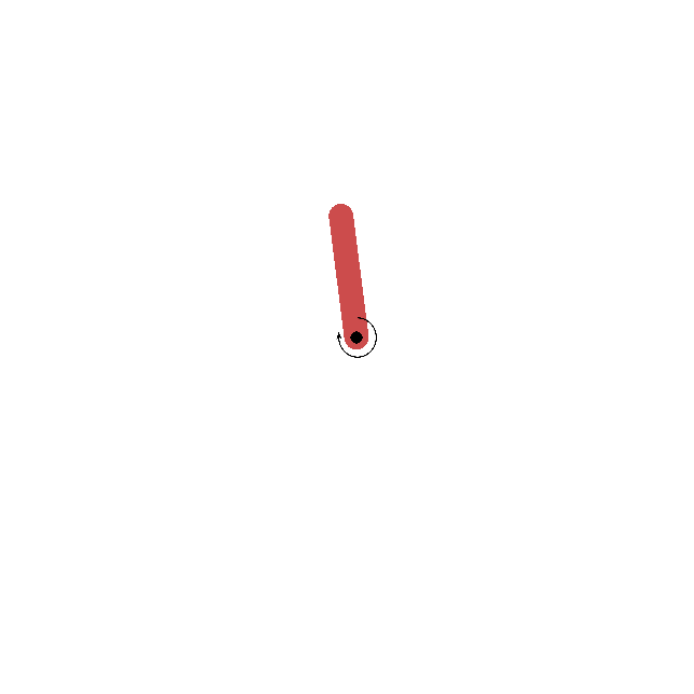
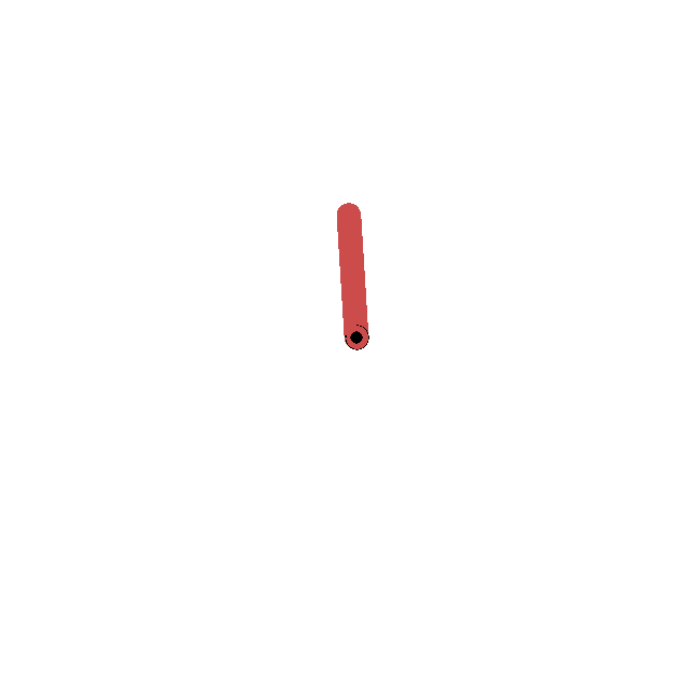
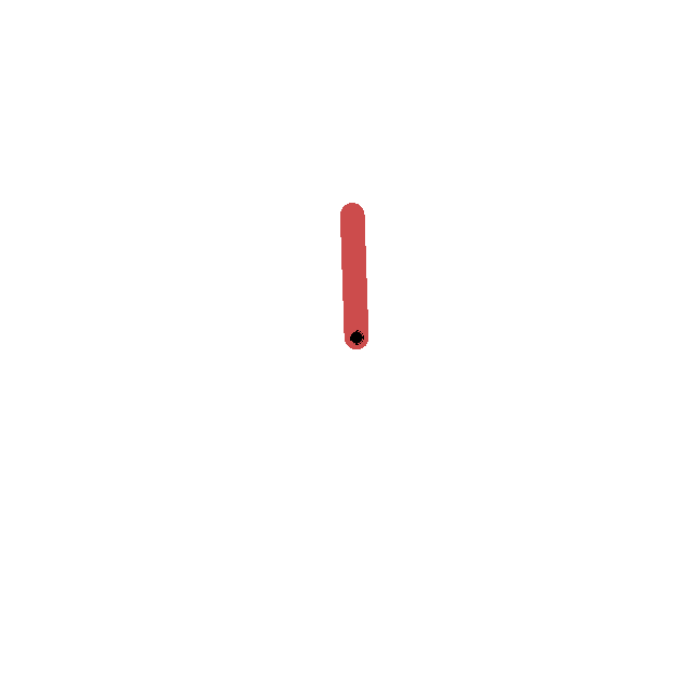
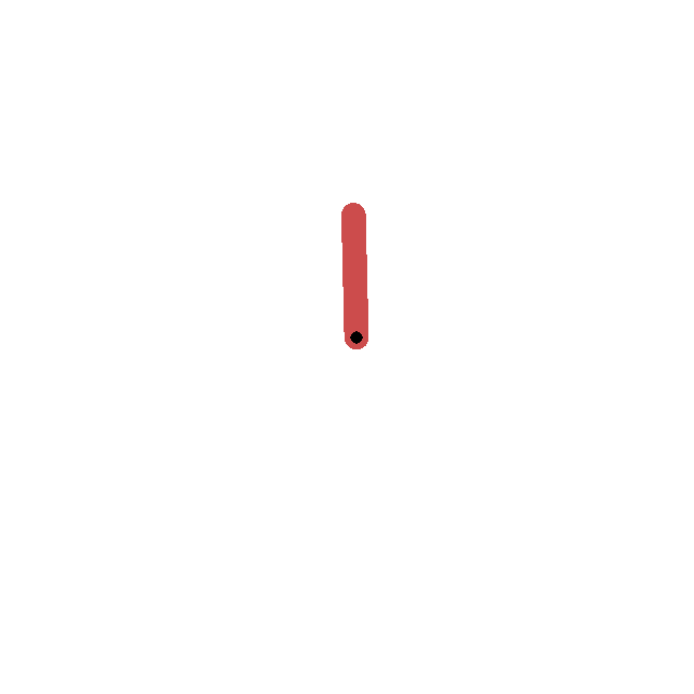
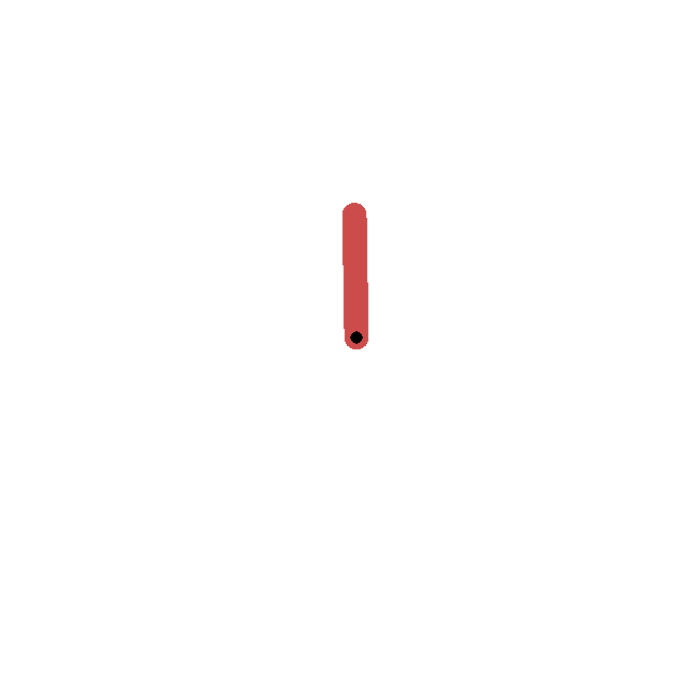
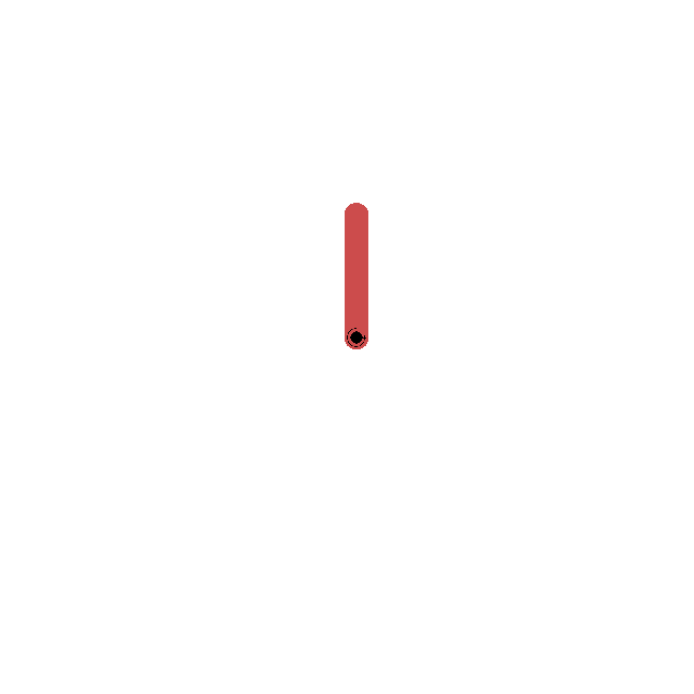
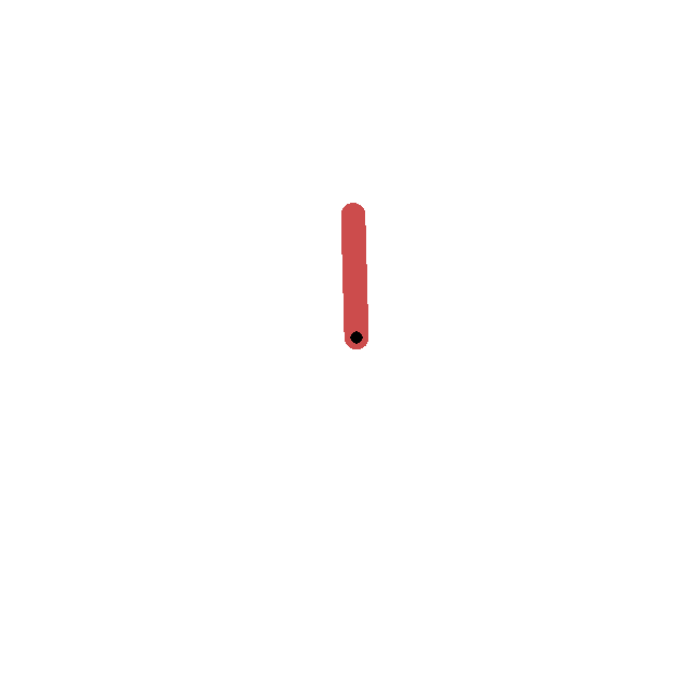
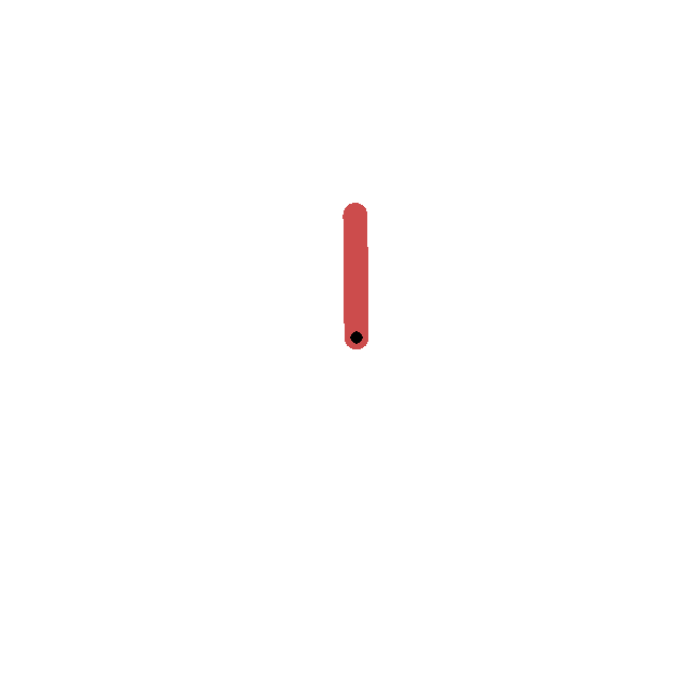
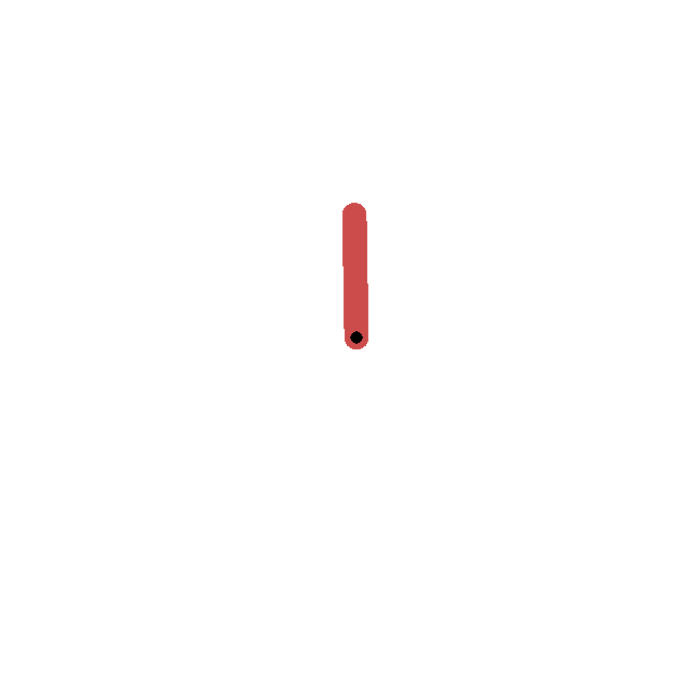
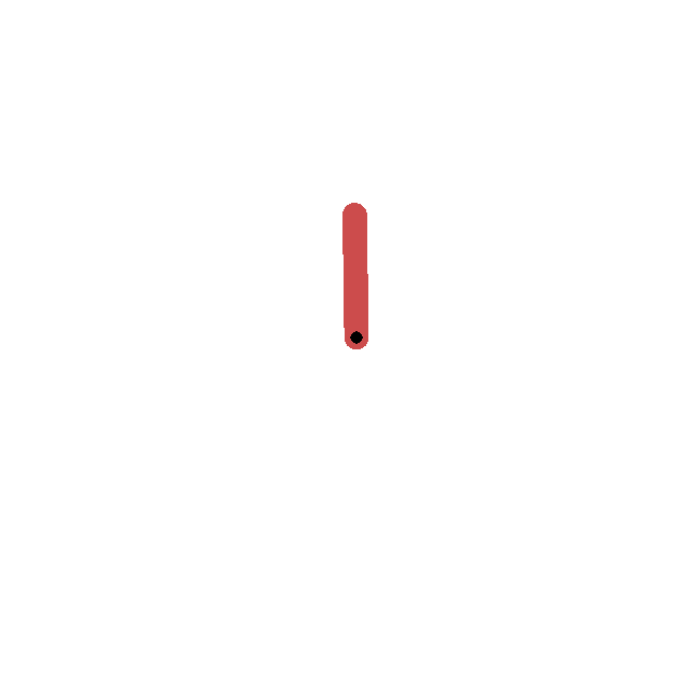
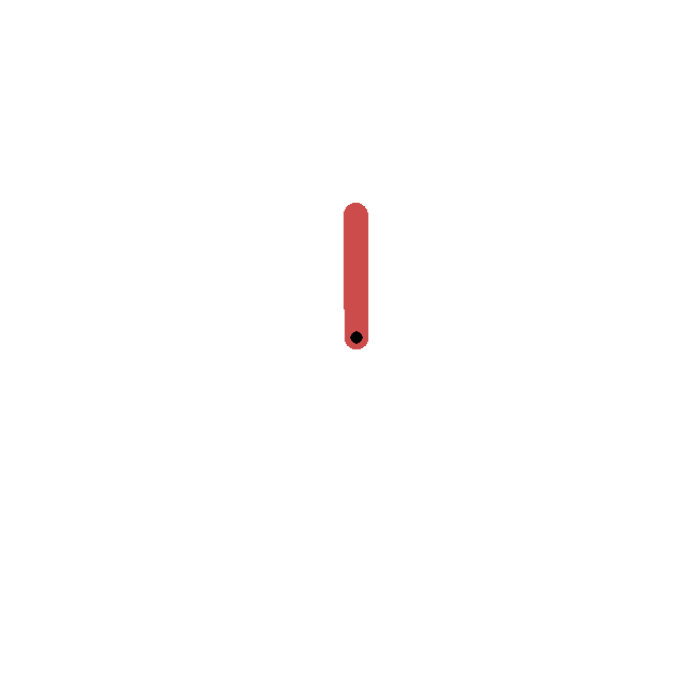
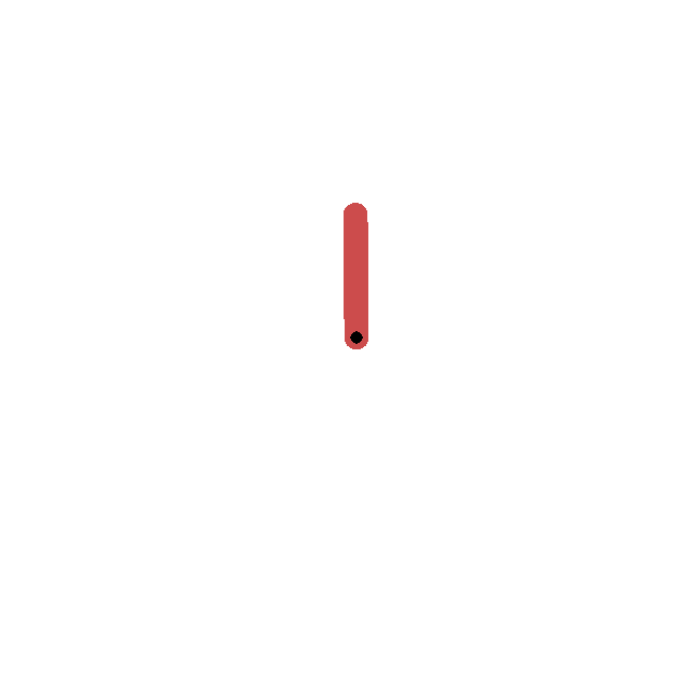
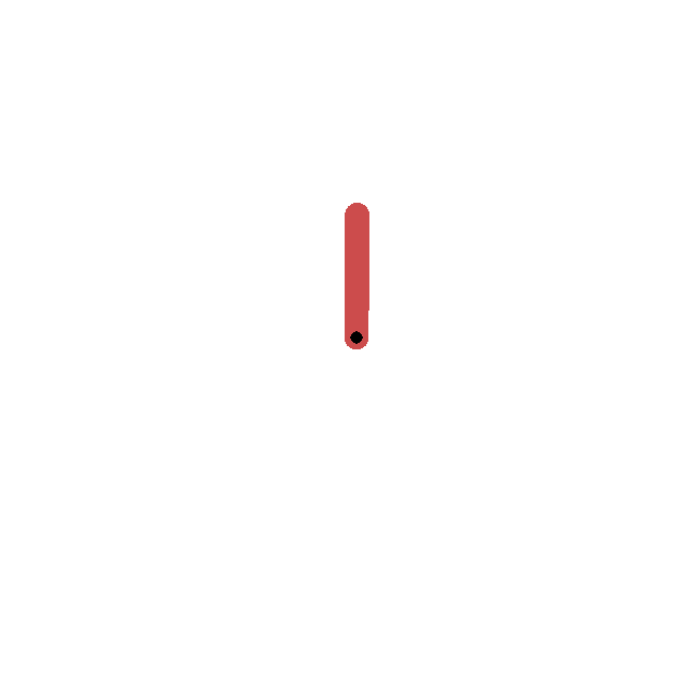
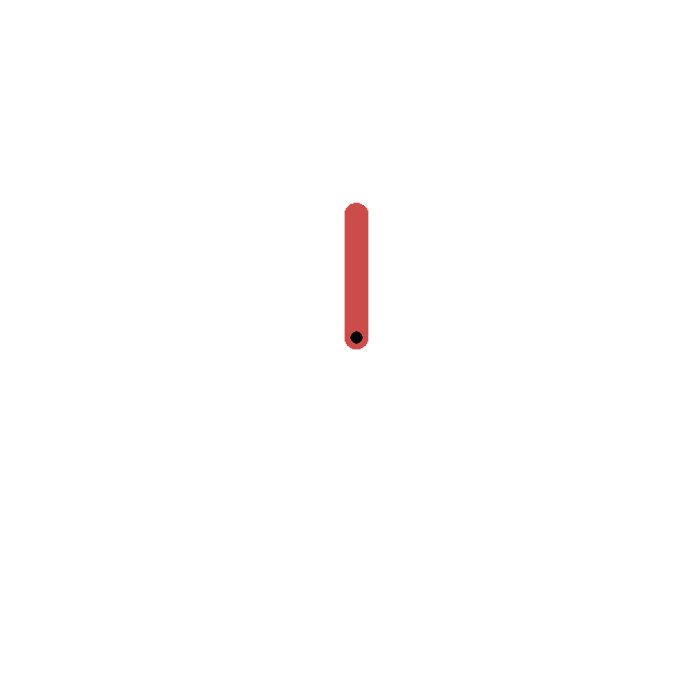
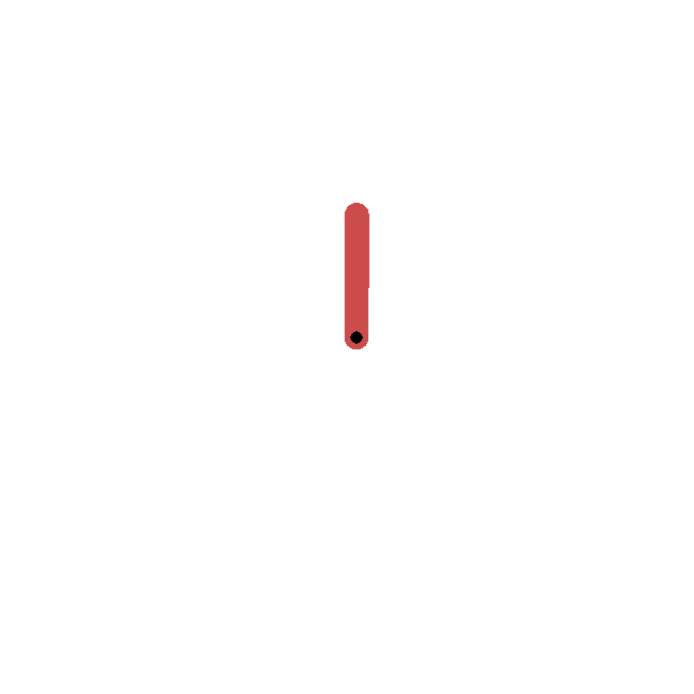
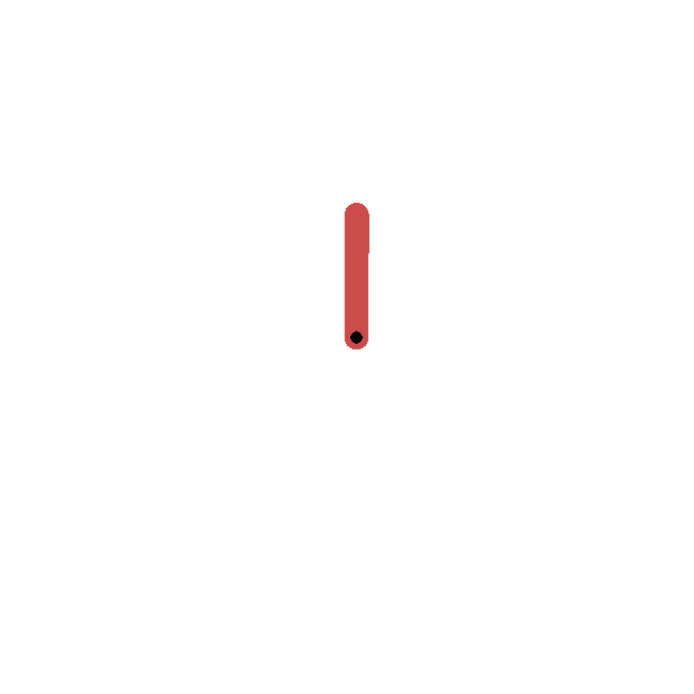
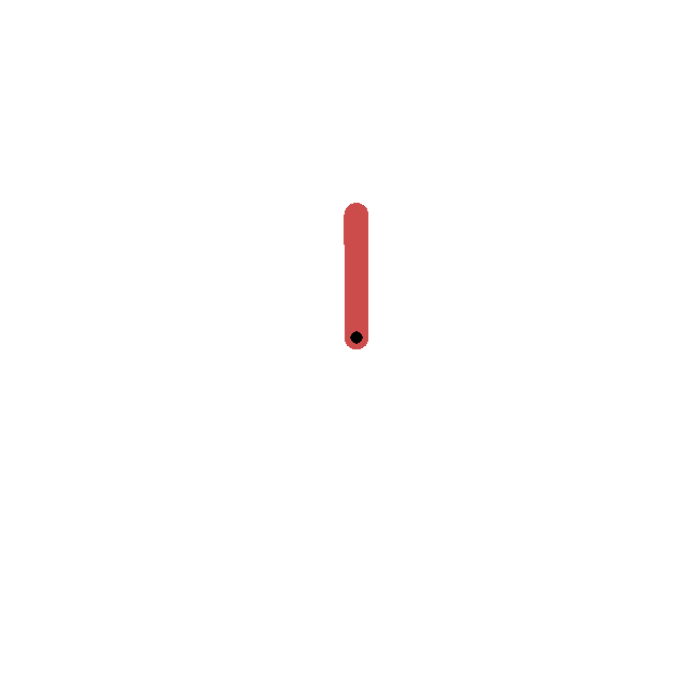
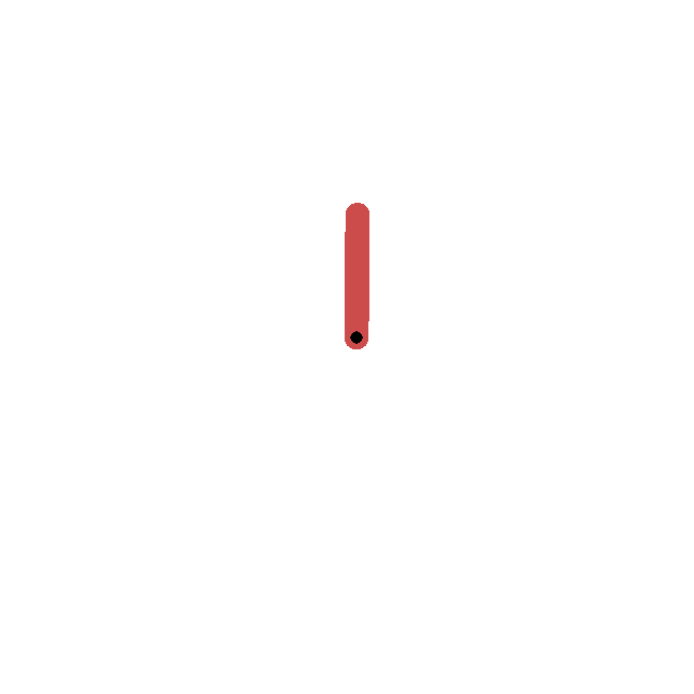
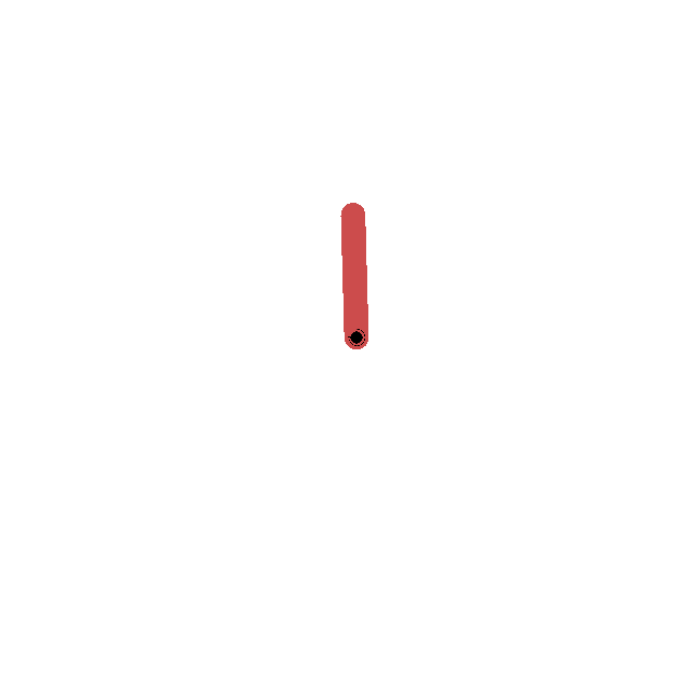
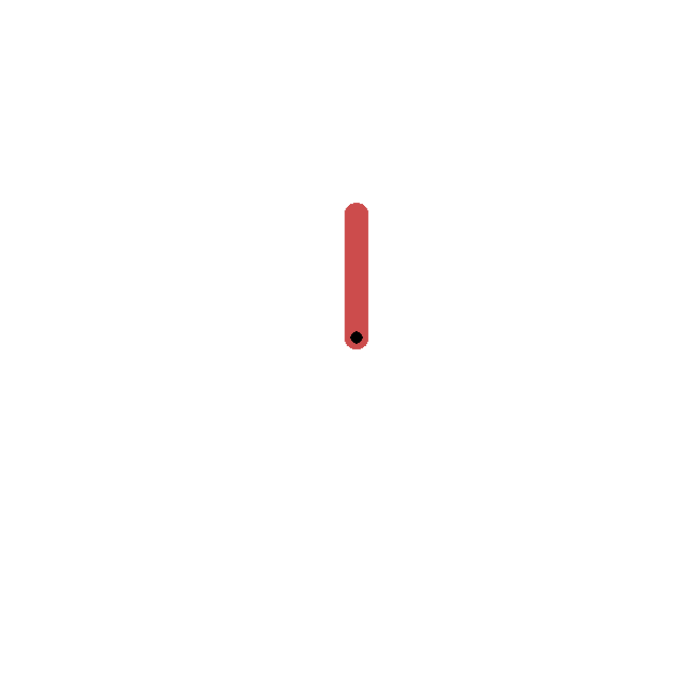
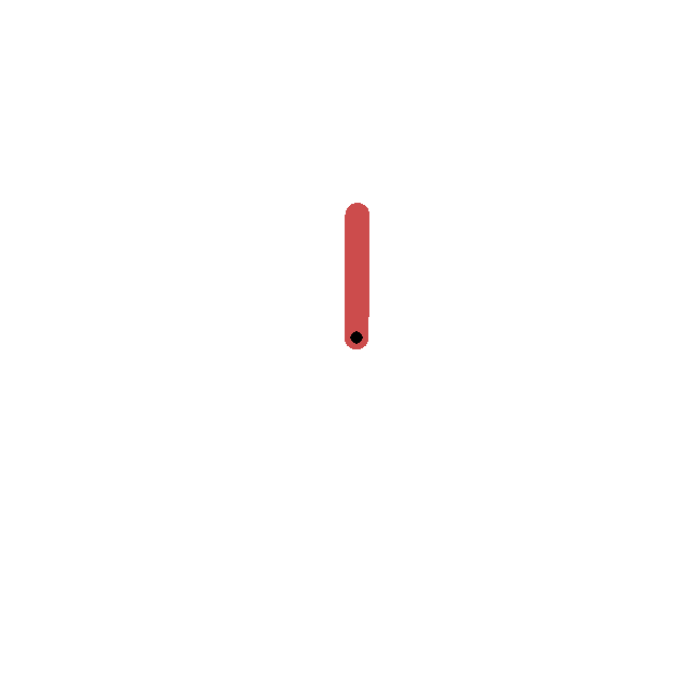
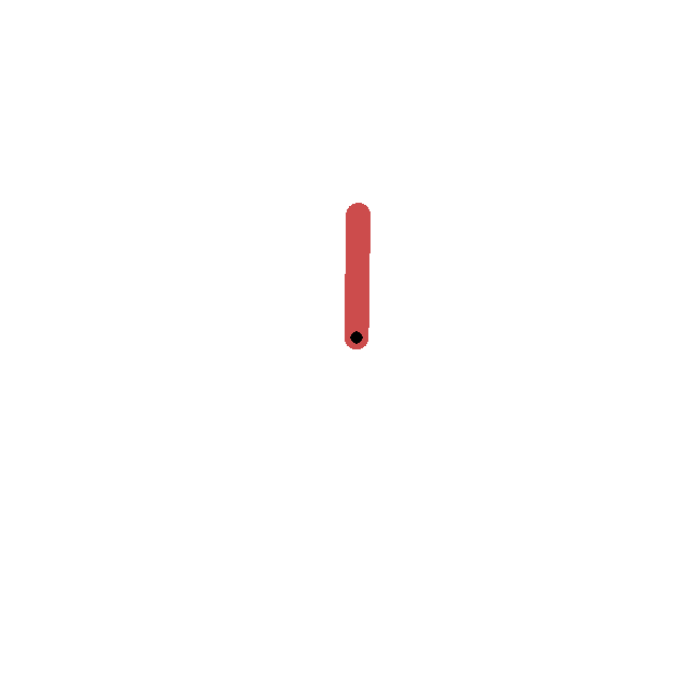
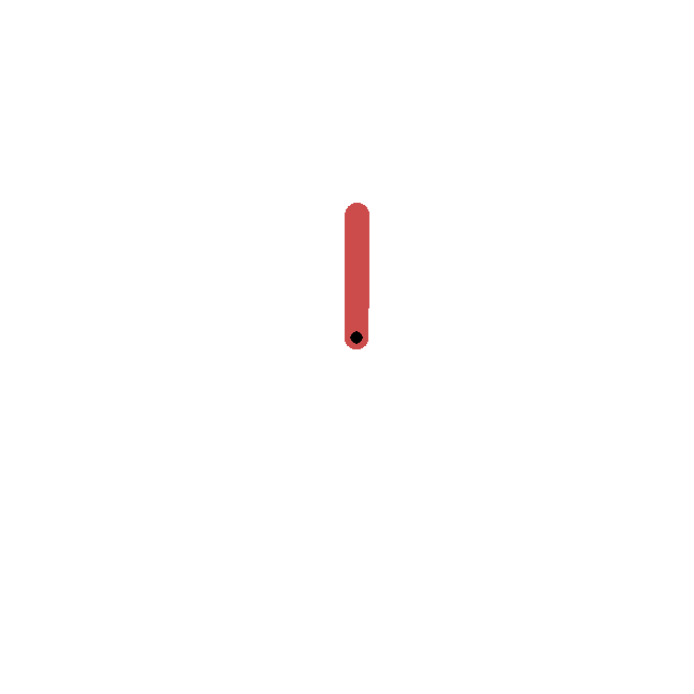
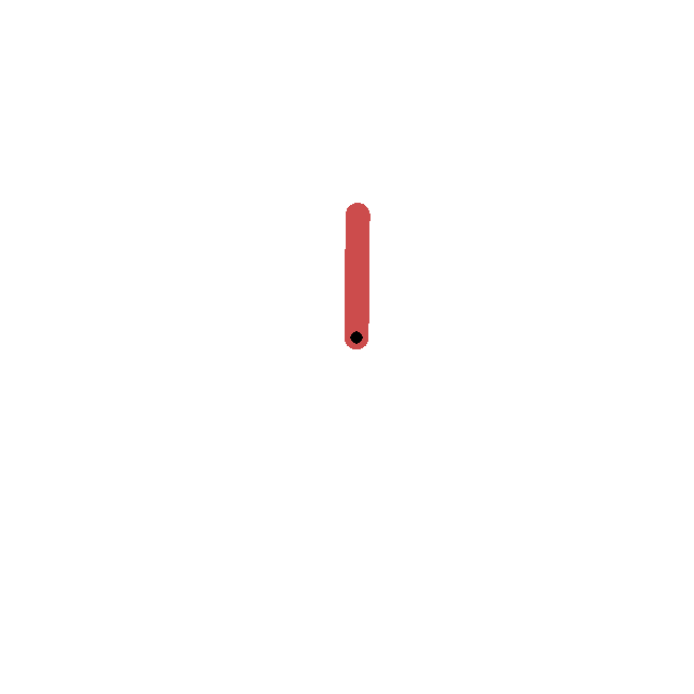
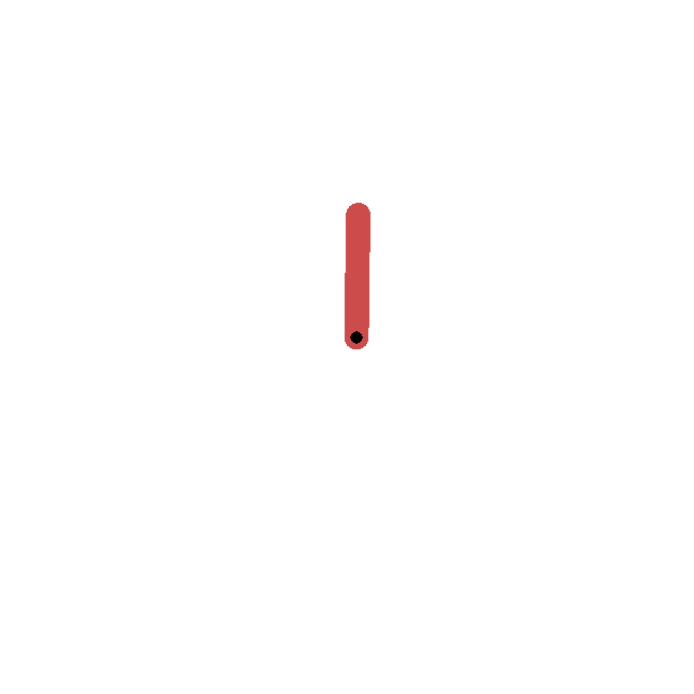
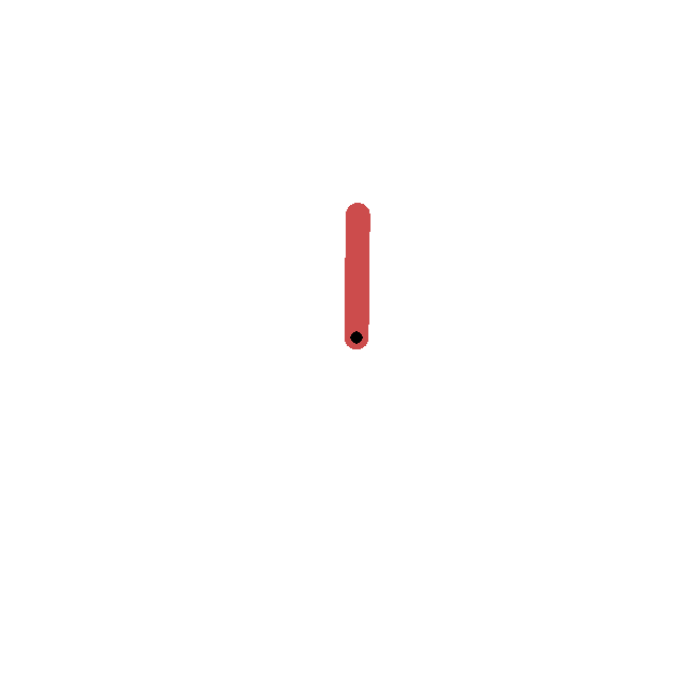
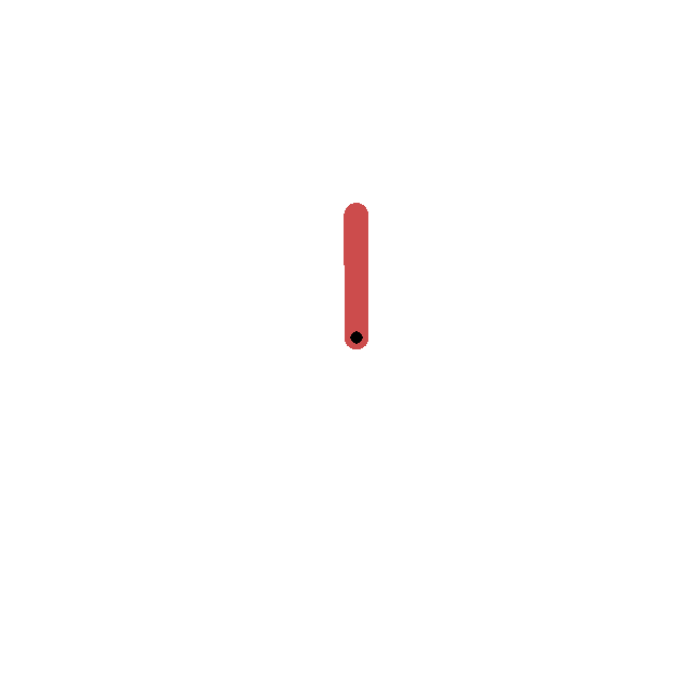
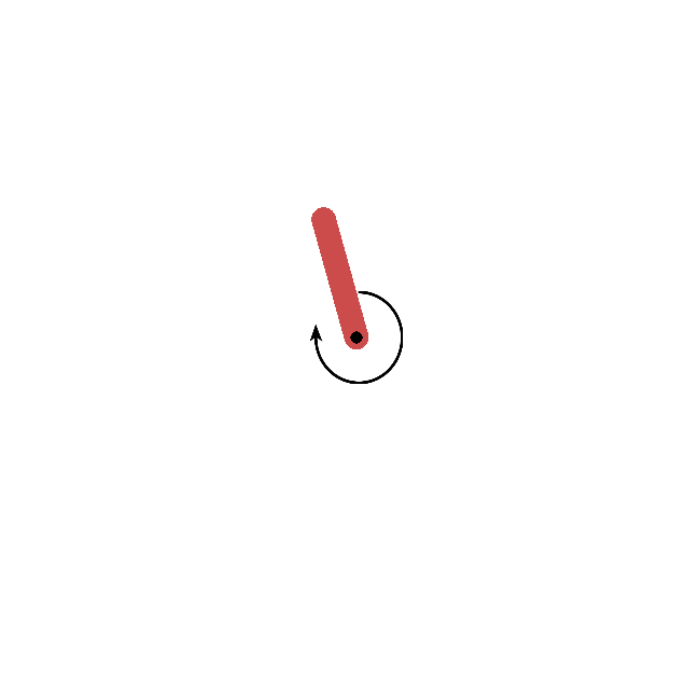
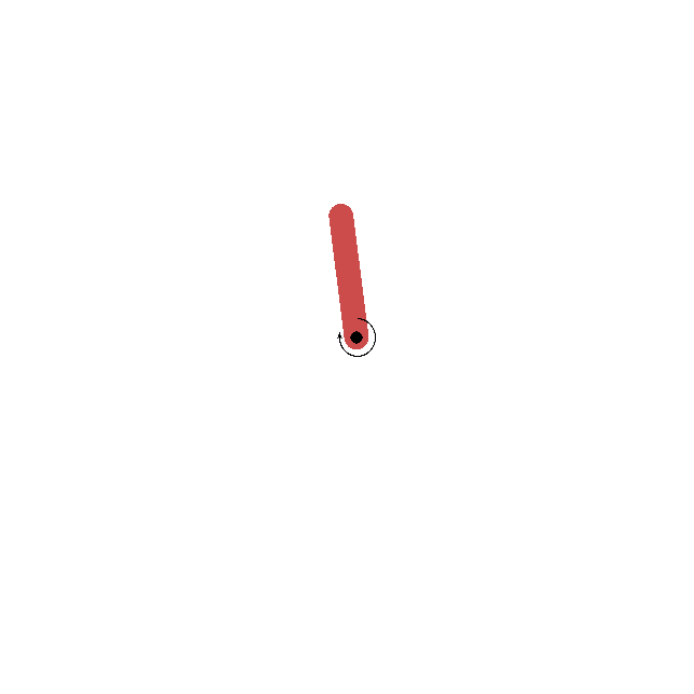
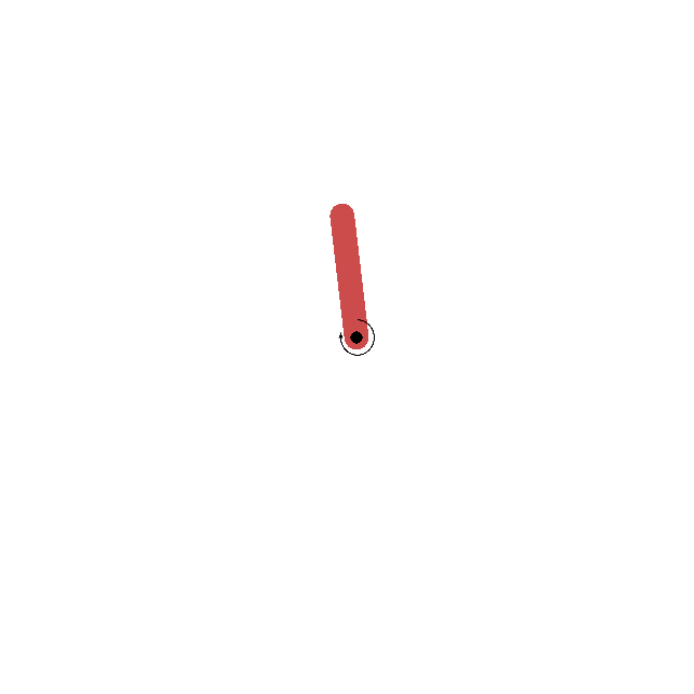
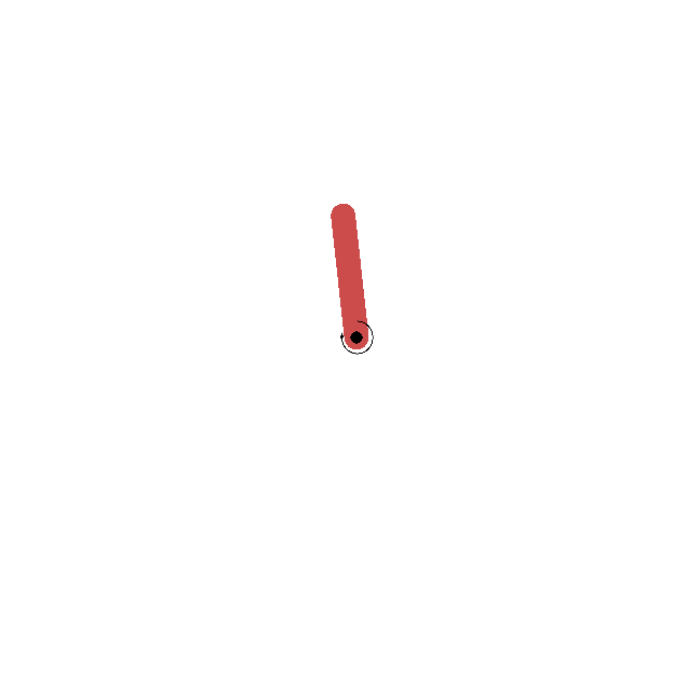
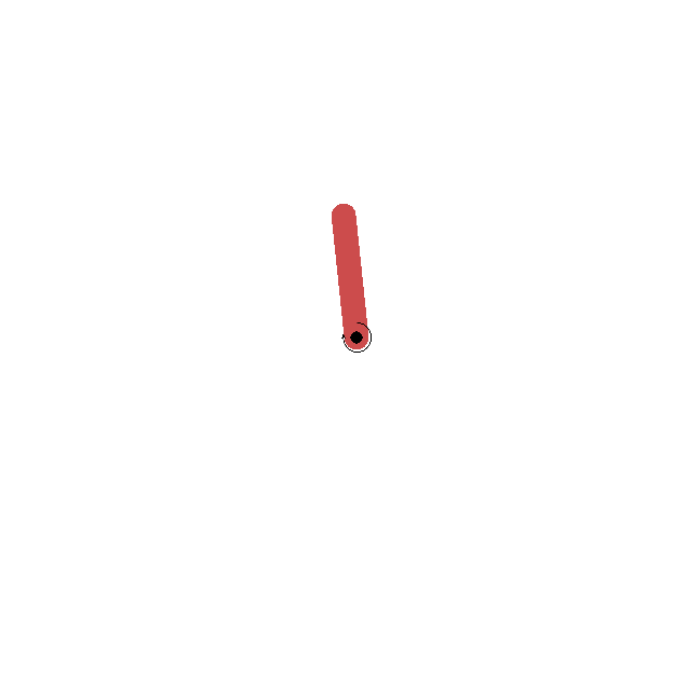
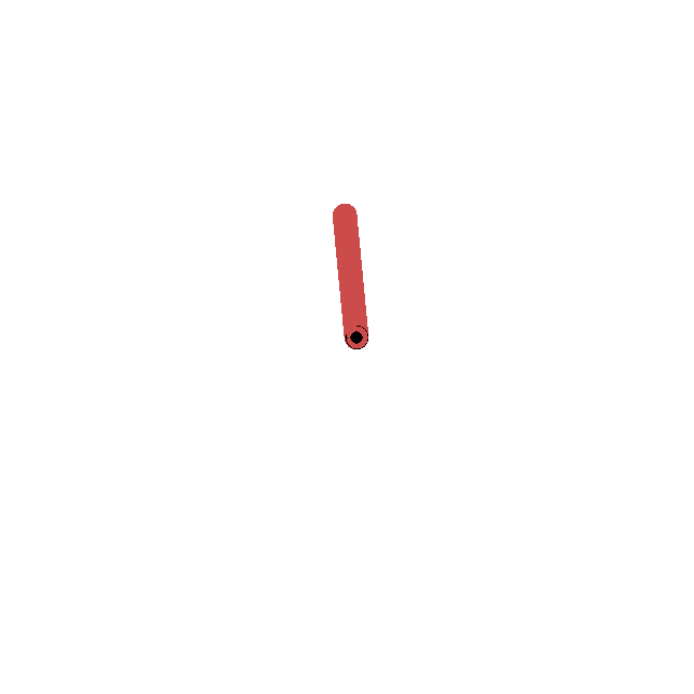
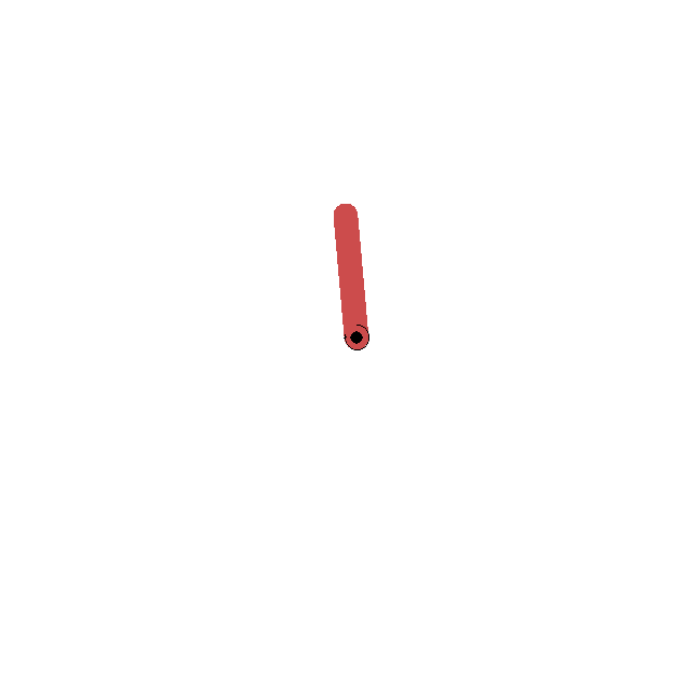
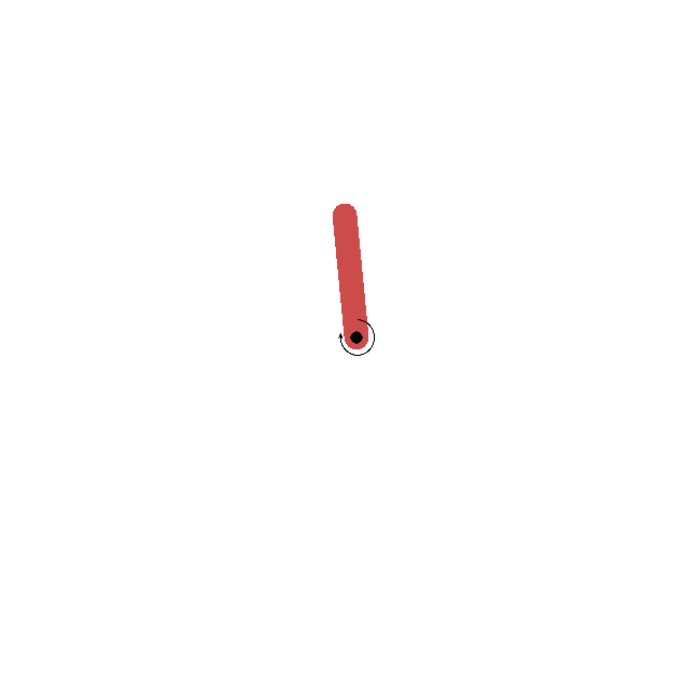
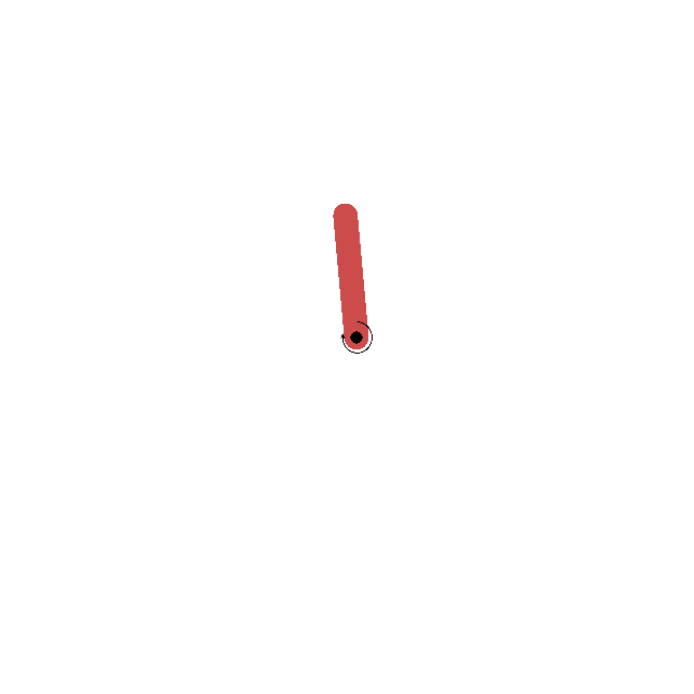
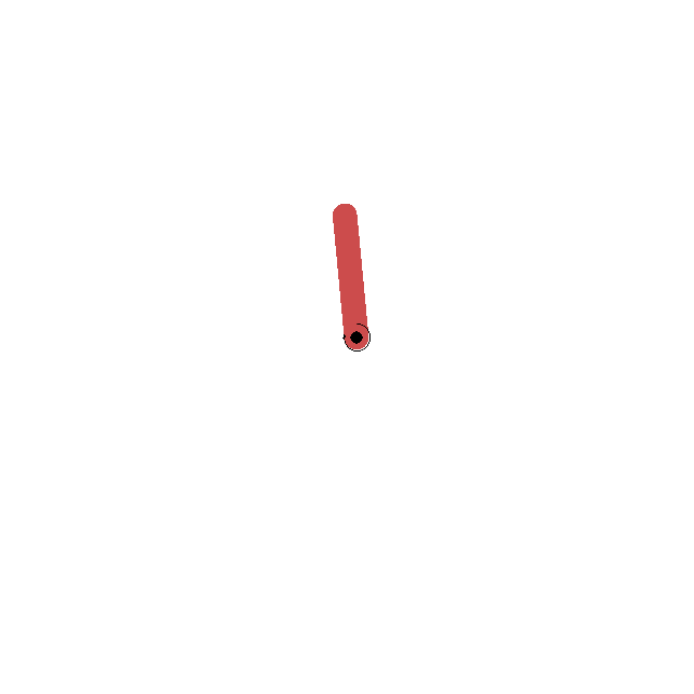
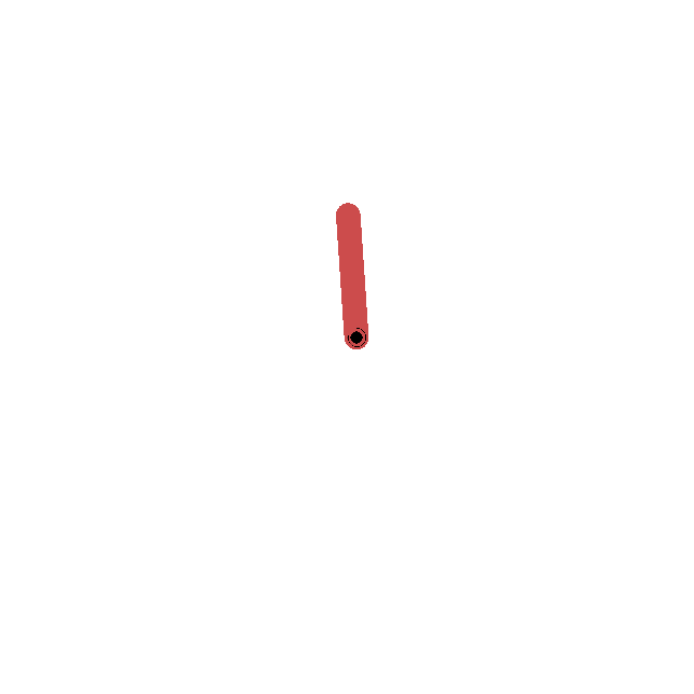
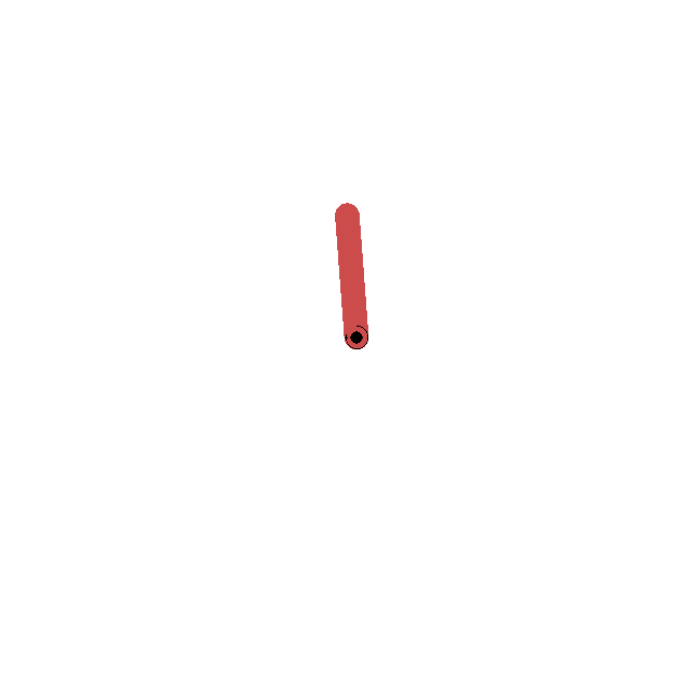
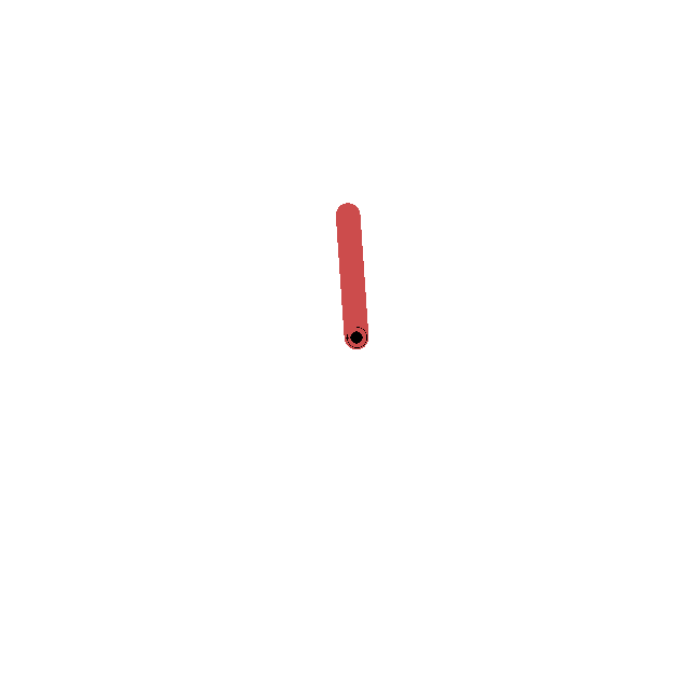
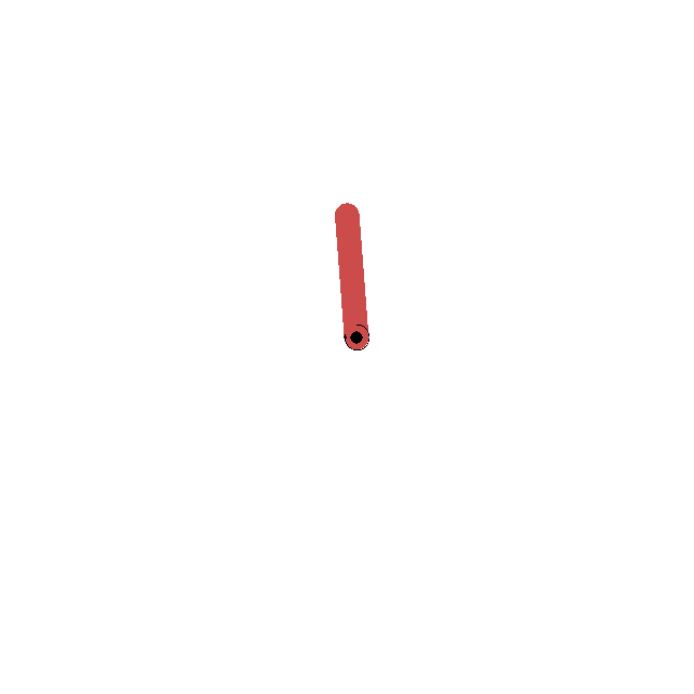
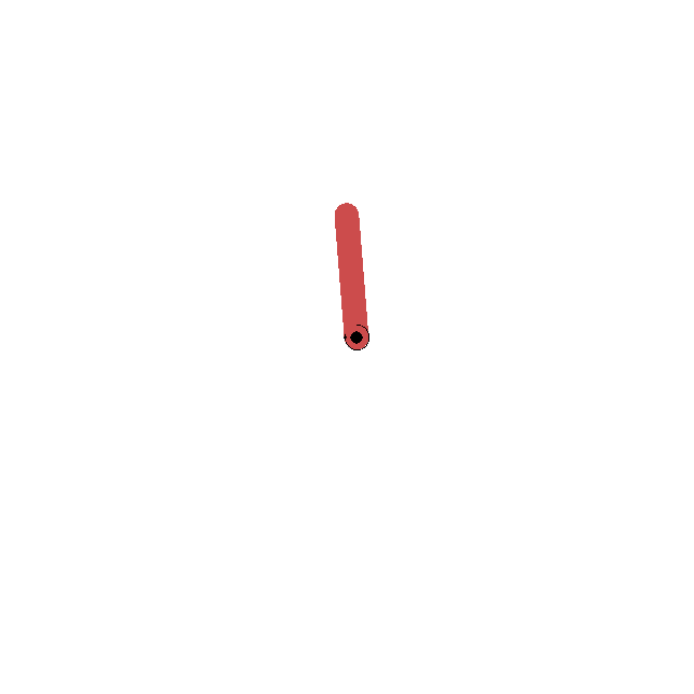
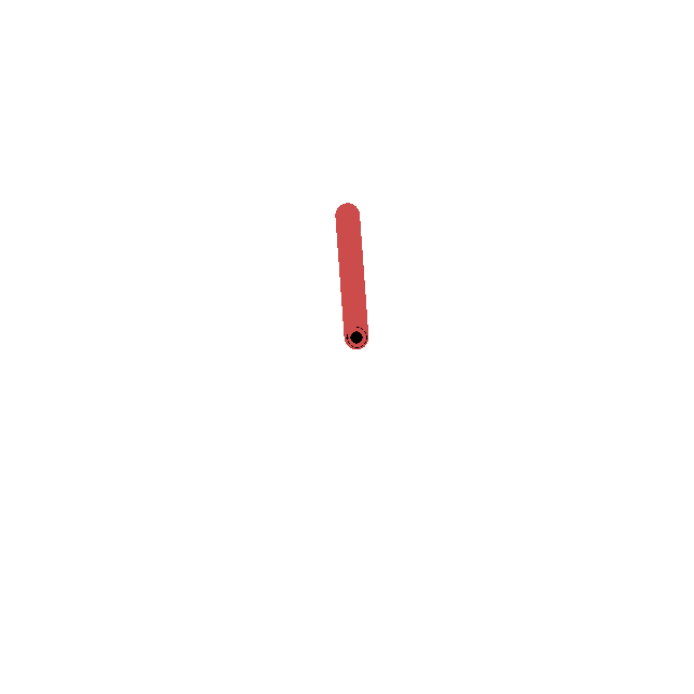
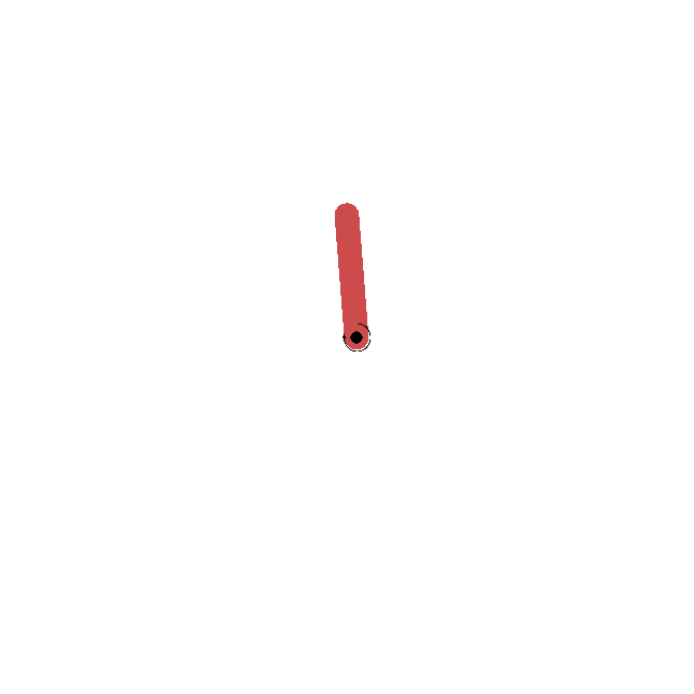
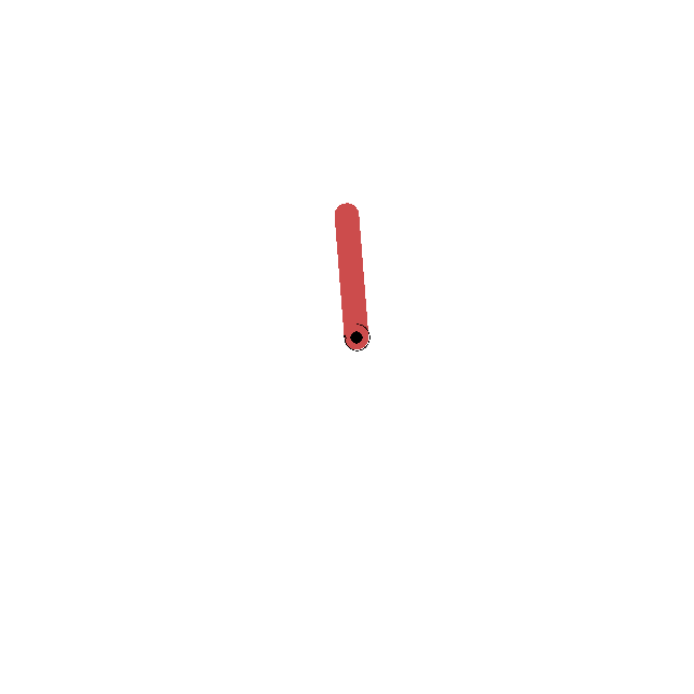
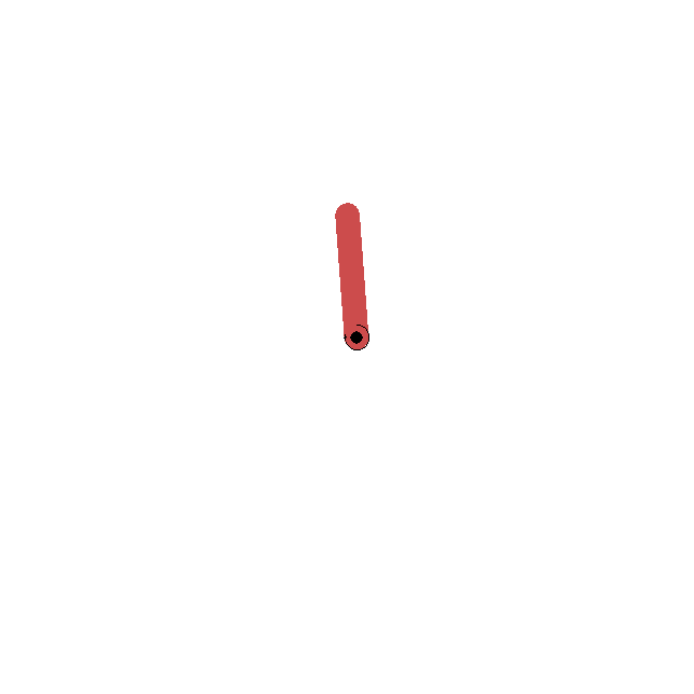
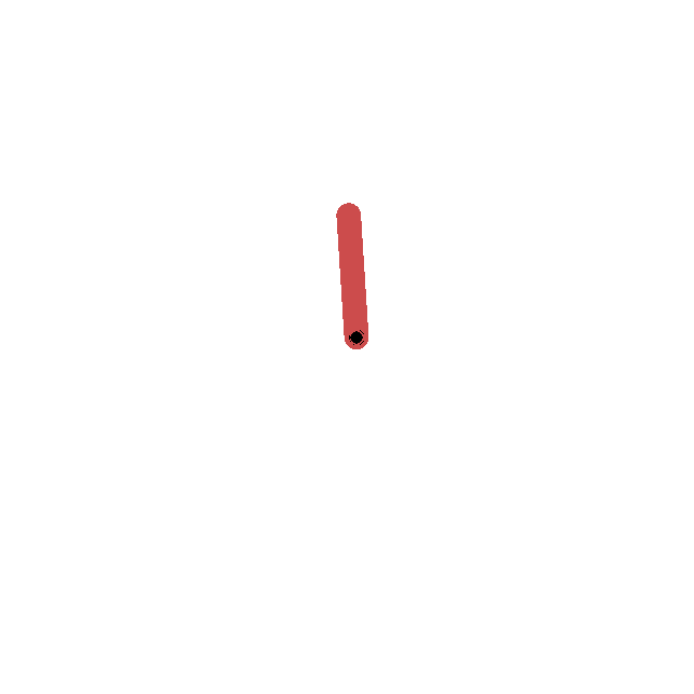
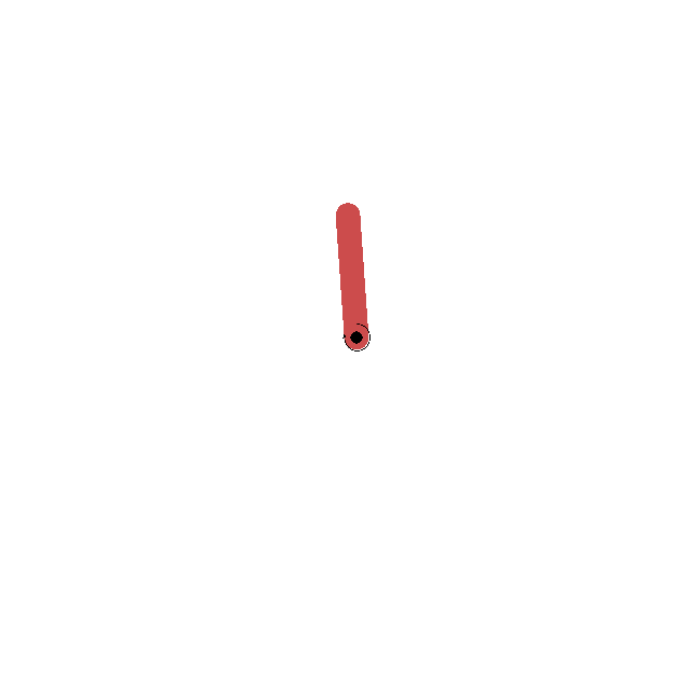
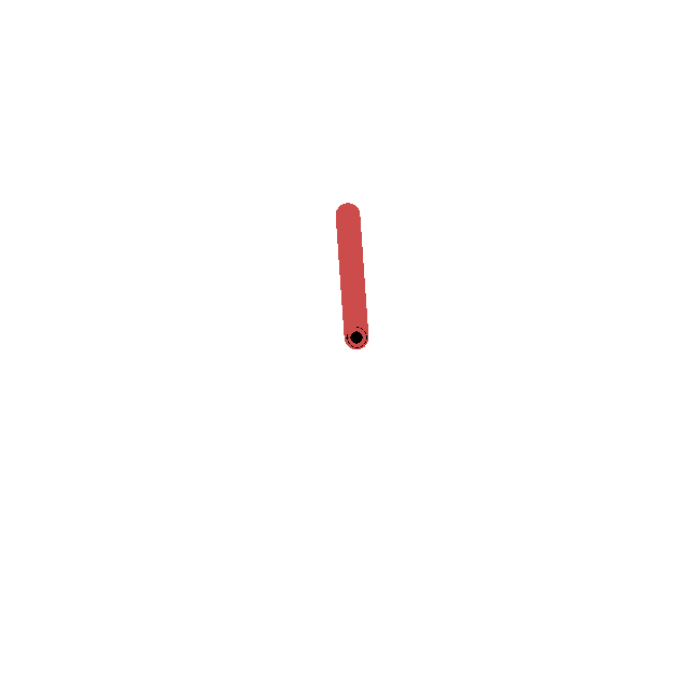

In [11]:
display_frames_as_gif(frames)